# Assignment 2 : CNNs for Image Classification
#### Aniruddha Biswas (a1760705)

## Imports required for the notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

import pickle

from itertools import product

## Model Definition

### Baseline Model

In [2]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 60)  
        self.fc2 = nn.Linear(60, 40)         
        self.fc3 = nn.Linear(40, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   

### AlexNet

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = self.classifier(x)
        return x

### ResNet18

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv_layer_1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(planes)
        self.conv_layer_2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.batch_norm_1(self.conv_layer_1(x)))
        out = self.batch_norm_2(self.conv_layer_2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv_layer_1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(64)
        self.layer_1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer_2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer_3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer_4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.batch_norm_1(self.conv_layer_1(x)))
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

### MobileNet V2

In [5]:
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv_layer_1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(planes)
        self.conv_layer_2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(planes)
        self.conv_layer_3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm_3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.batch_norm_1(self.conv_layer_1(x)))
        out = F.relu(self.batch_norm_2(self.conv_layer_2(out)))
        out = self.batch_norm_3(self.conv_layer_3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MobileNetV2(nn.Module):

    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # change for stride 2 ==> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        #  change for conv_layer_1 stride 2 ==> 1 for CIFAR10
        self.conv_layer_1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv_layer_2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.batch_norm_1(self.conv_layer_1(x)))
        out = self.layers(out)
        out = F.relu(self.batch_norm_2(self.conv_layer_2(out)))
        # change pooling kernel_size 7 ==> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

### Plotter function to print all metrics

In [6]:
# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    if val_losses:
        plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    if val_accuracies:
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

### Settings up train, validation and Test data

In [7]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
best_acc = 0 
start_epoch = 0 


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Load CIFAR-10 training data with the training transform
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

from torch.utils.data import DataLoader, random_split


train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
SEED = 42
torch.manual_seed(SEED)
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


### Defining Training, Validation and Testing (which will be called in loop)

In [8]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    # Wrap trainloader with tqdm for a progress bar
    with tqdm(trainloader, desc=f" Training Epoch {epoch}", leave=True) as pbar:
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.set_postfix(Loss=loss.item(), Acc=100*(correct/total))
    return train_loss / len(trainloader), 100 * correct / total 


def val(epoch):
    global best_acc
    net.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(valloader, desc=f"Validation Epoch {epoch}", leave=True) as pbar:
            # Wrap val_loader with tqdm for a progress bar
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)
        
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                pbar.set_postfix(Loss=loss.item(), Acc=100*(correct/total))

    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
    return val_loss / len(valloader), 100 * correct / total

def test_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0.0
    with torch.no_grad():
        with tqdm(data_loader, desc="Testing", unit="batch") as t:
            for images, labels in t:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss_sum += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                t.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    avg_loss = loss_sum / len(data_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

### Defining Loss Function

In [9]:
criterion = nn.CrossEntropyLoss()

### The Hyperparameter Combinations (Manual Grid Search)

In [10]:
# Hyperparameter grid
learning_rates = [0.1, 0.01]
optimizers = ["SGD", "Adam", "RMSprop"]

# Generate all combinations
combinations = product(learning_rates, optimizers)

for learning_rate, optimizer in combinations:
    print(f"Learning Rate: {learning_rate}, Optimizer: {optimizer}")

Learning Rate: 0.1, Optimizer: SGD
Learning Rate: 0.1, Optimizer: Adam
Learning Rate: 0.1, Optimizer: RMSprop
Learning Rate: 0.01, Optimizer: SGD
Learning Rate: 0.01, Optimizer: Adam
Learning Rate: 0.01, Optimizer: RMSprop


The following happens for each candidate
- Set the seed
- Initialise the network with that seed
- Transfer it to device (device is either mps or cpu, because cuda was not available at the time)
- initialise the optimiser
- initialise the scheduler
- do the training-validation loop
- plot and store the metrics
- delete the global net, scheduler, optimiser

### Manual Grid Search for Baseline


Testing: Learning Rate = 0.1, Optimizer = SGD

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:12<00:00,  6.16it/s, Acc=27.9, Loss=1.79]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:12<00:00,  6.15it/s, Acc=26.8, Loss=1.56]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:12<00:00,  6.16it/s, Acc=30.9, Loss=2.23]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=32.9, Loss=1.72]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=35.6, Loss=2.33]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:12<00:00,  6.15it/s, Acc=35.5, Loss=2.03]



Epoch: 6


Validation Epoch 6: 100%|████| 79/79 [00:12<00:00,  6.12it/s, Acc=32, Loss=2.28]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:12<00:00,  6.14it/s, Acc=35.3, Loss=1.87]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=39.8, Loss=1.58]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=39.8, Loss=1.68]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:14<00:00, 22.30it/s, Acc=38.5, Loss=1.87
Validation Epoch 10: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=40.4, Loss=1.3]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:14<00:00, 22.25it/s, Acc=38.7, Loss=1.58
Validation Epoch 11: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=37.7, Loss=1.69]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:14<00:00, 22.27it/s, Acc=40.5, Loss=1.71
Validation Epoch 12: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=39.5, Loss=1.75]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:14<00:00, 22.22it/s, Acc=40.2, Loss=1.72
Validation Epoch 13: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=42.8, Loss=1.88]



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:14<00:00, 22.20it/s, Acc=41.2, Loss=1.47
Validation Epoch 14: 100%|███| 79/79 [00:12<00:00,  6.12it/s, Acc=42, Loss=1.63]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:14<00:00, 22.22it/s, Acc=43.5, Loss=1.23
Validation Epoch 15: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=44.8, Loss=1.46]



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:14<00:00, 22.25it/s, Acc=43.9, Loss=1.55
Validation Epoch 16: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=44.6, Loss=1.46]



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:13<00:00, 22.37it/s, Acc=44.8, Loss=1.43
Validation Epoch 17: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=46.5, Loss=1.21]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:14<00:00, 22.31it/s, Acc=45.8, Loss=1.38
Validation Epoch 18: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=46.9, Loss=1.34]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:14<00:00, 22.27it/s, Acc=46.3, Loss=1.66
Validation Epoch 19: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=46.3, Loss=1.61]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:14<00:00, 22.32it/s, Acc=47.3, Loss=1.47
Validation Epoch 20: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=46.5, Loss=1.35]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:14<00:00, 22.32it/s, Acc=49.4, Loss=1.24
Validation Epoch 21: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=47.8, Loss=1.23]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:14<00:00, 22.31it/s, Acc=49.5, Loss=1.56
Validation Epoch 22: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=47.1, Loss=1.28]



Epoch: 23


Validation Epoch 23: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=51.4, Loss=1.16]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:14<00:00, 22.32it/s, Acc=51.8, Loss=1.41
Validation Epoch 24: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=52.3, Loss=1.03]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:13<00:00, 22.39it/s, Acc=52.5, Loss=1.49
Validation Epoch 25: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=52.3, Loss=1.29]



Epoch: 26


Validation Epoch 26: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=52.3, Loss=1.35]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:13<00:00, 22.39it/s, Acc=53.7, Loss=1.43
Validation Epoch 27: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=52.7, Loss=1.25]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:13<00:00, 22.41it/s, Acc=54.7, Loss=1.53
Validation Epoch 28: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=54.2, Loss=1.16]



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:13<00:00, 22.41it/s, Acc=55.3, Loss=1.22
Validation Epoch 29: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=57.3, Loss=1.27]



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:13<00:00, 22.38it/s, Acc=56.9, Loss=1.15
Validation Epoch 30: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=53.5, Loss=0.922



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:13<00:00, 22.36it/s, Acc=57.6, Loss=1.07
Validation Epoch 31: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=57.9, Loss=1.06]



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:13<00:00, 22.39it/s, Acc=57.7, Loss=1.08
Validation Epoch 32: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=57.9, Loss=1.2]



Epoch: 33


Validation Epoch 33: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=58, Loss=0.958]



Epoch: 34


Validation Epoch 34: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=60.1, Loss=1.26]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:14<00:00, 22.22it/s, Acc=60.1, Loss=1.29
Validation Epoch 35: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=59.9, Loss=1.09]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:14<00:00, 22.21it/s, Acc=61.3, Loss=1.35
Validation Epoch 36: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=62.1, Loss=0.881



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:14<00:00, 22.23it/s, Acc=61.9, Loss=0.97
Validation Epoch 37: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=61.5, Loss=1.04]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:14<00:00, 22.22it/s, Acc=62.5, Loss=1.09
Validation Epoch 38: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=62.1, Loss=0.76]



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:14<00:00, 22.26it/s, Acc=63.2, Loss=1.07
Validation Epoch 39: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=62.4, Loss=0.992



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:14<00:00, 22.27it/s, Acc=63.6, Loss=1.11
Validation Epoch 40: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=63.5, Loss=0.898



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:14<00:00, 22.27it/s, Acc=64.5, Loss=1.3]
Validation Epoch 41: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=64.2, Loss=0.905



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:14<00:00, 22.17it/s, Acc=64.9, Loss=0.97
Validation Epoch 42: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=63.9, Loss=0.878



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:14<00:00, 22.17it/s, Acc=65.3, Loss=0.84
Validation Epoch 43: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=64.1, Loss=0.976



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:14<00:00, 22.20it/s, Acc=65.6, Loss=0.58
Validation Epoch 44: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=65.3, Loss=0.847



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:14<00:00, 22.24it/s, Acc=66.2, Loss=1.15
Validation Epoch 45: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=65.2, Loss=0.78]



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:14<00:00, 22.17it/s, Acc=66.4, Loss=1.07
Validation Epoch 46: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=65.1, Loss=0.994



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:14<00:00, 22.17it/s, Acc=66.4, Loss=0.76
Validation Epoch 47: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=65.6, Loss=0.644



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:14<00:00, 22.16it/s, Acc=67, Loss=0.932]
Validation Epoch 48: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=65.7, Loss=0.652



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:14<00:00, 22.17it/s, Acc=67.1, Loss=0.85
Validation Epoch 49: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=65.8, Loss=0.529

Validation Accuracy:  65.81


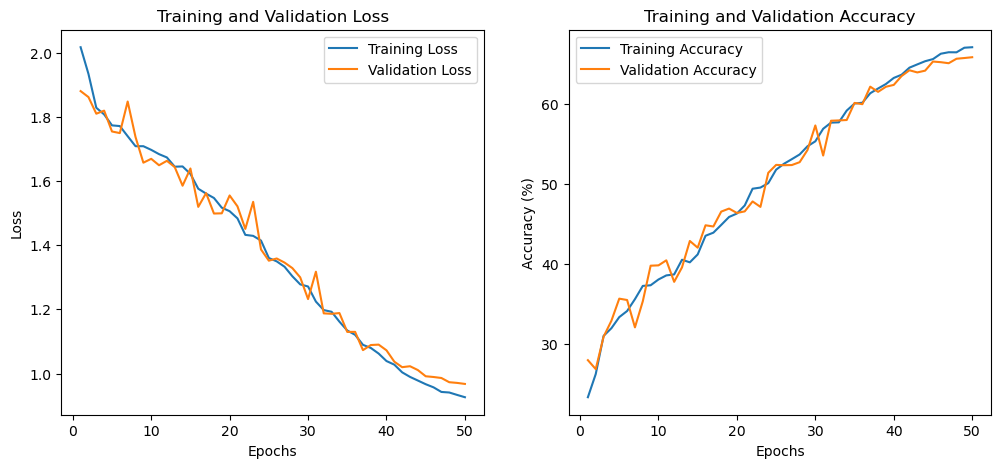

CPU times: user 3min 35s, sys: 2min 46s, total: 6min 21s
Wall time: 22min 28s


In [11]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = Baseline()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

baseline_0_1_SGD_train_losses = []
baseline_0_1_SGD_val_losses = []
baseline_0_1_SGD_train_accuracies = []
baseline_0_1_SGD_val_accuracies = []


for epoch in range(start_epoch, 50):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    baseline_0_1_SGD_train_losses.append(train_loss)
    baseline_0_1_SGD_val_losses.append(val_loss)
    baseline_0_1_SGD_train_accuracies.append(train_accuracy)
    baseline_0_1_SGD_val_accuracies.append(val_accuracy)

state_baseline_0_1_SGD,  acc_baseline_0_1_SGD = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_baseline_0_1_SGD)

plot_metrics(baseline_0_1_SGD_train_losses, baseline_0_1_SGD_val_losses, 
             baseline_0_1_SGD_train_accuracies, baseline_0_1_SGD_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [12]:
file_path_baseline_0_1_SGD = "./result_and_model/baseline_0_1_SGD_results.pkl"
model_state_path_baseline_0_1_SGD = "./result_and_model/baseline_0_1_SGD_model.pth"

with open(file_path_baseline_0_1_SGD, "wb") as f:
    pickle.dump({
        "train_losses": baseline_0_1_SGD_train_losses,
        "val_losses": baseline_0_1_SGD_val_losses,
        "train_accuracies": baseline_0_1_SGD_train_accuracies,
        "val_accuracies": baseline_0_1_SGD_val_accuracies,
        "best_accuracy": acc_baseline_0_1_SGD
    }, f)


torch.save(state_baseline_0_1_SGD, model_state_path_baseline_0_1_SGD)

print("Training data and model state saved successfully.")


Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = SGD

Epoch: 0


Validation Epoch 0: 100%|████| 79/79 [00:12<00:00,  6.12it/s, Acc=33, Loss=1.61]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=41.2, Loss=1.66]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=44.5, Loss=1.35]



Epoch: 3


Validation Epoch 3: 100%|████| 79/79 [00:12<00:00,  6.13it/s, Acc=49, Loss=1.49]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=52.2, Loss=1.18]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=54.3, Loss=1.18]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=52.2, Loss=1.31]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=55.2, Loss=1.05]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=55.6, Loss=1.49]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=58.3, Loss=1.07]



Epoch: 10


Validation Epoch 10: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=57.5, Loss=1.46]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:14<00:00, 22.24it/s, Acc=58.7, Loss=1.14
Validation Epoch 11: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=59.2, Loss=1.08]



Epoch: 12


Validation Epoch 12: 100%|███| 79/79 [00:12<00:00,  6.12it/s, Acc=59, Loss=1.21]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:14<00:00, 22.32it/s, Acc=59.8, Loss=0.98
Validation Epoch 13: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=59, Loss=0.938]



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:14<00:00, 22.25it/s, Acc=59.9, Loss=0.99
Validation Epoch 14: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=56.5, Loss=1.09]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:14<00:00, 22.31it/s, Acc=60.5, Loss=0.84
Validation Epoch 15: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=60.5, Loss=0.918



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:14<00:00, 22.35it/s, Acc=60.8, Loss=1.12
Validation Epoch 16: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=61.1, Loss=1.11]



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:14<00:00, 22.30it/s, Acc=61.8, Loss=0.85
Validation Epoch 17: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=60.8, Loss=1.14]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:14<00:00, 22.31it/s, Acc=62.2, Loss=0.85
Validation Epoch 18: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=61.6, Loss=1.09]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:14<00:00, 22.28it/s, Acc=62.3, Loss=1.14
Validation Epoch 19: 100%|███| 79/79 [00:12<00:00,  6.12it/s, Acc=60, Loss=1.09]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:13<00:00, 22.36it/s, Acc=62.8, Loss=0.88
Validation Epoch 20: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=61.6, Loss=1.31]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:14<00:00, 22.30it/s, Acc=63.4, Loss=0.96
Validation Epoch 21: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=62.6, Loss=0.874



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:14<00:00, 22.30it/s, Acc=63.5, Loss=1.08
Validation Epoch 22: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=62.7, Loss=1.01]



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:14<00:00, 22.28it/s, Acc=63.8, Loss=1.12
Validation Epoch 23: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=61.7, Loss=1.22]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:14<00:00, 22.29it/s, Acc=64.1, Loss=0.86
Validation Epoch 24: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=62.6, Loss=0.813



Epoch: 25


Validation Epoch 25: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=62.9, Loss=1.19]



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:13<00:00, 22.36it/s, Acc=64.5, Loss=0.88
Validation Epoch 26: 100%|█| 79/79 [00:12<00:00,  6.13it/s, Acc=61.7, Loss=1.16]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:13<00:00, 22.36it/s, Acc=64.2, Loss=1.14
Validation Epoch 27: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=62.5, Loss=1.31]



Epoch: 28


Validation Epoch 28: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=63.3, Loss=1.06]



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:14<00:00, 22.29it/s, Acc=65.5, Loss=0.90
Validation Epoch 29: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=64.4, Loss=0.941



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:14<00:00, 22.21it/s, Acc=65.3, Loss=0.92
Validation Epoch 30: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=64.9, Loss=1.23]



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:14<00:00, 22.20it/s, Acc=65.6, Loss=0.93
Validation Epoch 31: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=64.8, Loss=0.824



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:14<00:00, 22.23it/s, Acc=65.8, Loss=0.85
Validation Epoch 32: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=64.4, Loss=0.869



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:14<00:00, 22.25it/s, Acc=66.3, Loss=0.87
Validation Epoch 33: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=64.1, Loss=0.992



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:14<00:00, 22.30it/s, Acc=66.4, Loss=0.98
Validation Epoch 34: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=65.4, Loss=0.716



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:14<00:00, 22.26it/s, Acc=66.7, Loss=1.17
Validation Epoch 35: 100%|███| 79/79 [00:12<00:00,  6.10it/s, Acc=65, Loss=1.11]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:14<00:00, 22.26it/s, Acc=66.9, Loss=1.13
Validation Epoch 36: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=64.8, Loss=0.717



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:14<00:00, 22.18it/s, Acc=66.7, Loss=0.91
Validation Epoch 37: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=65.5, Loss=1.08]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:14<00:00, 22.24it/s, Acc=67.1, Loss=0.97
Validation Epoch 38: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=65.8, Loss=0.833



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:14<00:00, 22.21it/s, Acc=67.3, Loss=0.95
Validation Epoch 39: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=66.4, Loss=0.931



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:14<00:00, 22.22it/s, Acc=67.4, Loss=0.96
Validation Epoch 40: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=66.2, Loss=0.776



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:14<00:00, 22.21it/s, Acc=67.7, Loss=1.12
Validation Epoch 41: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=66.8, Loss=1.1]



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:14<00:00, 22.19it/s, Acc=67.7, Loss=1.02
Validation Epoch 42: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=65.5, Loss=0.96]



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:14<00:00, 22.20it/s, Acc=67.9, Loss=0.99
Validation Epoch 43: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=65.8, Loss=0.904



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:14<00:00, 22.21it/s, Acc=68.1, Loss=0.61
Validation Epoch 44: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=66.4, Loss=0.998



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:14<00:00, 22.25it/s, Acc=67.9, Loss=0.96
Validation Epoch 45: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=66.6, Loss=1.14]



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:14<00:00, 22.10it/s, Acc=68.1, Loss=0.95
Validation Epoch 46: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=66.5, Loss=0.808



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:14<00:00, 22.12it/s, Acc=68.1, Loss=0.73
Validation Epoch 47: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=66.3, Loss=0.713



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:14<00:00, 22.18it/s, Acc=68.4, Loss=0.97
Validation Epoch 48: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=66.5, Loss=0.655



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:14<00:00, 22.15it/s, Acc=68.3, Loss=0.83
Validation Epoch 49: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=66.3, Loss=0.915

Validation Accuracy:  66.82


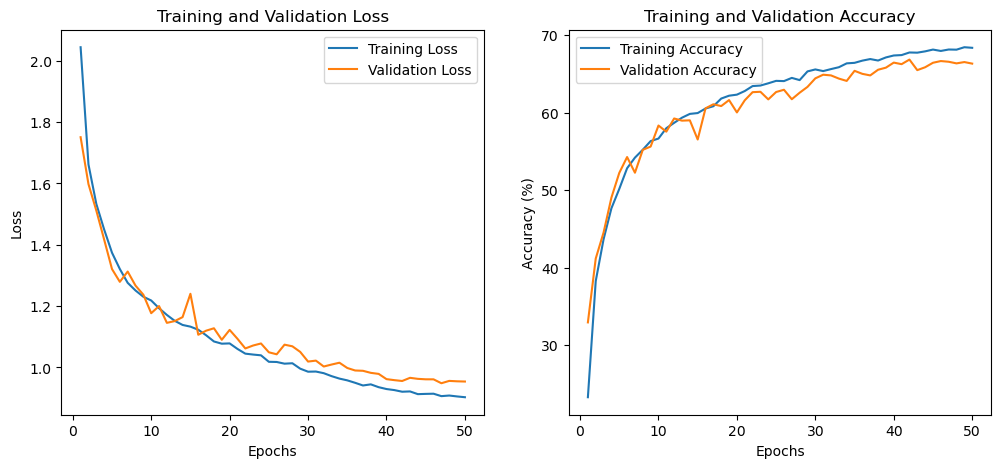

CPU times: user 3min 35s, sys: 2min 48s, total: 6min 24s
Wall time: 22min 29s


In [13]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = Baseline()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

baseline_0_0_1_SGD_train_losses = []
baseline_0_0_1_SGD_val_losses = []
baseline_0_0_1_SGD_train_accuracies = []
baseline_0_0_1_SGD_val_accuracies = []

for epoch in range(start_epoch, 50):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    baseline_0_0_1_SGD_train_losses.append(train_loss)
    baseline_0_0_1_SGD_val_losses.append(val_loss)
    baseline_0_0_1_SGD_train_accuracies.append(train_accuracy)
    baseline_0_0_1_SGD_val_accuracies.append(val_accuracy)

state_baseline_0_0_1_SGD,  acc_baseline_0_0_1_SGD = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_baseline_0_0_1_SGD)

plot_metrics(baseline_0_0_1_SGD_train_losses, baseline_0_0_1_SGD_val_losses, 
             baseline_0_0_1_SGD_train_accuracies, baseline_0_0_1_SGD_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [14]:
file_path_baseline_0_0_1_SGD = "./result_and_model/baseline_0_0_1_SGD_results.pkl"
model_state_path_baseline_0_0_1_SGD = "./result_and_model/baseline_0_0_1_SGD_model.pth"

with open(file_path_baseline_0_0_1_SGD, "wb") as f:
    pickle.dump({
        "train_losses": baseline_0_0_1_SGD_train_losses,
        "val_losses": baseline_0_0_1_SGD_val_losses,
        "train_accuracies": baseline_0_0_1_SGD_train_accuracies,
        "val_accuracies": baseline_0_0_1_SGD_val_accuracies,
        "best_accuracy": acc_baseline_0_0_1_SGD
    }, f)


torch.save(state_baseline_0_0_1_SGD, model_state_path_baseline_0_0_1_SGD)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.1, Optimizer = Adam

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=10.1, Loss=2.29]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:12<00:00,  6.13it/s, Acc=9.99, Loss=2.25]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=10.1, Loss=2.28]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=9.67, Loss=2.33]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=10.2, Loss=2.32]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=10.1, Loss=2.29]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=9.67, Loss=2.35]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=9.67, Loss=2.35]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=10.1, Loss=2.28]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=9.63, Loss=2.31]



Epoch: 10


Validation Epoch 10: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=9.67, Loss=2.32]



Epoch: 11


Validation Epoch 11: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=10.2, Loss=2.33]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:14<00:00, 22.02it/s, Acc=9.79, Loss=2.31
Validation Epoch 12: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=10.1, Loss=2.29]



Epoch: 13


Validation Epoch 13: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=9.63, Loss=2.3]



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:14<00:00, 22.04it/s, Acc=9.67, Loss=2.31
Validation Epoch 14: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=10.2, Loss=2.32]



Epoch: 15


Validation Epoch 15: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=10.1, Loss=2.28]



Epoch: 16


Validation Epoch 16: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=10.1, Loss=2.27]



Epoch: 17


Validation Epoch 17: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=10.1, Loss=2.29]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:14<00:00, 21.68it/s, Acc=9.81, Loss=2.31
Validation Epoch 18: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=9.73, Loss=2.35]



Epoch: 19


Validation Epoch 19: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=10.1, Loss=2.3]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:14<00:00, 21.94it/s, Acc=10.3, Loss=2.31
Validation Epoch 20: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=9.73, Loss=2.31]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:14<00:00, 21.98it/s, Acc=9.74, Loss=2.33
Validation Epoch 21: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=10.2, Loss=2.32]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:14<00:00, 21.72it/s, Acc=9.83, Loss=2.31
Validation Epoch 22: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=9.98, Loss=2.31]



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:14<00:00, 21.77it/s, Acc=9.86, Loss=2.29
Validation Epoch 23: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=9.63, Loss=2.29]



Epoch: 24


Validation Epoch 24: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=10.2, Loss=2.3]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:14<00:00, 22.12it/s, Acc=9.92, Loss=2.31
Validation Epoch 25: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=10.2, Loss=2.3]



Epoch: 26


Validation Epoch 26: 100%|█| 79/79 [00:13<00:00,  6.04it/s, Acc=10.1, Loss=2.28]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:14<00:00, 22.19it/s, Acc=10.3, Loss=2.33
Validation Epoch 27: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=9.63, Loss=2.31]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:14<00:00, 22.11it/s, Acc=10.1, Loss=2.29
Validation Epoch 28: 100%|█| 79/79 [00:13<00:00,  6.07it/s, Acc=9.67, Loss=2.31]



Epoch: 29


Validation Epoch 29: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=9.63, Loss=2.29]



Epoch: 30


Validation Epoch 30: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=9.73, Loss=2.31]



Epoch: 31


Validation Epoch 31: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=9.73, Loss=2.3]



Epoch: 32


Validation Epoch 32: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=9.99, Loss=2.29]



Epoch: 33


Validation Epoch 33: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=9.73, Loss=2.31]



Epoch: 34


Validation Epoch 34: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=9.98, Loss=2.3]



Epoch: 35


Validation Epoch 35: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=9.67, Loss=2.31]



Epoch: 36


Validation Epoch 36: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=9.98, Loss=2.3]



Epoch: 37


Validation Epoch 37: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=9.67, Loss=2.3]



Epoch: 38


Validation Epoch 38: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=9.67, Loss=2.3]



Epoch: 39


Validation Epoch 39: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=9.67, Loss=2.3]

Validation Accuracy:  10.25


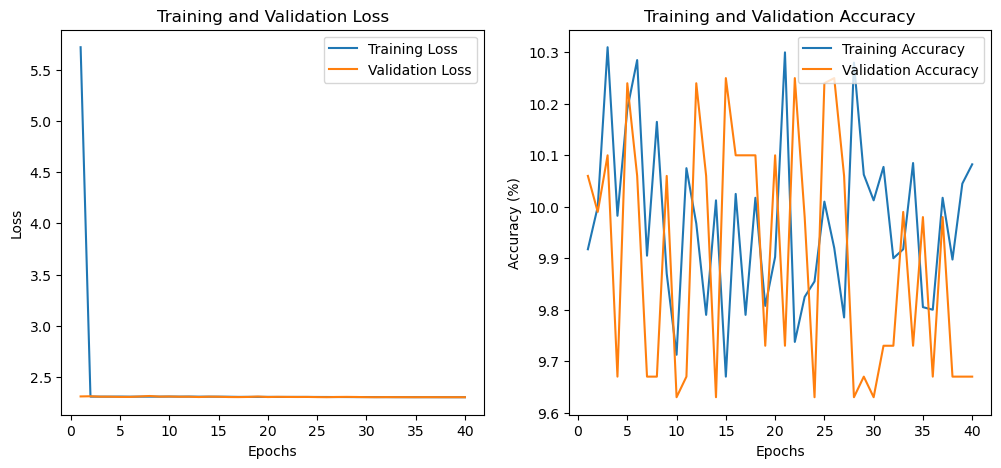

CPU times: user 3min 1s, sys: 2min 17s, total: 5min 18s
Wall time: 18min 6s


In [15]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = Baseline()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

baseline_0_1_Adam_train_losses = []
baseline_0_1_Adam_val_losses = []
baseline_0_1_Adam_train_accuracies = []
baseline_0_1_Adam_val_accuracies = []

for epoch in range(start_epoch, 40):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    baseline_0_1_Adam_train_losses.append(train_loss)
    baseline_0_1_Adam_val_losses.append(val_loss)
    baseline_0_1_Adam_train_accuracies.append(train_accuracy)
    baseline_0_1_Adam_val_accuracies.append(val_accuracy)

state_baseline_0_1_Adam,  acc_baseline_0_1_Adam = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_baseline_0_1_Adam)

plot_metrics(baseline_0_1_Adam_train_losses, baseline_0_1_Adam_val_losses, 
             baseline_0_1_Adam_train_accuracies, baseline_0_1_Adam_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [16]:
file_path_baseline_0_1_Adam = "./result_and_model/baseline_0_1_Adam_results.pkl"
model_state_path_baseline_0_1_Adam = "./result_and_model/baseline_0_1_Adam_model.pth"

with open(file_path_baseline_0_1_Adam, "wb") as f:
    pickle.dump({
        "train_losses": baseline_0_1_Adam_train_losses,
        "val_losses": baseline_0_1_Adam_val_losses,
        "train_accuracies": baseline_0_1_Adam_train_accuracies,
        "val_accuracies": baseline_0_1_Adam_val_accuracies,
        "best_accuracy": acc_baseline_0_1_Adam
    }, f)


torch.save(state_baseline_0_1_Adam, model_state_path_baseline_0_1_Adam)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = Adam

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=29.8, Loss=1.94]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=33.1, Loss=2.03]



Epoch: 2


Validation Epoch 2: 100%|███| 79/79 [00:12<00:00,  6.10it/s, Acc=33.4, Loss=2.2]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=34.2, Loss=1.95]



Epoch: 4


Validation Epoch 4: 100%|████| 79/79 [00:12<00:00,  6.09it/s, Acc=37, Loss=1.74]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:12<00:00,  6.08it/s, Acc=37.4, Loss=2.25]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=38.5, Loss=2.13]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=37.3, Loss=1.98]



Epoch: 8


Validation Epoch 8: 100%|████| 79/79 [00:13<00:00,  6.06it/s, Acc=40, Loss=2.04]



Epoch: 9


Validation Epoch 9: 100%|████| 79/79 [00:12<00:00,  6.08it/s, Acc=39, Loss=1.75]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:14<00:00, 22.03it/s, Acc=39.9, Loss=1.66
Validation Epoch 10: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=39.9, Loss=1.63]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:14<00:00, 21.93it/s, Acc=40.5, Loss=1.62
Validation Epoch 11: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=39.4, Loss=2.05]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:14<00:00, 21.92it/s, Acc=41.6, Loss=1.66
Validation Epoch 12: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=43.6, Loss=1.92]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:14<00:00, 21.81it/s, Acc=42.1, Loss=1.51
Validation Epoch 13: 100%|██| 79/79 [00:12<00:00,  6.08it/s, Acc=44.2, Loss=1.8]



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:14<00:00, 21.95it/s, Acc=43.1, Loss=1.63
Validation Epoch 14: 100%|█| 79/79 [00:13<00:00,  6.07it/s, Acc=43.2, Loss=1.53]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:14<00:00, 22.02it/s, Acc=43.8, Loss=1.47
Validation Epoch 15: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=44.3, Loss=1.71]



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:14<00:00, 21.81it/s, Acc=44.8, Loss=1.56
Validation Epoch 16: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=45.1, Loss=1.56]



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:14<00:00, 22.11it/s, Acc=45.8, Loss=1.14
Validation Epoch 17: 100%|███| 79/79 [00:12<00:00,  6.09it/s, Acc=47, Loss=1.78]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:14<00:00, 21.79it/s, Acc=45.9, Loss=1.36
Validation Epoch 18: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=45.5, Loss=1.27]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:14<00:00, 22.09it/s, Acc=46.3, Loss=1.54
Validation Epoch 19: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=46.7, Loss=1.42]



Epoch: 20


Validation Epoch 20: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=47.2, Loss=1.46]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:14<00:00, 22.03it/s, Acc=47.8, Loss=1.27
Validation Epoch 21: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=47.9, Loss=1.52]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:14<00:00, 22.03it/s, Acc=48.1, Loss=1.53
Validation Epoch 22: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=48.2, Loss=1.33]



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:14<00:00, 21.77it/s, Acc=48.1, Loss=1.25
Validation Epoch 23: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=48.6, Loss=1.7]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:14<00:00, 22.00it/s, Acc=48.9, Loss=1.29
Validation Epoch 24: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=50.1, Loss=1.4]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:14<00:00, 22.19it/s, Acc=49.8, Loss=1.42
Validation Epoch 25: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=50.6, Loss=1.27]



Epoch: 26


Validation Epoch 26: 100%|██| 79/79 [00:12<00:00,  6.12it/s, Acc=50.6, Loss=1.3]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:14<00:00, 22.17it/s, Acc=50.5, Loss=1.35
Validation Epoch 27: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=50.5, Loss=1.3]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:14<00:00, 22.19it/s, Acc=51.1, Loss=1.48
Validation Epoch 28: 100%|█| 79/79 [00:13<00:00,  6.06it/s, Acc=51.4, Loss=1.14]



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:14<00:00, 21.94it/s, Acc=51.5, Loss=1.28
Validation Epoch 29: 100%|█| 79/79 [00:13<00:00,  6.06it/s, Acc=51.7, Loss=1.14]



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:14<00:00, 21.09it/s, Acc=51.8, Loss=1.35
Validation Epoch 30: 100%|█| 79/79 [00:13<00:00,  6.08it/s, Acc=52.2, Loss=1.36]



Epoch: 31


Validation Epoch 31: 100%|█| 79/79 [00:13<00:00,  6.07it/s, Acc=52.6, Loss=1.27]



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:14<00:00, 21.87it/s, Acc=52.8, Loss=1.43
Validation Epoch 32: 100%|█| 79/79 [00:13<00:00,  6.06it/s, Acc=52.9, Loss=1.27]



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:14<00:00, 22.01it/s, Acc=53.1, Loss=1.29
Validation Epoch 33: 100%|█| 79/79 [00:13<00:00,  6.07it/s, Acc=52.8, Loss=1.35]



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:14<00:00, 21.94it/s, Acc=53.1, Loss=1.39
Validation Epoch 34: 100%|███| 79/79 [00:13<00:00,  6.07it/s, Acc=53, Loss=1.41]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:14<00:00, 21.81it/s, Acc=53.4, Loss=1.41
Validation Epoch 35: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=53.2, Loss=1.19]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:14<00:00, 22.05it/s, Acc=53.3, Loss=1.56
Validation Epoch 36: 100%|█| 79/79 [00:12<00:00,  6.12it/s, Acc=53.5, Loss=1.24]



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:14<00:00, 22.05it/s, Acc=53.7, Loss=1.22
Validation Epoch 37: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=52.9, Loss=1.55]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:14<00:00, 22.06it/s, Acc=53.6, Loss=1.25
Validation Epoch 38: 100%|█| 79/79 [00:13<00:00,  6.08it/s, Acc=53.2, Loss=1.15]



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:14<00:00, 21.97it/s, Acc=53.6, Loss=1.23
Validation Epoch 39: 100%|███| 79/79 [00:12<00:00,  6.09it/s, Acc=54, Loss=1.37]

Validation Accuracy:  53.97


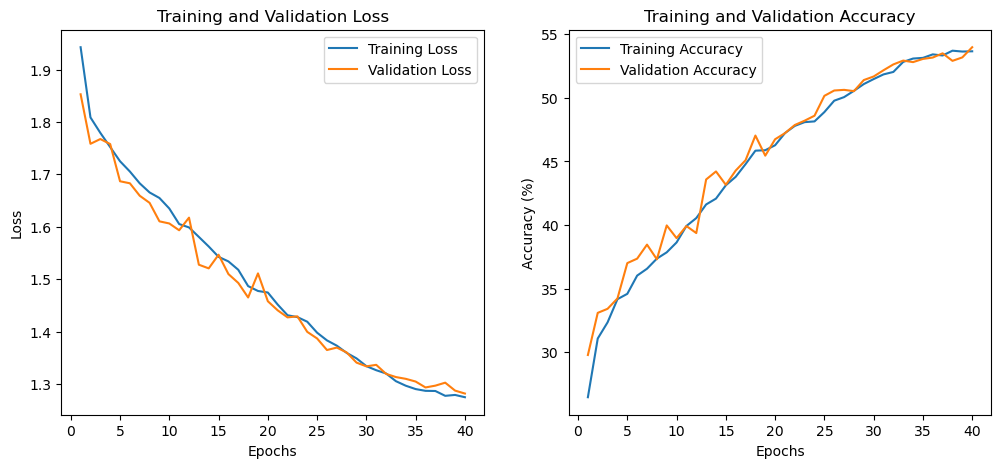

CPU times: user 3min 1s, sys: 2min 16s, total: 5min 17s
Wall time: 18min 8s


In [17]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = Baseline()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

baseline_0_0_1_Adam_train_losses = []
baseline_0_0_1_Adam_val_losses = []
baseline_0_0_1_Adam_train_accuracies = []
baseline_0_0_1_Adam_val_accuracies = []

for epoch in range(start_epoch, 40):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    baseline_0_0_1_Adam_train_losses.append(train_loss)
    baseline_0_0_1_Adam_val_losses.append(val_loss)
    baseline_0_0_1_Adam_train_accuracies.append(train_accuracy)
    baseline_0_0_1_Adam_val_accuracies.append(val_accuracy)

state_baseline_0_0_1_Adam,  acc_baseline_0_0_1_Adam = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_baseline_0_0_1_Adam)

plot_metrics(baseline_0_0_1_Adam_train_losses, baseline_0_0_1_Adam_val_losses, 
             baseline_0_0_1_Adam_train_accuracies, baseline_0_0_1_Adam_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [18]:
file_path_baseline_0_0_1_Adam = "./result_and_model/baseline_0_0_1_Adam_results.pkl"
model_state_path_baseline_0_0_1_Adam = "./result_and_model/baseline_0_0_1_Adam_model.pth"

with open(file_path_baseline_0_0_1_Adam, "wb") as f:
    pickle.dump({
        "train_losses": baseline_0_0_1_Adam_train_losses,
        "val_losses": baseline_0_0_1_Adam_val_losses,
        "train_accuracies": baseline_0_0_1_Adam_train_accuracies,
        "val_accuracies": baseline_0_0_1_Adam_val_accuracies,
        "best_accuracy": acc_baseline_0_0_1_Adam
    }, f)


torch.save(state_baseline_0_0_1_Adam, model_state_path_baseline_0_0_1_Adam)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.1, Optimizer = RMSprop

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=9.67, Loss=2.29]



Epoch: 1


Validation Epoch 1: 100%|████| 79/79 [00:13<00:00,  6.06it/s, Acc=10, Loss=2.29]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=9.72, Loss=2.33]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:13<00:00,  6.08it/s, Acc=9.99, Loss=2.33]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=10.2, Loss=2.29]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=10.1, Loss=2.24]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=9.97, Loss=2.34]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:13<00:00,  6.07it/s, Acc=10.1, Loss=2.32]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:13<00:00,  6.05it/s, Acc=9.98, Loss=2.35]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=9.63, Loss=2.27]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:14<00:00, 22.01it/s, Acc=9.97, Loss=2.31
Validation Epoch 10: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=10.2, Loss=2.36]



Epoch: 11


Validation Epoch 11: 100%|██| 79/79 [00:13<00:00,  6.07it/s, Acc=9.63, Loss=2.3]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:14<00:00, 22.07it/s, Acc=9.87, Loss=2.29
Validation Epoch 12: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=9.67, Loss=2.29]



Epoch: 13


Validation Epoch 13: 100%|█| 79/79 [00:13<00:00,  6.05it/s, Acc=9.67, Loss=2.32]



Epoch: 14


Validation Epoch 14: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=10.3, Loss=2.3]



Epoch: 15


Validation Epoch 15: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=10.1, Loss=2.26]



Epoch: 16


Validation Epoch 16: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=10.1, Loss=2.31]



Epoch: 17


Validation Epoch 17: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=10.2, Loss=2.32]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:14<00:00, 21.99it/s, Acc=9.82, Loss=2.31
Validation Epoch 18: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=9.98, Loss=2.34]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:14<00:00, 22.00it/s, Acc=9.79, Loss=2.31
Validation Epoch 19: 100%|███| 79/79 [00:12<00:00,  6.11it/s, Acc=10, Loss=2.33]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:14<00:00, 21.98it/s, Acc=9.96, Loss=2.31
Validation Epoch 20: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=9.73, Loss=2.32]



Epoch: 21


Validation Epoch 21: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=10.2, Loss=2.33]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:14<00:00, 21.91it/s, Acc=9.78, Loss=2.31
Validation Epoch 22: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=9.67, Loss=2.31]



Epoch: 23


Validation Epoch 23: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=9.63, Loss=2.32]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:14<00:00, 22.10it/s, Acc=10.2, Loss=2.31
Validation Epoch 24: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=10.1, Loss=2.3]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:14<00:00, 22.09it/s, Acc=9.99, Loss=2.31
Validation Epoch 25: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=10.2, Loss=2.3]



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:14<00:00, 22.05it/s, Acc=9.99, Loss=2.29
Validation Epoch 26: 100%|█| 79/79 [00:13<00:00,  6.07it/s, Acc=10.1, Loss=2.27]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:14<00:00, 22.07it/s, Acc=10.1, Loss=2.33
Validation Epoch 27: 100%|█| 79/79 [00:13<00:00,  6.08it/s, Acc=9.63, Loss=2.32]



Epoch: 28


Validation Epoch 28: 100%|██| 79/79 [00:13<00:00,  6.05it/s, Acc=10.1, Loss=2.3]



Epoch: 29


Validation Epoch 29: 100%|██| 79/79 [00:13<00:00,  6.08it/s, Acc=9.63, Loss=2.3]



Epoch: 30


Validation Epoch 30: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=10.2, Loss=2.3]



Epoch: 31


Validation Epoch 31: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=9.73, Loss=2.29]



Epoch: 32


Validation Epoch 32: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=9.99, Loss=2.29]



Epoch: 33


Validation Epoch 33: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=9.73, Loss=2.31]



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:14<00:00, 22.08it/s, Acc=19.8, Loss=1.81
Validation Epoch 34: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=26.6, Loss=1.85]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:14<00:00, 21.91it/s, Acc=30.2, Loss=1.86
Validation Epoch 35: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=29.9, Loss=2.2]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:14<00:00, 22.02it/s, Acc=34.1, Loss=1.82
Validation Epoch 36: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=34.4, Loss=1.64]



Epoch: 37


Validation Epoch 37: 100%|███| 79/79 [00:12<00:00,  6.08it/s, Acc=37, Loss=1.96]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:14<00:00, 22.01it/s, Acc=39.1, Loss=1.53
Validation Epoch 38: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=40.1, Loss=1.52]



Epoch: 39


Validation Epoch 39: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=40.7, Loss=1.65]

Validation Accuracy:  40.7


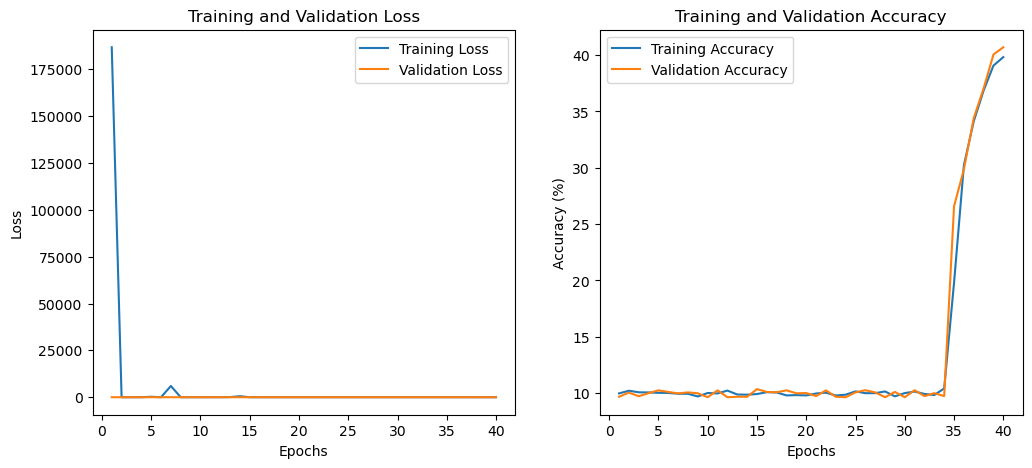

CPU times: user 3min, sys: 2min 17s, total: 5min 18s
Wall time: 18min 9s


In [19]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = Baseline()
net.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.1, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

baseline_0_1_RMSprop_train_losses = []
baseline_0_1_RMSprop_val_losses = []
baseline_0_1_RMSprop_train_accuracies = []
baseline_0_1_RMSprop_val_accuracies = []

for epoch in range(start_epoch, 40):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    baseline_0_1_RMSprop_train_losses.append(train_loss)
    baseline_0_1_RMSprop_val_losses.append(val_loss)
    baseline_0_1_RMSprop_train_accuracies.append(train_accuracy)
    baseline_0_1_RMSprop_val_accuracies.append(val_accuracy)

state_baseline_0_1_RMSprop,  acc_baseline_0_1_RMSprop = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_baseline_0_1_RMSprop)

plot_metrics(baseline_0_1_RMSprop_train_losses, baseline_0_1_RMSprop_val_losses, 
             baseline_0_1_RMSprop_train_accuracies, baseline_0_1_RMSprop_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [20]:
file_path_baseline_0_1_RMSprop = "./result_and_model/baseline_0_1_RMSprop_results.pkl"
model_state_path_baseline_0_1_RMSprop = "./result_and_model/baseline_0_1_RMSprop_model.pth"

with open(file_path_baseline_0_1_RMSprop, "wb") as f:
    pickle.dump({
        "train_losses": baseline_0_1_RMSprop_train_losses,
        "val_losses": baseline_0_1_RMSprop_val_losses,
        "train_accuracies": baseline_0_1_RMSprop_train_accuracies,
        "val_accuracies": baseline_0_1_RMSprop_val_accuracies,
        "best_accuracy": acc_baseline_0_1_RMSprop
    }, f)


torch.save(state_baseline_0_1_RMSprop, model_state_path_baseline_0_1_RMSprop)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = RMSprop

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=29.3, Loss=1.83]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:12<00:00,  6.08it/s, Acc=33.5, Loss=1.92]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=21.3, Loss=2.06]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=26.6, Loss=1.95]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:12<00:00,  6.08it/s, Acc=24.8, Loss=2.67]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:12<00:00,  6.11it/s, Acc=27.3, Loss=2.01]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=33.7, Loss=1.76]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=20.9, Loss=2.07]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:13<00:00,  6.02it/s, Acc=37.2, Loss=2.14]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:12<00:00,  6.09it/s, Acc=38.9, Loss=1.93]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:14<00:00, 22.06it/s, Acc=41.2, Loss=1.68
Validation Epoch 10: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=43.4, Loss=1.69]



Epoch: 11


Validation Epoch 11: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=41.8, Loss=1.84]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:14<00:00, 22.06it/s, Acc=43.5, Loss=1.64
Validation Epoch 12: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=39.9, Loss=1.33]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:14<00:00, 22.01it/s, Acc=44.5, Loss=1.52
Validation Epoch 13: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=44.7, Loss=1.4]



Epoch: 14


Validation Epoch 14: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=45.2, Loss=1.49]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:14<00:00, 22.05it/s, Acc=46.7, Loss=1.37
Validation Epoch 15: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=48.1, Loss=1.95]



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:14<00:00, 22.03it/s, Acc=47.8, Loss=1.84
Validation Epoch 16: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=45.6, Loss=1.69]



Epoch: 17


Validation Epoch 17: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=47.6, Loss=1.36]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:14<00:00, 22.02it/s, Acc=49.7, Loss=1.33
Validation Epoch 18: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=49.5, Loss=1.47]



Epoch: 19


Validation Epoch 19: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=47.3, Loss=1.68]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:14<00:00, 22.07it/s, Acc=51.9, Loss=1.19
Validation Epoch 20: 100%|███| 79/79 [00:12<00:00,  6.11it/s, Acc=50, Loss=1.49]



Epoch: 21


Validation Epoch 21: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=51.4, Loss=1.44]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:14<00:00, 21.93it/s, Acc=53.9, Loss=1.57
Validation Epoch 22: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=54.4, Loss=1.67]



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:14<00:00, 21.95it/s, Acc=54.3, Loss=1.17
Validation Epoch 23: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=52.3, Loss=1.41]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:14<00:00, 22.07it/s, Acc=55.4, Loss=1.14
Validation Epoch 24: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=54.3, Loss=1.26]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:14<00:00, 22.08it/s, Acc=56.2, Loss=1.26
Validation Epoch 25: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=57.2, Loss=1.26]



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:14<00:00, 21.91it/s, Acc=56.8, Loss=1.17
Validation Epoch 26: 100%|████| 79/79 [00:12<00:00,  6.10it/s, Acc=56.3, Loss=1]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:14<00:00, 22.06it/s, Acc=57.7, Loss=1.47
Validation Epoch 27: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=56.1, Loss=1.26]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:14<00:00, 22.06it/s, Acc=58.5, Loss=1.57
Validation Epoch 28: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=57.2, Loss=1.35]



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:14<00:00, 21.99it/s, Acc=59.2, Loss=1.21
Validation Epoch 29: 100%|██| 79/79 [00:12<00:00,  6.08it/s, Acc=58.6, Loss=1.3]



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:14<00:00, 22.06it/s, Acc=59.3, Loss=1.04
Validation Epoch 30: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=57.4, Loss=1.28]



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:14<00:00, 22.04it/s, Acc=60.2, Loss=1.23
Validation Epoch 31: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=58.9, Loss=1.07]



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:14<00:00, 22.08it/s, Acc=60.9, Loss=1.09
Validation Epoch 32: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=58.6, Loss=1.38]



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:14<00:00, 22.03it/s, Acc=60.8, Loss=0.91
Validation Epoch 33: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=60.5, Loss=1.05]



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:14<00:00, 21.97it/s, Acc=61.5, Loss=1.13
Validation Epoch 34: 100%|█| 79/79 [00:12<00:00,  6.11it/s, Acc=60.9, Loss=1.32]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:14<00:00, 22.07it/s, Acc=61.7, Loss=1.29
Validation Epoch 35: 100%|██| 79/79 [00:12<00:00,  6.10it/s, Acc=60.7, Loss=1.4]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:14<00:00, 22.06it/s, Acc=61.9, Loss=1.2]
Validation Epoch 36: 100%|█| 79/79 [00:12<00:00,  6.09it/s, Acc=60.7, Loss=0.945



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:14<00:00, 22.01it/s, Acc=61.7, Loss=0.85
Validation Epoch 37: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=61.4, Loss=1.53]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:14<00:00, 21.99it/s, Acc=62.4, Loss=1.02
Validation Epoch 38: 100%|█| 79/79 [00:12<00:00,  6.10it/s, Acc=61.6, Loss=1.29]



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:14<00:00, 22.01it/s, Acc=62.1, Loss=0.98
Validation Epoch 39: 100%|█| 79/79 [00:12<00:00,  6.08it/s, Acc=61.3, Loss=1.25]

Validation Accuracy:  61.55


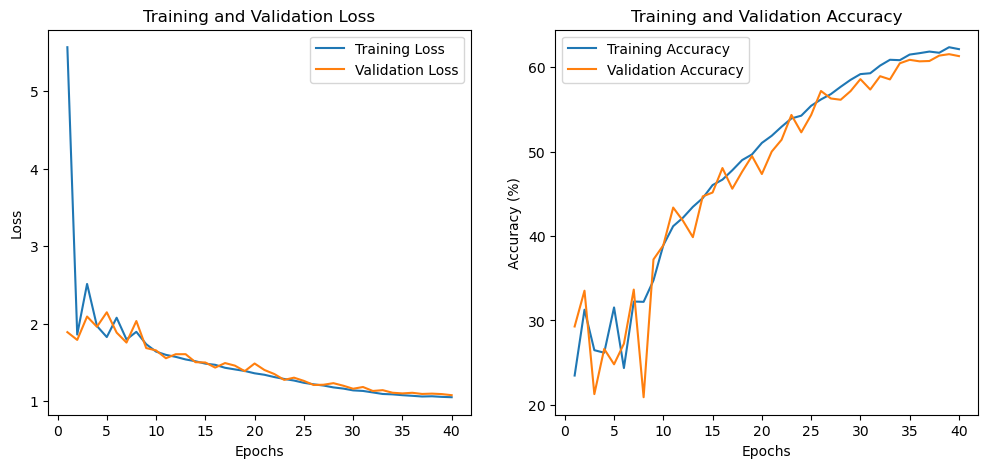

CPU times: user 2min 59s, sys: 2min 18s, total: 5min 18s
Wall time: 18min 7s


In [21]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = Baseline()
net.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

baseline_0_0_1_RMSprop_train_losses = []
baseline_0_0_1_RMSprop_val_losses = []
baseline_0_0_1_RMSprop_train_accuracies = []
baseline_0_0_1_RMSprop_val_accuracies = []

for epoch in range(start_epoch, 40):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    baseline_0_0_1_RMSprop_train_losses.append(train_loss)
    baseline_0_0_1_RMSprop_val_losses.append(val_loss)
    baseline_0_0_1_RMSprop_train_accuracies.append(train_accuracy)
    baseline_0_0_1_RMSprop_val_accuracies.append(val_accuracy)

state_baseline_0_0_1_RMSprop,  acc_baseline_0_0_1_RMSprop = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_baseline_0_0_1_RMSprop)

plot_metrics(baseline_0_0_1_RMSprop_train_losses, baseline_0_0_1_RMSprop_val_losses, 
             baseline_0_0_1_RMSprop_train_accuracies, baseline_0_0_1_RMSprop_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [22]:
file_path_baseline_0_0_1_RMSprop = "./result_and_model/baseline_0_0_1_RMSprop_results.pkl"
model_state_path_baseline_0_0_1_RMSprop = "./result_and_model/baseline_0_0_1_RMSprop_model.pth"

with open(file_path_baseline_0_0_1_RMSprop, "wb") as f:
    pickle.dump({
        "train_losses": baseline_0_0_1_RMSprop_train_losses,
        "val_losses": baseline_0_0_1_RMSprop_val_losses,
        "train_accuracies": baseline_0_0_1_RMSprop_train_accuracies,
        "val_accuracies": baseline_0_0_1_RMSprop_val_accuracies,
        "best_accuracy": acc_baseline_0_0_1_RMSprop
    }, f)


torch.save(state_baseline_0_0_1_RMSprop, model_state_path_baseline_0_0_1_RMSprop)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.


#### Manual Grid Search for AlexNet


Testing: Learning Rate = 0.1, Optimizer = SGD

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=18.6, Loss=2.21]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:13<00:00,  5.92it/s, Acc=21.9, Loss=2.55]



Epoch: 2


Validation Epoch 2: 100%|█████| 79/79 [00:13<00:00,  5.82it/s, Acc=28.2, Loss=2]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=32.7, Loss=1.72]



Epoch: 4


Validation Epoch 4: 100%|████| 79/79 [00:13<00:00,  5.91it/s, Acc=35, Loss=2.08]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=36.8, Loss=1.75]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:13<00:00,  5.92it/s, Acc=34.9, Loss=1.94]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=40.3, Loss=1.64]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=42.6, Loss=1.62]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=43.7, Loss=1.77]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=39.5, Loss=1.38
Validation Epoch 10: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=42.6, Loss=1.61]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=41.4, Loss=1.29
Validation Epoch 11: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=44.3, Loss=1.59]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:22<00:00, 13.77it/s, Acc=41.5, Loss=1.61
Validation Epoch 12: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=40.8, Loss=1.63]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:22<00:00, 13.85it/s, Acc=42.6, Loss=1.56
Validation Epoch 13: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=45.2, Loss=1.39]



Epoch: 14


Validation Epoch 14: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=48.5, Loss=1.26]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:22<00:00, 13.85it/s, Acc=45.7, Loss=1.51
Validation Epoch 15: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=49.2, Loss=1.15]



Epoch: 16


Validation Epoch 16: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=49.3, Loss=1.43]



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:22<00:00, 13.81it/s, Acc=47.8, Loss=1.49
Validation Epoch 17: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=49.4, Loss=1.49]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:22<00:00, 13.82it/s, Acc=47.9, Loss=1.28
Validation Epoch 18: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=49.1, Loss=1.47]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=50.5, Loss=1.69
Validation Epoch 19: 100%|████| 79/79 [00:13<00:00,  5.91it/s, Acc=46.2, Loss=2]



Epoch: 20


Validation Epoch 20: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=53.3, Loss=1.34]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=50.6, Loss=1.44
Validation Epoch 21: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=52.9, Loss=1.57]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=53.2, Loss=1.33
Validation Epoch 22: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=53.7, Loss=1.01]



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:22<00:00, 13.87it/s, Acc=53.7, Loss=1.34
Validation Epoch 23: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=57.3, Loss=1.1]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:22<00:00, 13.82it/s, Acc=55.7, Loss=1.37
Validation Epoch 24: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=54.5, Loss=1.42]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:22<00:00, 13.89it/s, Acc=54.2, Loss=1.24
Validation Epoch 25: 100%|█| 79/79 [00:13<00:00,  5.93it/s, Acc=57.9, Loss=1.17]



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=56.4, Loss=1.18
Validation Epoch 26: 100%|███| 79/79 [00:13<00:00,  5.91it/s, Acc=56, Loss=1.23]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=57.9, Loss=1.08
Validation Epoch 27: 100%|█| 79/79 [00:13<00:00,  5.93it/s, Acc=56.5, Loss=1.51]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:22<00:00, 13.89it/s, Acc=58.8, Loss=1.32
Validation Epoch 28: 100%|█| 79/79 [00:13<00:00,  5.93it/s, Acc=56.4, Loss=0.906



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:22<00:00, 13.89it/s, Acc=58.6, Loss=1.24
Validation Epoch 29: 100%|█| 79/79 [00:13<00:00,  5.93it/s, Acc=61.3, Loss=0.994



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:22<00:00, 13.88it/s, Acc=59.6, Loss=1.21
Validation Epoch 30: 100%|█| 79/79 [00:13<00:00,  5.93it/s, Acc=61.2, Loss=0.934



Epoch: 31


Validation Epoch 31: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=60.8, Loss=1.11]



Epoch: 32


Validation Epoch 32: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=63.6, Loss=1.23]



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:28<00:00, 11.02it/s, Acc=63.5, Loss=0.83
Validation Epoch 33: 100%|█| 79/79 [00:13<00:00,  5.75it/s, Acc=62.9, Loss=0.817



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:27<00:00, 11.18it/s, Acc=64.5, Loss=1.05
Validation Epoch 34: 100%|█| 79/79 [00:13<00:00,  5.76it/s, Acc=66.8, Loss=1.31]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:27<00:00, 11.43it/s, Acc=64.5, Loss=0.95
Validation Epoch 35: 100%|█| 79/79 [00:13<00:00,  5.78it/s, Acc=66.5, Loss=0.95]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:26<00:00, 11.62it/s, Acc=65.5, Loss=0.88
Validation Epoch 36: 100%|█| 79/79 [00:13<00:00,  5.79it/s, Acc=63.6, Loss=1.21]



Epoch: 37


Validation Epoch 37: 100%|█| 79/79 [00:13<00:00,  5.82it/s, Acc=67.5, Loss=1.06]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:25<00:00, 12.23it/s, Acc=67.5, Loss=1.2]
Validation Epoch 38: 100%|█| 79/79 [00:13<00:00,  5.84it/s, Acc=67.1, Loss=0.711



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:25<00:00, 12.42it/s, Acc=68.6, Loss=0.99
Validation Epoch 39: 100%|█| 79/79 [00:13<00:00,  5.85it/s, Acc=70.1, Loss=1.07]



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:24<00:00, 12.71it/s, Acc=69.5, Loss=0.82
Validation Epoch 40: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=69.3, Loss=0.915



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:24<00:00, 12.87it/s, Acc=69.9, Loss=0.84
Validation Epoch 41: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=71.7, Loss=1.01]



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:24<00:00, 13.02it/s, Acc=71.3, Loss=0.80
Validation Epoch 42: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=67.2, Loss=1.33]



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:24<00:00, 13.03it/s, Acc=72, Loss=0.961]
Validation Epoch 43: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=71.2, Loss=0.731



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:23<00:00, 13.16it/s, Acc=72.6, Loss=0.90
Validation Epoch 44: 100%|█| 79/79 [00:13<00:00,  5.84it/s, Acc=73.4, Loss=0.549



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:23<00:00, 13.26it/s, Acc=73.6, Loss=0.65
Validation Epoch 45: 100%|█| 79/79 [00:13<00:00,  5.85it/s, Acc=72.5, Loss=0.926



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:23<00:00, 13.35it/s, Acc=74.4, Loss=1.17
Validation Epoch 46: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=71.1, Loss=0.39]



Epoch: 47


Validation Epoch 47: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=74, Loss=0.794]



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:23<00:00, 13.46it/s, Acc=75.4, Loss=0.73
Validation Epoch 48: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=74.1, Loss=0.581



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:23<00:00, 13.46it/s, Acc=76.6, Loss=0.70
Validation Epoch 49: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=76.4, Loss=0.809



Epoch: 50


Validation Epoch 50: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=75, Loss=0.647]



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:23<00:00, 13.46it/s, Acc=77.9, Loss=0.58
Validation Epoch 51: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=77, Loss=0.848]



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:23<00:00, 13.44it/s, Acc=78.5, Loss=0.61
Validation Epoch 52: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=76.9, Loss=0.455



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:23<00:00, 13.47it/s, Acc=79, Loss=0.772]
Validation Epoch 53: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=77.1, Loss=0.678



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:23<00:00, 13.47it/s, Acc=79.8, Loss=0.70
Validation Epoch 54: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=78.5, Loss=0.499



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:23<00:00, 13.47it/s, Acc=80.6, Loss=0.64
Validation Epoch 55: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=78.9, Loss=0.597



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:23<00:00, 13.38it/s, Acc=81.3, Loss=0.48
Validation Epoch 56: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=79.5, Loss=0.548



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:23<00:00, 13.40it/s, Acc=81.9, Loss=0.58
Validation Epoch 57: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=79.2, Loss=0.358



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:23<00:00, 13.42it/s, Acc=82.6, Loss=0.29
Validation Epoch 58: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=78.6, Loss=1.1]



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:23<00:00, 13.38it/s, Acc=82.8, Loss=0.52
Validation Epoch 59: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=78.9, Loss=0.559



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:23<00:00, 13.42it/s, Acc=84.3, Loss=0.37
Validation Epoch 60: 100%|███| 79/79 [00:13<00:00,  5.90it/s, Acc=80, Loss=0.71]



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:23<00:00, 13.44it/s, Acc=84.3, Loss=0.46
Validation Epoch 61: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=80.9, Loss=0.51]



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:23<00:00, 13.47it/s, Acc=85.3, Loss=0.38
Validation Epoch 62: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=81.4, Loss=0.701



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:23<00:00, 13.49it/s, Acc=85.5, Loss=0.63
Validation Epoch 63: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=82.2, Loss=0.505



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:23<00:00, 13.50it/s, Acc=86.2, Loss=0.41
Validation Epoch 64: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=82.8, Loss=0.351



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:23<00:00, 13.49it/s, Acc=86.9, Loss=0.57
Validation Epoch 65: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=82.8, Loss=0.521



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:23<00:00, 13.55it/s, Acc=87.6, Loss=0.28
Validation Epoch 66: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=83.1, Loss=0.476



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:23<00:00, 13.54it/s, Acc=88, Loss=0.458]
Validation Epoch 67: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=82.7, Loss=0.518



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:23<00:00, 13.57it/s, Acc=88.9, Loss=0.23
Validation Epoch 68: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=83.5, Loss=0.314



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:23<00:00, 13.59it/s, Acc=89.3, Loss=0.28
Validation Epoch 69: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.4, Loss=0.103



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:23<00:00, 13.60it/s, Acc=89.6, Loss=0.33
Validation Epoch 70: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=84.2, Loss=0.697



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:22<00:00, 13.62it/s, Acc=90.4, Loss=0.27
Validation Epoch 71: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=83.7, Loss=0.212



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:22<00:00, 13.63it/s, Acc=90.8, Loss=0.27
Validation Epoch 72: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=84.3, Loss=0.391



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:22<00:00, 13.63it/s, Acc=91.5, Loss=0.12
Validation Epoch 73: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.5, Loss=0.261



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:22<00:00, 13.63it/s, Acc=91.9, Loss=0.15
Validation Epoch 74: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=85, Loss=0.253]



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:22<00:00, 13.63it/s, Acc=92.6, Loss=0.17
Validation Epoch 75: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=85, Loss=0.181]



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:22<00:00, 13.65it/s, Acc=93.1, Loss=0.31
Validation Epoch 76: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85.7, Loss=0.61]



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:22<00:00, 13.66it/s, Acc=93.5, Loss=0.26
Validation Epoch 77: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85.8, Loss=0.156



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:22<00:00, 13.69it/s, Acc=94.1, Loss=0.22
Validation Epoch 78: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85.9, Loss=0.509



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:22<00:00, 13.70it/s, Acc=94.2, Loss=0.22
Validation Epoch 79: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85.5, Loss=0.212



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:22<00:00, 13.73it/s, Acc=94.9, Loss=0.15
Validation Epoch 80: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=85.8, Loss=0.416



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:22<00:00, 13.75it/s, Acc=95.3, Loss=0.13
Validation Epoch 81: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85.8, Loss=0.23]



Epoch: 82


 Training Epoch 82: 100%|█| 313/313 [00:22<00:00, 13.71it/s, Acc=95.6, Loss=0.10
Validation Epoch 82: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=86.3, Loss=0.187



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:22<00:00, 13.77it/s, Acc=95.9, Loss=0.22
Validation Epoch 83: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=86.4, Loss=0.059



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:22<00:00, 13.78it/s, Acc=96.1, Loss=0.16
Validation Epoch 84: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.7, Loss=0.017



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:22<00:00, 13.80it/s, Acc=96.2, Loss=0.06
Validation Epoch 85: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=86.8, Loss=0.348



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:22<00:00, 13.84it/s, Acc=96.5, Loss=0.05
Validation Epoch 86: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.7, Loss=0.252



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:22<00:00, 13.77it/s, Acc=96.5, Loss=0.08
Validation Epoch 87: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.6, Loss=0.39]



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=96.5, Loss=0.12
Validation Epoch 88: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=86.6, Loss=0.42]



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:22<00:00, 13.85it/s, Acc=96.7, Loss=0.03
Validation Epoch 89: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=86.5, Loss=0.534


Validation Accuracy:  86.76


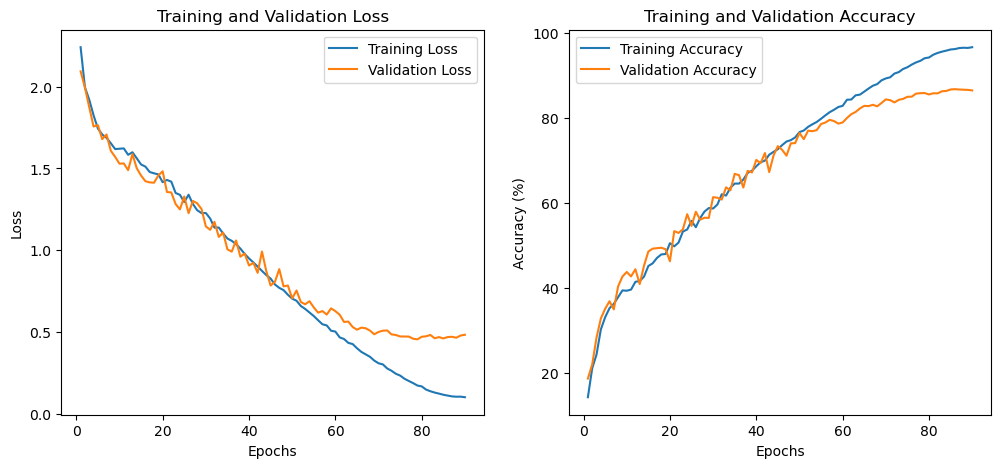

CPU times: user 9min 26s, sys: 3min 46s, total: 13min 13s
Wall time: 55min 4s


In [23]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = AlexNet()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=90)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

alexnet_0_1_SGD_train_losses = []
alexnet_0_1_SGD_val_losses = []
alexnet_0_1_SGD_train_accuracies = []
alexnet_0_1_SGD_val_accuracies = []


for epoch in range(start_epoch, 90):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    alexnet_0_1_SGD_train_losses.append(train_loss)
    alexnet_0_1_SGD_val_losses.append(val_loss)
    alexnet_0_1_SGD_train_accuracies.append(train_accuracy)
    alexnet_0_1_SGD_val_accuracies.append(val_accuracy)

state_alexnet_0_1_SGD,  acc_alexnet_0_1_SGD = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_alexnet_0_1_SGD)

plot_metrics(alexnet_0_1_SGD_train_losses, alexnet_0_1_SGD_val_losses, 
             alexnet_0_1_SGD_train_accuracies, alexnet_0_1_SGD_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [24]:
file_path_alexnet_0_1_SGD = "./result_and_model/alexnet_0_1_SGD_results.pkl"
model_state_path_alexnet_0_1_SGD = "./result_and_model/alexnet_0_1_SGD_model.pth"

with open(file_path_alexnet_0_1_SGD, "wb") as f:
    pickle.dump({
        "train_losses": alexnet_0_1_SGD_train_losses,
        "val_losses": alexnet_0_1_SGD_val_losses,
        "train_accuracies": alexnet_0_1_SGD_train_accuracies,
        "val_accuracies": alexnet_0_1_SGD_val_accuracies,
        "best_accuracy": acc_alexnet_0_1_SGD
    }, f)


torch.save(state_alexnet_0_1_SGD, model_state_path_alexnet_0_1_SGD)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = SGD

Epoch: 0


Validation Epoch 0: 100%|████| 79/79 [00:13<00:00,  5.90it/s, Acc=29, Loss=1.88]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=43.4, Loss=1.71]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=51.8, Loss=1.21]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=59.3, Loss=1.43]



Epoch: 4


 Training Epoch 4: 100%|█| 313/313 [00:22<00:00, 13.88it/s, Acc=62.4, Loss=0.711
Validation Epoch 4: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=64.8, Loss=1.21]



Epoch: 5


Validation Epoch 5: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=69.5, Loss=0.604]



Epoch: 6


Validation Epoch 6: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=72.3, Loss=0.866]



Epoch: 7


Validation Epoch 7: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=73.2, Loss=0.658]



Epoch: 8


 Training Epoch 8: 100%|█| 313/313 [00:22<00:00, 13.89it/s, Acc=75.6, Loss=0.661
Validation Epoch 8: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=73.7, Loss=0.388]



Epoch: 9


 Training Epoch 9: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=77.5, Loss=0.434
Validation Epoch 9: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=75.3, Loss=0.56]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:22<00:00, 13.89it/s, Acc=78.9, Loss=0.41
Validation Epoch 10: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=76.9, Loss=0.553



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:22<00:00, 13.82it/s, Acc=80.6, Loss=0.56
Validation Epoch 11: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=78.6, Loss=0.736



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:22<00:00, 13.84it/s, Acc=81.2, Loss=0.77
Validation Epoch 12: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=78.6, Loss=0.522



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=82.5, Loss=0.54
Validation Epoch 13: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=79.1, Loss=0.576



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=83.5, Loss=0.39
Validation Epoch 14: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=81.1, Loss=0.545



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=84.6, Loss=0.45
Validation Epoch 15: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=80.6, Loss=0.563



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=85.3, Loss=0.37
Validation Epoch 16: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=79.5, Loss=0.298



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=85.8, Loss=0.32
Validation Epoch 17: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=80.4, Loss=0.354



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=86.6, Loss=0.37
Validation Epoch 18: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=81.5, Loss=0.518



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:22<00:00, 13.91it/s, Acc=87.4, Loss=0.43
Validation Epoch 19: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=82, Loss=0.194]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:22<00:00, 13.87it/s, Acc=88.2, Loss=0.40
Validation Epoch 20: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=81.2, Loss=0.234



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=88.5, Loss=0.20
Validation Epoch 21: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=83.4, Loss=0.165



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:22<00:00, 13.89it/s, Acc=89.1, Loss=0.33
Validation Epoch 22: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=82.7, Loss=0.131



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:22<00:00, 13.91it/s, Acc=90, Loss=0.173]
Validation Epoch 23: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.1, Loss=0.284



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:22<00:00, 13.82it/s, Acc=90.5, Loss=0.39
Validation Epoch 24: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=82.6, Loss=0.47]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:22<00:00, 13.91it/s, Acc=90.5, Loss=0.36
Validation Epoch 25: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=83.2, Loss=0.197



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=91.1, Loss=0.16
Validation Epoch 26: 100%|█| 79/79 [00:13<00:00,  5.93it/s, Acc=83.4, Loss=0.262



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=91.8, Loss=0.17
Validation Epoch 27: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=83.6, Loss=0.408



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=91.9, Loss=0.26
Validation Epoch 28: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=83.6, Loss=0.399



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:22<00:00, 13.92it/s, Acc=92.7, Loss=0.34
Validation Epoch 29: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=83.2, Loss=0.194



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=92.7, Loss=0.10
Validation Epoch 30: 100%|█| 79/79 [00:13<00:00,  5.94it/s, Acc=83.4, Loss=0.218



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:22<00:00, 13.95it/s, Acc=93.4, Loss=0.12
Validation Epoch 31: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=82.7, Loss=0.31]



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=93.8, Loss=0.10
Validation Epoch 32: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=83.6, Loss=0.475



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:22<00:00, 13.95it/s, Acc=94.1, Loss=0.06
Validation Epoch 33: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=83.4, Loss=0.154



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:22<00:00, 13.95it/s, Acc=94.5, Loss=0.11
Validation Epoch 34: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=83.5, Loss=0.279



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:22<00:00, 13.88it/s, Acc=95, Loss=0.141]
Validation Epoch 35: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.1, Loss=0.167



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=95.1, Loss=0.10
Validation Epoch 36: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.4, Loss=0.171



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=95.5, Loss=0.08
Validation Epoch 37: 100%|███| 79/79 [00:13<00:00,  5.91it/s, Acc=84, Loss=0.14]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:22<00:00, 13.96it/s, Acc=95.7, Loss=0.32
Validation Epoch 38: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85, Loss=0.0952]



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:22<00:00, 13.96it/s, Acc=96.1, Loss=0.04
Validation Epoch 39: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=83.5, Loss=0.155



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:22<00:00, 13.96it/s, Acc=96.2, Loss=0.05
Validation Epoch 40: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=84, Loss=0.428]



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:22<00:00, 13.96it/s, Acc=96.7, Loss=0.14
Validation Epoch 41: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=84.8, Loss=0.293



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=96.9, Loss=0.09
Validation Epoch 42: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.4, Loss=0.378



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=96.9, Loss=0.11
Validation Epoch 43: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.5, Loss=0.083



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=97.2, Loss=0.06
Validation Epoch 44: 100%|██| 79/79 [00:13<00:00,  5.92it/s, Acc=85, Loss=0.686]



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=97.4, Loss=0.05
Validation Epoch 45: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85, Loss=0.0667]



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:22<00:00, 13.95it/s, Acc=97.5, Loss=0.25
Validation Epoch 46: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=85.2, Loss=0.017



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:22<00:00, 13.96it/s, Acc=97.8, Loss=0.01
Validation Epoch 47: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=84.5, Loss=0.182



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:22<00:00, 13.95it/s, Acc=97.9, Loss=0.04
Validation Epoch 48: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.4, Loss=0.297



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=98.2, Loss=0.14
Validation Epoch 49: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=84.2, Loss=0.793



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=98.2, Loss=0.05
Validation Epoch 50: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85.3, Loss=0.402



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=98.5, Loss=0.09
Validation Epoch 51: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=85.4, Loss=0.197



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:22<00:00, 13.95it/s, Acc=98.6, Loss=0.06
Validation Epoch 52: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=85.7, Loss=0.194



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:22<00:00, 13.89it/s, Acc=98.8, Loss=0.12
Validation Epoch 53: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=85.5, Loss=0.209



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:22<00:00, 13.89it/s, Acc=98.9, Loss=0.02
Validation Epoch 54: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=85.2, Loss=0.349



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:22<00:00, 13.88it/s, Acc=99.2, Loss=0.06
Validation Epoch 55: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=86, Loss=0.327]



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=99, Loss=0.0213
Validation Epoch 56: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=86.3, Loss=0.159



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=99.2, Loss=0.04
Validation Epoch 57: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.2, Loss=0.084



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=99.3, Loss=0.01
Validation Epoch 58: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86, Loss=0.0642]



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=99.4, Loss=0.02
Validation Epoch 59: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=85.6, Loss=0.058



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:22<00:00, 13.92it/s, Acc=99.5, Loss=0.01
Validation Epoch 60: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=86, Loss=0.137]



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:22<00:00, 13.85it/s, Acc=99.5, Loss=0.01
Validation Epoch 61: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=86, Loss=0.167]



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=99.6, Loss=0.01
Validation Epoch 62: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=86, Loss=0.216]



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:22<00:00, 13.91it/s, Acc=99.7, Loss=0.01
Validation Epoch 63: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=85.8, Loss=0.059



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=99.7, Loss=0.01
Validation Epoch 64: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=86, Loss=0.0896]



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=99.7, Loss=0.00
Validation Epoch 65: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=85.9, Loss=0.479



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:22<00:00, 13.92it/s, Acc=99.8, Loss=0.00
Validation Epoch 66: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.3, Loss=0.107



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:22<00:00, 13.88it/s, Acc=99.8, Loss=0.01
Validation Epoch 67: 100%|█| 79/79 [00:13<00:00,  5.83it/s, Acc=86.9, Loss=0.005



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=99.8, Loss=0.00
Validation Epoch 68: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.9, Loss=0.173



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=99.8, Loss=0.00
Validation Epoch 69: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=86.5, Loss=0.022



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:22<00:00, 13.85it/s, Acc=99.9, Loss=0.03
Validation Epoch 70: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=86.9, Loss=0.046



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:22<00:00, 13.85it/s, Acc=99.9, Loss=0.00
Validation Epoch 71: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.7, Loss=0.021



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=99.9, Loss=0.00
Validation Epoch 72: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.6, Loss=0.033



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=99.9, Loss=0.00
Validation Epoch 73: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=86.8, Loss=0.007



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:22<00:00, 13.90it/s, Acc=99.9, Loss=0.00
Validation Epoch 74: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=86.6, Loss=0.096



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=99.9, Loss=0.00
Validation Epoch 75: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=86.8, Loss=0.342



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:22<00:00, 13.88it/s, Acc=99.9, Loss=0.01
Validation Epoch 76: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.5, Loss=0.179



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=99.9, Loss=0.00
Validation Epoch 77: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=86.7, Loss=0.032



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=99.9, Loss=0.00
Validation Epoch 78: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=86.8, Loss=0.079



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:22<00:00, 13.88it/s, Acc=99.9, Loss=0.00
Validation Epoch 79: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.6, Loss=0.171



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=99.9, Loss=0.00
Validation Epoch 80: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.3, Loss=0.098



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=99.9, Loss=0.00
Validation Epoch 81: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.5, Loss=0.253



Epoch: 82


 Training Epoch 82: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=100, Loss=0.001
Validation Epoch 82: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.6, Loss=0.087



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:22<00:00, 13.87it/s, Acc=99.9, Loss=0.00
Validation Epoch 83: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=86.6, Loss=0.111



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:22<00:00, 13.94it/s, Acc=100, Loss=0.019
Validation Epoch 84: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=86.9, Loss=0.255



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=99.9, Loss=0.00
Validation Epoch 85: 100%|█| 79/79 [00:13<00:00,  5.84it/s, Acc=87, Loss=0.0126]



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:22<00:00, 13.93it/s, Acc=99.9, Loss=0.00
Validation Epoch 86: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=87, Loss=0.0431]



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=99.9, Loss=0.03
Validation Epoch 87: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=86.5, Loss=0.079



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:22<00:00, 13.86it/s, Acc=99.9, Loss=0.00
Validation Epoch 88: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=87.1, Loss=0.054



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:22<00:00, 13.88it/s, Acc=99.9, Loss=0.00
Validation Epoch 89: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=86.8, Loss=0.116

Validation Accuracy:  87.14


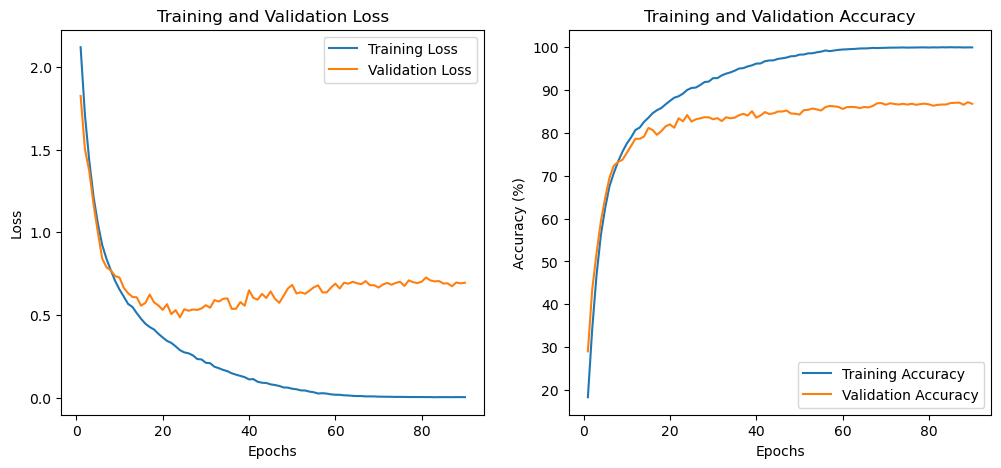

CPU times: user 9min 29s, sys: 3min 47s, total: 13min 16s
Wall time: 53min 51s


In [25]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = AlexNet()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=90)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

alexnet_0_0_1_SGD_train_losses = []
alexnet_0_0_1_SGD_val_losses = []
alexnet_0_0_1_SGD_train_accuracies = []
alexnet_0_0_1_SGD_val_accuracies = []

for epoch in range(start_epoch, 90):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    alexnet_0_0_1_SGD_train_losses.append(train_loss)
    alexnet_0_0_1_SGD_val_losses.append(val_loss)
    alexnet_0_0_1_SGD_train_accuracies.append(train_accuracy)
    alexnet_0_0_1_SGD_val_accuracies.append(val_accuracy)

state_alexnet_0_0_1_SGD,  acc_alexnet_0_0_1_SGD = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_alexnet_0_0_1_SGD)

plot_metrics(alexnet_0_0_1_SGD_train_losses, alexnet_0_0_1_SGD_val_losses, 
             alexnet_0_0_1_SGD_train_accuracies, alexnet_0_0_1_SGD_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [26]:
file_path_alexnet_0_0_1_SGD = "./result_and_model/alexnet_0_0_1_SGD_results.pkl"
model_state_path_alexnet_0_0_1_SGD = "./result_and_model/alexnet_0_0_1_SGD_model.pth"

with open(file_path_alexnet_0_0_1_SGD, "wb") as f:
    pickle.dump({
        "train_losses": alexnet_0_0_1_SGD_train_losses,
        "val_losses": alexnet_0_0_1_SGD_val_losses,
        "train_accuracies": alexnet_0_0_1_SGD_train_accuracies,
        "val_accuracies": alexnet_0_0_1_SGD_val_accuracies,
        "best_accuracy": acc_alexnet_0_0_1_SGD
    }, f)


torch.save(state_alexnet_0_0_1_SGD, model_state_path_alexnet_0_0_1_SGD)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.1, Optimizer = Adam

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.31]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:13<00:00,  5.87it/s, Acc=9.67, Loss=2.34]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:13<00:00,  5.83it/s, Acc=9.67, Loss=2.31]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=10.1, Loss=2.31]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.67, Loss=2.29]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:13<00:00,  5.84it/s, Acc=10.2, Loss=2.32]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=2.29]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.98, Loss=2.33]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:13<00:00,  5.87it/s, Acc=10.1, Loss=2.29]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.98, Loss=2.37]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:23<00:00, 13.05it/s, Acc=9.87, Loss=2.29
Validation Epoch 10: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.2, Loss=2.28]



Epoch: 11


Validation Epoch 11: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.2, Loss=2.36]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:23<00:00, 13.05it/s, Acc=9.79, Loss=2.29
Validation Epoch 12: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.67, Loss=2.3]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:24<00:00, 13.03it/s, Acc=10.2, Loss=2.29
Validation Epoch 13: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=2.32]



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:23<00:00, 13.05it/s, Acc=10.3, Loss=2.32
Validation Epoch 14: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.98, Loss=2.35]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:24<00:00, 13.04it/s, Acc=9.98, Loss=2.31
Validation Epoch 15: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.3]



Epoch: 16


Validation Epoch 16: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=9.99, Loss=2.31]



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:23<00:00, 13.05it/s, Acc=10.2, Loss=2.31
Validation Epoch 17: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=10.3, Loss=2.3]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:24<00:00, 13.04it/s, Acc=9.73, Loss=2.32
Validation Epoch 18: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=2.33]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:24<00:00, 13.04it/s, Acc=9.82, Loss=2.31
Validation Epoch 19: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.98, Loss=2.32]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:23<00:00, 13.04it/s, Acc=9.94, Loss=2.31
Validation Epoch 20: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.98, Loss=2.32]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:23<00:00, 13.04it/s, Acc=9.94, Loss=2.29
Validation Epoch 21: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.2, Loss=2.33]



Epoch: 22


Validation Epoch 22: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=10.1, Loss=2.28]



Epoch: 23


Validation Epoch 23: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=9.98, Loss=2.31]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:23<00:00, 13.05it/s, Acc=9.96, Loss=2.33
Validation Epoch 24: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.2, Loss=2.36]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=9.96, Loss=2.29
Validation Epoch 25: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.29]



Epoch: 26


Validation Epoch 26: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=9.73, Loss=2.26]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=9.92, Loss=2.31
Validation Epoch 27: 100%|██| 79/79 [00:13<00:00,  5.87it/s, Acc=9.73, Loss=2.3]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=10.1, Loss=2.31
Validation Epoch 28: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.98, Loss=2.33]



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=9.85, Loss=2.32
Validation Epoch 29: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.73, Loss=2.29]



Epoch: 30


Validation Epoch 30: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.2, Loss=2.34]



Epoch: 31


Validation Epoch 31: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.32]



Epoch: 32


Validation Epoch 32: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.32]



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=10.1, Loss=2.31
Validation Epoch 33: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.73, Loss=2.28]



Epoch: 34


Validation Epoch 34: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=2.34]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=9.93, Loss=2.29
Validation Epoch 35: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.67, Loss=2.33]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.86, Loss=2.31
Validation Epoch 36: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.67, Loss=2.31]



Epoch: 37


Validation Epoch 37: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.67, Loss=2.28]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=10.2, Loss=2.31
Validation Epoch 38: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=2.31]



Epoch: 39


Validation Epoch 39: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.2, Loss=2.32]



Epoch: 40


Validation Epoch 40: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.67, Loss=2.31]



Epoch: 41


Validation Epoch 41: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=10.2, Loss=2.33]



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:23<00:00, 13.08it/s, Acc=10.2, Loss=2.32
Validation Epoch 42: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.2, Loss=2.32]



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=9.78, Loss=2.31
Validation Epoch 43: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=9.67, Loss=2.33]



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.99, Loss=2.31
Validation Epoch 44: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.1, Loss=2.28]



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:23<00:00, 13.08it/s, Acc=9.83, Loss=2.32
Validation Epoch 45: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.63, Loss=2.28]



Epoch: 46


Validation Epoch 46: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.3, Loss=2.32]



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=10.1, Loss=2.31
Validation Epoch 47: 100%|██| 79/79 [00:13<00:00,  5.84it/s, Acc=9.99, Loss=2.3]



Epoch: 48


Validation Epoch 48: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.98, Loss=2.31]



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:23<00:00, 13.09it/s, Acc=9.82, Loss=2.28
Validation Epoch 49: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.99, Loss=2.29]



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.96, Loss=2.32
Validation Epoch 50: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.2, Loss=2.31]



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:23<00:00, 13.08it/s, Acc=9.91, Loss=2.29
Validation Epoch 51: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.31]



Epoch: 52


Validation Epoch 52: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.2, Loss=2.31]



Epoch: 53


Validation Epoch 53: 100%|██| 79/79 [00:13<00:00,  5.86it/s, Acc=10.2, Loss=2.3]



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.53, Loss=2.31
Validation Epoch 54: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.28]



Epoch: 55


Validation Epoch 55: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.31]



Epoch: 56


Validation Epoch 56: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.73, Loss=2.3]



Epoch: 57


Validation Epoch 57: 100%|██| 79/79 [00:13<00:00,  5.86it/s, Acc=9.73, Loss=2.3]



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=9.66, Loss=2.29
Validation Epoch 58: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.67, Loss=2.3]



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:23<00:00, 13.09it/s, Acc=9.98, Loss=2.29
Validation Epoch 59: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.3]



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.88, Loss=2.31
Validation Epoch 60: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.98, Loss=2.31]



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.89, Loss=2.31
Validation Epoch 61: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=10.1, Loss=2.32]



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.98, Loss=2.31
Validation Epoch 62: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.1, Loss=2.32]



Epoch: 63


Validation Epoch 63: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.32]



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:23<00:00, 13.08it/s, Acc=9.92, Loss=2.31
Validation Epoch 64: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.2, Loss=2.31]



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:23<00:00, 13.09it/s, Acc=10.2, Loss=2.31
Validation Epoch 65: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=2.3]



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:23<00:00, 13.09it/s, Acc=10.1, Loss=2.31
Validation Epoch 66: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.31]



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.99, Loss=2.31
Validation Epoch 67: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.3]



Epoch: 68


Validation Epoch 68: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.3]



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:23<00:00, 13.07it/s, Acc=10.2, Loss=2.31
Validation Epoch 69: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.99, Loss=2.31]



Epoch: 70


Validation Epoch 70: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.99, Loss=2.3]



Epoch: 71


Validation Epoch 71: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.73, Loss=2.3]



Epoch: 72


Validation Epoch 72: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.63, Loss=2.31]



Epoch: 73


Validation Epoch 73: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.3]



Epoch: 74


Validation Epoch 74: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.63, Loss=2.3]



Epoch: 75


Validation Epoch 75: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.3]



Epoch: 76


Validation Epoch 76: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.3]



Epoch: 77


Validation Epoch 77: 100%|██| 79/79 [00:13<00:00,  5.85it/s, Acc=9.63, Loss=2.3]



Epoch: 78


Validation Epoch 78: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.3]



Epoch: 79


Validation Epoch 79: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.3]

Validation Accuracy:  10.35


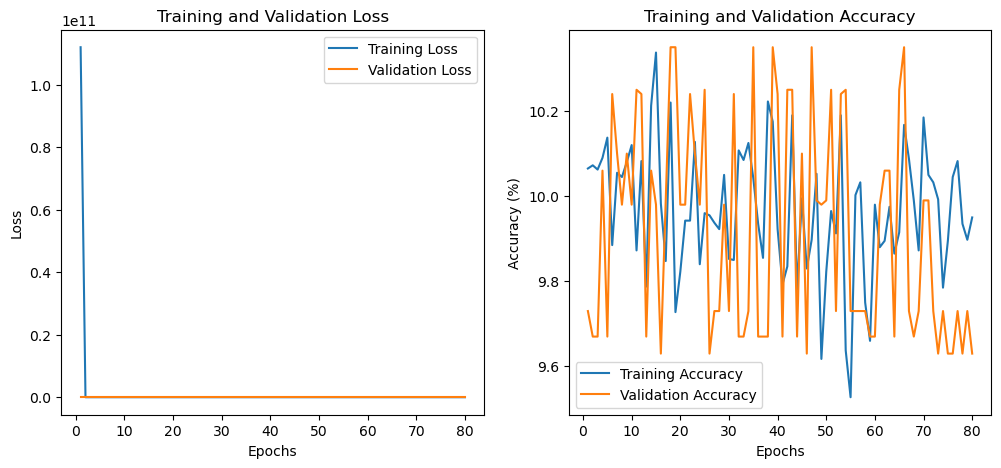

CPU times: user 9min, sys: 3min 12s, total: 12min 13s
Wall time: 49min 50s


In [27]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = AlexNet()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

alexnet_0_1_Adam_train_losses = []
alexnet_0_1_Adam_val_losses = []
alexnet_0_1_Adam_train_accuracies = []
alexnet_0_1_Adam_val_accuracies = []

for epoch in range(start_epoch, 80):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    alexnet_0_1_Adam_train_losses.append(train_loss)
    alexnet_0_1_Adam_val_losses.append(val_loss)
    alexnet_0_1_Adam_train_accuracies.append(train_accuracy)
    alexnet_0_1_Adam_val_accuracies.append(val_accuracy)

state_alexnet_0_1_Adam,  acc_alexnet_0_1_Adam = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_alexnet_0_1_Adam)

plot_metrics(alexnet_0_1_Adam_train_losses, alexnet_0_1_Adam_val_losses, 
             alexnet_0_1_Adam_train_accuracies, alexnet_0_1_Adam_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [28]:
file_path_alexnet_0_1_Adam = "./result_and_model/alexnet_0_1_Adam_results.pkl"
model_state_path_alexnet_0_1_Adam = "./result_and_model/alexnet_0_1_Adam_model.pth"

with open(file_path_alexnet_0_1_Adam, "wb") as f:
    pickle.dump({
        "train_losses": alexnet_0_1_Adam_train_losses,
        "val_losses": alexnet_0_1_Adam_val_losses,
        "train_accuracies": alexnet_0_1_Adam_train_accuracies,
        "val_accuracies": alexnet_0_1_Adam_val_accuracies,
        "best_accuracy": acc_alexnet_0_1_Adam
    }, f)


torch.save(state_alexnet_0_1_Adam, model_state_path_alexnet_0_1_Adam)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = Adam

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=10.2, Loss=2.29]



Epoch: 1


Validation Epoch 1: 100%|███| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.3]



Epoch: 2


Validation Epoch 2: 100%|███| 79/79 [00:13<00:00,  5.87it/s, Acc=10.2, Loss=2.3]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.63, Loss=2.29]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:13<00:00,  5.87it/s, Acc=9.67, Loss=2.31]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.31]



Epoch: 6


Validation Epoch 6: 100%|███| 79/79 [00:13<00:00,  5.87it/s, Acc=9.67, Loss=2.3]



Epoch: 7


Validation Epoch 7: 100%|███| 79/79 [00:13<00:00,  5.88it/s, Acc=9.67, Loss=2.3]



Epoch: 8


Validation Epoch 8: 100%|███| 79/79 [00:13<00:00,  5.88it/s, Acc=9.63, Loss=2.3]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.29]



Epoch: 10


Validation Epoch 10: 100%|██| 79/79 [00:13<00:00,  5.87it/s, Acc=9.67, Loss=2.3]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:24<00:00, 13.03it/s, Acc=9.74, Loss=2.31
Validation Epoch 11: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=9.63, Loss=2.31]



Epoch: 12


Validation Epoch 12: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=10.2, Loss=2.3]



Epoch: 13


Validation Epoch 13: 100%|██| 79/79 [00:13<00:00,  5.73it/s, Acc=10.1, Loss=2.3]



Epoch: 14


Validation Epoch 14: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.31]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:24<00:00, 13.04it/s, Acc=9.78, Loss=2.31
Validation Epoch 15: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=10.2, Loss=2.31]



Epoch: 16


Validation Epoch 16: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=9.73, Loss=2.31]



Epoch: 17


Validation Epoch 17: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=2.3]



Epoch: 18


Validation Epoch 18: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.67, Loss=2.3]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:24<00:00, 13.01it/s, Acc=9.86, Loss=2.31
Validation Epoch 19: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.99, Loss=2.3]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:24<00:00, 13.04it/s, Acc=10.1, Loss=2.31
Validation Epoch 20: 100%|██| 79/79 [00:13<00:00,  5.87it/s, Acc=9.98, Loss=2.3]



Epoch: 21


Validation Epoch 21: 100%|██| 79/79 [00:13<00:00,  5.86it/s, Acc=10.1, Loss=2.3]



Epoch: 22


Validation Epoch 22: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.1, Loss=2.29]



Epoch: 23


Validation Epoch 23: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=10.2, Loss=2.3]



Epoch: 24


Validation Epoch 24: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.3]



Epoch: 25


Validation Epoch 25: 100%|██| 79/79 [00:13<00:00,  5.92it/s, Acc=9.63, Loss=2.3]



Epoch: 26


Validation Epoch 26: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=10.1, Loss=2.3]



Epoch: 27


Validation Epoch 27: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.98, Loss=2.3]



Epoch: 28


Validation Epoch 28: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.31]



Epoch: 29


Validation Epoch 29: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.3]



Epoch: 30


Validation Epoch 30: 100%|██| 79/79 [00:13<00:00,  5.82it/s, Acc=9.73, Loss=2.3]



Epoch: 31


Validation Epoch 31: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.73, Loss=2.29]



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:23<00:00, 13.05it/s, Acc=9.96, Loss=2.31
Validation Epoch 32: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=2.31]



Epoch: 33


Validation Epoch 33: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.2, Loss=2.29]



Epoch: 34


Validation Epoch 34: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.98, Loss=2.31]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:23<00:00, 13.05it/s, Acc=9.86, Loss=2.29
Validation Epoch 35: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.99, Loss=2.3]



Epoch: 36


Validation Epoch 36: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=2.3]



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:23<00:00, 13.08it/s, Acc=9.98, Loss=2.31
Validation Epoch 37: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.3]



Epoch: 38


Validation Epoch 38: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.3]



Epoch: 39


Validation Epoch 39: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.98, Loss=2.31]



Epoch: 40


Validation Epoch 40: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.67, Loss=2.31]



Epoch: 41


Validation Epoch 41: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.3]



Epoch: 42


Validation Epoch 42: 100%|██| 79/79 [00:13<00:00,  5.77it/s, Acc=9.67, Loss=2.3]



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:23<00:00, 13.05it/s, Acc=9.87, Loss=2.31
Validation Epoch 43: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.3]



Epoch: 44


Validation Epoch 44: 100%|█| 79/79 [00:13<00:00,  5.81it/s, Acc=10.1, Loss=2.29]



Epoch: 45


Validation Epoch 45: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.67, Loss=2.3]



Epoch: 46


Validation Epoch 46: 100%|██| 79/79 [00:13<00:00,  5.87it/s, Acc=9.63, Loss=2.3]



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.97, Loss=2.31
Validation Epoch 47: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.31]



Epoch: 48


Validation Epoch 48: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=10.1, Loss=2.3]



Epoch: 49


Validation Epoch 49: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=10.1, Loss=2.3]



Epoch: 50


Validation Epoch 50: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.3]



Epoch: 51


Validation Epoch 51: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=2.3]



Epoch: 52


Validation Epoch 52: 100%|██| 79/79 [00:13<00:00,  5.81it/s, Acc=9.63, Loss=2.3]



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:23<00:00, 13.06it/s, Acc=9.94, Loss=2.31
Validation Epoch 53: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.73, Loss=2.3]



Epoch: 54


Validation Epoch 54: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.73, Loss=2.3]



Epoch: 55


Validation Epoch 55: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.3]



Epoch: 56


Validation Epoch 56: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=2.3]



Epoch: 57


Validation Epoch 57: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.99, Loss=2.3]



Epoch: 58


Validation Epoch 58: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.3]



Epoch: 59


Validation Epoch 59: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.3]



Epoch: 60


Validation Epoch 60: 100%|██| 79/79 [00:13<00:00,  5.81it/s, Acc=9.67, Loss=2.3]



Epoch: 61


Validation Epoch 61: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.3]



Epoch: 62


Validation Epoch 62: 100%|██| 79/79 [00:13<00:00,  5.86it/s, Acc=10.1, Loss=2.3]



Epoch: 63


Validation Epoch 63: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.67, Loss=2.3]



Epoch: 64


Validation Epoch 64: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.3]



Epoch: 65


Validation Epoch 65: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.63, Loss=2.3]



Epoch: 66


Validation Epoch 66: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.3]



Epoch: 67


Validation Epoch 67: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.67, Loss=2.3]



Epoch: 68


Validation Epoch 68: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.3]



Epoch: 69


Validation Epoch 69: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.3]



Epoch: 70


Validation Epoch 70: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.3]



Epoch: 71


Validation Epoch 71: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.3]



Epoch: 72


Validation Epoch 72: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.63, Loss=2.3]



Epoch: 73


Validation Epoch 73: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.3]



Epoch: 74


Validation Epoch 74: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.3]



Epoch: 75


Validation Epoch 75: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.3]



Epoch: 76


Validation Epoch 76: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.3]



Epoch: 77


Validation Epoch 77: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.3]



Epoch: 78


Validation Epoch 78: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.63, Loss=2.3]



Epoch: 79


Validation Epoch 79: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.63, Loss=2.3]

Validation Accuracy:  10.35


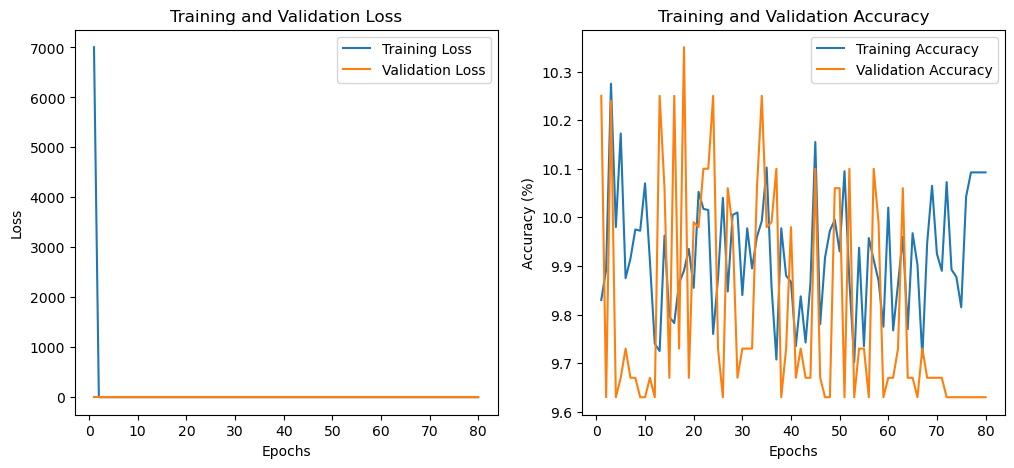

CPU times: user 8min 55s, sys: 3min 25s, total: 12min 21s
Wall time: 49min 55s


In [29]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = AlexNet()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

alexnet_0_0_1_Adam_train_losses = []
alexnet_0_0_1_Adam_val_losses = []
alexnet_0_0_1_Adam_train_accuracies = []
alexnet_0_0_1_Adam_val_accuracies = []

for epoch in range(start_epoch, 80):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    alexnet_0_0_1_Adam_train_losses.append(train_loss)
    alexnet_0_0_1_Adam_val_losses.append(val_loss)
    alexnet_0_0_1_Adam_train_accuracies.append(train_accuracy)
    alexnet_0_0_1_Adam_val_accuracies.append(val_accuracy)

state_alexnet_0_0_1_Adam,  acc_alexnet_0_0_1_Adam = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_alexnet_0_0_1_Adam)

plot_metrics(alexnet_0_0_1_Adam_train_losses, alexnet_0_0_1_Adam_val_losses, 
             alexnet_0_0_1_Adam_train_accuracies, alexnet_0_0_1_Adam_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [30]:
file_path_alexnet_0_0_1_Adam = "./result_and_model/alexnet_0_0_1_Adam_results.pkl"
model_state_path_alexnet_0_0_1_Adam = "./result_and_model/alexnet_0_0_1_Adam_model.pth"

with open(file_path_alexnet_0_0_1_Adam, "wb") as f:
    pickle.dump({
        "train_losses": alexnet_0_0_1_Adam_train_losses,
        "val_losses": alexnet_0_0_1_Adam_val_losses,
        "train_accuracies": alexnet_0_0_1_Adam_train_accuracies,
        "val_accuracies": alexnet_0_0_1_Adam_val_accuracies,
        "best_accuracy": acc_alexnet_0_0_1_Adam
    }, f)


torch.save(state_alexnet_0_0_1_Adam, model_state_path_alexnet_0_0_1_Adam)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.1, Optimizer = RMSprop

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=3.49]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=6.71]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=10.3, Loss=3.93]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=3.24]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.4, Loss=93.7]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=73.1]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.99, Loss=43.9]



Epoch: 7


Validation Epoch 7: 100%|███| 79/79 [00:13<00:00,  5.89it/s, Acc=10.1, Loss=118]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.2, Loss=68.7]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.98, Loss=72.7]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=10.1, Loss=9.59
Validation Epoch 10: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=1.08e



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:23<00:00, 13.26it/s, Acc=9.9, Loss=1.28e
Validation Epoch 11: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.99, Loss=4.13e



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=9.63, Loss=3.29
Validation Epoch 12: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.1, Loss=1.23e



Epoch: 13


Validation Epoch 13: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=160]



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=9.74, Loss=3.91
Validation Epoch 14: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=10.1, Loss=1.25e



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:23<00:00, 13.25it/s, Acc=10.2, Loss=1.33
Validation Epoch 15: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10, Loss=8.41e+5



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=9.68, Loss=3.48
Validation Epoch 16: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.77, Loss=2.4]



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=9.99, Loss=2.24
Validation Epoch 17: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=2.83e



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=9.83, Loss=16.3
Validation Epoch 18: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.98, Loss=2.3]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=9.91, Loss=2.34
Validation Epoch 19: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=2.32]



Epoch: 20


Validation Epoch 20: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=2.3]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=10.1, Loss=4.73
Validation Epoch 21: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=1.01e



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=10.2, Loss=4.87
Validation Epoch 22: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=9.99, Loss=2.27]



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=9.78, Loss=2.23
Validation Epoch 23: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=9.64, Loss=6.52e



Epoch: 24


Validation Epoch 24: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=10.2, Loss=2.38]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:23<00:00, 13.31it/s, Acc=9.95, Loss=3.51
Validation Epoch 25: 100%|██| 79/79 [00:13<00:00,  5.93it/s, Acc=9.63, Loss=2.3]



Epoch: 26


Validation Epoch 26: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.71, Loss=130]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=9.89, Loss=6.75
Validation Epoch 27: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.66, Loss=7.99]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=10.1, Loss=7.27
Validation Epoch 28: 100%|█| 79/79 [00:13<00:00,  5.93it/s, Acc=9.78, Loss=2.23e



Epoch: 29


Validation Epoch 29: 100%|█| 79/79 [00:13<00:00,  5.81it/s, Acc=9.73, Loss=2.28]



Epoch: 30


Validation Epoch 30: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.1, Loss=2.35]



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=9.92, Loss=2.28
Validation Epoch 31: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=9.67, Loss=2.26]



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=9.92, Loss=2.31
Validation Epoch 32: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.63, Loss=2.3]



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=9.97, Loss=2.37
Validation Epoch 33: 100%|██| 79/79 [00:13<00:00,  5.92it/s, Acc=9.63, Loss=2.3]



Epoch: 34


Validation Epoch 34: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=199]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=10.2, Loss=10.7
Validation Epoch 35: 100%|███| 79/79 [00:13<00:00,  5.89it/s, Acc=9.98, Loss=14]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:23<00:00, 13.32it/s, Acc=9.89, Loss=4.84
Validation Epoch 36: 100%|█| 79/79 [00:13<00:00,  5.93it/s, Acc=10.1, Loss=3.01]



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=10.1, Loss=3.06
Validation Epoch 37: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=4.36e



Epoch: 38


Validation Epoch 38: 100%|█| 79/79 [00:13<00:00,  5.80it/s, Acc=10.2, Loss=5.09]



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:23<00:00, 13.31it/s, Acc=9.98, Loss=3.35
Validation Epoch 39: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.3, Loss=2.24]



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=10, Loss=3.08e+
Validation Epoch 40: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=2.27]



Epoch: 41


Validation Epoch 41: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=2.32]



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=9.99, Loss=2.21
Validation Epoch 42: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.29]



Epoch: 43


Validation Epoch 43: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.73, Loss=2.3]



Epoch: 44


Validation Epoch 44: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.3]



Epoch: 45


Validation Epoch 45: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=9.68, Loss=2.3]



Epoch: 46


Validation Epoch 46: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=2.32]



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=9.94, Loss=2.31
Validation Epoch 47: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.29]



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=10.1, Loss=2.31
Validation Epoch 48: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.99, Loss=2.31]



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=9.92, Loss=2.29
Validation Epoch 49: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.99, Loss=2.29]



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=9.91, Loss=3.05
Validation Epoch 50: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.92, Loss=2.28]



Epoch: 51


Validation Epoch 51: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.2, Loss=2.33]



Epoch: 52


Validation Epoch 52: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.76, Loss=200]



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=10.1, Loss=64.5
Validation Epoch 53: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.1, Loss=2.23]



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=10.1, Loss=1.51
Validation Epoch 54: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.32]



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=10.2, Loss=1.41
Validation Epoch 55: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=9.53, Loss=4.27e



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=10.2, Loss=2.29
Validation Epoch 56: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.28]



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=9.94, Loss=3.67
Validation Epoch 57: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.99, Loss=5.02e



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=10, Loss=1.43e+
Validation Epoch 58: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9, Loss=4.56e+6]



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=9.91, Loss=18.1
Validation Epoch 59: 100%|█| 79/79 [00:13<00:00,  5.85it/s, Acc=10.2, Loss=7.76]



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:23<00:00, 13.21it/s, Acc=10.2, Loss=3.58
Validation Epoch 60: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.2, Loss=3.33]



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=9.89, Loss=2.37
Validation Epoch 61: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=10.2, Loss=2.62]



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:23<00:00, 13.25it/s, Acc=9.79, Loss=2.35
Validation Epoch 62: 100%|█| 79/79 [00:13<00:00,  5.84it/s, Acc=9.98, Loss=2.55]



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=10.1, Loss=2.31
Validation Epoch 63: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=10.3, Loss=2.29]



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:23<00:00, 13.21it/s, Acc=9.77, Loss=2.32
Validation Epoch 64: 100%|█| 79/79 [00:13<00:00,  5.80it/s, Acc=10.1, Loss=2.25]



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:23<00:00, 13.25it/s, Acc=9.92, Loss=2.32
Validation Epoch 65: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=9.99, Loss=2.26]



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:23<00:00, 13.24it/s, Acc=9.69, Loss=2.29
Validation Epoch 66: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=9.99, Loss=2.33]



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=9.55, Loss=2.35
Validation Epoch 67: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.1, Loss=2.37]



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:23<00:00, 13.25it/s, Acc=9.89, Loss=2.31
Validation Epoch 68: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=9.62, Loss=2.31]



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:23<00:00, 13.25it/s, Acc=9.75, Loss=2.28
Validation Epoch 69: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=10.1, Loss=2.29]



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:23<00:00, 13.24it/s, Acc=9.98, Loss=2.36
Validation Epoch 70: 100%|███| 79/79 [00:13<00:00,  5.89it/s, Acc=10, Loss=2.39]



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:23<00:00, 13.25it/s, Acc=10, Loss=1.22e+
Validation Epoch 71: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.1, Loss=2.38]



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:23<00:00, 13.24it/s, Acc=9.95, Loss=2.26
Validation Epoch 72: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.64, Loss=2.33]



Epoch: 73


Validation Epoch 73: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.37]



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=9.71, Loss=2.32
Validation Epoch 74: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.38]



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:23<00:00, 13.23it/s, Acc=9.93, Loss=3.16
Validation Epoch 75: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=9.62, Loss=2.34]



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=9.84, Loss=2.33
Validation Epoch 76: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.63, Loss=2.38]



Epoch: 77


Validation Epoch 77: 100%|█| 79/79 [00:13<00:00,  5.84it/s, Acc=9.98, Loss=2.38]



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:23<00:00, 13.23it/s, Acc=10.2, Loss=2.31
Validation Epoch 78: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.63, Loss=2.36]



Epoch: 79


Validation Epoch 79: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=9.63, Loss=2.37]


Validation Accuracy:  10.39


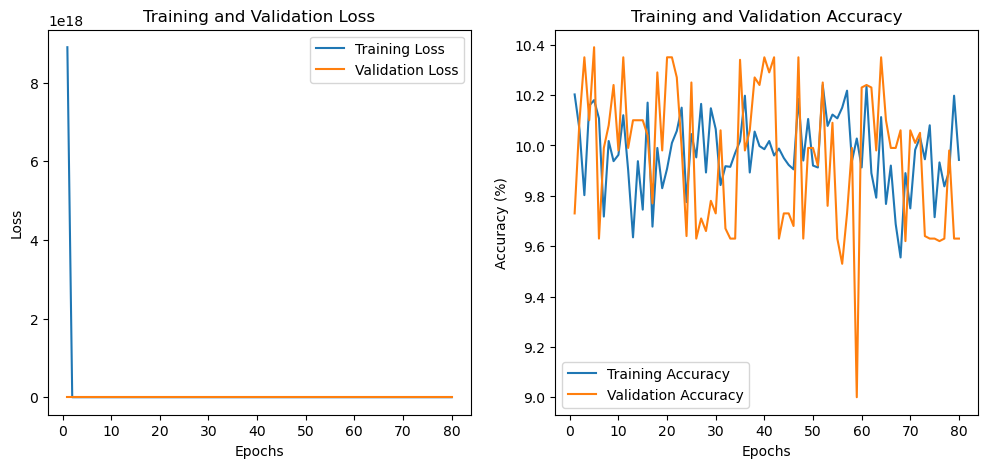

CPU times: user 8min 50s, sys: 3min 24s, total: 12min 14s
Wall time: 49min 22s


In [31]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = AlexNet()
net.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.1, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

alexnet_0_1_RMSprop_train_losses = []
alexnet_0_1_RMSprop_val_losses = []
alexnet_0_1_RMSprop_train_accuracies = []
alexnet_0_1_RMSprop_val_accuracies = []

for epoch in range(start_epoch, 80):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    alexnet_0_1_RMSprop_train_losses.append(train_loss)
    alexnet_0_1_RMSprop_val_losses.append(val_loss)
    alexnet_0_1_RMSprop_train_accuracies.append(train_accuracy)
    alexnet_0_1_RMSprop_val_accuracies.append(val_accuracy)

state_alexnet_0_1_RMSprop,  acc_alexnet_0_1_RMSprop = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_alexnet_0_1_RMSprop)

plot_metrics(alexnet_0_1_RMSprop_train_losses, alexnet_0_1_RMSprop_val_losses, 
             alexnet_0_1_RMSprop_train_accuracies, alexnet_0_1_RMSprop_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [32]:
file_path_alexnet_0_1_RMSprop = "./result_and_model/alexnet_0_1_RMSprop_results.pkl"
model_state_path_alexnet_0_1_RMSprop = "./result_and_model/alexnet_0_1_RMSprop_model.pth"

with open(file_path_alexnet_0_1_RMSprop, "wb") as f:
    pickle.dump({
        "train_losses": alexnet_0_1_RMSprop_train_losses,
        "val_losses": alexnet_0_1_RMSprop_val_losses,
        "train_accuracies": alexnet_0_1_RMSprop_train_accuracies,
        "val_accuracies": alexnet_0_1_RMSprop_val_accuracies,
        "best_accuracy": acc_alexnet_0_1_RMSprop
    }, f)


torch.save(state_alexnet_0_1_RMSprop, model_state_path_alexnet_0_1_RMSprop)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = RMSprop

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=10.2, Loss=2.33]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.69, Loss=2.35]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=10.2, Loss=2.31]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=9.74, Loss=2.28]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=11.8, Loss=2.28]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=10.5, Loss=2.41]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=10.1, Loss=2.26]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.32]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=10.3, Loss=2.28]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.98, Loss=2.33]



Epoch: 10


Validation Epoch 10: 100%|██| 79/79 [00:13<00:00,  5.88it/s, Acc=10.3, Loss=2.3]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:23<00:00, 13.21it/s, Acc=9.78, Loss=2.31
Validation Epoch 11: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.67, Loss=2.38]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=10.1, Loss=2.34
Validation Epoch 12: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.73, Loss=2.3]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=9.98, Loss=2.32
Validation Epoch 13: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.1, Loss=2.32]



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=10.1, Loss=2.31
Validation Epoch 14: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=9.98, Loss=2.34]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:23<00:00, 13.21it/s, Acc=9.81, Loss=2.33
Validation Epoch 15: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=10.1, Loss=2.32]



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:23<00:00, 13.23it/s, Acc=10.1, Loss=2.33
Validation Epoch 16: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=2.35]



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:23<00:00, 13.21it/s, Acc=10.2, Loss=2.37
Validation Epoch 17: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.3, Loss=2.35]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:23<00:00, 13.22it/s, Acc=10.1, Loss=8.67
Validation Epoch 18: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=10.4, Loss=2.41]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:23<00:00, 13.24it/s, Acc=10.3, Loss=2.34
Validation Epoch 19: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.61, Loss=2.3]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:23<00:00, 13.23it/s, Acc=9.85, Loss=2.32
Validation Epoch 20: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.98, Loss=2.32]



Epoch: 21


Validation Epoch 21: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=10.2, Loss=2.32]



Epoch: 22


Validation Epoch 22: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.82, Loss=2.35]



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:23<00:00, 13.21it/s, Acc=10.5, Loss=2.53
Validation Epoch 23: 100%|█| 79/79 [00:13<00:00,  5.79it/s, Acc=9.98, Loss=2.47]



Epoch: 24


Validation Epoch 24: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=9.51, Loss=2.68]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=10.4, Loss=2.49
Validation Epoch 25: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=2.31]



Epoch: 26


Validation Epoch 26: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.1, Loss=2.28]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=9.81, Loss=2.32
Validation Epoch 27: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=10.5, Loss=2.33]



Epoch: 28


Validation Epoch 28: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.99, Loss=2.31]



Epoch: 29


Validation Epoch 29: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=9.73, Loss=2.29]



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=13.1, Loss=2.32
Validation Epoch 30: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=14.6, Loss=2.31]



Epoch: 31


Validation Epoch 31: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.74, Loss=2.28]



Epoch: 32


Validation Epoch 32: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.64, Loss=2.31]



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=9.86, Loss=2.31
Validation Epoch 33: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.73, Loss=2.3]



Epoch: 34


Validation Epoch 34: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=9.68, Loss=2.33]



Epoch: 35


Validation Epoch 35: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.48, Loss=2.35]



Epoch: 36


Validation Epoch 36: 100%|█| 79/79 [00:13<00:00,  5.82it/s, Acc=9.73, Loss=2.27]



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:23<00:00, 13.31it/s, Acc=10.3, Loss=2.29
Validation Epoch 37: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=11.3, Loss=2.29]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=11.1, Loss=2.31
Validation Epoch 38: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=11.1, Loss=2.29]



Epoch: 39


Validation Epoch 39: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=9.51, Loss=2.5]



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:23<00:00, 13.25it/s, Acc=12.8, Loss=5.71
Validation Epoch 40: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=11.8, Loss=2.81]



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=12.9, Loss=2.24
Validation Epoch 41: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=16.2, Loss=2.16]



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=14.7, Loss=2.23
Validation Epoch 42: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=16.4, Loss=2.02]



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=11.8, Loss=2.31
Validation Epoch 43: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=14.1, Loss=2.22]



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=12.9, Loss=2.33
Validation Epoch 44: 100%|███| 79/79 [00:13<00:00,  5.89it/s, Acc=10, Loss=2.29]



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=10.6, Loss=2.31
Validation Epoch 45: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=9.87, Loss=2.3]



Epoch: 46


Validation Epoch 46: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=10.4, Loss=2.31]



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=10.1, Loss=2.31
Validation Epoch 47: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=10.5, Loss=2.31]



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=10.2, Loss=35.6
Validation Epoch 48: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=9.99, Loss=7.84]



Epoch: 49


Validation Epoch 49: 100%|█| 79/79 [00:13<00:00,  5.80it/s, Acc=14.7, Loss=2.23]



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=14.7, Loss=2.29
Validation Epoch 50: 100%|███| 79/79 [00:13<00:00,  5.90it/s, Acc=14, Loss=2.26]



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=15.1, Loss=2.23
Validation Epoch 51: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=18.6, Loss=2.23]



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=16.8, Loss=2.09
Validation Epoch 52: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=13.7, Loss=2.47]



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=19.6, Loss=1.98
Validation Epoch 53: 100%|██| 79/79 [00:13<00:00,  5.89it/s, Acc=24.2, Loss=2.1]



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=22.9, Loss=7.14
Validation Epoch 54: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=9.67, Loss=4.46]



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=25.2, Loss=1.81
Validation Epoch 55: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=29.8, Loss=2.13]



Epoch: 56


Validation Epoch 56: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=36.2, Loss=2.12]



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=35.4, Loss=1.92
Validation Epoch 57: 100%|███| 79/79 [00:13<00:00,  5.90it/s, Acc=36, Loss=1.85]



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=37.8, Loss=1.27
Validation Epoch 58: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=41.4, Loss=1.56]



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=43.1, Loss=1.52
Validation Epoch 59: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=40.4, Loss=1.82]



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=46.9, Loss=1.39
Validation Epoch 60: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=50.4, Loss=1.36]



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=50.4, Loss=1.38
Validation Epoch 61: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=44.5, Loss=1.91]



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=53.4, Loss=1.23
Validation Epoch 62: 100%|███| 79/79 [00:13<00:00,  5.88it/s, Acc=55, Loss=1.34]



Epoch: 63


Validation Epoch 63: 100%|████| 79/79 [00:13<00:00,  5.87it/s, Acc=58, Loss=1.2]



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=58.5, Loss=1.14
Validation Epoch 64: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=58.6, Loss=1.06]



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=60.9, Loss=1.13
Validation Epoch 65: 100%|█| 79/79 [00:13<00:00,  5.89it/s, Acc=60.9, Loss=1.38]



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=63.1, Loss=1.09
Validation Epoch 66: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=59.6, Loss=1.1]



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=65.1, Loss=0.91
Validation Epoch 67: 100%|██| 79/79 [00:13<00:00,  5.91it/s, Acc=63.8, Loss=1.3]



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:23<00:00, 13.29it/s, Acc=67.3, Loss=1.16
Validation Epoch 68: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=66.3, Loss=0.939



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=69.5, Loss=1.12
Validation Epoch 69: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=67.8, Loss=0.794



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:23<00:00, 13.26it/s, Acc=70.8, Loss=0.90
Validation Epoch 70: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=68.9, Loss=0.96]



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=72.5, Loss=0.87
Validation Epoch 71: 100%|█| 79/79 [00:13<00:00,  5.86it/s, Acc=69.9, Loss=0.713



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=74.1, Loss=0.68
Validation Epoch 72: 100%|█| 79/79 [00:13<00:00,  5.92it/s, Acc=71.7, Loss=0.849



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=74.9, Loss=0.62
Validation Epoch 73: 100%|█| 79/79 [00:13<00:00,  5.91it/s, Acc=72.6, Loss=1.24]



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=76.1, Loss=0.64
Validation Epoch 74: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=72.9, Loss=0.959



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=77.1, Loss=0.61
Validation Epoch 75: 100%|█| 79/79 [00:13<00:00,  5.87it/s, Acc=73.8, Loss=0.936



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=78, Loss=0.711]
Validation Epoch 76: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=73.8, Loss=0.821



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:23<00:00, 13.28it/s, Acc=78.4, Loss=0.68
Validation Epoch 77: 100%|██| 79/79 [00:13<00:00,  5.90it/s, Acc=75, Loss=0.677]



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:23<00:00, 13.30it/s, Acc=78.8, Loss=0.70
Validation Epoch 78: 100%|█| 79/79 [00:13<00:00,  5.88it/s, Acc=74.2, Loss=0.714



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:23<00:00, 13.27it/s, Acc=78.9, Loss=0.55
Validation Epoch 79: 100%|█| 79/79 [00:13<00:00,  5.90it/s, Acc=74.2, Loss=0.772

Validation Accuracy:  74.98


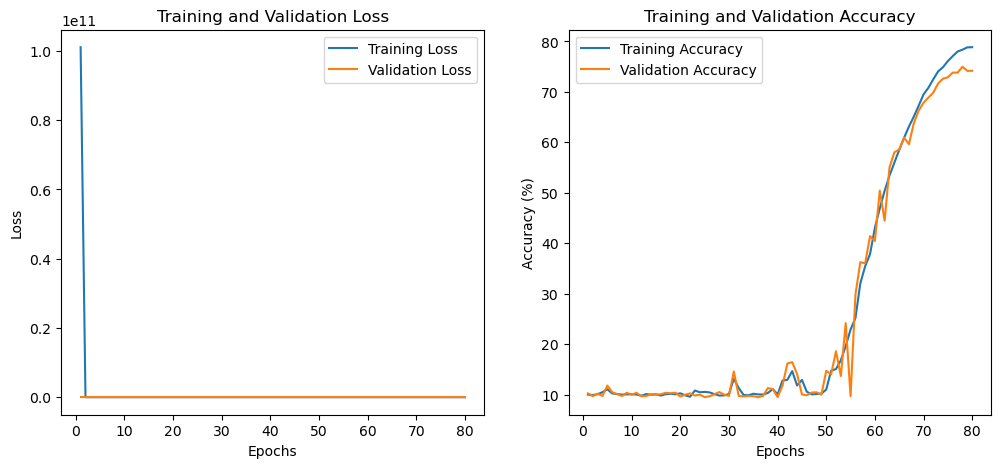

CPU times: user 8min 49s, sys: 3min 17s, total: 12min 7s
Wall time: 49min 21s


In [33]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = AlexNet()
net.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

alexnet_0_0_1_RMSprop_train_losses = []
alexnet_0_0_1_RMSprop_val_losses = []
alexnet_0_0_1_RMSprop_train_accuracies = []
alexnet_0_0_1_RMSprop_val_accuracies = []

for epoch in range(start_epoch, 80):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    alexnet_0_0_1_RMSprop_train_losses.append(train_loss)
    alexnet_0_0_1_RMSprop_val_losses.append(val_loss)
    alexnet_0_0_1_RMSprop_train_accuracies.append(train_accuracy)
    alexnet_0_0_1_RMSprop_val_accuracies.append(val_accuracy)

state_alexnet_0_0_1_RMSprop,  acc_alexnet_0_0_1_RMSprop = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_alexnet_0_0_1_RMSprop)

plot_metrics(alexnet_0_0_1_RMSprop_train_losses, alexnet_0_0_1_RMSprop_val_losses, 
             alexnet_0_0_1_RMSprop_train_accuracies, alexnet_0_0_1_RMSprop_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [34]:
file_path_alexnet_0_0_1_RMSprop = "./result_and_model/alexnet_0_0_1_RMSprop_results.pkl"
model_state_path_alexnet_0_0_1_RMSprop = "./result_and_model/alexnet_0_0_1_RMSprop_model.pth"

with open(file_path_alexnet_0_0_1_RMSprop, "wb") as f:
    pickle.dump({
        "train_losses": alexnet_0_0_1_RMSprop_train_losses,
        "val_losses": alexnet_0_0_1_RMSprop_val_losses,
        "train_accuracies": alexnet_0_0_1_RMSprop_train_accuracies,
        "val_accuracies": alexnet_0_0_1_RMSprop_val_accuracies,
        "best_accuracy": acc_alexnet_0_0_1_RMSprop
    }, f)


torch.save(state_alexnet_0_0_1_RMSprop, model_state_path_alexnet_0_0_1_RMSprop)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.


#### Manual Grid Search for ResNet18


Testing: Learning Rate = 0.1, Optimizer = SGD

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=38.1, Loss=1.53]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:14<00:00,  5.62it/s, Acc=47.8, Loss=1.38]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=53.1, Loss=1.51]



Epoch: 3


 Training Epoch 3: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=60.7, Loss=0.869
Validation Epoch 3: 100%|██| 79/79 [00:14<00:00,  5.53it/s, Acc=60.2, Loss=0.64]



Epoch: 4


 Training Epoch 4: 100%|█| 313/313 [00:31<00:00,  9.79it/s, Acc=65.6, Loss=0.731
Validation Epoch 4: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=68.2, Loss=0.717]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:14<00:00,  5.50it/s, Acc=52.5, Loss=1.09]



Epoch: 6


 Training Epoch 6: 100%|█| 313/313 [00:36<00:00,  8.49it/s, Acc=72.8, Loss=0.529
Validation Epoch 6: 100%|███| 79/79 [00:14<00:00,  5.38it/s, Acc=73, Loss=0.583]



Epoch: 7


 Training Epoch 7: 100%|█| 313/313 [00:37<00:00,  8.38it/s, Acc=76.5, Loss=0.545
Validation Epoch 7: 100%|█| 79/79 [00:14<00:00,  5.45it/s, Acc=75.4, Loss=0.446]



Epoch: 8


 Training Epoch 8: 100%|█| 313/313 [00:35<00:00,  8.74it/s, Acc=78.5, Loss=0.518
Validation Epoch 8: 100%|█| 79/79 [00:14<00:00,  5.42it/s, Acc=75.5, Loss=0.282]



Epoch: 9


 Training Epoch 9: 100%|█| 313/313 [00:34<00:00,  8.95it/s, Acc=79.7, Loss=0.438
Validation Epoch 9: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=76.3, Loss=0.353]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:34<00:00,  9.13it/s, Acc=81, Loss=0.456]
Validation Epoch 10: 100%|█| 79/79 [00:14<00:00,  5.45it/s, Acc=75.4, Loss=0.373



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=81.7, Loss=0.65
Validation Epoch 11: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=72, Loss=0.462]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=82.8, Loss=0.60
Validation Epoch 12: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=78.3, Loss=0.373



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=83, Loss=0.592]
Validation Epoch 13: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=74.4, Loss=0.342



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=83.6, Loss=0.45
Validation Epoch 14: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=78.6, Loss=0.302



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=84.2, Loss=0.40
Validation Epoch 15: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=76.7, Loss=0.518



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=84.5, Loss=0.58
Validation Epoch 16: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.3, Loss=0.411



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=84.8, Loss=0.48
Validation Epoch 17: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=78.7, Loss=0.235



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=85.3, Loss=0.38
Validation Epoch 18: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=83, Loss=0.095]



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=85.8, Loss=0.54
Validation Epoch 19: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=82, Loss=0.513]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=85.5, Loss=0.55
Validation Epoch 20: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.8, Loss=0.561



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=85.9, Loss=0.55
Validation Epoch 21: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.5, Loss=0.344



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=86.4, Loss=0.65
Validation Epoch 22: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.1, Loss=0.666



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=86.5, Loss=0.62
Validation Epoch 23: 100%|██| 79/79 [00:14<00:00,  5.56it/s, Acc=79, Loss=0.362]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=86.8, Loss=0.79
Validation Epoch 24: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=81, Loss=0.416]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:32<00:00,  9.65it/s, Acc=86.8, Loss=0.43
Validation Epoch 25: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.3, Loss=0.362



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=87.1, Loss=0.38
Validation Epoch 26: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=78.1, Loss=0.212



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=87, Loss=0.393]
Validation Epoch 27: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=83.5, Loss=0.557



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=87.6, Loss=0.30
Validation Epoch 28: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=81.9, Loss=0.449



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=87.5, Loss=0.30
Validation Epoch 29: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.4, Loss=0.712



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=87.9, Loss=0.52
Validation Epoch 30: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=83.4, Loss=0.249



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=87.9, Loss=0.32
Validation Epoch 31: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=81.8, Loss=0.348



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=88.1, Loss=0.37
Validation Epoch 32: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=78.2, Loss=0.368



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:32<00:00,  9.75it/s, Acc=88.2, Loss=0.23
Validation Epoch 33: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.2, Loss=0.514



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=88.3, Loss=0.22
Validation Epoch 34: 100%|██| 79/79 [00:14<00:00,  5.62it/s, Acc=83, Loss=0.677]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=88.3, Loss=0.40
Validation Epoch 35: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=79.8, Loss=0.519



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:32<00:00,  9.74it/s, Acc=88.5, Loss=0.28
Validation Epoch 36: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.6, Loss=0.55]



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=88.4, Loss=0.61
Validation Epoch 37: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=80.6, Loss=0.379



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=88.4, Loss=0.38
Validation Epoch 38: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.2, Loss=0.445



Epoch: 39


 Training Epoch 39: 100%|██| 313/313 [00:32<00:00,  9.72it/s, Acc=89, Loss=0.35]
Validation Epoch 39: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=83.1, Loss=0.341



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=89.1, Loss=0.44
Validation Epoch 40: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=84.7, Loss=0.514



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=89, Loss=0.317]
Validation Epoch 41: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=85.3, Loss=0.194



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=89.2, Loss=0.17
Validation Epoch 42: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=82.4, Loss=0.692



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=89.1, Loss=0.45
Validation Epoch 43: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=83.3, Loss=0.189



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=89.6, Loss=0.27
Validation Epoch 44: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=81.1, Loss=0.39]



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=89.5, Loss=0.49
Validation Epoch 45: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=84.8, Loss=0.443



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=89.5, Loss=0.35
Validation Epoch 46: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=82.3, Loss=0.437



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=89.5, Loss=0.48
Validation Epoch 47: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.1, Loss=0.294



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=89.5, Loss=0.24
Validation Epoch 48: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.7, Loss=0.137



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=89.7, Loss=0.45
Validation Epoch 49: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.4, Loss=0.463



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=89.7, Loss=0.31
Validation Epoch 50: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=83.9, Loss=0.452



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=90.1, Loss=0.18
Validation Epoch 51: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=86.9, Loss=0.398



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=89.9, Loss=0.67
Validation Epoch 52: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=81.9, Loss=0.332



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=90, Loss=0.366]
Validation Epoch 53: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=80.7, Loss=0.379



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=90.1, Loss=0.27
Validation Epoch 54: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=85.6, Loss=0.329



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=90.1, Loss=0.38
Validation Epoch 55: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=85.5, Loss=0.19]



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=90.6, Loss=0.44
Validation Epoch 56: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=84.2, Loss=0.126



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=90.3, Loss=0.25
Validation Epoch 57: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=86.2, Loss=0.581



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=90.4, Loss=0.18
Validation Epoch 58: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=85.9, Loss=0.466



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=90.8, Loss=0.34
Validation Epoch 59: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=82.9, Loss=0.482



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=90.4, Loss=0.22
Validation Epoch 60: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=84.4, Loss=1.03]



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=90.6, Loss=0.26
Validation Epoch 61: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=86.9, Loss=0.181



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=90.7, Loss=0.42
Validation Epoch 62: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=81.6, Loss=0.387



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=90.9, Loss=0.25
Validation Epoch 63: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=86, Loss=0.293]



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=91.2, Loss=0.25
Validation Epoch 64: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.9, Loss=0.098



Epoch: 65


Validation Epoch 65: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=86.3, Loss=0.33]



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=90.9, Loss=0.33
Validation Epoch 66: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=86.5, Loss=0.341



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=91.1, Loss=0.28
Validation Epoch 67: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=85.2, Loss=0.183



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=91.2, Loss=0.41
Validation Epoch 68: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.9, Loss=0.205



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=91.3, Loss=0.40
Validation Epoch 69: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=85.9, Loss=0.441



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=91.3, Loss=0.17
Validation Epoch 70: 100%|███| 79/79 [00:14<00:00,  5.61it/s, Acc=86, Loss=0.34]



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=91.5, Loss=0.45
Validation Epoch 71: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.6, Loss=0.364



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=91.5, Loss=0.25
Validation Epoch 72: 100%|███| 79/79 [00:14<00:00,  5.53it/s, Acc=84, Loss=0.47]



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=91.7, Loss=0.24
Validation Epoch 73: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.7, Loss=0.178



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=91.5, Loss=0.12
Validation Epoch 74: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=87.1, Loss=0.267



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=91.7, Loss=0.35
Validation Epoch 75: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=84.9, Loss=0.289



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=91.6, Loss=0.15
Validation Epoch 76: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=84.6, Loss=0.498



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=91.9, Loss=0.42
Validation Epoch 77: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.2, Loss=0.392



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=91.9, Loss=0.38
Validation Epoch 78: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.2, Loss=0.128



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=92.3, Loss=0.26
Validation Epoch 79: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=87.7, Loss=0.276



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=92.2, Loss=0.51
Validation Epoch 80: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=87.2, Loss=0.317



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=92.3, Loss=0.33
Validation Epoch 81: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.6, Loss=0.14]



Epoch: 82


 Training Epoch 82: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=92.2, Loss=0.18
Validation Epoch 82: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.5, Loss=0.188



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=92.6, Loss=0.36
Validation Epoch 83: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.2, Loss=0.457



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=92.6, Loss=0.31
Validation Epoch 84: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.7, Loss=0.193



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=92.6, Loss=0.42
Validation Epoch 85: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=86.5, Loss=0.101



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=92.5, Loss=0.11
Validation Epoch 86: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=88.1, Loss=0.143



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=92.9, Loss=0.28
Validation Epoch 87: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86, Loss=0.0558]



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=92.9, Loss=0.26
Validation Epoch 88: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=86.5, Loss=0.402



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=92.8, Loss=0.29
Validation Epoch 89: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.1, Loss=0.322



Epoch: 90


 Training Epoch 90: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=93.1, Loss=0.35
Validation Epoch 90: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.4, Loss=0.358



Epoch: 91


 Training Epoch 91: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=93.4, Loss=0.19
Validation Epoch 91: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=87.2, Loss=0.317



Epoch: 92


 Training Epoch 92: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=93.3, Loss=0.26
Validation Epoch 92: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=86.6, Loss=0.483



Epoch: 93


 Training Epoch 93: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=93.2, Loss=0.22
Validation Epoch 93: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.9, Loss=0.312



Epoch: 94


 Training Epoch 94: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=93.5, Loss=0.12
Validation Epoch 94: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.9, Loss=0.111



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=93.6, Loss=0.14
Validation Epoch 95: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.8, Loss=0.562



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:32<00:00,  9.65it/s, Acc=93.8, Loss=0.20
Validation Epoch 96: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.3, Loss=0.765



Epoch: 97


 Training Epoch 97: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=93.6, Loss=0.11
Validation Epoch 97: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=88.4, Loss=0.056



Epoch: 98


 Training Epoch 98: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=93.6, Loss=0.13
Validation Epoch 98: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=88.9, Loss=0.028



Epoch: 99


 Training Epoch 99: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=94.1, Loss=0.11
Validation Epoch 99: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.9, Loss=0.327



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=94.1, Loss=0.1
Validation Epoch 100: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=85.3, Loss=0.28



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=93.9, Loss=0.4
Validation Epoch 101: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=86.5, Loss=0.39



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=94, Loss=0.21]
Validation Epoch 102: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=87.7, Loss=0.31



Epoch: 103


 Training Epoch 103: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=94.3, Loss=0.1
Validation Epoch 103: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=88.2, Loss=0.60



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=94.4, Loss=0.1
Validation Epoch 104: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=88.5, Loss=0.41



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=94.4, Loss=0.2
Validation Epoch 105: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=89.1, Loss=0.01



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=94.5, Loss=0.3
Validation Epoch 106: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.3, Loss=0.46



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=94.8, Loss=0.1
Validation Epoch 107: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=89.1, Loss=0.15



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=94.9, Loss=0.3
Validation Epoch 108: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=88.7, Loss=0.42



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=94.8, Loss=0.1
Validation Epoch 109: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=89.6, Loss=0.15



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=94.9, Loss=0.2
Validation Epoch 110: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88, Loss=0.0939



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=95.5, Loss=0.2
Validation Epoch 111: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=89, Loss=0.638]



Epoch: 112


 Training Epoch 112: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=95.1, Loss=0.2
Validation Epoch 112: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.2, Loss=0.22



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=95.2, Loss=0.1
Validation Epoch 113: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=91, Loss=0.285]



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=95.4, Loss=0.1
Validation Epoch 114: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.4, Loss=0.05



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=95.5, Loss=0.1
Validation Epoch 115: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.1, Loss=0.37



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=95.5, Loss=0.0
Validation Epoch 116: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.5, Loss=0.14



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=95.4, Loss=0.1
Validation Epoch 117: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.8, Loss=0.10



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=96.1, Loss=0.1
Validation Epoch 118: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.3, Loss=0.32



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=95.9, Loss=0.2
Validation Epoch 119: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.2, Loss=0.54



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=96.1, Loss=0.1
Validation Epoch 120: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.2, Loss=0.24



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=95.9, Loss=0.0
Validation Epoch 121: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89, Loss=0.285]



Epoch: 122


 Training Epoch 122: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=96.2, Loss=0.0
Validation Epoch 122: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.2, Loss=0.39



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=96.3, Loss=0.0
Validation Epoch 123: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.7, Loss=0.38



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=96.7, Loss=0.1
Validation Epoch 124: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=89, Loss=0.2]



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=96.5, Loss=0.0
Validation Epoch 125: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.3, Loss=0.41



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:32<00:00,  9.65it/s, Acc=96.7, Loss=0.1
Validation Epoch 126: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.4, Loss=0.53



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=96.6, Loss=0.0
Validation Epoch 127: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.3, Loss=0.55



Epoch: 128


 Training Epoch 128: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=96.9, Loss=0.1
Validation Epoch 128: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.5, Loss=0.26



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=97, Loss=0.049
Validation Epoch 129: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.9, Loss=0.31



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=97, Loss=0.087
Validation Epoch 130: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.8, Loss=0.09



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=97, Loss=0.020
Validation Epoch 131: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.9, Loss=0.10



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=97.2, Loss=0.0
Validation Epoch 132: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=90.1, Loss=0.55



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=97.3, Loss=0.1
Validation Epoch 133: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.18



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=97.4, Loss=0.0
Validation Epoch 134: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.6, Loss=0.45



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=97.9, Loss=0.1
Validation Epoch 135: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.6, Loss=0.04



Epoch: 136


 Training Epoch 136: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=97.5, Loss=0.1
Validation Epoch 136: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.6, Loss=0.55



Epoch: 137


 Training Epoch 137: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=97.8, Loss=0.0
Validation Epoch 137: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.6, Loss=0.08



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=97.8, Loss=0.0
Validation Epoch 138: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92, Loss=0.329]



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=97.8, Loss=0.0
Validation Epoch 139: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.2, Loss=0.47



Epoch: 140


 Training Epoch 140: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=98.1, Loss=0.0
Validation Epoch 140: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.4, Loss=0.47



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=98.1, Loss=0.0
Validation Epoch 141: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.4, Loss=0.33



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=98.2, Loss=0.0
Validation Epoch 142: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.2, Loss=0.46



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=98.3, Loss=0.0
Validation Epoch 143: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.7, Loss=0.04



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.4, Loss=0.0
Validation Epoch 144: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=92.2, Loss=0.69



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=98.8, Loss=0.0
Validation Epoch 145: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.2, Loss=0.13



Epoch: 146


 Training Epoch 146: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=98.6, Loss=0.0
Validation Epoch 146: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=91.7, Loss=0.09



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=98.8, Loss=0.0
Validation Epoch 147: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.3, Loss=0.40



Epoch: 148


 Training Epoch 148: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=98.6, Loss=0.0
Validation Epoch 148: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.9, Loss=0.76



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=98.8, Loss=0.0
Validation Epoch 149: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=92.5, Loss=0.48



Epoch: 150


 Training Epoch 150: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=98.8, Loss=0.0
Validation Epoch 150: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.5, Loss=0.00



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=99.1, Loss=0.0
Validation Epoch 151: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.5, Loss=0.41



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=99.3, Loss=0.0
Validation Epoch 152: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.9, Loss=0.18



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=99.2, Loss=0.0
Validation Epoch 153: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.1, Loss=0.52



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=99.2, Loss=0.0
Validation Epoch 154: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.5, Loss=0.26



Epoch: 155


 Training Epoch 155: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=99.4, Loss=0.0
Validation Epoch 155: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.8, Loss=0.02



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=99.4, Loss=0.0
Validation Epoch 156: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.3, Loss=0.28



Epoch: 157


 Training Epoch 157: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=99.5, Loss=0.0
Validation Epoch 157: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.7, Loss=0.08



Epoch: 158


 Training Epoch 158: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=99.7, Loss=0.0
Validation Epoch 158: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.7, Loss=0.13



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=99.8, Loss=0.0
Validation Epoch 159: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.3, Loss=0.02



Epoch: 160


 Training Epoch 160: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=99.6, Loss=0.0
Validation Epoch 160: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=93.3, Loss=0.19



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=99.7, Loss=0.0
Validation Epoch 161: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=93.8, Loss=0.18



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=99.8, Loss=0.0
Validation Epoch 162: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.5, Loss=0.36



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=99.8, Loss=0.0
Validation Epoch 163: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.9, Loss=0.31



Epoch: 164


 Training Epoch 164: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=99.8, Loss=0.0
Validation Epoch 164: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=94.1, Loss=0.21



Epoch: 165


 Training Epoch 165: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=99.9, Loss=0.0
Validation Epoch 165: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=94.4, Loss=0.14



Epoch: 166


 Training Epoch 166: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=99.9, Loss=0.0
Validation Epoch 166: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=94, Loss=0.115]



Epoch: 167


 Training Epoch 167: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=99.9, Loss=0.0
Validation Epoch 167: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=94.4, Loss=0.12



Epoch: 168


 Training Epoch 168: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=100, Loss=0.00
Validation Epoch 168: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=94.4, Loss=0.25



Epoch: 169


 Training Epoch 169: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=100, Loss=0.00
Validation Epoch 169: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=94.6, Loss=0.10



Epoch: 170


 Training Epoch 170: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=100, Loss=0.00
Validation Epoch 170: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=94.7, Loss=0.25



Epoch: 171


 Training Epoch 171: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 171: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=94.4, Loss=0.07



Epoch: 172


 Training Epoch 172: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=100, Loss=0.00
Validation Epoch 172: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=94.7, Loss=0.13



Epoch: 173


 Training Epoch 173: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 173: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=94.5, Loss=0.16



Epoch: 174


 Training Epoch 174: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 174: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=94.8, Loss=0.18



Epoch: 175


 Training Epoch 175: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 175: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=94.9, Loss=0.31



Epoch: 176


 Training Epoch 176: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 176: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.8, Loss=0.32



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 177: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=94.6, Loss=0.12



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.01
Validation Epoch 178: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=94.8, Loss=0.29



Epoch: 179


 Training Epoch 179: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 179: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.8, Loss=0.03



Epoch: 180


 Training Epoch 180: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 180: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.9, Loss=0.21



Epoch: 181


 Training Epoch 181: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 181: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.9, Loss=0.18



Epoch: 182


 Training Epoch 182: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 182: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=94.8, Loss=0.32



Epoch: 183


 Training Epoch 183: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 183: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=94.9, Loss=0.18



Epoch: 184


 Training Epoch 184: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 184: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=94.8, Loss=0.08



Epoch: 185


 Training Epoch 185: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 185: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=94.8, Loss=0.10



Epoch: 186


 Training Epoch 186: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 186: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=95, Loss=0.339]



Epoch: 187


 Training Epoch 187: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 187: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.8, Loss=0.27



Epoch: 188


 Training Epoch 188: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 188: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.8, Loss=0.11



Epoch: 189


 Training Epoch 189: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 189: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=95.1, Loss=0.14



Epoch: 190


 Training Epoch 190: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 190: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=94.7, Loss=0.20



Epoch: 191


 Training Epoch 191: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=100, Loss=0.00
Validation Epoch 191: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=95, Loss=0.127]



Epoch: 192


 Training Epoch 192: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 192: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.9, Loss=0.20



Epoch: 193


 Training Epoch 193: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 193: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.9, Loss=0.16



Epoch: 194


 Training Epoch 194: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 194: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=94.9, Loss=0.20



Epoch: 195


 Training Epoch 195: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=100, Loss=0.00
Validation Epoch 195: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=95.1, Loss=0.16



Epoch: 196


 Training Epoch 196: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 196: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.9, Loss=0.05



Epoch: 197


 Training Epoch 197: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.01
Validation Epoch 197: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=94.8, Loss=0.18



Epoch: 198


 Training Epoch 198: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 198: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=95.1, Loss=0.16



Epoch: 199


 Training Epoch 199: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 199: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=94.8, Loss=0.26

Validation Accuracy:  95.12


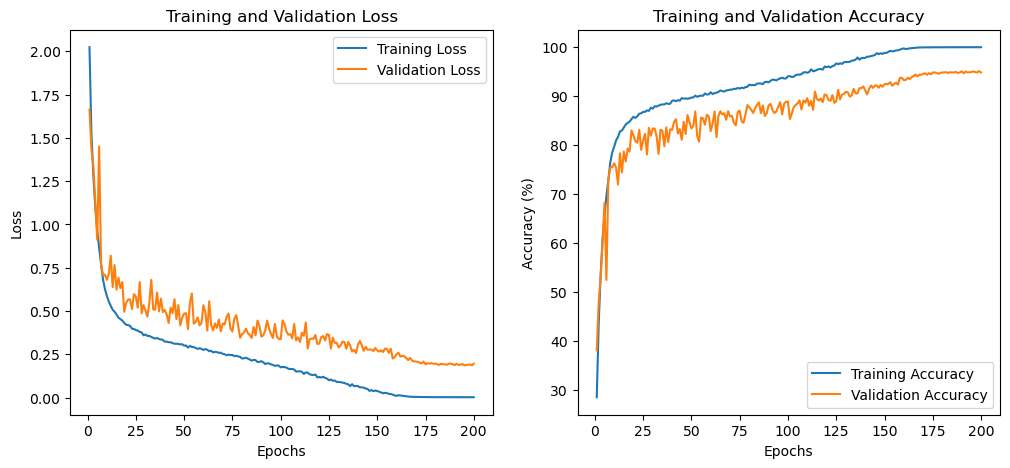

CPU times: user 32min 17s, sys: 9min 42s, total: 42min
Wall time: 2h 36min 4s


In [35]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = ResNet18()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

resnet18_0_1_SGD_train_losses = []
resnet18_0_1_SGD_val_losses = []
resnet18_0_1_SGD_train_accuracies = []
resnet18_0_1_SGD_val_accuracies = []


for epoch in range(start_epoch, 200):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    resnet18_0_1_SGD_train_losses.append(train_loss)
    resnet18_0_1_SGD_val_losses.append(val_loss)
    resnet18_0_1_SGD_train_accuracies.append(train_accuracy)
    resnet18_0_1_SGD_val_accuracies.append(val_accuracy)

state_resnet18_0_1_SGD,  acc_resnet18_0_1_SGD = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_resnet18_0_1_SGD)

plot_metrics(resnet18_0_1_SGD_train_losses, resnet18_0_1_SGD_val_losses, 
             resnet18_0_1_SGD_train_accuracies, resnet18_0_1_SGD_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [36]:
file_path_resnet18_0_1_SGD = "./result_and_model/resnet18_0_1_SGD_results.pkl"
model_state_path_resnet18_0_1_SGD = "./result_and_model/resnet18_0_1_SGD_model.pth"

with open(file_path_resnet18_0_1_SGD, "wb") as f:
    pickle.dump({
        "train_losses": resnet18_0_1_SGD_train_losses,
        "val_losses": resnet18_0_1_SGD_val_losses,
        "train_accuracies": resnet18_0_1_SGD_train_accuracies,
        "val_accuracies": resnet18_0_1_SGD_val_accuracies,
        "best_accuracy": acc_resnet18_0_1_SGD
    }, f)


torch.save(state_resnet18_0_1_SGD, model_state_path_resnet18_0_1_SGD)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = SGD

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=52.6, Loss=1.39]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=66.9, Loss=0.45]



Epoch: 2


Validation Epoch 2: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=69.3, Loss=0.723]



Epoch: 3


 Training Epoch 3: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=76.7, Loss=0.483
Validation Epoch 3: 100%|███| 79/79 [00:14<00:00,  5.58it/s, Acc=75, Loss=0.796]



Epoch: 4


 Training Epoch 4: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=80.2, Loss=0.225
Validation Epoch 4: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=77.4, Loss=0.601]



Epoch: 5


 Training Epoch 5: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=81.8, Loss=0.606
Validation Epoch 5: 100%|█| 79/79 [00:14<00:00,  5.47it/s, Acc=77.7, Loss=0.402]



Epoch: 6


 Training Epoch 6: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=83.6, Loss=0.265
Validation Epoch 6: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=82.3, Loss=0.545]



Epoch: 7


 Training Epoch 7: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=84.9, Loss=0.406
Validation Epoch 7: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=81.8, Loss=0.365]



Epoch: 8


 Training Epoch 8: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=86.1, Loss=0.525
Validation Epoch 8: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=84.3, Loss=0.335]



Epoch: 9


Validation Epoch 9: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=83.5, Loss=0.461]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=88.2, Loss=0.23
Validation Epoch 10: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=84.7, Loss=0.575



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=88.9, Loss=0.38
Validation Epoch 11: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.7, Loss=0.259



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=89.3, Loss=0.29
Validation Epoch 12: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=85.3, Loss=0.192



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=90, Loss=0.224]
Validation Epoch 13: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.8, Loss=0.264



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=90.6, Loss=0.20
Validation Epoch 14: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.7, Loss=0.355



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=91.1, Loss=0.12
Validation Epoch 15: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=83.6, Loss=0.375



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=91.7, Loss=0.31
Validation Epoch 16: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.6, Loss=0.247



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=92.2, Loss=0.30
Validation Epoch 17: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=85.3, Loss=0.752



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=92.6, Loss=0.16
Validation Epoch 18: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.1, Loss=0.153



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=92.9, Loss=0.16
Validation Epoch 19: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.2, Loss=0.238



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=93.3, Loss=0.15
Validation Epoch 20: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=85.3, Loss=0.525



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=93.5, Loss=0.29
Validation Epoch 21: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86.7, Loss=0.484



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=94, Loss=0.321]
Validation Epoch 22: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=88.3, Loss=0.239



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=94, Loss=0.102]
Validation Epoch 23: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=86.3, Loss=0.193



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=94.8, Loss=0.28
Validation Epoch 24: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.6, Loss=0.338



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=94.2, Loss=0.18
Validation Epoch 25: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.9, Loss=0.513



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=94.9, Loss=0.20
Validation Epoch 26: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.5, Loss=0.443



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=95.3, Loss=0.13
Validation Epoch 27: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=88.7, Loss=0.108



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=95.5, Loss=0.23
Validation Epoch 28: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.4, Loss=0.555



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=95.4, Loss=0.14
Validation Epoch 29: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.1, Loss=0.978



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=95.8, Loss=0.20
Validation Epoch 30: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88.8, Loss=0.32]



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=96, Loss=0.119]
Validation Epoch 31: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.5, Loss=0.424



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=96.3, Loss=0.23
Validation Epoch 32: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.8, Loss=0.136



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=96.2, Loss=0.11
Validation Epoch 33: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.7, Loss=0.274



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=96.6, Loss=0.03
Validation Epoch 34: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=88, Loss=0.222]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=96.7, Loss=0.20
Validation Epoch 35: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=87.5, Loss=0.154



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=96.9, Loss=0.09
Validation Epoch 36: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.5, Loss=0.264



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=97.1, Loss=0.18
Validation Epoch 37: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=89.7, Loss=0.218



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=96.9, Loss=0.17
Validation Epoch 38: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.9, Loss=0.332



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=97, Loss=0.106]
Validation Epoch 39: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.7, Loss=0.138



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=97.2, Loss=0.11
Validation Epoch 40: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=88.2, Loss=0.436



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=97.4, Loss=0.06
Validation Epoch 41: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=90.4, Loss=0.465



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=97.2, Loss=0.07
Validation Epoch 42: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.2, Loss=0.301



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=97.6, Loss=0.14
Validation Epoch 43: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.4, Loss=0.063



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=97.8, Loss=0.04
Validation Epoch 44: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.7, Loss=0.44]



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=98, Loss=0.0861
Validation Epoch 45: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.4, Loss=0.201



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=97.9, Loss=0.12
Validation Epoch 46: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=90.2, Loss=0.182



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=97.8, Loss=0.07
Validation Epoch 47: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.6, Loss=0.171



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=98.1, Loss=0.05
Validation Epoch 48: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.6, Loss=0.391



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=98.3, Loss=0.05
Validation Epoch 49: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.2, Loss=0.54]



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=98, Loss=0.0337
Validation Epoch 50: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.3, Loss=0.293



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=98.2, Loss=0.01
Validation Epoch 51: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=90.3, Loss=0.806



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=98.1, Loss=0.06
Validation Epoch 52: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.4, Loss=0.236



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=98.5, Loss=0.05
Validation Epoch 53: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=90.2, Loss=0.55]



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=98.4, Loss=0.05
Validation Epoch 54: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.2, Loss=0.382



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=98.5, Loss=0.09
Validation Epoch 55: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.9, Loss=0.552



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=98.4, Loss=0.05
Validation Epoch 56: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.6, Loss=0.844



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=98.4, Loss=0.04
Validation Epoch 57: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=90.6, Loss=0.481



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=98.5, Loss=0.00
Validation Epoch 58: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.8, Loss=0.775



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=98.9, Loss=0.03
Validation Epoch 59: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=90.8, Loss=0.405



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=98.7, Loss=0.01
Validation Epoch 60: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.4, Loss=0.175



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=98.8, Loss=0.02
Validation Epoch 61: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.9, Loss=0.319



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=99, Loss=0.0524
Validation Epoch 62: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.6, Loss=0.71]



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=98.9, Loss=0.07
Validation Epoch 63: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.8, Loss=0.073



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=98.9, Loss=0.00
Validation Epoch 64: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=90.9, Loss=0.12]



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=98.8, Loss=0.02
Validation Epoch 65: 100%|██| 79/79 [00:14<00:00,  5.62it/s, Acc=90, Loss=0.345]



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=99, Loss=0.0983
Validation Epoch 66: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.9, Loss=0.708



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=99, Loss=0.0292
Validation Epoch 67: 100%|██| 79/79 [00:14<00:00,  5.52it/s, Acc=91, Loss=0.427]



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=98.9, Loss=0.13
Validation Epoch 68: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=90.9, Loss=0.589



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=98.9, Loss=0.02
Validation Epoch 69: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=91.5, Loss=0.521



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=99, Loss=0.0072
Validation Epoch 70: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=90.7, Loss=0.604



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=99, Loss=0.0468
Validation Epoch 71: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=91.3, Loss=0.896



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=99.1, Loss=0.03
Validation Epoch 72: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.7, Loss=0.335



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=99.3, Loss=0.02
Validation Epoch 73: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.8, Loss=0.521



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=99, Loss=0.0020
Validation Epoch 74: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=91, Loss=0.217]



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=99.1, Loss=0.00
Validation Epoch 75: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=91.1, Loss=0.347



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=99.1, Loss=0.00
Validation Epoch 76: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=91.2, Loss=0.578



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=99.2, Loss=0.07
Validation Epoch 77: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.1, Loss=0.457



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=99.1, Loss=0.08
Validation Epoch 78: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.964



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=99.3, Loss=0.00
Validation Epoch 79: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.4, Loss=0.011



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=99.6, Loss=0.06
Validation Epoch 80: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.5, Loss=0.386



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=99.2, Loss=0.01
Validation Epoch 81: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.9, Loss=0.352



Epoch: 82


 Training Epoch 82: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=99.3, Loss=0.02
Validation Epoch 82: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=91.9, Loss=0.186



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=99.4, Loss=0.02
Validation Epoch 83: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.7, Loss=0.329



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=99.6, Loss=0.01
Validation Epoch 84: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.6, Loss=0.438



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=99.5, Loss=0.03
Validation Epoch 85: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=91.8, Loss=0.354



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=99.5, Loss=0.00
Validation Epoch 86: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=91.4, Loss=0.16]



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=99.6, Loss=0.05
Validation Epoch 87: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.2, Loss=0.608



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=99.5, Loss=0.01
Validation Epoch 88: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=91.4, Loss=0.069



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=99.5, Loss=0.02
Validation Epoch 89: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.4, Loss=0.115



Epoch: 90


 Training Epoch 90: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=99.4, Loss=0.03
Validation Epoch 90: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.8, Loss=0.402



Epoch: 91


 Training Epoch 91: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=99.5, Loss=0.00
Validation Epoch 91: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.6, Loss=0.079



Epoch: 92


 Training Epoch 92: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=99.7, Loss=0.00
Validation Epoch 92: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.4, Loss=0.317



Epoch: 93


 Training Epoch 93: 100%|█| 313/313 [00:32<00:00,  9.68it/s, Acc=99.8, Loss=0.00
Validation Epoch 93: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=92.3, Loss=0.436



Epoch: 94


 Training Epoch 94: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=99.8, Loss=0.00
Validation Epoch 94: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.5, Loss=0.617



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:32<00:00,  9.70it/s, Acc=99.8, Loss=0.00
Validation Epoch 95: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=92.1, Loss=0.551



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=99.8, Loss=0.00
Validation Epoch 96: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.2, Loss=0.657



Epoch: 97


 Training Epoch 97: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=99.9, Loss=0.00
Validation Epoch 97: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.3, Loss=0.702



Epoch: 98


 Training Epoch 98: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=99.8, Loss=0.01
Validation Epoch 98: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.2, Loss=0.317



Epoch: 99


 Training Epoch 99: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=99.8, Loss=0.00
Validation Epoch 99: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=92.4, Loss=0.366



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=99.8, Loss=0.0
Validation Epoch 100: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.1, Loss=0.58



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=99.8, Loss=0.0
Validation Epoch 101: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.3, Loss=0.55



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=99.8, Loss=0.0
Validation Epoch 102: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.5, Loss=0.13



Epoch: 103


 Training Epoch 103: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=99.9, Loss=0.0
Validation Epoch 103: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.9, Loss=0.09



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=99.9, Loss=0.0
Validation Epoch 104: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.4, Loss=0.49



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=99.8, Loss=0.0
Validation Epoch 105: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=92.7, Loss=0.22



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=99.9, Loss=0.0
Validation Epoch 106: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93, Loss=0.227]



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=99.9, Loss=0.0
Validation Epoch 107: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=92.3, Loss=0.37



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=99.8, Loss=0.0
Validation Epoch 108: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.6, Loss=0.34



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=99.9, Loss=0.0
Validation Epoch 109: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.8, Loss=0.32



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=99.8, Loss=0.0
Validation Epoch 110: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92, Loss=0.385]



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=99.9, Loss=0.0
Validation Epoch 111: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=92.8, Loss=0.04



Epoch: 112


 Training Epoch 112: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=99.9, Loss=0.0
Validation Epoch 112: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=93, Loss=0.191]



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=99.9, Loss=0.0
Validation Epoch 113: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.2, Loss=0.38



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=99.9, Loss=0.0
Validation Epoch 114: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.8, Loss=0.20



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=99.9, Loss=0.0
Validation Epoch 115: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.8, Loss=0.30



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=100, Loss=0.00
Validation Epoch 116: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.1, Loss=0.34



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=100, Loss=0.00
Validation Epoch 117: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.3, Loss=0.56



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=100, Loss=0.00
Validation Epoch 118: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.3, Loss=0.46



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=100, Loss=0.00
Validation Epoch 119: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.9, Loss=0.56



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=100, Loss=0.00
Validation Epoch 120: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93, Loss=0.381]



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=100, Loss=0.00
Validation Epoch 121: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.1, Loss=0.34



Epoch: 122


 Training Epoch 122: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=100, Loss=0.00
Validation Epoch 122: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.5, Loss=0.15



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 123: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=93.2, Loss=0.41



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=100, Loss=0.00
Validation Epoch 124: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.2, Loss=0.21



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:32<00:00,  9.65it/s, Acc=100, Loss=0.00
Validation Epoch 125: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.4, Loss=0.35



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=100, Loss=0.00
Validation Epoch 126: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.4, Loss=0.28



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=100, Loss=0.00
Validation Epoch 127: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.3, Loss=0.43



Epoch: 128


 Training Epoch 128: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=100, Loss=0.00
Validation Epoch 128: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.2, Loss=0.43



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=100, Loss=0.00
Validation Epoch 129: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=93.6, Loss=0.29



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=100, Loss=0.00
Validation Epoch 130: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.4, Loss=0.38



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=100, Loss=0.00
Validation Epoch 131: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.2, Loss=0.36



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=100, Loss=0.00
Validation Epoch 132: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.2, Loss=0.53



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:32<00:00,  9.65it/s, Acc=100, Loss=0.00
Validation Epoch 133: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.6, Loss=0.27



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:32<00:00,  9.66it/s, Acc=100, Loss=0.00
Validation Epoch 134: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.1, Loss=0.36



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=100, Loss=0.00
Validation Epoch 135: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.7, Loss=0.24



Epoch: 136


 Training Epoch 136: 100%|█| 313/313 [00:32<00:00,  9.65it/s, Acc=100, Loss=0.00
Validation Epoch 136: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=93.5, Loss=0.51



Epoch: 137


 Training Epoch 137: 100%|█| 313/313 [00:32<00:00,  9.69it/s, Acc=100, Loss=0.00
Validation Epoch 137: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.6, Loss=0.31



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=100, Loss=0.00
Validation Epoch 138: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.6, Loss=0.40



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=100, Loss=0.00
Validation Epoch 139: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.6, Loss=0.55



Epoch: 140


 Training Epoch 140: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=100, Loss=0.00
Validation Epoch 140: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.4, Loss=0.36



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 141: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.5, Loss=0.46



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 142: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.3, Loss=0.38



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=100, Loss=0.00
Validation Epoch 143: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.5, Loss=0.25



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=100, Loss=0.00
Validation Epoch 144: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.5, Loss=0.29



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=100, Loss=0.00
Validation Epoch 145: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.6, Loss=0.41



Epoch: 146


 Training Epoch 146: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=100, Loss=0.00
Validation Epoch 146: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.6, Loss=0.32



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=100, Loss=0.00
Validation Epoch 147: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=93.5, Loss=0.43



Epoch: 148


 Training Epoch 148: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=100, Loss=0.00
Validation Epoch 148: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.9, Loss=0.37



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=100, Loss=0.00
Validation Epoch 149: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.5, Loss=0.26



Epoch: 150


 Training Epoch 150: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 150: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.5, Loss=0.48



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 151: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.7, Loss=0.37



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 152: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.3, Loss=0.12



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 153: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.6, Loss=0.20



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 154: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=93.6, Loss=0.22



Epoch: 155


 Training Epoch 155: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 155: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.6, Loss=0.27



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=100, Loss=0.00
Validation Epoch 156: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.4, Loss=0.40



Epoch: 157


 Training Epoch 157: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 157: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.7, Loss=0.09



Epoch: 158


 Training Epoch 158: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 158: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.6, Loss=0.36



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=100, Loss=0.00
Validation Epoch 159: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=93.5, Loss=0.32



Epoch: 160


 Training Epoch 160: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=100, Loss=0.00
Validation Epoch 160: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.5, Loss=0.23



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:32<00:00,  9.58it/s, Acc=100, Loss=0.00
Validation Epoch 161: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.6, Loss=0.32



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 162: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.5, Loss=0.43



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 163: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=93.4, Loss=0.27



Epoch: 164


 Training Epoch 164: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 164: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=93.6, Loss=0.36



Epoch: 165


 Training Epoch 165: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=100, Loss=0.00
Validation Epoch 165: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.6, Loss=0.22



Epoch: 166


 Training Epoch 166: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 166: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.5, Loss=0.38



Epoch: 167


 Training Epoch 167: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=100, Loss=0.00
Validation Epoch 167: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.8, Loss=0.18



Epoch: 168


 Training Epoch 168: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=100, Loss=0.00
Validation Epoch 168: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.5, Loss=0.04



Epoch: 169


 Training Epoch 169: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=100, Loss=0.00
Validation Epoch 169: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.6, Loss=0.30



Epoch: 170


 Training Epoch 170: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=100, Loss=0.00
Validation Epoch 170: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.9, Loss=0.41



Epoch: 171


 Training Epoch 171: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 171: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.5, Loss=0.43



Epoch: 172


 Training Epoch 172: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 172: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.6, Loss=0.40



Epoch: 173


 Training Epoch 173: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 173: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.5, Loss=0.49



Epoch: 174


 Training Epoch 174: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 174: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.6, Loss=0.10



Epoch: 175


 Training Epoch 175: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 175: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=93.8, Loss=0.29



Epoch: 176


 Training Epoch 176: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 176: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=93.6, Loss=0.52



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=100, Loss=0.00
Validation Epoch 177: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=93.3, Loss=0.31



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 178: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.5, Loss=0.32



Epoch: 179


 Training Epoch 179: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 179: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=93.6, Loss=0.07



Epoch: 180


 Training Epoch 180: 100%|█| 313/313 [00:32<00:00,  9.56it/s, Acc=100, Loss=0.00
Validation Epoch 180: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.9, Loss=0.26



Epoch: 181


 Training Epoch 181: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=100, Loss=0.00
Validation Epoch 181: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=93.4, Loss=0.40



Epoch: 182


 Training Epoch 182: 100%|█| 313/313 [00:32<00:00,  9.55it/s, Acc=100, Loss=0.00
Validation Epoch 182: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=93.5, Loss=0.44



Epoch: 183


 Training Epoch 183: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 183: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.5, Loss=0.41



Epoch: 184


 Training Epoch 184: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 184: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.5, Loss=0.22



Epoch: 185


 Training Epoch 185: 100%|█| 313/313 [00:32<00:00,  9.57it/s, Acc=100, Loss=0.00
Validation Epoch 185: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.4, Loss=0.08



Epoch: 186


 Training Epoch 186: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=100, Loss=0.00
Validation Epoch 186: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.8, Loss=0.33



Epoch: 187


 Training Epoch 187: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=100, Loss=0.00
Validation Epoch 187: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.5, Loss=0.29



Epoch: 188


 Training Epoch 188: 100%|█| 313/313 [00:32<00:00,  9.59it/s, Acc=100, Loss=0.00
Validation Epoch 188: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=93.5, Loss=0.22



Epoch: 189


 Training Epoch 189: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=100, Loss=0.00
Validation Epoch 189: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.7, Loss=0.04



Epoch: 190


 Training Epoch 190: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=100, Loss=0.00
Validation Epoch 190: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=93.8, Loss=0.19



Epoch: 191


 Training Epoch 191: 100%|█| 313/313 [00:32<00:00,  9.64it/s, Acc=100, Loss=0.00
Validation Epoch 191: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.6, Loss=0.22



Epoch: 192


 Training Epoch 192: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=100, Loss=0.00
Validation Epoch 192: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.6, Loss=0.45



Epoch: 193


 Training Epoch 193: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=100, Loss=0.00
Validation Epoch 193: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.8, Loss=0.21



Epoch: 194


 Training Epoch 194: 100%|█| 313/313 [00:32<00:00,  9.62it/s, Acc=100, Loss=0.00
Validation Epoch 194: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=93.9, Loss=0.44



Epoch: 195


 Training Epoch 195: 100%|█| 313/313 [00:32<00:00,  9.63it/s, Acc=100, Loss=0.00
Validation Epoch 195: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=93.4, Loss=0.12



Epoch: 196


 Training Epoch 196: 100%|█| 313/313 [00:32<00:00,  9.65it/s, Acc=100, Loss=0.00
Validation Epoch 196: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=94, Loss=0.272]



Epoch: 197


 Training Epoch 197: 100%|█| 313/313 [00:32<00:00,  9.65it/s, Acc=100, Loss=0.00
Validation Epoch 197: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93.7, Loss=0.25



Epoch: 198


 Training Epoch 198: 100%|█| 313/313 [00:32<00:00,  9.61it/s, Acc=100, Loss=0.00
Validation Epoch 198: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.8, Loss=0.28



Epoch: 199


 Training Epoch 199: 100%|█| 313/313 [00:32<00:00,  9.60it/s, Acc=100, Loss=0.00
Validation Epoch 199: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.3, Loss=0.38

Validation Accuracy:  94.02


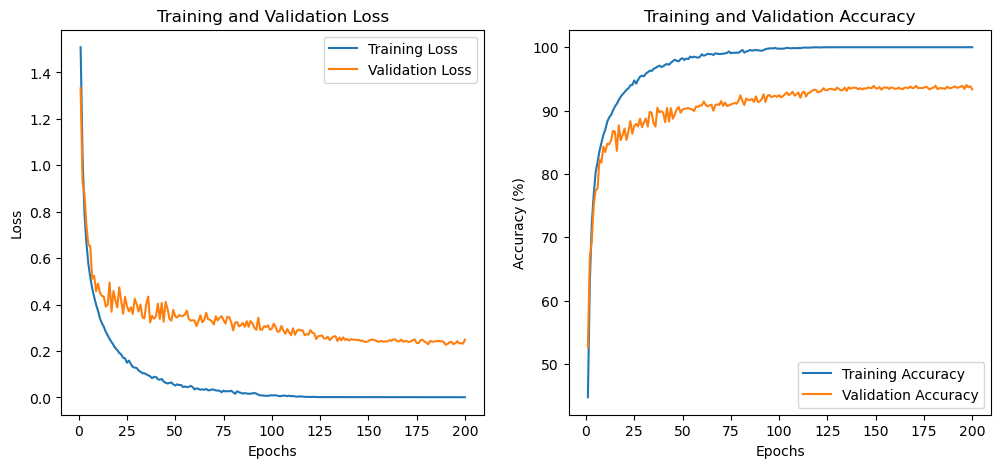

CPU times: user 32min 36s, sys: 9min 47s, total: 42min 23s
Wall time: 2h 36min 16s


In [37]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = ResNet18()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

resnet18_0_0_1_SGD_train_losses = []
resnet18_0_0_1_SGD_val_losses = []
resnet18_0_0_1_SGD_train_accuracies = []
resnet18_0_0_1_SGD_val_accuracies = []

for epoch in range(start_epoch, 200):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    resnet18_0_0_1_SGD_train_losses.append(train_loss)
    resnet18_0_0_1_SGD_val_losses.append(val_loss)
    resnet18_0_0_1_SGD_train_accuracies.append(train_accuracy)
    resnet18_0_0_1_SGD_val_accuracies.append(val_accuracy)

state_resnet18_0_0_1_SGD,  acc_resnet18_0_0_1_SGD = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_resnet18_0_0_1_SGD)

plot_metrics(resnet18_0_0_1_SGD_train_losses, resnet18_0_0_1_SGD_val_losses, 
             resnet18_0_0_1_SGD_train_accuracies, resnet18_0_0_1_SGD_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [38]:
file_path_resnet18_0_0_1_SGD = "./result_and_model/resnet18_0_0_1_SGD_results.pkl"
model_state_path_resnet18_0_0_1_SGD = "./result_and_model/resnet18_0_0_1_SGD_model.pth"

with open(file_path_resnet18_0_0_1_SGD, "wb") as f:
    pickle.dump({
        "train_losses": resnet18_0_0_1_SGD_train_losses,
        "val_losses": resnet18_0_0_1_SGD_val_losses,
        "train_accuracies": resnet18_0_0_1_SGD_train_accuracies,
        "val_accuracies": resnet18_0_0_1_SGD_val_accuracies,
        "best_accuracy": acc_resnet18_0_0_1_SGD
    }, f)


torch.save(state_resnet18_0_0_1_SGD, model_state_path_resnet18_0_0_1_SGD)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.1, Optimizer = Adam

Epoch: 0


Validation Epoch 0: 100%|██████| 79/79 [00:13<00:00,  5.65it/s, Acc=20.6, Loss=1.98]



Epoch: 1


Validation Epoch 1: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=29.1, Loss=1.65]



Epoch: 2


Validation Epoch 2: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=36.9, Loss=1.82]



Epoch: 3


Validation Epoch 3: 100%|████████| 79/79 [00:14<00:00,  5.64it/s, Acc=50, Loss=1.54]



Epoch: 4


Validation Epoch 4: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=51.2, Loss=0.996]



Epoch: 5


Validation Epoch 5: 100%|█████| 79/79 [00:14<00:00,  5.28it/s, Acc=62.5, Loss=0.466]



Epoch: 6


Validation Epoch 6: 100%|█████| 79/79 [00:14<00:00,  5.36it/s, Acc=69.8, Loss=0.465]



Epoch: 7


Validation Epoch 7: 100%|████████| 79/79 [00:14<00:00,  5.41it/s, Acc=68, Loss=1.05]



Epoch: 8


Validation Epoch 8: 100%|████████| 79/79 [00:14<00:00,  5.35it/s, Acc=73, Loss=0.77]



Epoch: 9


Validation Epoch 9: 100%|███████| 79/79 [00:14<00:00,  5.51it/s, Acc=74, Loss=0.345]



Epoch: 10


Validation Epoch 10: 100%|████| 79/79 [00:14<00:00,  5.50it/s, Acc=76.2, Loss=0.478]



Epoch: 11


Validation Epoch 11: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=76.3, Loss=0.465]



Epoch: 12


Validation Epoch 12: 100%|████| 79/79 [00:14<00:00,  5.56it/s, Acc=79.3, Loss=0.249]



Epoch: 13


Validation Epoch 13: 100%|████| 79/79 [00:14<00:00,  5.57it/s, Acc=79.6, Loss=0.297]



Epoch: 14


Validation Epoch 14: 100%|████| 79/79 [00:14<00:00,  5.56it/s, Acc=81.5, Loss=0.354]



Epoch: 15


Validation Epoch 15: 100%|████| 79/79 [00:14<00:00,  5.56it/s, Acc=81.2, Loss=0.144]



Epoch: 16


Validation Epoch 16: 100%|██████| 79/79 [00:14<00:00,  5.53it/s, Acc=82.3, Loss=0.1]



Epoch: 17


Validation Epoch 17: 100%|████| 79/79 [00:14<00:00,  5.51it/s, Acc=82.5, Loss=0.436]



Epoch: 18


Validation Epoch 18: 100%|████| 79/79 [00:14<00:00,  5.50it/s, Acc=83.1, Loss=0.129]



Epoch: 19


Validation Epoch 19: 100%|█████| 79/79 [00:14<00:00,  5.48it/s, Acc=82.5, Loss=0.39]



Epoch: 20


Validation Epoch 20: 100%|████| 79/79 [00:14<00:00,  5.53it/s, Acc=82.3, Loss=0.254]



Epoch: 21


Validation Epoch 21: 100%|████| 79/79 [00:14<00:00,  5.56it/s, Acc=80.2, Loss=0.434]



Epoch: 22


Validation Epoch 22: 100%|█████| 79/79 [00:14<00:00,  5.58it/s, Acc=84.9, Loss=0.17]



Epoch: 23


Validation Epoch 23: 100%|████| 79/79 [00:14<00:00,  5.58it/s, Acc=84.4, Loss=0.273]



Epoch: 24


Validation Epoch 24: 100%|██████| 79/79 [00:14<00:00,  5.59it/s, Acc=82, Loss=0.113]



Epoch: 25


Validation Epoch 25: 100%|████| 79/79 [00:14<00:00,  5.57it/s, Acc=84.1, Loss=0.402]



Epoch: 26


Validation Epoch 26: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=85.2, Loss=0.108]



Epoch: 27


Validation Epoch 27: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=84.4, Loss=0.184]



Epoch: 28


Validation Epoch 28: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=85.5, Loss=0.377]



Epoch: 29


Validation Epoch 29: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=86.1, Loss=0.135]



Epoch: 30


Validation Epoch 30: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=87.3, Loss=0.207]



Epoch: 31


Validation Epoch 31: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=86.3, Loss=0.519]



Epoch: 32


Validation Epoch 32: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=86.9, Loss=0.0671]



Epoch: 33


Validation Epoch 33: 100%|██████| 79/79 [00:14<00:00,  5.56it/s, Acc=85.2, Loss=0.4]



Epoch: 34


Validation Epoch 34: 100%|█████| 79/79 [00:14<00:00,  5.57it/s, Acc=86.7, Loss=0.18]



Epoch: 35


Validation Epoch 35: 100%|████| 79/79 [00:14<00:00,  5.59it/s, Acc=84.7, Loss=0.142]



Epoch: 36


Validation Epoch 36: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=86.8, Loss=0.445]



Epoch: 37


Validation Epoch 37: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=88.1, Loss=0.328]



Epoch: 38


Validation Epoch 38: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=87.3, Loss=0.36]



Epoch: 39


Validation Epoch 39: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=87.1, Loss=0.195]



Epoch: 40


Validation Epoch 40: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=87.8, Loss=0.109]



Epoch: 41


Validation Epoch 41: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=88.4, Loss=0.0712]



Epoch: 42


Validation Epoch 42: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=88.7, Loss=0.4]



Epoch: 43


Validation Epoch 43: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=87.1, Loss=0.445]



Epoch: 44


Validation Epoch 44: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=87.8, Loss=0.539]



Epoch: 45


Validation Epoch 45: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=87.4, Loss=0.617]



Epoch: 46


Validation Epoch 46: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=87.7, Loss=0.104]



Epoch: 47


Validation Epoch 47: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=87.9, Loss=0.312]



Epoch: 48


Validation Epoch 48: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.7, Loss=0.18]



Epoch: 49


Validation Epoch 49: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=88.2, Loss=0.416]



Epoch: 50


Validation Epoch 50: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=87.9, Loss=0.169]



Epoch: 51


Validation Epoch 51: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=88.2, Loss=0.0677]



Epoch: 52


Validation Epoch 52: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=88.5, Loss=0.227]



Epoch: 53


Validation Epoch 53: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.5, Loss=0.433]



Epoch: 54


Validation Epoch 54: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.5, Loss=0.135]



Epoch: 55


Validation Epoch 55: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=87.2, Loss=0.276]



Epoch: 56


Validation Epoch 56: 100%|██████| 79/79 [00:13<00:00,  5.64it/s, Acc=89, Loss=0.606]



Epoch: 57


Validation Epoch 57: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=88.8, Loss=0.135]



Epoch: 58


Validation Epoch 58: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=87.5, Loss=0.121]



Epoch: 59


Validation Epoch 59: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=88.5, Loss=0.0489]



Epoch: 60


Validation Epoch 60: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=88.9, Loss=0.235]



Epoch: 61


Validation Epoch 61: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=89.4, Loss=0.0653]



Epoch: 62


Validation Epoch 62: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=89.1, Loss=0.304]



Epoch: 63


Validation Epoch 63: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.1, Loss=0.869]



Epoch: 64


Validation Epoch 64: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.1, Loss=0.354]



Epoch: 65


Validation Epoch 65: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=89.3, Loss=0.234]



Epoch: 66


Validation Epoch 66: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.4, Loss=0.49]



Epoch: 67


Validation Epoch 67: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.6, Loss=0.288]



Epoch: 68


Validation Epoch 68: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.8, Loss=0.398]



Epoch: 69


Validation Epoch 69: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=89.2, Loss=0.661]



Epoch: 70


Validation Epoch 70: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.3, Loss=0.411]



Epoch: 71


Validation Epoch 71: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.8, Loss=0.345]



Epoch: 72


Validation Epoch 72: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.3, Loss=0.298]



Epoch: 73


Validation Epoch 73: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=88.4, Loss=0.794]



Epoch: 74


Validation Epoch 74: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.3, Loss=0.102]



Epoch: 75


Validation Epoch 75: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=88.4, Loss=0.0433]



Epoch: 76


Validation Epoch 76: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=88.8, Loss=1.02]



Epoch: 77


Validation Epoch 77: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.6, Loss=0.442]



Epoch: 78


Validation Epoch 78: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=89.5, Loss=0.0495]



Epoch: 79


Validation Epoch 79: 100%|██████| 79/79 [00:13<00:00,  5.65it/s, Acc=90, Loss=0.324]



Epoch: 80


Validation Epoch 80: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.7, Loss=0.443]



Epoch: 81


Validation Epoch 81: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.5, Loss=0.864]



Epoch: 82


Validation Epoch 82: 100%|██| 79/79 [00:13<00:00,  5.65it/s, Acc=89.7, Loss=0.00439]



Epoch: 83


Validation Epoch 83: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.7, Loss=0.167]



Epoch: 84


Validation Epoch 84: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.4, Loss=0.28]



Epoch: 85


Validation Epoch 85: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.6, Loss=0.281]



Epoch: 86


Validation Epoch 86: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.8, Loss=0.465]



Epoch: 87


Validation Epoch 87: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=89.9, Loss=0.717]



Epoch: 88


Validation Epoch 88: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.2, Loss=0.194]



Epoch: 89


Validation Epoch 89: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=89.7, Loss=0.566]



Epoch: 90


Validation Epoch 90: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.2, Loss=0.302]



Epoch: 91


Validation Epoch 91: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=90.3, Loss=0.0494]



Epoch: 92


Validation Epoch 92: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.5, Loss=0.575]



Epoch: 93


Validation Epoch 93: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=90.1, Loss=0.311]



Epoch: 94


 Training Epoch 94: 100%|█| 313/313 [00:31<00:00,  9.88it/s, Acc=99.1, Loss=0.000855
Validation Epoch 94: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.3, Loss=0.309]



Epoch: 95


Validation Epoch 95: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.1, Loss=0.387]



Epoch: 96


Validation Epoch 96: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=90, Loss=0.236]



Epoch: 97


Validation Epoch 97: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.2, Loss=0.0106]



Epoch: 98


Validation Epoch 98: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=90.2, Loss=0.498]



Epoch: 99


Validation Epoch 99: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=90, Loss=0.595]



Epoch: 100


Validation Epoch 100: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=89.8, Loss=0.701]



Epoch: 101


Validation Epoch 101: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.6, Loss=0.207]



Epoch: 102


Validation Epoch 102: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.2, Loss=0.673]



Epoch: 103


Validation Epoch 103: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.5, Loss=0.588]



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:31<00:00,  9.91it/s, Acc=99.2, Loss=0.00184
Validation Epoch 104: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=90.4, Loss=0.699]



Epoch: 105


Validation Epoch 105: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=90.8, Loss=0.356]



Epoch: 106


Validation Epoch 106: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.7, Loss=0.257]



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:31<00:00,  9.86it/s, Acc=99.5, Loss=0.00424
Validation Epoch 107: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=90.6, Loss=0.198]



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:31<00:00,  9.87it/s, Acc=99.5, Loss=0.00569
Validation Epoch 108: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.5, Loss=0.514]



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:31<00:00,  9.89it/s, Acc=99.5, Loss=0.00432
Validation Epoch 109: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=90.7, Loss=0.168]



Epoch: 110


Validation Epoch 110: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.9, Loss=0.303]



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:31<00:00,  9.90it/s, Acc=99.5, Loss=0.00033
Validation Epoch 111: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=91, Loss=0.568]



Epoch: 112


Validation Epoch 112: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.4, Loss=1.25]



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:31<00:00,  9.86it/s, Acc=99.5, Loss=0.00416
Validation Epoch 113: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=90.8, Loss=0.353]



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:31<00:00,  9.86it/s, Acc=99.6, Loss=0.00109
Validation Epoch 114: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.9, Loss=0.171]



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:31<00:00,  9.92it/s, Acc=99.7, Loss=0.00048
Validation Epoch 115: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=91.1, Loss=0.792]



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:31<00:00,  9.87it/s, Acc=99.5, Loss=0.00266
Validation Epoch 116: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=90.7, Loss=0.427]



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:31<00:00,  9.85it/s, Acc=99.7, Loss=7.77e-5
Validation Epoch 117: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=91, Loss=0.516]



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:31<00:00,  9.90it/s, Acc=99.7, Loss=0.00054
Validation Epoch 118: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.2, Loss=0.43]



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:31<00:00,  9.92it/s, Acc=99.6, Loss=0.00417
Validation Epoch 119: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=90.7, Loss=0.842]



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:31<00:00,  9.89it/s, Acc=99.7, Loss=0.00022
Validation Epoch 120: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.8, Loss=1.03]



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:31<00:00,  9.90it/s, Acc=99.7, Loss=0.00081
Validation Epoch 121: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=90.6, Loss=0.55]



Epoch: 122


Validation Epoch 122: 100%|███| 79/79 [00:13<00:00,  5.66it/s, Acc=90.9, Loss=0.303]



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:31<00:00,  9.91it/s, Acc=99.7, Loss=0.00304
Validation Epoch 123: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.6, Loss=0.42]



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:31<00:00,  9.85it/s, Acc=99.7, Loss=0.00145
Validation Epoch 124: 100%|██| 79/79 [00:14<00:00,  5.64it/s, Acc=91.2, Loss=0.0923]



Epoch: 125


Validation Epoch 125: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=90.8, Loss=0.853]



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:31<00:00,  9.87it/s, Acc=99.8, Loss=0.00054
Validation Epoch 126: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=90.8, Loss=0.605]



Epoch: 127


Validation Epoch 127: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=90.8, Loss=0.342]



Epoch: 128


Validation Epoch 128: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.2, Loss=1.01]



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:31<00:00,  9.89it/s, Acc=99.8, Loss=0.00043
Validation Epoch 129: 100%|██████| 79/79 [00:13<00:00,  5.65it/s, Acc=91, Loss=1.36]



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:31<00:00,  9.89it/s, Acc=99.8, Loss=0.00287
Validation Epoch 130: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.9, Loss=0.43]



Epoch: 131


Validation Epoch 131: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.9, Loss=0.576]



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:31<00:00,  9.87it/s, Acc=99.8, Loss=0.00060
Validation Epoch 132: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=91.2, Loss=0.124]



Epoch: 133


Validation Epoch 133: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=90.9, Loss=0.741]



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:31<00:00,  9.86it/s, Acc=99.8, Loss=0.00010
Validation Epoch 134: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.1, Loss=0.15]



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:31<00:00,  9.89it/s, Acc=99.8, Loss=0.00378
Validation Epoch 135: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.5, Loss=0.115]



Epoch: 136


Validation Epoch 136: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.3, Loss=0.455]



Epoch: 137


 Training Epoch 137: 100%|█| 313/313 [00:31<00:00,  9.90it/s, Acc=99.9, Loss=8.52e-5
Validation Epoch 137: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=90.8, Loss=0.156]



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:31<00:00,  9.92it/s, Acc=99.9, Loss=3.57e-5
Validation Epoch 138: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=91, Loss=0.788]



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:31<00:00,  9.84it/s, Acc=99.9, Loss=0.00038
Validation Epoch 139: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=91.4, Loss=0.518]



Epoch: 140


Validation Epoch 140: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=91.3, Loss=0.479]



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:31<00:00,  9.81it/s, Acc=99.9, Loss=4.34e-5
Validation Epoch 141: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=91.5, Loss=0.419]



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:31<00:00,  9.90it/s, Acc=99.9, Loss=0.00058
Validation Epoch 142: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.2, Loss=1.35]



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:31<00:00,  9.88it/s, Acc=99.9, Loss=1.15e-5
Validation Epoch 143: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=91.1, Loss=0.177]



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:31<00:00,  9.89it/s, Acc=99.9, Loss=0.00137
Validation Epoch 144: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=91.2, Loss=0.12]



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:31<00:00,  9.89it/s, Acc=99.9, Loss=0.00023
Validation Epoch 145: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=91.2, Loss=0.407]



Epoch: 146


Validation Epoch 146: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.1, Loss=0.26]



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:31<00:00,  9.82it/s, Acc=99.9, Loss=0.00164
Validation Epoch 147: 100%|███| 79/79 [00:14<00:00,  5.56it/s, Acc=91.4, Loss=0.524]



Epoch: 148


Validation Epoch 148: 100%|███| 79/79 [00:14<00:00,  5.61it/s, Acc=91.4, Loss=0.286]



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:31<00:00,  9.83it/s, Acc=99.9, Loss=0.00231
Validation Epoch 149: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=91.5, Loss=0.327]



Epoch: 150


Validation Epoch 150: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=91.5, Loss=0.78]



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:31<00:00,  9.87it/s, Acc=99.9, Loss=0.00274
Validation Epoch 151: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=91.4, Loss=0.309]



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:31<00:00,  9.91it/s, Acc=99.9, Loss=0.00173
Validation Epoch 152: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.3, Loss=0.736]



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:31<00:00,  9.88it/s, Acc=99.9, Loss=1.54e-6
Validation Epoch 153: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.6, Loss=0.372]



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:31<00:00,  9.79it/s, Acc=99.9, Loss=0.00714
Validation Epoch 154: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=91.2, Loss=0.425]



Epoch: 155


Validation Epoch 155: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.5, Loss=0.331]



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:31<00:00,  9.84it/s, Acc=99.9, Loss=1.64e-5
Validation Epoch 156: 100%|███| 79/79 [00:14<00:00,  5.59it/s, Acc=91.5, Loss=0.212]



Epoch: 157


Validation Epoch 157: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=91.4, Loss=0.363]



Epoch: 158


 Training Epoch 158: 100%|█| 313/313 [00:31<00:00,  9.79it/s, Acc=100, Loss=0.000881
Validation Epoch 158: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.5, Loss=0.613]



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:31<00:00,  9.81it/s, Acc=99.9, Loss=1.23e-5
Validation Epoch 159: 100%|██| 79/79 [00:13<00:00,  5.65it/s, Acc=91.7, Loss=0.0347]



Epoch: 160


Validation Epoch 160: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.6, Loss=0.349]



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:31<00:00,  9.84it/s, Acc=100, Loss=0.000338
Validation Epoch 161: 100%|███| 79/79 [00:14<00:00,  5.53it/s, Acc=91.7, Loss=0.578]



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:31<00:00,  9.83it/s, Acc=100, Loss=0.000511
Validation Epoch 162: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.774]



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:31<00:00,  9.90it/s, Acc=100, Loss=0.000138
Validation Epoch 163: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.5, Loss=0.838]



Epoch: 164


Validation Epoch 164: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=91.4, Loss=0.177]



Epoch: 165


Validation Epoch 165: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=91.6, Loss=0.542]



Epoch: 166


Validation Epoch 166: 100%|█████| 79/79 [00:14<00:00,  5.60it/s, Acc=91.4, Loss=0.2]



Epoch: 167


Validation Epoch 167: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.7, Loss=0.466]



Epoch: 168


Validation Epoch 168: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.564]



Epoch: 169


Validation Epoch 169: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=91.7, Loss=0.178]



Epoch: 170


Validation Epoch 170: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=91.5, Loss=0.0909]



Epoch: 171


Validation Epoch 171: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=91.4, Loss=0.558]



Epoch: 172


Validation Epoch 172: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=91.5, Loss=0.526]



Epoch: 173


Validation Epoch 173: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=91.4, Loss=0.8]



Epoch: 174


Validation Epoch 174: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=91.7, Loss=0.384]



Epoch: 175


Validation Epoch 175: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=91.6, Loss=0.294]



Epoch: 176


Validation Epoch 176: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=91.7, Loss=0.329]



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:31<00:00,  9.87it/s, Acc=100, Loss=0.000582
Validation Epoch 177: 100%|███| 79/79 [00:14<00:00,  5.57it/s, Acc=91.7, Loss=0.925]



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:31<00:00,  9.93it/s, Acc=100, Loss=0.000105
Validation Epoch 178: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=91.7, Loss=0.418]



Epoch: 179


Validation Epoch 179: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=91.8, Loss=0.0743]

Validation Accuracy:  91.79


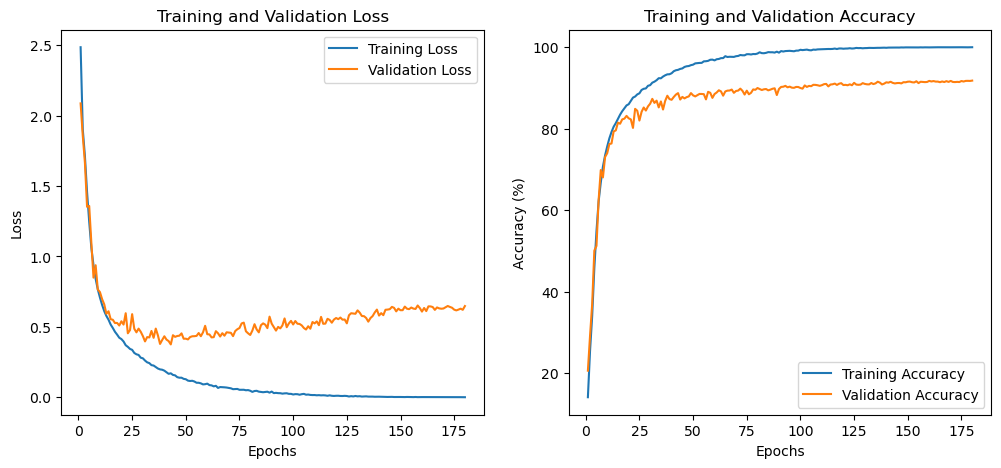

CPU times: user 33min 9s, sys: 8min 33s, total: 41min 43s
Wall time: 2h 20min 12s


In [39]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = ResNet18()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

resnet18_0_1_Adam_train_losses = []
resnet18_0_1_Adam_val_losses = []
resnet18_0_1_Adam_train_accuracies = []
resnet18_0_1_Adam_val_accuracies = []

for epoch in range(start_epoch, 180):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    resnet18_0_1_Adam_train_losses.append(train_loss)
    resnet18_0_1_Adam_val_losses.append(val_loss)
    resnet18_0_1_Adam_train_accuracies.append(train_accuracy)
    resnet18_0_1_Adam_val_accuracies.append(val_accuracy)

state_resnet18_0_1_Adam,  acc_resnet18_0_1_Adam = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_resnet18_0_1_Adam)

plot_metrics(resnet18_0_1_Adam_train_losses, resnet18_0_1_Adam_val_losses, 
             resnet18_0_1_Adam_train_accuracies, resnet18_0_1_Adam_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [40]:
file_path_resnet18_0_1_Adam = "./result_and_model/resnet18_0_1_Adam_results.pkl"
model_state_path_resnet18_0_1_Adam = "./result_and_model/resnet18_0_1_Adam_model.pth"

with open(file_path_resnet18_0_1_Adam, "wb") as f:
    pickle.dump({
        "train_losses": resnet18_0_1_Adam_train_losses,
        "val_losses": resnet18_0_1_Adam_val_losses,
        "train_accuracies": resnet18_0_1_Adam_train_accuracies,
        "val_accuracies": resnet18_0_1_Adam_val_accuracies,
        "best_accuracy": acc_resnet18_0_1_Adam
    }, f)


torch.save(state_resnet18_0_1_Adam, model_state_path_resnet18_0_1_Adam)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = Adam

Epoch: 0


Validation Epoch 0: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=38.2, Loss=1.63]



Epoch: 1


Validation Epoch 1: 100%|██████| 79/79 [00:13<00:00,  5.65it/s, Acc=51.3, Loss=1.39]



Epoch: 2


Validation Epoch 2: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=59.9, Loss=0.804]



Epoch: 3


Validation Epoch 3: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=66.6, Loss=0.445]



Epoch: 4


Validation Epoch 4: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=72.3, Loss=0.562]



Epoch: 5


Validation Epoch 5: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=73.7, Loss=0.39]



Epoch: 6


Validation Epoch 6: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=78.5, Loss=0.397]



Epoch: 7


Validation Epoch 7: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=77.7, Loss=0.409]



Epoch: 8


Validation Epoch 8: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=81.1, Loss=0.213]



Epoch: 9


Validation Epoch 9: 100%|███████| 79/79 [00:14<00:00,  5.63it/s, Acc=82, Loss=0.366]



Epoch: 10


Validation Epoch 10: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=83.7, Loss=0.285]



Epoch: 11


Validation Epoch 11: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=84.6, Loss=0.103]



Epoch: 12


Validation Epoch 12: 100%|██████| 79/79 [00:13<00:00,  5.66it/s, Acc=85, Loss=0.224]



Epoch: 13


Validation Epoch 13: 100%|██████| 79/79 [00:13<00:00,  5.66it/s, Acc=84, Loss=0.226]



Epoch: 14


Validation Epoch 14: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=86.1, Loss=0.436]



Epoch: 15


Validation Epoch 15: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=84.9, Loss=0.186]



Epoch: 16


Validation Epoch 16: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=87, Loss=0.254]



Epoch: 17


Validation Epoch 17: 100%|██████| 79/79 [00:13<00:00,  5.65it/s, Acc=87, Loss=0.421]



Epoch: 18


Validation Epoch 18: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=86.3, Loss=0.341]



Epoch: 19


Validation Epoch 19: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=87.9, Loss=0.285]



Epoch: 20


Validation Epoch 20: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=87.5, Loss=0.306]



Epoch: 21


Validation Epoch 21: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=86.8, Loss=0.747]



Epoch: 22


Validation Epoch 22: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=88.1, Loss=0.451]



Epoch: 23


Validation Epoch 23: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=86.7, Loss=0.405]



Epoch: 24


Validation Epoch 24: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.5, Loss=0.338]



Epoch: 25


Validation Epoch 25: 100%|████| 79/79 [00:14<00:00,  5.59it/s, Acc=88.3, Loss=0.336]



Epoch: 26


Validation Epoch 26: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=87.5, Loss=0.332]



Epoch: 27


Validation Epoch 27: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.7, Loss=0.319]



Epoch: 28


Validation Epoch 28: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=89.5, Loss=0.26]



Epoch: 29


Validation Epoch 29: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=88.2, Loss=0.634]



Epoch: 30


Validation Epoch 30: 100%|████| 79/79 [00:14<00:00,  5.59it/s, Acc=88.9, Loss=0.559]



Epoch: 31


Validation Epoch 31: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=88.3, Loss=0.819]



Epoch: 32


Validation Epoch 32: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=88.9, Loss=0.446]



Epoch: 33


Validation Epoch 33: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=88.4, Loss=0.634]



Epoch: 34


Validation Epoch 34: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.2, Loss=0.732]



Epoch: 35


Validation Epoch 35: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=88.8, Loss=0.777]



Epoch: 36


Validation Epoch 36: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.4, Loss=0.221]



Epoch: 37


Validation Epoch 37: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.6, Loss=0.124]



Epoch: 38


Validation Epoch 38: 100%|███████| 79/79 [00:13<00:00,  5.65it/s, Acc=89, Loss=0.44]



Epoch: 39


Validation Epoch 39: 100%|████| 79/79 [00:14<00:00,  5.59it/s, Acc=89.5, Loss=0.183]



Epoch: 40


Validation Epoch 40: 100%|████| 79/79 [00:13<00:00,  5.66it/s, Acc=88.4, Loss=0.226]



Epoch: 41


Validation Epoch 41: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.8, Loss=0.155]



Epoch: 42


Validation Epoch 42: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=89.7, Loss=0.868]



Epoch: 43


Validation Epoch 43: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.8, Loss=0.105]



Epoch: 44


Validation Epoch 44: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=90.1, Loss=0.504]



Epoch: 45


Validation Epoch 45: 100%|████| 79/79 [00:14<00:00,  5.58it/s, Acc=89.6, Loss=0.438]



Epoch: 46


Validation Epoch 46: 100%|█████| 79/79 [00:14<00:00,  5.60it/s, Acc=89.8, Loss=0.41]



Epoch: 47


Validation Epoch 47: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=90.5, Loss=0.867]



Epoch: 48


Validation Epoch 48: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.7, Loss=0.136]



Epoch: 49


Validation Epoch 49: 100%|████| 79/79 [00:13<00:00,  5.67it/s, Acc=90.4, Loss=0.265]



Epoch: 50


Validation Epoch 50: 100%|█████| 79/79 [00:14<00:00,  5.53it/s, Acc=89.8, Loss=0.37]



Epoch: 51


Validation Epoch 51: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=89.8, Loss=0.825]



Epoch: 52


Validation Epoch 52: 100%|██████| 79/79 [00:14<00:00,  5.57it/s, Acc=90, Loss=0.578]



Epoch: 53


Validation Epoch 53: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=90, Loss=0.333]



Epoch: 54


Validation Epoch 54: 100%|██████| 79/79 [00:13<00:00,  5.65it/s, Acc=90, Loss=0.277]



Epoch: 55


Validation Epoch 55: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=90.7, Loss=0.192]



Epoch: 56


Validation Epoch 56: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=90.4, Loss=0.231]



Epoch: 57


Validation Epoch 57: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=90.3, Loss=0.377]



Epoch: 58


Validation Epoch 58: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=90.4, Loss=0.294]



Epoch: 59


Validation Epoch 59: 100%|████| 79/79 [00:14<00:00,  5.59it/s, Acc=89.9, Loss=0.357]



Epoch: 60


Validation Epoch 60: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=89.9, Loss=0.166]



Epoch: 61


Validation Epoch 61: 100%|████| 79/79 [00:13<00:00,  5.66it/s, Acc=90.7, Loss=0.431]



Epoch: 62


Validation Epoch 62: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=90.7, Loss=0.626]



Epoch: 63


Validation Epoch 63: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=90.4, Loss=1.22]



Epoch: 64


Validation Epoch 64: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=90.8, Loss=0.314]



Epoch: 65


Validation Epoch 65: 100%|████| 79/79 [00:14<00:00,  5.56it/s, Acc=90.7, Loss=0.423]



Epoch: 66


Validation Epoch 66: 100%|████| 79/79 [00:14<00:00,  5.59it/s, Acc=90.5, Loss=0.669]



Epoch: 67


Validation Epoch 67: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=90, Loss=0.663]



Epoch: 68


Validation Epoch 68: 100%|██████| 79/79 [00:14<00:00,  5.60it/s, Acc=91, Loss=0.341]



Epoch: 69


Validation Epoch 69: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=90.5, Loss=0.974]



Epoch: 70


Validation Epoch 70: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=90.5, Loss=0.963]



Epoch: 71


Validation Epoch 71: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=90.8, Loss=0.998]



Epoch: 72


Validation Epoch 72: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=90.9, Loss=0.427]



Epoch: 73


Validation Epoch 73: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=90.8, Loss=0.193]



Epoch: 74


Validation Epoch 74: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=90.8, Loss=0.288]



Epoch: 75


Validation Epoch 75: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.3, Loss=0.43]



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:32<00:00,  9.74it/s, Acc=99.4, Loss=0.000315
Validation Epoch 76: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.2, Loss=0.873]



Epoch: 77


Validation Epoch 77: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=90.6, Loss=0.513]



Epoch: 78


Validation Epoch 78: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=91.4, Loss=0.834]



Epoch: 79


Validation Epoch 79: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=90.6, Loss=0.4]



Epoch: 80


Validation Epoch 80: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.2, Loss=0.252]



Epoch: 81


Validation Epoch 81: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=91.2, Loss=0.425]



Epoch: 82


Validation Epoch 82: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.3, Loss=0.766]



Epoch: 83


Validation Epoch 83: 100%|████| 79/79 [00:14<00:00,  5.52it/s, Acc=90.8, Loss=0.466]



Epoch: 84


Validation Epoch 84: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=91.2, Loss=0.569]



Epoch: 85


Validation Epoch 85: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=90.6, Loss=0.708]



Epoch: 86


Validation Epoch 86: 100%|███████| 79/79 [00:14<00:00,  5.62it/s, Acc=91, Loss=1.07]



Epoch: 87


Validation Epoch 87: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.4, Loss=1.07]



Epoch: 88


Validation Epoch 88: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.2, Loss=0.432]



Epoch: 89


Validation Epoch 89: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.4, Loss=0.6]



Epoch: 90


Validation Epoch 90: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=91.8, Loss=0.805]



Epoch: 91


Validation Epoch 91: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=91.2, Loss=0.269]



Epoch: 92


Validation Epoch 92: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.3, Loss=0.54]



Epoch: 93


Validation Epoch 93: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=91.2, Loss=0.599]



Epoch: 94


Validation Epoch 94: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.3, Loss=0.737]



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:32<00:00,  9.77it/s, Acc=99.6, Loss=0.000869
Validation Epoch 95: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.4, Loss=0.599]



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:31<00:00,  9.78it/s, Acc=99.7, Loss=0.000254
Validation Epoch 96: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=91.6, Loss=0.517]



Epoch: 97


Validation Epoch 97: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=91.5, Loss=0.683]



Epoch: 98


Validation Epoch 98: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=91.4, Loss=1.01]



Epoch: 99


Validation Epoch 99: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.4, Loss=1.15]



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:32<00:00,  9.77it/s, Acc=99.7, Loss=0.00157
Validation Epoch 100: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=92, Loss=0.972]



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=99.7, Loss=0.00709
Validation Epoch 101: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=91.1, Loss=0.52]



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:32<00:00,  9.77it/s, Acc=99.7, Loss=0.00010
Validation Epoch 102: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=91.1, Loss=0.385]



Epoch: 103


Validation Epoch 103: 100%|███| 79/79 [00:14<00:00,  5.59it/s, Acc=91.6, Loss=0.867]



Epoch: 104


Validation Epoch 104: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=91.6, Loss=0.885]



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:32<00:00,  9.74it/s, Acc=99.8, Loss=0.00013
Validation Epoch 105: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=92, Loss=0.761]



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:31<00:00,  9.78it/s, Acc=99.8, Loss=0.00058
Validation Epoch 106: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=91.7, Loss=1.22]



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:32<00:00,  9.76it/s, Acc=99.8, Loss=4.36e-5
Validation Epoch 107: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.8, Loss=1.14]



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=99.8, Loss=8.91e-5
Validation Epoch 108: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=91.6, Loss=0.677]



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:32<00:00,  9.74it/s, Acc=99.8, Loss=0.00024
Validation Epoch 109: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=91.8, Loss=1.08]



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:32<00:00,  9.78it/s, Acc=99.8, Loss=0.00025
Validation Epoch 110: 100%|██████| 79/79 [00:14<00:00,  5.61it/s, Acc=92, Loss=1.56]



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:32<00:00,  9.77it/s, Acc=99.8, Loss=0.00010
Validation Epoch 111: 100%|████| 79/79 [00:14<00:00,  5.56it/s, Acc=91.8, Loss=1.59]



Epoch: 112


Validation Epoch 112: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=92, Loss=0.618]



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:32<00:00,  9.77it/s, Acc=99.9, Loss=0.00118
Validation Epoch 113: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=92.1, Loss=1.22]



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=99.9, Loss=0.00041
Validation Epoch 114: 100%|███| 79/79 [00:14<00:00,  5.61it/s, Acc=92.3, Loss=0.492]



Epoch: 115


Validation Epoch 115: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=91.9, Loss=0.637]



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:31<00:00,  9.80it/s, Acc=99.8, Loss=0.00018
Validation Epoch 116: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=92, Loss=0.729]



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:32<00:00,  9.72it/s, Acc=99.9, Loss=6.39e-6
Validation Epoch 117: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=92.3, Loss=0.608]



Epoch: 118


Validation Epoch 118: 100%|███| 79/79 [00:13<00:00,  5.66it/s, Acc=92.5, Loss=0.812]



Epoch: 119


Validation Epoch 119: 100%|███████| 79/79 [00:13<00:00,  5.65it/s, Acc=92, Loss=1.2]



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:31<00:00,  9.79it/s, Acc=99.8, Loss=0.00035
Validation Epoch 120: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=91.9, Loss=1.18]



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:31<00:00,  9.79it/s, Acc=99.9, Loss=4.63e-5
Validation Epoch 121: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=91.9, Loss=1.14]



Epoch: 122


Validation Epoch 122: 100%|███| 79/79 [00:14<00:00,  5.53it/s, Acc=92.5, Loss=0.443]



Epoch: 123


Validation Epoch 123: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=92.4, Loss=0.65]



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=99.9, Loss=0.00214
Validation Epoch 124: 100%|███| 79/79 [00:14<00:00,  5.56it/s, Acc=92.3, Loss=0.579]



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:32<00:00,  9.73it/s, Acc=99.9, Loss=0.00020
Validation Epoch 125: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=92.3, Loss=1.86]



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:31<00:00,  9.81it/s, Acc=99.9, Loss=2.95e-5
Validation Epoch 126: 100%|████| 79/79 [00:13<00:00,  5.66it/s, Acc=92.5, Loss=1.33]



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:31<00:00,  9.84it/s, Acc=99.9, Loss=0.00113
Validation Epoch 127: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=92.5, Loss=1.43]



Epoch: 128


Validation Epoch 128: 100%|████| 79/79 [00:14<00:00,  5.51it/s, Acc=92.2, Loss=1.82]



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:32<00:00,  9.77it/s, Acc=99.9, Loss=0.00576
Validation Epoch 129: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=92.2, Loss=1.46]



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:32<00:00,  9.71it/s, Acc=100, Loss=0.000123
Validation Epoch 130: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=92.5, Loss=1.81]



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:32<00:00,  9.76it/s, Acc=99.9, Loss=0.00057
Validation Epoch 131: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=92.3, Loss=0.913]



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:31<00:00,  9.79it/s, Acc=99.9, Loss=0.00928
Validation Epoch 132: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=92.3, Loss=0.61]



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:32<00:00,  9.67it/s, Acc=99.9, Loss=0.00074
Validation Epoch 133: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=92.1, Loss=1.48]



Epoch: 134


Validation Epoch 134: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=92.2, Loss=1.2]



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:32<00:00,  9.77it/s, Acc=99.9, Loss=2.45e-5
Validation Epoch 135: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=92.3, Loss=0.749]



Epoch: 136


Validation Epoch 136: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=92.3, Loss=0.986]



Epoch: 137


Validation Epoch 137: 100%|███| 79/79 [00:14<00:00,  5.54it/s, Acc=92.5, Loss=0.298]



Epoch: 138


Validation Epoch 138: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=92.5, Loss=1.11]



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:32<00:00,  9.78it/s, Acc=100, Loss=0.000123
Validation Epoch 139: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=92.4, Loss=1.51]



Epoch: 140


Validation Epoch 140: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=92.2, Loss=0.574]



Epoch: 141


Validation Epoch 141: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=92.3, Loss=1.59]



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:32<00:00,  9.74it/s, Acc=100, Loss=0.000529
Validation Epoch 142: 100%|████| 79/79 [00:14<00:00,  5.58it/s, Acc=92.2, Loss=1.66]



Epoch: 143


Validation Epoch 143: 100%|███| 79/79 [00:14<00:00,  5.52it/s, Acc=92.3, Loss=0.723]



Epoch: 144


Validation Epoch 144: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=92.6, Loss=0.726]



Epoch: 145


Validation Epoch 145: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=92.4, Loss=0.983]



Epoch: 146


Validation Epoch 146: 100%|███| 79/79 [00:14<00:00,  5.61it/s, Acc=92.3, Loss=0.948]



Epoch: 147


Validation Epoch 147: 100%|█████| 79/79 [00:14<00:00,  5.59it/s, Acc=92.2, Loss=1.5]



Epoch: 148


Validation Epoch 148: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=92.7, Loss=1.25]



Epoch: 149


Validation Epoch 149: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=92.4, Loss=1.5]



Epoch: 150


Validation Epoch 150: 100%|███| 79/79 [00:14<00:00,  5.56it/s, Acc=92.8, Loss=0.976]



Epoch: 151


Validation Epoch 151: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=92.5, Loss=1.46]



Epoch: 152


Validation Epoch 152: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=92.8, Loss=0.876]



Epoch: 153


Validation Epoch 153: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=92.7, Loss=1.02]



Epoch: 154


Validation Epoch 154: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=92.8, Loss=1.71]



Epoch: 155


Validation Epoch 155: 100%|████| 79/79 [00:14<00:00,  5.53it/s, Acc=92.7, Loss=1.06]



Epoch: 156


Validation Epoch 156: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=92.7, Loss=1.08]



Epoch: 157


Validation Epoch 157: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=92.9, Loss=1.03]



Epoch: 158


Validation Epoch 158: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=92.7, Loss=1.05]



Epoch: 159


Validation Epoch 159: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=92.7, Loss=1.67]



Epoch: 160


Validation Epoch 160: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=92.9, Loss=0.861]



Epoch: 161


Validation Epoch 161: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=92.5, Loss=1.09]



Epoch: 162


Validation Epoch 162: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=92.8, Loss=1.88]



Epoch: 163


Validation Epoch 163: 100%|█████| 79/79 [00:14<00:00,  5.57it/s, Acc=92.7, Loss=1.2]



Epoch: 164


Validation Epoch 164: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=92.6, Loss=1.58]



Epoch: 165


Validation Epoch 165: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=92.8, Loss=0.935]



Epoch: 166


Validation Epoch 166: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=92.6, Loss=1.6]



Epoch: 167


Validation Epoch 167: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=92.7, Loss=0.841]



Epoch: 168


Validation Epoch 168: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=92.8, Loss=0.813]



Epoch: 169


Validation Epoch 169: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=92.8, Loss=1.13]



Epoch: 170


Validation Epoch 170: 100%|███████| 79/79 [00:13<00:00,  5.66it/s, Acc=93, Loss=1.4]



Epoch: 171


Validation Epoch 171: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=92.7, Loss=0.875]



Epoch: 172


Validation Epoch 172: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=92.8, Loss=1.28]



Epoch: 173


Validation Epoch 173: 100%|██████| 79/79 [00:13<00:00,  5.65it/s, Acc=93, Loss=1.72]



Epoch: 174


 Training Epoch 174: 100%|█| 313/313 [00:31<00:00,  9.80it/s, Acc=100, Loss=0.000124
Validation Epoch 174: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=92.8, Loss=1.06]



Epoch: 175


Validation Epoch 175: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=92.9, Loss=1.82]



Epoch: 176


Validation Epoch 176: 100%|█████| 79/79 [00:14<00:00,  5.54it/s, Acc=92.7, Loss=1.5]



Epoch: 177


Validation Epoch 177: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=92.8, Loss=1.87]



Epoch: 178


Validation Epoch 178: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=92.7, Loss=1.94]



Epoch: 179


Validation Epoch 179: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=92.6, Loss=0.813]

Validation Accuracy:  92.99


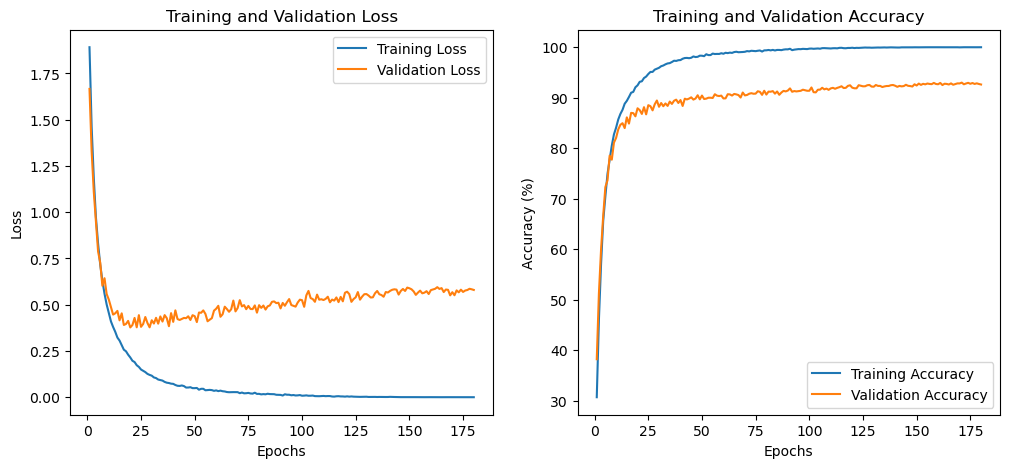

CPU times: user 32min 59s, sys: 8min 5s, total: 41min 5s
Wall time: 2h 18min 25s


In [41]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = ResNet18()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

resnet18_0_0_1_Adam_train_losses = []
resnet18_0_0_1_Adam_val_losses = []
resnet18_0_0_1_Adam_train_accuracies = []
resnet18_0_0_1_Adam_val_accuracies = []

for epoch in range(start_epoch, 180):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    resnet18_0_0_1_Adam_train_losses.append(train_loss)
    resnet18_0_0_1_Adam_val_losses.append(val_loss)
    resnet18_0_0_1_Adam_train_accuracies.append(train_accuracy)
    resnet18_0_0_1_Adam_val_accuracies.append(val_accuracy)

state_resnet18_0_0_1_Adam,  acc_resnet18_0_0_1_Adam = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_resnet18_0_0_1_Adam)

plot_metrics(resnet18_0_0_1_Adam_train_losses, resnet18_0_0_1_Adam_val_losses, 
             resnet18_0_0_1_Adam_train_accuracies, resnet18_0_0_1_Adam_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [42]:
file_path_resnet18_0_0_1_Adam = "./result_and_model/resnet18_0_0_1_Adam_results.pkl"
model_state_path_resnet18_0_0_1_Adam = "./result_and_model/resnet18_0_0_1_Adam_model.pth"

with open(file_path_resnet18_0_0_1_Adam, "wb") as f:
    pickle.dump({
        "train_losses": resnet18_0_0_1_Adam_train_losses,
        "val_losses": resnet18_0_0_1_Adam_val_losses,
        "train_accuracies": resnet18_0_0_1_Adam_train_accuracies,
        "val_accuracies": resnet18_0_0_1_Adam_val_accuracies,
        "best_accuracy": acc_resnet18_0_0_1_Adam
    }, f)


torch.save(state_resnet18_0_0_1_Adam, model_state_path_resnet18_0_0_1_Adam)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.1, Optimizer = RMSprop

Epoch: 0


Validation Epoch 0: 100%|██████| 79/79 [00:14<00:00,  5.62it/s, Acc=6.82, Loss=42.8]



Epoch: 1


Validation Epoch 1: 100%|███████| 79/79 [00:14<00:00,  5.59it/s, Acc=9.63, Loss=786]



Epoch: 2


Validation Epoch 2: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=9.63, Loss=14.2]



Epoch: 3


Validation Epoch 3: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=10.7, Loss=33.5]



Epoch: 4


Validation Epoch 4: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=9.83, Loss=4.24e+3]



Epoch: 5


Validation Epoch 5: 100%|████████| 79/79 [00:14<00:00,  5.63it/s, Acc=14, Loss=2.74]



Epoch: 6


Validation Epoch 6: 100%|███████| 79/79 [00:14<00:00,  5.27it/s, Acc=10.1, Loss=132]



Epoch: 7


Validation Epoch 7: 100%|██████| 79/79 [00:14<00:00,  5.29it/s, Acc=9.63, Loss=31.7]



Epoch: 8


Validation Epoch 8: 100%|██████| 79/79 [00:14<00:00,  5.38it/s, Acc=9.98, Loss=3.07]



Epoch: 9


Validation Epoch 9: 100%|███████| 79/79 [00:14<00:00,  5.48it/s, Acc=10.3, Loss=417]



Epoch: 10


Validation Epoch 10: 100%|█████| 79/79 [00:14<00:00,  5.55it/s, Acc=15.8, Loss=2.11]



Epoch: 11


Validation Epoch 11: 100%|█████| 79/79 [00:14<00:00,  5.56it/s, Acc=9.67, Loss=19.1]



Epoch: 12


Validation Epoch 12: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=9.98, Loss=9.67e+3]



Epoch: 13


Validation Epoch 13: 100%|██████| 79/79 [00:14<00:00,  5.59it/s, Acc=9.99, Loss=493]



Epoch: 14


Validation Epoch 14: 100%|███████| 79/79 [00:14<00:00,  5.60it/s, Acc=10, Loss=8.33]



Epoch: 15


Validation Epoch 15: 100%|███████| 79/79 [00:14<00:00,  5.59it/s, Acc=16, Loss=41.2]



Epoch: 16


Validation Epoch 16: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=10.2, Loss=6.9e+3]



Epoch: 17


Validation Epoch 17: 100%|█████| 79/79 [00:14<00:00,  5.60it/s, Acc=15.5, Loss=2.26]



Epoch: 18


Validation Epoch 18: 100%|█████| 79/79 [00:14<00:00,  5.50it/s, Acc=10.7, Loss=2.99]



Epoch: 19


Validation Epoch 19: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=9.73, Loss=2.76e+3]



Epoch: 20


Validation Epoch 20: 100%|█████| 79/79 [00:14<00:00,  5.58it/s, Acc=9.73, Loss=14.2]



Epoch: 21


Validation Epoch 21: 100%|█████| 79/79 [00:14<00:00,  5.57it/s, Acc=10.2, Loss=2.86]



Epoch: 22


Validation Epoch 22: 100%|██████| 79/79 [00:14<00:00,  5.57it/s, Acc=9.67, Loss=134]



Epoch: 23


Validation Epoch 23: 100%|█████| 79/79 [00:14<00:00,  5.59it/s, Acc=9.98, Loss=90.7]



Epoch: 24


Validation Epoch 24: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=9.99, Loss=1.68e+3]



Epoch: 25


Validation Epoch 25: 100%|██████| 79/79 [00:14<00:00,  5.61it/s, Acc=10.3, Loss=148]



Epoch: 26


Validation Epoch 26: 100%|██████| 79/79 [00:14<00:00,  5.61it/s, Acc=10.2, Loss=898]



Epoch: 27


Validation Epoch 27: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=10.3, Loss=91.3]



Epoch: 28


Validation Epoch 28: 100%|█████| 79/79 [00:14<00:00,  5.53it/s, Acc=17.2, Loss=3.42]



Epoch: 29


Validation Epoch 29: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=14.5, Loss=2.63]



Epoch: 30


Validation Epoch 30: 100%|██████| 79/79 [00:14<00:00,  5.60it/s, Acc=9.98, Loss=314]



Epoch: 31


Validation Epoch 31: 100%|██| 79/79 [00:14<00:00,  5.64it/s, Acc=10.2, Loss=1.52e+3]



Epoch: 32


Validation Epoch 32: 100%|█████| 79/79 [00:14<00:00,  5.53it/s, Acc=11.8, Loss=3.05]



Epoch: 33


Validation Epoch 33: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=16.1, Loss=16.6]



Epoch: 34


Validation Epoch 34: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=9.98, Loss=5.74]



Epoch: 35


Validation Epoch 35: 100%|██████| 79/79 [00:14<00:00,  5.61it/s, Acc=9.67, Loss=171]



Epoch: 36


Validation Epoch 36: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=10.1, Loss=11.9]



Epoch: 37


Validation Epoch 37: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=22.5, Loss=2.03]



Epoch: 38


Validation Epoch 38: 100%|█████| 79/79 [00:14<00:00,  5.55it/s, Acc=9.63, Loss=25.7]



Epoch: 39


Validation Epoch 39: 100%|████████| 79/79 [00:14<00:00,  5.56it/s, Acc=10, Loss=206]



Epoch: 40


Validation Epoch 40: 100%|███████| 79/79 [00:14<00:00,  5.62it/s, Acc=10, Loss=2.59]



Epoch: 41


Validation Epoch 41: 100%|█████| 79/79 [00:14<00:00,  5.52it/s, Acc=16.7, Loss=2.46]



Epoch: 42


Validation Epoch 42: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=9.79, Loss=4.29]



Epoch: 43


Validation Epoch 43: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=17.4, Loss=2.22]



Epoch: 44


Validation Epoch 44: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=10.7, Loss=16.4]



Epoch: 45


Validation Epoch 45: 100%|███████| 79/79 [00:14<00:00,  5.56it/s, Acc=10, Loss=31.3]



Epoch: 46


Validation Epoch 46: 100%|█████| 79/79 [00:14<00:00,  5.54it/s, Acc=18.9, Loss=2.02]



Epoch: 47


Validation Epoch 47: 100%|████████| 79/79 [00:14<00:00,  5.63it/s, Acc=12.7, Loss=2]



Epoch: 48


Validation Epoch 48: 100%|███████| 79/79 [00:14<00:00,  5.64it/s, Acc=10, Loss=4.75]



Epoch: 49


Validation Epoch 49: 100%|█████| 79/79 [00:14<00:00,  5.55it/s, Acc=16.7, Loss=1.92]



Epoch: 50


Validation Epoch 50: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=8.16, Loss=11.7]



Epoch: 51


Validation Epoch 51: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=20.9, Loss=2.49]



Epoch: 52


Validation Epoch 52: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=9.73, Loss=31.5]



Epoch: 53


Validation Epoch 53: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=10.1, Loss=53.1]



Epoch: 54


Validation Epoch 54: 100%|██████| 79/79 [00:14<00:00,  5.55it/s, Acc=10.7, Loss=281]



Epoch: 55


Validation Epoch 55: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=10.2, Loss=3.62]



Epoch: 56


Validation Epoch 56: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=13.4, Loss=2.05]



Epoch: 57


Validation Epoch 57: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=18.3, Loss=2.95]



Epoch: 58


Validation Epoch 58: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=16.4, Loss=35.8]



Epoch: 59


Validation Epoch 59: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=16.5, Loss=2.14]



Epoch: 60


Validation Epoch 60: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=16.5, Loss=2.21]



Epoch: 61


Validation Epoch 61: 100%|██| 79/79 [00:14<00:00,  5.62it/s, Acc=10.1, Loss=5.48e+4]



Epoch: 62


Validation Epoch 62: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=17.1, Loss=2.73]



Epoch: 63


Validation Epoch 63: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=9.98, Loss=11.9]



Epoch: 64


Validation Epoch 64: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=9.77, Loss=12.6]



Epoch: 65


Validation Epoch 65: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=10.6, Loss=7.45]



Epoch: 66


Validation Epoch 66: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=13.8, Loss=2.56]



Epoch: 67


Validation Epoch 67: 100%|██████| 79/79 [00:13<00:00,  5.65it/s, Acc=7.63, Loss=7.9]



Epoch: 68


Validation Epoch 68: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=10.2, Loss=10.9]



Epoch: 69


Validation Epoch 69: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=11.6, Loss=3.3]



Epoch: 70


Validation Epoch 70: 100%|██████| 79/79 [00:14<00:00,  5.56it/s, Acc=9.98, Loss=414]



Epoch: 71


Validation Epoch 71: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=9.98, Loss=16.4]



Epoch: 72


Validation Epoch 72: 100%|█████| 79/79 [00:14<00:00,  5.51it/s, Acc=14.3, Loss=4.75]



Epoch: 73


Validation Epoch 73: 100%|███████| 79/79 [00:14<00:00,  5.62it/s, Acc=20, Loss=15.3]



Epoch: 74


Validation Epoch 74: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=13.6, Loss=2.24]



Epoch: 75


Validation Epoch 75: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=12.1, Loss=4.63]



Epoch: 76


Validation Epoch 76: 100%|█████| 79/79 [00:14<00:00,  5.53it/s, Acc=15.8, Loss=2.94]



Epoch: 77


Validation Epoch 77: 100%|█████| 79/79 [00:14<00:00,  5.59it/s, Acc=14.4, Loss=5.46]



Epoch: 78


Validation Epoch 78: 100%|██████| 79/79 [00:14<00:00,  5.52it/s, Acc=9.73, Loss=238]



Epoch: 79


Validation Epoch 79: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=10.3, Loss=355]



Epoch: 80


Validation Epoch 80: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=13.3, Loss=4.45]



Epoch: 81


Validation Epoch 81: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=9.73, Loss=42.5]



Epoch: 82


Validation Epoch 82: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=23.7, Loss=2.16]



Epoch: 83


Validation Epoch 83: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=23.5, Loss=2.37]



Epoch: 84


Validation Epoch 84: 100%|███████| 79/79 [00:14<00:00,  5.55it/s, Acc=18, Loss=3.16]



Epoch: 85


Validation Epoch 85: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=18.4, Loss=2.19]



Epoch: 86


Validation Epoch 86: 100%|█████| 79/79 [00:14<00:00,  5.55it/s, Acc=17.7, Loss=2.31]



Epoch: 87


Validation Epoch 87: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=13.5, Loss=7.93]



Epoch: 88


Validation Epoch 88: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=19.5, Loss=3.83]



Epoch: 89


Validation Epoch 89: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=26.1, Loss=1.92]



Epoch: 90


Validation Epoch 90: 100%|█████| 79/79 [00:14<00:00,  5.60it/s, Acc=20.7, Loss=1.92]



Epoch: 91


Validation Epoch 91: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=17.3, Loss=2.66]



Epoch: 92


Validation Epoch 92: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=17.3, Loss=5.67]



Epoch: 93


Validation Epoch 93: 100%|████████| 79/79 [00:14<00:00,  5.63it/s, Acc=15.3, Loss=7]



Epoch: 94


Validation Epoch 94: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=15.4, Loss=3.49]



Epoch: 95


Validation Epoch 95: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=17.6, Loss=8.17]



Epoch: 96


Validation Epoch 96: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=29.7, Loss=2.05]



Epoch: 97


Validation Epoch 97: 100%|█████| 79/79 [00:14<00:00,  5.54it/s, Acc=13.2, Loss=2.69]



Epoch: 98


Validation Epoch 98: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=13.6, Loss=2.9]



Epoch: 99


Validation Epoch 99: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=15.6, Loss=5.47]



Epoch: 100


Validation Epoch 100: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=26.8, Loss=2.88]



Epoch: 101


Validation Epoch 101: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=12.5, Loss=28.9]



Epoch: 102


Validation Epoch 102: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=23.2, Loss=2.44]



Epoch: 103


Validation Epoch 103: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=29.8, Loss=2.29]



Epoch: 104


Validation Epoch 104: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=9.73, Loss=14.8]



Epoch: 105


Validation Epoch 105: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=18.5, Loss=3.25]



Epoch: 106


Validation Epoch 106: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=14.4, Loss=9.97]



Epoch: 107


Validation Epoch 107: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=32.2, Loss=2.43]



Epoch: 108


Validation Epoch 108: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=20.8, Loss=2.47]



Epoch: 109


Validation Epoch 109: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=20.2, Loss=2.44]



Epoch: 110


Validation Epoch 110: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=25.3, Loss=2.74]



Epoch: 111


Validation Epoch 111: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=30.2, Loss=1.88]



Epoch: 112


Validation Epoch 112: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=26.8, Loss=3.14]



Epoch: 113


Validation Epoch 113: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=29.7, Loss=2.65]



Epoch: 114


Validation Epoch 114: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=33.3, Loss=1.66]



Epoch: 115


Validation Epoch 115: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=30.1, Loss=1.55]



Epoch: 116


Validation Epoch 116: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=23, Loss=1.84]



Epoch: 117


Validation Epoch 117: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=26.1, Loss=2.03]



Epoch: 118


Validation Epoch 118: 100%|███████| 79/79 [00:14<00:00,  5.62it/s, Acc=22.8, Loss=2]



Epoch: 119


Validation Epoch 119: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=28.3, Loss=2.39]



Epoch: 120


Validation Epoch 120: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=34.9, Loss=1.78]



Epoch: 121


Validation Epoch 121: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=22.8, Loss=1.73]



Epoch: 122


Validation Epoch 122: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=33.2, Loss=1.53]



Epoch: 123


Validation Epoch 123: 100%|██████| 79/79 [00:14<00:00,  5.55it/s, Acc=31, Loss=2.43]



Epoch: 124


Validation Epoch 124: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=35.1, Loss=1.78]



Epoch: 125


Validation Epoch 125: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=24.1, Loss=3.19]



Epoch: 126


Validation Epoch 126: 100%|████| 79/79 [00:14<00:00,  5.57it/s, Acc=36.4, Loss=1.79]



Epoch: 127


Validation Epoch 127: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=34.3, Loss=1.85]



Epoch: 128


Validation Epoch 128: 100%|███████| 79/79 [00:14<00:00,  5.64it/s, Acc=33.8, Loss=2]



Epoch: 129


Validation Epoch 129: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=26.4, Loss=3.06]



Epoch: 130


Validation Epoch 130: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=20.1, Loss=2.64]



Epoch: 131


Validation Epoch 131: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=34.1, Loss=1.77]



Epoch: 132


Validation Epoch 132: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=36.9, Loss=2.06]



Epoch: 133


Validation Epoch 133: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=38.4, Loss=1.61]



Epoch: 134


Validation Epoch 134: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=33.5, Loss=2.28]



Epoch: 135


Validation Epoch 135: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=38.4, Loss=1.75]



Epoch: 136


Validation Epoch 136: 100%|█████| 79/79 [00:14<00:00,  5.50it/s, Acc=18.5, Loss=4.3]



Epoch: 137


Validation Epoch 137: 100%|████| 79/79 [00:13<00:00,  5.66it/s, Acc=21.6, Loss=2.33]



Epoch: 138


Validation Epoch 138: 100%|████| 79/79 [00:14<00:00,  5.57it/s, Acc=31.3, Loss=1.84]



Epoch: 139


Validation Epoch 139: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=36.9, Loss=1.65]



Epoch: 140


Validation Epoch 140: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=36.5, Loss=1.76]



Epoch: 141


Validation Epoch 141: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=37.5, Loss=2.1]



Epoch: 142


Validation Epoch 142: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=39, Loss=1.74]



Epoch: 143


Validation Epoch 143: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=34.9, Loss=1.9]



Epoch: 144


Validation Epoch 144: 100%|██████| 79/79 [00:14<00:00,  5.54it/s, Acc=29, Loss=2.02]



Epoch: 145


Validation Epoch 145: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=33.8, Loss=1.66]



Epoch: 146


Validation Epoch 146: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=29.9, Loss=1.56]



Epoch: 147


Validation Epoch 147: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=26.6, Loss=1.85]



Epoch: 148


Validation Epoch 148: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=32.1, Loss=1.57]



Epoch: 149


Validation Epoch 149: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=30.8, Loss=2.51]



Epoch: 150


Validation Epoch 150: 100%|████| 79/79 [00:14<00:00,  5.56it/s, Acc=37.1, Loss=1.73]



Epoch: 151


Validation Epoch 151: 100%|██████| 79/79 [00:14<00:00,  5.62it/s, Acc=39, Loss=1.69]



Epoch: 152


Validation Epoch 152: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=34.2, Loss=1.58]



Epoch: 153


Validation Epoch 153: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=39.1, Loss=1.79]



Epoch: 154


Validation Epoch 154: 100%|███████| 79/79 [00:14<00:00,  5.63it/s, Acc=38, Loss=1.9]



Epoch: 155


Validation Epoch 155: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=37.7, Loss=1.54]



Epoch: 156


Validation Epoch 156: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=40.6, Loss=1.67]



Epoch: 157


Validation Epoch 157: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=39.4, Loss=2.14]



Epoch: 158


Validation Epoch 158: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=38.3, Loss=1.51]



Epoch: 159


Validation Epoch 159: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=39.9, Loss=1.58]



Epoch: 160


Validation Epoch 160: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=40.4, Loss=1.66]



Epoch: 161


Validation Epoch 161: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=40.6, Loss=1.89]



Epoch: 162


Validation Epoch 162: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=40.7, Loss=1.77]



Epoch: 163


Validation Epoch 163: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=40.1, Loss=2.03]



Epoch: 164


Validation Epoch 164: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=35.8, Loss=1.71]



Epoch: 165


Validation Epoch 165: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=40.7, Loss=1.81]



Epoch: 166


Validation Epoch 166: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=40.4, Loss=1.58]



Epoch: 167


Validation Epoch 167: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=39.9, Loss=1.54]



Epoch: 168


Validation Epoch 168: 100%|████| 79/79 [00:14<00:00,  5.59it/s, Acc=41.2, Loss=1.72]



Epoch: 169


Validation Epoch 169: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=40.5, Loss=1.72]



Epoch: 170


Validation Epoch 170: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=40.6, Loss=1.68]



Epoch: 171


Validation Epoch 171: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=41.3, Loss=1.92]



Epoch: 172


Validation Epoch 172: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=40.9, Loss=1.65]



Epoch: 173


Validation Epoch 173: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=40.8, Loss=1.74]



Epoch: 174


Validation Epoch 174: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=41.4, Loss=1.87]



Epoch: 175


Validation Epoch 175: 100%|████| 79/79 [00:14<00:00,  5.52it/s, Acc=41.2, Loss=1.91]



Epoch: 176


Validation Epoch 176: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=41.2, Loss=1.75]



Epoch: 177


Validation Epoch 177: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=40.7, Loss=1.72]



Epoch: 178


Validation Epoch 178: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=41.4, Loss=1.75]



Epoch: 179


Validation Epoch 179: 100%|█████| 79/79 [00:14<00:00,  5.54it/s, Acc=40.9, Loss=1.8]

Validation Accuracy:  41.39


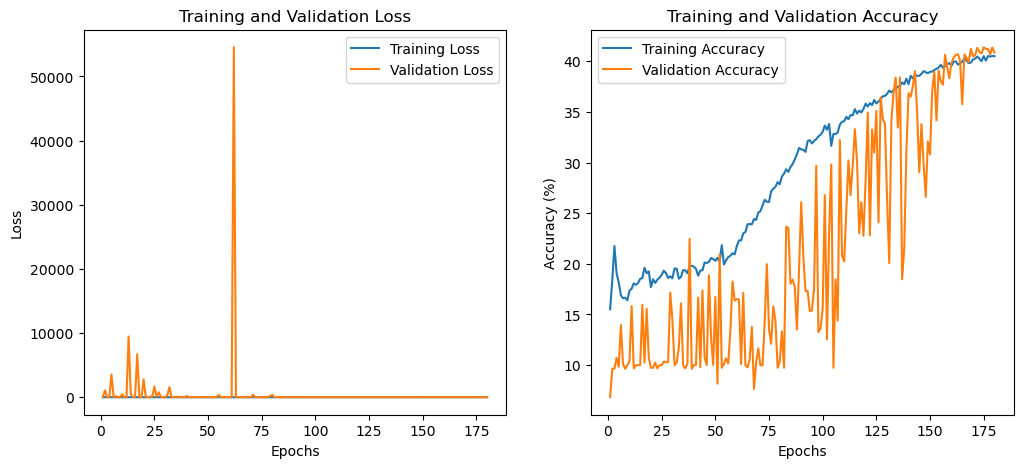

CPU times: user 31min 52s, sys: 9min 45s, total: 41min 38s
Wall time: 2h 18min 9s


In [43]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = ResNet18()
net.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.1, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

resnet18_0_1_RMSprop_train_losses = []
resnet18_0_1_RMSprop_val_losses = []
resnet18_0_1_RMSprop_train_accuracies = []
resnet18_0_1_RMSprop_val_accuracies = []

for epoch in range(start_epoch, 180):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    resnet18_0_1_RMSprop_train_losses.append(train_loss)
    resnet18_0_1_RMSprop_val_losses.append(val_loss)
    resnet18_0_1_RMSprop_train_accuracies.append(train_accuracy)
    resnet18_0_1_RMSprop_val_accuracies.append(val_accuracy)

state_resnet18_0_1_RMSprop,  acc_resnet18_0_1_RMSprop = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_resnet18_0_1_RMSprop)

plot_metrics(resnet18_0_1_RMSprop_train_losses, resnet18_0_1_RMSprop_val_losses, 
             resnet18_0_1_RMSprop_train_accuracies, resnet18_0_1_RMSprop_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [44]:
file_path_resnet18_0_1_RMSprop = "./result_and_model/resnet18_0_1_RMSprop_results.pkl"
model_state_path_resnet18_0_1_RMSprop = "./result_and_model/resnet18_0_1_RMSprop_model.pth"

with open(file_path_resnet18_0_1_RMSprop, "wb") as f:
    pickle.dump({
        "train_losses": resnet18_0_1_RMSprop_train_losses,
        "val_losses": resnet18_0_1_RMSprop_val_losses,
        "train_accuracies": resnet18_0_1_RMSprop_train_accuracies,
        "val_accuracies": resnet18_0_1_RMSprop_val_accuracies,
        "best_accuracy": acc_resnet18_0_1_RMSprop
    }, f)


torch.save(state_resnet18_0_1_RMSprop, model_state_path_resnet18_0_1_RMSprop)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = RMSprop

Epoch: 0


Validation Epoch 0: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=22.3, Loss=3.16]



Epoch: 1


Validation Epoch 1: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=31.6, Loss=2.02]



Epoch: 2


Validation Epoch 2: 100%|████████| 79/79 [00:14<00:00,  5.63it/s, Acc=33, Loss=1.74]



Epoch: 3


Validation Epoch 3: 100%|██████| 79/79 [00:14<00:00,  5.35it/s, Acc=20.8, Loss=4.13]



Epoch: 4


Validation Epoch 4: 100%|█████| 79/79 [00:14<00:00,  5.43it/s, Acc=57.9, Loss=0.807]



Epoch: 5


Validation Epoch 5: 100%|██████| 79/79 [00:14<00:00,  5.47it/s, Acc=44.9, Loss=1.77]



Epoch: 6


Validation Epoch 6: 100%|██████| 79/79 [00:14<00:00,  5.53it/s, Acc=41.4, Loss=1.76]



Epoch: 7


Validation Epoch 7: 100%|██████| 79/79 [00:14<00:00,  5.55it/s, Acc=49.3, Loss=1.61]



Epoch: 8


Validation Epoch 8: 100%|██████| 79/79 [00:14<00:00,  5.55it/s, Acc=62.4, Loss=1.19]



Epoch: 9


Validation Epoch 9: 100%|███████| 79/79 [00:14<00:00,  5.59it/s, Acc=51.7, Loss=1.6]



Epoch: 10


Validation Epoch 10: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=48.4, Loss=0.567]



Epoch: 11


Validation Epoch 11: 100%|█████| 79/79 [00:14<00:00,  5.60it/s, Acc=56.1, Loss=1.24]



Epoch: 12


Validation Epoch 12: 100%|█████| 79/79 [00:14<00:00,  5.60it/s, Acc=58.6, Loss=1.25]



Epoch: 13


Validation Epoch 13: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=48.7, Loss=1.26]



Epoch: 14


Validation Epoch 14: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=64.7, Loss=1.4]



Epoch: 15


Validation Epoch 15: 100%|██████| 79/79 [00:14<00:00,  5.59it/s, Acc=73, Loss=0.429]



Epoch: 16


Validation Epoch 16: 100%|███████| 79/79 [00:14<00:00,  5.60it/s, Acc=55, Loss=0.97]



Epoch: 17


Validation Epoch 17: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=65.4, Loss=0.561]



Epoch: 18


Validation Epoch 18: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=42.2, Loss=1.48]



Epoch: 19


Validation Epoch 19: 100%|████| 79/79 [00:14<00:00,  5.57it/s, Acc=67.3, Loss=0.595]



Epoch: 20


Validation Epoch 20: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=53.4, Loss=1.94]



Epoch: 21


Validation Epoch 21: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=42.2, Loss=1.38]



Epoch: 22


Validation Epoch 22: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=55.2, Loss=0.85]



Epoch: 23


Validation Epoch 23: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=60.3, Loss=2.58]



Epoch: 24


Validation Epoch 24: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=51.5, Loss=1.07]



Epoch: 25


Validation Epoch 25: 100%|█████| 79/79 [00:13<00:00,  5.64it/s, Acc=61.5, Loss=1.61]



Epoch: 26


Validation Epoch 26: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=72.7, Loss=0.557]



Epoch: 27


Validation Epoch 27: 100%|█████| 79/79 [00:14<00:00,  5.60it/s, Acc=41.6, Loss=4.02]



Epoch: 28


Validation Epoch 28: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=60.2, Loss=0.558]



Epoch: 29


Validation Epoch 29: 100%|███████| 79/79 [00:14<00:00,  5.64it/s, Acc=71, Loss=0.92]



Epoch: 30


Validation Epoch 30: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=43.2, Loss=2.99]



Epoch: 31


Validation Epoch 31: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=50.9, Loss=1.79]



Epoch: 32


Validation Epoch 32: 100%|█████| 79/79 [00:14<00:00,  5.62it/s, Acc=65.9, Loss=1.06]



Epoch: 33


Validation Epoch 33: 100%|██████| 79/79 [00:14<00:00,  5.54it/s, Acc=73, Loss=0.712]



Epoch: 34


Validation Epoch 34: 100%|████| 79/79 [00:14<00:00,  5.53it/s, Acc=68.4, Loss=0.657]



Epoch: 35


Validation Epoch 35: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=10.2, Loss=137]



Epoch: 36


Validation Epoch 36: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=73.4, Loss=0.424]



Epoch: 37


Validation Epoch 37: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=62.4, Loss=1.1]



Epoch: 38


Validation Epoch 38: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=67.1, Loss=0.979]



Epoch: 39


Validation Epoch 39: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=58, Loss=0.917]



Epoch: 40


Validation Epoch 40: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=69.5, Loss=0.502]



Epoch: 41


Validation Epoch 41: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=70.1, Loss=0.369]



Epoch: 42


Validation Epoch 42: 100%|██████| 79/79 [00:14<00:00,  5.52it/s, Acc=61, Loss=0.847]



Epoch: 43


Validation Epoch 43: 100%|████| 79/79 [00:14<00:00,  5.55it/s, Acc=67.1, Loss=0.414]



Epoch: 44


Validation Epoch 44: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=46.3, Loss=2.16]



Epoch: 45


Validation Epoch 45: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=63.7, Loss=0.666]



Epoch: 46


Validation Epoch 46: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=62.7, Loss=0.682]



Epoch: 47


Validation Epoch 47: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=60.9, Loss=0.714]



Epoch: 48


Validation Epoch 48: 100%|█████| 79/79 [00:13<00:00,  5.64it/s, Acc=48.3, Loss=2.23]



Epoch: 49


Validation Epoch 49: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=38.7, Loss=3.39]



Epoch: 50


Validation Epoch 50: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=69.5, Loss=0.838]



Epoch: 51


Validation Epoch 51: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=72, Loss=0.772]



Epoch: 52


Validation Epoch 52: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=69.8, Loss=0.911]



Epoch: 53


Validation Epoch 53: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=69.8, Loss=0.712]



Epoch: 54


Validation Epoch 54: 100%|██████| 79/79 [00:14<00:00,  5.54it/s, Acc=73, Loss=0.453]



Epoch: 55


Validation Epoch 55: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=71.4, Loss=0.624]



Epoch: 56


Validation Epoch 56: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=54.8, Loss=1.01]



Epoch: 57


Validation Epoch 57: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=76, Loss=0.404]



Epoch: 58


Validation Epoch 58: 100%|█████| 79/79 [00:13<00:00,  5.65it/s, Acc=74.8, Loss=1.39]



Epoch: 59


Validation Epoch 59: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=57.2, Loss=0.867]



Epoch: 60


Validation Epoch 60: 100%|████| 79/79 [00:14<00:00,  5.56it/s, Acc=72.8, Loss=0.468]



Epoch: 61


Validation Epoch 61: 100%|█████| 79/79 [00:14<00:00,  5.56it/s, Acc=67.8, Loss=1.22]



Epoch: 62


Validation Epoch 62: 100%|████| 79/79 [00:14<00:00,  5.53it/s, Acc=65.7, Loss=0.812]



Epoch: 63


Validation Epoch 63: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=63.6, Loss=0.638]



Epoch: 64


Validation Epoch 64: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=62.4, Loss=1.01]



Epoch: 65


Validation Epoch 65: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=70.9, Loss=0.58]



Epoch: 66


Validation Epoch 66: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=75.2, Loss=0.576]



Epoch: 67


Validation Epoch 67: 100%|████| 79/79 [00:14<00:00,  5.53it/s, Acc=72.9, Loss=0.593]



Epoch: 68


Validation Epoch 68: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=68.1, Loss=0.369]



Epoch: 69


Validation Epoch 69: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=76.3, Loss=0.481]



Epoch: 70


Validation Epoch 70: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=67.6, Loss=0.467]



Epoch: 71


Validation Epoch 71: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=72.1, Loss=0.464]



Epoch: 72


Validation Epoch 72: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=61.1, Loss=0.989]



Epoch: 73


Validation Epoch 73: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=71.9, Loss=0.674]



Epoch: 74


Validation Epoch 74: 100%|█████| 79/79 [00:14<00:00,  5.59it/s, Acc=62.5, Loss=1.58]



Epoch: 75


Validation Epoch 75: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=74.5, Loss=0.992]



Epoch: 76


Validation Epoch 76: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=76.6, Loss=0.584]



Epoch: 77


Validation Epoch 77: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=69.2, Loss=1.05]



Epoch: 78


Validation Epoch 78: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=71.4, Loss=0.744]



Epoch: 79


Validation Epoch 79: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=74, Loss=0.278]



Epoch: 80


Validation Epoch 80: 100%|█████| 79/79 [00:14<00:00,  5.61it/s, Acc=68.9, Loss=1.24]



Epoch: 81


Validation Epoch 81: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=67.7, Loss=0.412]



Epoch: 82


Validation Epoch 82: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=73.3, Loss=0.203]



Epoch: 83


Validation Epoch 83: 100%|██████| 79/79 [00:14<00:00,  5.61it/s, Acc=75, Loss=0.471]



Epoch: 84


Validation Epoch 84: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=73.5, Loss=0.721]



Epoch: 85


Validation Epoch 85: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=80, Loss=0.537]



Epoch: 86


Validation Epoch 86: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=69.8, Loss=0.448]



Epoch: 87


Validation Epoch 87: 100%|█████| 79/79 [00:14<00:00,  5.60it/s, Acc=76.1, Loss=0.69]



Epoch: 88


Validation Epoch 88: 100%|████| 79/79 [00:14<00:00,  5.51it/s, Acc=78.9, Loss=0.316]



Epoch: 89


Validation Epoch 89: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=76.2, Loss=0.642]



Epoch: 90


Validation Epoch 90: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=64.8, Loss=0.781]



Epoch: 91


Validation Epoch 91: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=79.7, Loss=0.576]



Epoch: 92


Validation Epoch 92: 100%|█████| 79/79 [00:14<00:00,  5.54it/s, Acc=10.1, Loss=35.3]



Epoch: 93


Validation Epoch 93: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=58.7, Loss=1.78]



Epoch: 94


Validation Epoch 94: 100%|██████| 79/79 [00:14<00:00,  5.63it/s, Acc=82.7, Loss=0.3]



Epoch: 95


Validation Epoch 95: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=81.3, Loss=0.298]



Epoch: 96


Validation Epoch 96: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=76.6, Loss=0.625]



Epoch: 97


Validation Epoch 97: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=81.8, Loss=0.643]



Epoch: 98


Validation Epoch 98: 100%|████| 79/79 [00:14<00:00,  5.64it/s, Acc=79.8, Loss=0.404]



Epoch: 99


Validation Epoch 99: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=81.6, Loss=0.558]



Epoch: 100


Validation Epoch 100: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=77.9, Loss=0.381]



Epoch: 101


Validation Epoch 101: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=75.8, Loss=0.271]



Epoch: 102


Validation Epoch 102: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=80.8, Loss=0.279]



Epoch: 103


Validation Epoch 103: 100%|████| 79/79 [00:14<00:00,  5.63it/s, Acc=80.5, Loss=0.49]



Epoch: 104


Validation Epoch 104: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=80.2, Loss=0.525]



Epoch: 105


Validation Epoch 105: 100%|████| 79/79 [00:13<00:00,  5.64it/s, Acc=78.4, Loss=0.09]



Epoch: 106


Validation Epoch 106: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=78.4, Loss=0.173]



Epoch: 107


Validation Epoch 107: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=82.4, Loss=0.523]



Epoch: 108


Validation Epoch 108: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=82.5, Loss=0.463]



Epoch: 109


Validation Epoch 109: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=81.9, Loss=0.361]



Epoch: 110


Validation Epoch 110: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=80.2, Loss=0.282]



Epoch: 111


Validation Epoch 111: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=81.2, Loss=0.403]



Epoch: 112


Validation Epoch 112: 100%|███| 79/79 [00:14<00:00,  5.61it/s, Acc=81.2, Loss=0.378]



Epoch: 113


Validation Epoch 113: 100%|███| 79/79 [00:14<00:00,  5.54it/s, Acc=82.7, Loss=0.444]



Epoch: 114


Validation Epoch 114: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=80.8, Loss=0.454]



Epoch: 115


Validation Epoch 115: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=82.4, Loss=0.558]



Epoch: 116


Validation Epoch 116: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=83.5, Loss=0.32]



Epoch: 117


Validation Epoch 117: 100%|█████| 79/79 [00:14<00:00,  5.53it/s, Acc=84, Loss=0.399]



Epoch: 118


Validation Epoch 118: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=81.6, Loss=0.555]



Epoch: 119


Validation Epoch 119: 100%|████| 79/79 [00:14<00:00,  5.59it/s, Acc=83.3, Loss=0.35]



Epoch: 120


Validation Epoch 120: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=84.7, Loss=0.254]



Epoch: 121


Validation Epoch 121: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=83.6, Loss=0.188]



Epoch: 122


Validation Epoch 122: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=81, Loss=0.492]



Epoch: 123


Validation Epoch 123: 100%|███| 79/79 [00:13<00:00,  5.64it/s, Acc=81.8, Loss=0.139]



Epoch: 124


Validation Epoch 124: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=84.8, Loss=0.379]



Epoch: 125


Validation Epoch 125: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=83.9, Loss=0.338]



Epoch: 126


Validation Epoch 126: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=84.1, Loss=0.257]



Epoch: 127


Validation Epoch 127: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=83.5, Loss=0.343]



Epoch: 128


Validation Epoch 128: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=82.5, Loss=0.261]



Epoch: 129


Validation Epoch 129: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=83.8, Loss=0.387]



Epoch: 130


Validation Epoch 130: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=85.1, Loss=0.174]



Epoch: 131


Validation Epoch 131: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=86.1, Loss=0.321]



Epoch: 132


Validation Epoch 132: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=84.9, Loss=0.431]



Epoch: 133


Validation Epoch 133: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=85.5, Loss=0.26]



Epoch: 134


Validation Epoch 134: 100%|████| 79/79 [00:14<00:00,  5.54it/s, Acc=85.8, Loss=0.28]



Epoch: 135


Validation Epoch 135: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=85.6, Loss=0.419]



Epoch: 136


Validation Epoch 136: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=84.9, Loss=0.501]



Epoch: 137


Validation Epoch 137: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=84.5, Loss=0.264]



Epoch: 138


Validation Epoch 138: 100%|█████| 79/79 [00:14<00:00,  5.53it/s, Acc=86, Loss=0.234]



Epoch: 139


Validation Epoch 139: 100%|█████| 79/79 [00:14<00:00,  5.56it/s, Acc=86, Loss=0.332]



Epoch: 140


Validation Epoch 140: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=86.1, Loss=0.485]



Epoch: 141


Validation Epoch 141: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=85.5, Loss=0.303]



Epoch: 142


Validation Epoch 142: 100%|████| 79/79 [00:13<00:00,  5.65it/s, Acc=85.8, Loss=0.35]



Epoch: 143


Validation Epoch 143: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=86.6, Loss=0.493]



Epoch: 144


Validation Epoch 144: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=86.3, Loss=0.489]



Epoch: 145


Validation Epoch 145: 100%|███| 79/79 [00:14<00:00,  5.54it/s, Acc=86.1, Loss=0.309]



Epoch: 146


Validation Epoch 146: 100%|███| 79/79 [00:14<00:00,  5.55it/s, Acc=86.1, Loss=0.368]



Epoch: 147


Validation Epoch 147: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=86.7, Loss=0.253]



Epoch: 148


Validation Epoch 148: 100%|███| 79/79 [00:14<00:00,  5.57it/s, Acc=86.8, Loss=0.352]



Epoch: 149


Validation Epoch 149: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=86, Loss=0.247]



Epoch: 150


Validation Epoch 150: 100%|█████| 79/79 [00:14<00:00,  5.64it/s, Acc=87, Loss=0.454]



Epoch: 151


Validation Epoch 151: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=87.2, Loss=0.308]



Epoch: 152


Validation Epoch 152: 100%|███| 79/79 [00:14<00:00,  5.56it/s, Acc=87.2, Loss=0.567]



Epoch: 153


Validation Epoch 153: 100%|███| 79/79 [00:14<00:00,  5.56it/s, Acc=87.2, Loss=0.375]



Epoch: 154


Validation Epoch 154: 100%|█████| 79/79 [00:14<00:00,  5.53it/s, Acc=87, Loss=0.339]



Epoch: 155


Validation Epoch 155: 100%|██████| 79/79 [00:14<00:00,  5.64it/s, Acc=87, Loss=0.38]



Epoch: 156


Validation Epoch 156: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=87.4, Loss=0.429]



Epoch: 157


Validation Epoch 157: 100%|███| 79/79 [00:14<00:00,  5.57it/s, Acc=87.2, Loss=0.388]



Epoch: 158


Validation Epoch 158: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=87.3, Loss=0.528]



Epoch: 159


Validation Epoch 159: 100%|█████| 79/79 [00:14<00:00,  5.63it/s, Acc=87, Loss=0.305]



Epoch: 160


Validation Epoch 160: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=87.3, Loss=0.478]



Epoch: 161


Validation Epoch 161: 100%|███| 79/79 [00:13<00:00,  5.65it/s, Acc=86.9, Loss=0.527]



Epoch: 162


Validation Epoch 162: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=87.2, Loss=0.495]



Epoch: 163


Validation Epoch 163: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=87.5, Loss=0.304]



Epoch: 164


Validation Epoch 164: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=87.3, Loss=0.338]



Epoch: 165


Validation Epoch 165: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=87.7, Loss=0.484]



Epoch: 166


Validation Epoch 166: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=87.2, Loss=0.313]



Epoch: 167


Validation Epoch 167: 100%|███| 79/79 [00:14<00:00,  5.53it/s, Acc=87.5, Loss=0.525]



Epoch: 168


Validation Epoch 168: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=87.2, Loss=0.391]



Epoch: 169


Validation Epoch 169: 100%|█████| 79/79 [00:14<00:00,  5.56it/s, Acc=88, Loss=0.252]



Epoch: 170


Validation Epoch 170: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=87.2, Loss=0.306]



Epoch: 171


Validation Epoch 171: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=87.7, Loss=0.378]



Epoch: 172


Validation Epoch 172: 100%|███| 79/79 [00:14<00:00,  5.64it/s, Acc=87.4, Loss=0.232]



Epoch: 173


Validation Epoch 173: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=87.4, Loss=0.316]



Epoch: 174


Validation Epoch 174: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=87.8, Loss=0.451]



Epoch: 175


Validation Epoch 175: 100%|███| 79/79 [00:14<00:00,  5.54it/s, Acc=87.6, Loss=0.444]



Epoch: 176


Validation Epoch 176: 100%|████| 79/79 [00:14<00:00,  5.61it/s, Acc=87.8, Loss=0.37]



Epoch: 177


Validation Epoch 177: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=87.8, Loss=0.322]



Epoch: 178


Validation Epoch 178: 100%|████| 79/79 [00:14<00:00,  5.62it/s, Acc=87.8, Loss=0.34]



Epoch: 179


Validation Epoch 179: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=87.7, Loss=0.403]

Validation Accuracy:  88.05


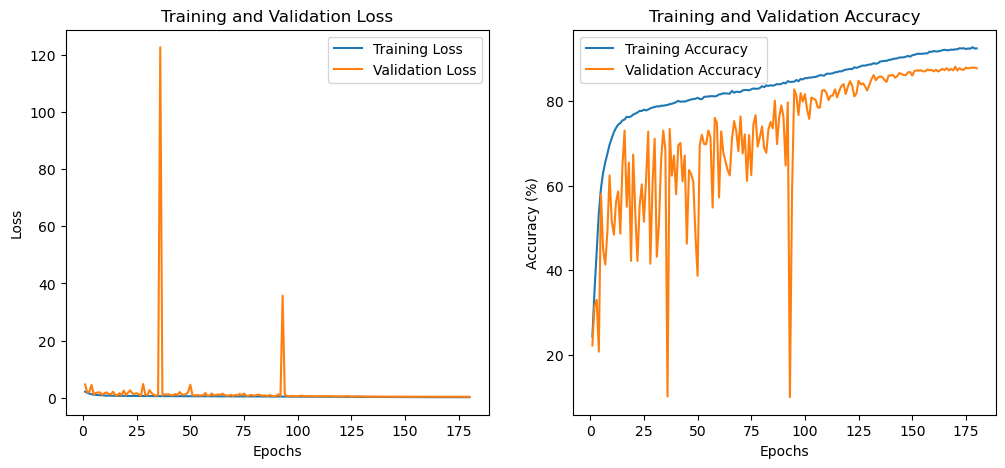

CPU times: user 31min 44s, sys: 9min 5s, total: 40min 50s
Wall time: 2h 17min 43s


In [45]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = ResNet18()
net.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

resnet18_0_0_1_RMSprop_train_losses = []
resnet18_0_0_1_RMSprop_val_losses = []
resnet18_0_0_1_RMSprop_train_accuracies = []
resnet18_0_0_1_RMSprop_val_accuracies = []

for epoch in range(start_epoch, 180):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    resnet18_0_0_1_RMSprop_train_losses.append(train_loss)
    resnet18_0_0_1_RMSprop_val_losses.append(val_loss)
    resnet18_0_0_1_RMSprop_train_accuracies.append(train_accuracy)
    resnet18_0_0_1_RMSprop_val_accuracies.append(val_accuracy)

state_resnet18_0_0_1_RMSprop,  acc_resnet18_0_0_1_RMSprop = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_resnet18_0_0_1_RMSprop)

plot_metrics(resnet18_0_0_1_RMSprop_train_losses, resnet18_0_0_1_RMSprop_val_losses, 
             resnet18_0_0_1_RMSprop_train_accuracies, resnet18_0_0_1_RMSprop_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [46]:
file_path_resnet18_0_0_1_RMSprop = "./result_and_model/resnet18_0_0_1_RMSprop_results.pkl"
model_state_path_resnet18_0_0_1_RMSprop = "./result_and_model/resnet18_0_0_1_RMSprop_model.pth"

with open(file_path_resnet18_0_0_1_RMSprop, "wb") as f:
    pickle.dump({
        "train_losses": resnet18_0_0_1_RMSprop_train_losses,
        "val_losses": resnet18_0_0_1_RMSprop_val_losses,
        "train_accuracies": resnet18_0_0_1_RMSprop_train_accuracies,
        "val_accuracies": resnet18_0_0_1_RMSprop_val_accuracies,
        "best_accuracy": acc_resnet18_0_0_1_RMSprop
    }, f)


torch.save(state_resnet18_0_0_1_RMSprop, model_state_path_resnet18_0_0_1_RMSprop)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.


#### Manual Grid Search for MobileNetV2


Testing: Learning Rate = 0.1, Optimizer = SGD

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:14<00:00,  5.57it/s, Acc=44.2, Loss=1.45]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=55.4, Loss=1.36]



Epoch: 2


 Training Epoch 2: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=58.9, Loss=0.988
Validation Epoch 2: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=60.8, Loss=0.808]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=60.5, Loss=1.02]



Epoch: 4


 Training Epoch 4: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=70.3, Loss=0.896
Validation Epoch 4: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=70.9, Loss=0.487]



Epoch: 5


 Training Epoch 5: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=73.7, Loss=0.918
Validation Epoch 5: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=72.1, Loss=0.923]



Epoch: 6


 Training Epoch 6: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=75.4, Loss=0.941
Validation Epoch 6: 100%|████| 79/79 [00:14<00:00,  5.57it/s, Acc=73, Loss=0.61]



Epoch: 7


 Training Epoch 7: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=76.9, Loss=0.809
Validation Epoch 7: 100%|████| 79/79 [00:14<00:00,  5.57it/s, Acc=76, Loss=0.67]



Epoch: 8


 Training Epoch 8: 100%|█| 313/313 [00:38<00:00,  8.07it/s, Acc=78.1, Loss=0.678
Validation Epoch 8: 100%|█| 79/79 [00:14<00:00,  5.40it/s, Acc=74.3, Loss=0.584]



Epoch: 9


 Training Epoch 9: 100%|█| 313/313 [00:44<00:00,  7.06it/s, Acc=78.3, Loss=0.475
Validation Epoch 9: 100%|█| 79/79 [00:14<00:00,  5.39it/s, Acc=71.6, Loss=0.778]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:41<00:00,  7.46it/s, Acc=78.7, Loss=0.72
Validation Epoch 10: 100%|█| 79/79 [00:14<00:00,  5.47it/s, Acc=77.4, Loss=0.577



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:39<00:00,  7.94it/s, Acc=78.8, Loss=0.67
Validation Epoch 11: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=74.7, Loss=0.324



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:37<00:00,  8.43it/s, Acc=79.2, Loss=0.54
Validation Epoch 12: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=75.3, Loss=0.772



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:35<00:00,  8.70it/s, Acc=79.4, Loss=0.96
Validation Epoch 13: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=75.7, Loss=0.615



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:35<00:00,  8.91it/s, Acc=79.5, Loss=0.61
Validation Epoch 14: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=72.2, Loss=0.691



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:34<00:00,  9.06it/s, Acc=79.6, Loss=0.43
Validation Epoch 15: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=77.1, Loss=0.562



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:34<00:00,  9.15it/s, Acc=79.6, Loss=0.55
Validation Epoch 16: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=78.8, Loss=0.292



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:33<00:00,  9.22it/s, Acc=79.8, Loss=0.83
Validation Epoch 17: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=77.4, Loss=0.485



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=79.7, Loss=0.66
Validation Epoch 18: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=76.3, Loss=0.392



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=80, Loss=0.672]
Validation Epoch 19: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=77.7, Loss=0.275



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=80.1, Loss=0.62
Validation Epoch 20: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=78.6, Loss=0.448



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:33<00:00,  9.21it/s, Acc=80.2, Loss=0.76
Validation Epoch 21: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=76.5, Loss=0.253



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:34<00:00,  9.10it/s, Acc=80.5, Loss=0.90
Validation Epoch 22: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=74.6, Loss=0.277



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:34<00:00,  8.95it/s, Acc=80.5, Loss=0.57
Validation Epoch 23: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=71.7, Loss=0.874



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:35<00:00,  8.93it/s, Acc=80.5, Loss=0.59
Validation Epoch 24: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=71.1, Loss=0.889



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:34<00:00,  9.10it/s, Acc=80.1, Loss=0.32
Validation Epoch 25: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=75.1, Loss=0.285



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:34<00:00,  9.18it/s, Acc=80.9, Loss=0.35
Validation Epoch 26: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=74.5, Loss=0.202



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=80.6, Loss=0.70
Validation Epoch 27: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=75.8, Loss=0.491



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=80.7, Loss=0.59
Validation Epoch 28: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=79.4, Loss=0.209



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=80.7, Loss=0.62
Validation Epoch 29: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=76.8, Loss=0.278



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=80.7, Loss=0.52
Validation Epoch 30: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=77.2, Loss=0.404



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=80.7, Loss=0.40
Validation Epoch 31: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=74.8, Loss=0.214



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=80.9, Loss=0.66
Validation Epoch 32: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=75.4, Loss=0.306



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=80.3, Loss=0.76
Validation Epoch 33: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=74.7, Loss=0.168



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=81.1, Loss=0.69
Validation Epoch 34: 100%|██| 79/79 [00:14<00:00,  5.62it/s, Acc=77, Loss=0.508]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=81.4, Loss=0.59
Validation Epoch 35: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=75.6, Loss=0.439



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=80.8, Loss=0.7]
Validation Epoch 36: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=77.2, Loss=0.638



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.2, Loss=0.78
Validation Epoch 37: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=76.3, Loss=0.25]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=81.2, Loss=0.49
Validation Epoch 38: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=77.9, Loss=0.449



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=81.4, Loss=0.50
Validation Epoch 39: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.2, Loss=0.32]



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=81.4, Loss=0.47
Validation Epoch 40: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.1, Loss=0.502



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.2, Loss=0.61
Validation Epoch 41: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=76.6, Loss=0.444



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.4, Loss=0.66
Validation Epoch 42: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=77.5, Loss=0.679



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=81.2, Loss=0.33
Validation Epoch 43: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.2, Loss=0.339



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=81.3, Loss=0.59
Validation Epoch 44: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=76.2, Loss=0.396



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=81.5, Loss=0.51
Validation Epoch 45: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=79.4, Loss=0.382



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=81.2, Loss=0.55
Validation Epoch 46: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=70, Loss=1.09]



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.3, Loss=0.54
Validation Epoch 47: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=76.5, Loss=0.462



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=81.6, Loss=0.52
Validation Epoch 48: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=79.2, Loss=0.652



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=81.8, Loss=0.55
Validation Epoch 49: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=75.7, Loss=0.3]



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.6, Loss=0.62
Validation Epoch 50: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=76.4, Loss=0.249



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=81.6, Loss=0.37
Validation Epoch 51: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=79.2, Loss=0.436



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.8, Loss=0.66
Validation Epoch 52: 100%|███| 79/79 [00:14<00:00,  5.63it/s, Acc=77, Loss=0.51]



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.8, Loss=0.71
Validation Epoch 53: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=78.3, Loss=0.334



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=81.5, Loss=0.70
Validation Epoch 54: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.8, Loss=0.593



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.8, Loss=0.40
Validation Epoch 55: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.1, Loss=0.285



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=81.7, Loss=0.80
Validation Epoch 56: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=78.8, Loss=0.22]



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.2, Loss=0.52
Validation Epoch 57: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=77.3, Loss=0.524



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.8, Loss=0.56
Validation Epoch 58: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=75.8, Loss=0.396



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82, Loss=0.663]
Validation Epoch 59: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=77.5, Loss=0.621



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.4, Loss=0.39
Validation Epoch 60: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=79.3, Loss=0.545



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.8, Loss=0.51
Validation Epoch 61: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=78.6, Loss=0.292



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.2, Loss=0.54
Validation Epoch 62: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=79.8, Loss=0.388



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.3, Loss=0.46
Validation Epoch 63: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=78.9, Loss=0.318



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.4, Loss=0.56
Validation Epoch 64: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=78.3, Loss=0.66]



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.5, Loss=0.75
Validation Epoch 65: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=76.4, Loss=0.523



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.5, Loss=0.87
Validation Epoch 66: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=74.1, Loss=0.268



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.2, Loss=0.42
Validation Epoch 67: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.1, Loss=0.526



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.8, Loss=0.36
Validation Epoch 68: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=78.9, Loss=0.551



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.7, Loss=0.37
Validation Epoch 69: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=80.6, Loss=0.234



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.6, Loss=0.43
Validation Epoch 70: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=81.1, Loss=0.244



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.7, Loss=0.53
Validation Epoch 71: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=78.2, Loss=0.438



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.9, Loss=0.68
Validation Epoch 72: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=78.1, Loss=0.517



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.9, Loss=0.36
Validation Epoch 73: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=79.6, Loss=0.199



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.8, Loss=0.6]
Validation Epoch 74: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=80.3, Loss=0.252



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83, Loss=0.657]
Validation Epoch 75: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.3, Loss=0.743



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=83.2, Loss=0.43
Validation Epoch 76: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.4, Loss=0.503



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.2, Loss=0.84
Validation Epoch 77: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=78.2, Loss=0.381



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=83.1, Loss=0.40
Validation Epoch 78: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.8, Loss=0.833



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.4, Loss=0.75
Validation Epoch 79: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=78.1, Loss=0.453



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.1, Loss=0.51
Validation Epoch 80: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.5, Loss=0.177



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=84.2, Loss=0.41
Validation Epoch 81: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=81.2, Loss=0.46]



Epoch: 82


 Training Epoch 82: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.3, Loss=0.53
Validation Epoch 82: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.1, Loss=0.417



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.8, Loss=0.60
Validation Epoch 83: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=78, Loss=0.357]



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=83.1, Loss=0.46
Validation Epoch 84: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=81.7, Loss=0.246



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.7, Loss=0.48
Validation Epoch 85: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.9, Loss=0.243



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.9, Loss=0.44
Validation Epoch 86: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=81.5, Loss=0.317



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=84, Loss=0.772]
Validation Epoch 87: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=82.3, Loss=0.218



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84, Loss=0.348]
Validation Epoch 88: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.9, Loss=0.195



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=84, Loss=0.463]
Validation Epoch 89: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=80.7, Loss=0.263



Epoch: 90


 Training Epoch 90: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=84.2, Loss=0.49
Validation Epoch 90: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.3, Loss=0.745



Epoch: 91


 Training Epoch 91: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.3, Loss=0.58
Validation Epoch 91: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.2, Loss=0.248



Epoch: 92


 Training Epoch 92: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=84.3, Loss=0.42
Validation Epoch 92: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.3, Loss=0.41]



Epoch: 93


 Training Epoch 93: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=84.5, Loss=0.56
Validation Epoch 93: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.3, Loss=0.798



Epoch: 94


 Training Epoch 94: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.5, Loss=0.42
Validation Epoch 94: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=80.5, Loss=0.282



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=84.5, Loss=0.19
Validation Epoch 95: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=83.9, Loss=0.141



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=84.5, Loss=0.40
Validation Epoch 96: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.4, Loss=0.184



Epoch: 97


 Training Epoch 97: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=85.1, Loss=0.42
Validation Epoch 97: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=79.5, Loss=0.61]



Epoch: 98


 Training Epoch 98: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.9, Loss=0.47
Validation Epoch 98: 100%|██| 79/79 [00:14<00:00,  5.63it/s, Acc=81, Loss=0.405]



Epoch: 99


 Training Epoch 99: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.8, Loss=0.38
Validation Epoch 99: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=81.2, Loss=0.293



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=85, Loss=0.503
Validation Epoch 100: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=83.1, Loss=0.40



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=85.2, Loss=0.3
Validation Epoch 101: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.3, Loss=0.39



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85, Loss=0.401
Validation Epoch 102: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.2, Loss=0.16



Epoch: 103


 Training Epoch 103: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=85.3, Loss=0.4
Validation Epoch 103: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=80.3, Loss=0.21



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.7, Loss=0.3
Validation Epoch 104: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=80.7, Loss=0.29



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.6, Loss=0.6
Validation Epoch 105: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=82.8, Loss=0.32



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=86, Loss=0.594
Validation Epoch 106: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=83.1, Loss=0.56



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=86, Loss=0.569
Validation Epoch 107: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.2, Loss=0.09



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=86.1, Loss=0.5
Validation Epoch 108: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.8, Loss=0.19



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.9, Loss=0.2
Validation Epoch 109: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=80.6, Loss=0.31



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=86, Loss=0.305
Validation Epoch 110: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=82.4, Loss=0.32



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=86.6, Loss=0.5
Validation Epoch 111: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.5, Loss=0.17



Epoch: 112


 Training Epoch 112: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=86.7, Loss=0.5
Validation Epoch 112: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=84.2, Loss=0.56



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=86.2, Loss=0.4
Validation Epoch 113: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.9, Loss=0.18



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=86.6, Loss=0.3
Validation Epoch 114: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.8, Loss=0.33



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=86.8, Loss=0.2
Validation Epoch 115: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.4, Loss=0.11



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=86.6, Loss=0.3
Validation Epoch 116: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.2, Loss=0.24



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.4, Loss=0.3
Validation Epoch 117: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=81.7, Loss=0.25



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=87.3, Loss=0.2
Validation Epoch 118: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=83.9, Loss=0.19



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.3, Loss=0.1
Validation Epoch 119: 100%|█| 79/79 [00:14<00:00,  5.63it/s, Acc=84.3, Loss=0.35



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.5, Loss=0.4
Validation Epoch 120: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=83.6, Loss=0.23



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.6, Loss=0.4
Validation Epoch 121: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.4, Loss=0.36



Epoch: 122


 Training Epoch 122: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=87.8, Loss=0.3
Validation Epoch 122: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=85.4, Loss=0.2]



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=87.9, Loss=0.4
Validation Epoch 123: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=85.4, Loss=0.14



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.9, Loss=0.4
Validation Epoch 124: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.4, Loss=0.18



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.7, Loss=0.2
Validation Epoch 125: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.8, Loss=0.30



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=88.3, Loss=0.3
Validation Epoch 126: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=86, Loss=0.193]



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=88.5, Loss=0.2
Validation Epoch 127: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=81.6, Loss=0.73



Epoch: 128


 Training Epoch 128: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=88.6, Loss=0.4
Validation Epoch 128: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.6, Loss=0.16



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=88.4, Loss=0.1
Validation Epoch 129: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=86.9, Loss=0.56



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=89, Loss=0.309
Validation Epoch 130: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.2, Loss=0.37



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=89, Loss=0.256
Validation Epoch 131: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.9, Loss=0.48



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=88.9, Loss=0.1
Validation Epoch 132: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=86.2, Loss=0.33



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=89.2, Loss=0.3
Validation Epoch 133: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.5, Loss=0.41



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=89.2, Loss=0.4
Validation Epoch 134: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=86.1, Loss=0.25



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=89.5, Loss=0.3
Validation Epoch 135: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.9, Loss=0.28



Epoch: 136


 Training Epoch 136: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=89.8, Loss=0.3
Validation Epoch 136: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.8, Loss=0.30



Epoch: 137


 Training Epoch 137: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=89.8, Loss=0.2
Validation Epoch 137: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=87.3, Loss=0.39



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=90.3, Loss=0.3
Validation Epoch 138: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86.6, Loss=0.41



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90, Loss=0.543
Validation Epoch 139: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.5, Loss=0.21



Epoch: 140


 Training Epoch 140: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=90.4, Loss=0.3
Validation Epoch 140: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.2, Loss=0.27



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=90.6, Loss=0.2
Validation Epoch 141: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=86.6, Loss=0.28



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=90.7, Loss=0.1
Validation Epoch 142: 100%|██| 79/79 [00:14<00:00,  5.53it/s, Acc=88, Loss=0.28]



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=90.9, Loss=0.4
Validation Epoch 143: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=86.2, Loss=0.50



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=91, Loss=0.37]
Validation Epoch 144: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.1, Loss=0.27



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=91.2, Loss=0.2
Validation Epoch 145: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.3, Loss=0.09



Epoch: 146


 Training Epoch 146: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=91.3, Loss=0.2
Validation Epoch 146: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.7, Loss=0.33



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=91.6, Loss=0.3
Validation Epoch 147: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.4, Loss=0.31



Epoch: 148


 Training Epoch 148: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=91.7, Loss=0.1
Validation Epoch 148: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=87.7, Loss=0.17



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=91.9, Loss=0.2
Validation Epoch 149: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.3, Loss=0.32



Epoch: 150


 Training Epoch 150: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=92.2, Loss=0.1
Validation Epoch 150: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=88.7, Loss=0.44



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=92.2, Loss=0.2
Validation Epoch 151: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.8, Loss=0.45



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=92.3, Loss=0.1
Validation Epoch 152: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=88.7, Loss=0.31



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=92.6, Loss=0.1
Validation Epoch 153: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=89.3, Loss=0.13



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=92.6, Loss=0.2
Validation Epoch 154: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=88.8, Loss=0.6]



Epoch: 155


 Training Epoch 155: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=93, Loss=0.302
Validation Epoch 155: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=89, Loss=0.0566



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=93.1, Loss=0.1
Validation Epoch 156: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=89.2, Loss=0.29



Epoch: 157


 Training Epoch 157: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=93.4, Loss=0.1
Validation Epoch 157: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.1, Loss=0.16



Epoch: 158


 Training Epoch 158: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=93.7, Loss=0.3
Validation Epoch 158: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=88.7, Loss=0.25



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=93.7, Loss=0.1
Validation Epoch 159: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=90, Loss=0.407]



Epoch: 160


 Training Epoch 160: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=93.8, Loss=0.1
Validation Epoch 160: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=89.5, Loss=0.32



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=94.2, Loss=0.1
Validation Epoch 161: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=90.2, Loss=0.44



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=94.5, Loss=0.1
Validation Epoch 162: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=90, Loss=0.329]



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=94.6, Loss=0.1
Validation Epoch 163: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=90.1, Loss=0.43



Epoch: 164


 Training Epoch 164: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=94.7, Loss=0.3
Validation Epoch 164: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=90.3, Loss=0.11



Epoch: 165


 Training Epoch 165: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=95.1, Loss=0.0
Validation Epoch 165: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.6, Loss=0.23



Epoch: 166


 Training Epoch 166: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=95.1, Loss=0.1
Validation Epoch 166: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.1, Loss=0.23



Epoch: 167


 Training Epoch 167: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=95.2, Loss=0.1
Validation Epoch 167: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=90.3, Loss=0.28



Epoch: 168


 Training Epoch 168: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=95.6, Loss=0.1
Validation Epoch 168: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.3, Loss=0.24



Epoch: 169


 Training Epoch 169: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=95.8, Loss=0.1
Validation Epoch 169: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=91, Loss=0.504]



Epoch: 170


 Training Epoch 170: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=96.1, Loss=0.0
Validation Epoch 170: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.8, Loss=0.62



Epoch: 171


 Training Epoch 171: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=96.4, Loss=0.2
Validation Epoch 171: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=90.7, Loss=0.53



Epoch: 172


 Training Epoch 172: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=96.5, Loss=0.1
Validation Epoch 172: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=90.8, Loss=0.18



Epoch: 173


 Training Epoch 173: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=96.8, Loss=0.0
Validation Epoch 173: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.7, Loss=0.40



Epoch: 174


 Training Epoch 174: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=96.9, Loss=0.1
Validation Epoch 174: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=90.9, Loss=0.34



Epoch: 175


 Training Epoch 175: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=97.2, Loss=0.1
Validation Epoch 175: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=91.1, Loss=0.28



Epoch: 176


 Training Epoch 176: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=97.3, Loss=0.0
Validation Epoch 176: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.2, Loss=0.27



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=97.4, Loss=0.2
Validation Epoch 177: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.17



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=97.5, Loss=0.0
Validation Epoch 178: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.6, Loss=0.33



Epoch: 179


 Training Epoch 179: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=97.8, Loss=0.1
Validation Epoch 179: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.6, Loss=0.35



Epoch: 180


 Training Epoch 180: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=97.8, Loss=0.0
Validation Epoch 180: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.3, Loss=0.17



Epoch: 181


 Training Epoch 181: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=98.2, Loss=0.0
Validation Epoch 181: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=91.5, Loss=0.49



Epoch: 182


 Training Epoch 182: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=98.3, Loss=0.0
Validation Epoch 182: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.7, Loss=0.48



Epoch: 183


 Training Epoch 183: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=98.3, Loss=0.0
Validation Epoch 183: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.9, Loss=0.36



Epoch: 184


 Training Epoch 184: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=98.4, Loss=0.0
Validation Epoch 184: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.9, Loss=0.15



Epoch: 185


 Training Epoch 185: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=98.5, Loss=0.0
Validation Epoch 185: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=91.9, Loss=0.31



Epoch: 186


 Training Epoch 186: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=98.8, Loss=0.0
Validation Epoch 186: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=92, Loss=0.436]



Epoch: 187


 Training Epoch 187: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=98.7, Loss=0.0
Validation Epoch 187: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.8, Loss=0.09



Epoch: 188


 Training Epoch 188: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=98.7, Loss=0.1
Validation Epoch 188: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.8, Loss=0.29



Epoch: 189


 Training Epoch 189: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=98.8, Loss=0.0
Validation Epoch 189: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=92, Loss=0.27]



Epoch: 190


 Training Epoch 190: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=98.9, Loss=0.0
Validation Epoch 190: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.2, Loss=0.33



Epoch: 191


 Training Epoch 191: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=99, Loss=0.022
Validation Epoch 191: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92, Loss=0.292]



Epoch: 192


 Training Epoch 192: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=99, Loss=0.042
Validation Epoch 192: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=91.8, Loss=0.27



Epoch: 193


 Training Epoch 193: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=99, Loss=0.103
Validation Epoch 193: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=92, Loss=0.198]



Epoch: 194


 Training Epoch 194: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=99, Loss=0.042
Validation Epoch 194: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=91.9, Loss=0.47



Epoch: 195


 Training Epoch 195: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=99.1, Loss=0.0
Validation Epoch 195: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=92.1, Loss=0.33



Epoch: 196


 Training Epoch 196: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=99.1, Loss=0.0
Validation Epoch 196: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=92.1, Loss=0.06



Epoch: 197


 Training Epoch 197: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=99.1, Loss=0.0
Validation Epoch 197: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.3, Loss=0.28



Epoch: 198


 Training Epoch 198: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=99.1, Loss=0.0
Validation Epoch 198: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=91.9, Loss=0.52



Epoch: 199


 Training Epoch 199: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=99.1, Loss=0.0
Validation Epoch 199: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.1, Loss=0.21

Validation Accuracy:  92.29


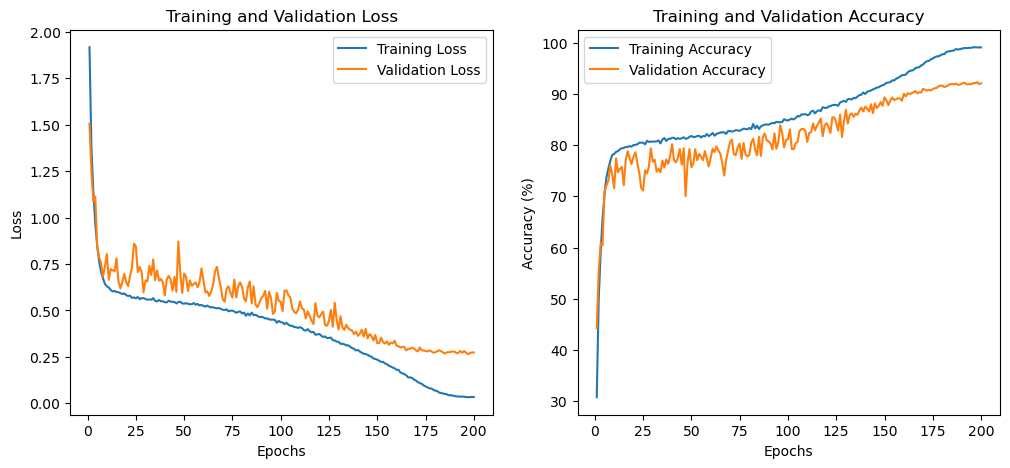

CPU times: user 1h 27s, sys: 12min 53s, total: 1h 13min 20s
Wall time: 2h 38min 38s


In [47]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = MobileNetV2()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

mobilenetv2_0_1_SGD_train_losses = []
mobilenetv2_0_1_SGD_val_losses = []
mobilenetv2_0_1_SGD_train_accuracies = []
mobilenetv2_0_1_SGD_val_accuracies = []


for epoch in range(start_epoch, 200):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    mobilenetv2_0_1_SGD_train_losses.append(train_loss)
    mobilenetv2_0_1_SGD_val_losses.append(val_loss)
    mobilenetv2_0_1_SGD_train_accuracies.append(train_accuracy)
    mobilenetv2_0_1_SGD_val_accuracies.append(val_accuracy)

state_mobilenetv2_0_1_SGD,  acc_mobilenetv2_0_1_SGD = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_mobilenetv2_0_1_SGD)

plot_metrics(mobilenetv2_0_1_SGD_train_losses, mobilenetv2_0_1_SGD_val_losses, 
             mobilenetv2_0_1_SGD_train_accuracies, mobilenetv2_0_1_SGD_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [48]:
file_path_mobilenetv2_0_1_SGD = "./result_and_model/mobilenetv2_0_1_SGD_results.pkl"
model_state_path_mobilenetv2_0_1_SGD = "./result_and_model/mobilenetv2_0_1_SGD_model.pth"

with open(file_path_mobilenetv2_0_1_SGD, "wb") as f:
    pickle.dump({
        "train_losses": mobilenetv2_0_1_SGD_train_losses,
        "val_losses": mobilenetv2_0_1_SGD_val_losses,
        "train_accuracies": mobilenetv2_0_1_SGD_train_accuracies,
        "val_accuracies": mobilenetv2_0_1_SGD_val_accuracies,
        "best_accuracy": acc_mobilenetv2_0_1_SGD
    }, f)


torch.save(state_mobilenetv2_0_1_SGD, model_state_path_mobilenetv2_0_1_SGD)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = SGD

Epoch: 0


Validation Epoch 0: 100%|████| 79/79 [00:14<00:00,  5.51it/s, Acc=48, Loss=1.48]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=60.6, Loss=1.22]



Epoch: 2


 Training Epoch 2: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=64.1, Loss=0.901
Validation Epoch 2: 100%|███| 79/79 [00:14<00:00,  5.61it/s, Acc=66, Loss=0.487]



Epoch: 3


Validation Epoch 3: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=67.9, Loss=0.839]



Epoch: 4


Validation Epoch 4: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=73.1, Loss=0.765]



Epoch: 5


 Training Epoch 5: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=75.8, Loss=0.842
Validation Epoch 5: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=76.1, Loss=0.566]



Epoch: 6


 Training Epoch 6: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=78.1, Loss=0.897
Validation Epoch 6: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=77.8, Loss=0.623]



Epoch: 7


 Training Epoch 7: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=80.2, Loss=0.568
Validation Epoch 7: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.1, Loss=0.265]



Epoch: 8


 Training Epoch 8: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=81.1, Loss=0.527
Validation Epoch 8: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=79.7, Loss=0.374]



Epoch: 9


 Training Epoch 9: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=82.6, Loss=0.517
Validation Epoch 9: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=80.3, Loss=0.482]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=83.2, Loss=0.52
Validation Epoch 10: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=82, Loss=0.605]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=84.2, Loss=0.51
Validation Epoch 11: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=82.1, Loss=0.522



Epoch: 12


Validation Epoch 12: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=83, Loss=0.588]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=85.8, Loss=0.73
Validation Epoch 13: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=83.3, Loss=0.566



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=86.4, Loss=0.31
Validation Epoch 14: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=82.8, Loss=0.343



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=87, Loss=0.349]
Validation Epoch 15: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=83.6, Loss=0.283



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=87.4, Loss=0.27
Validation Epoch 16: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.1, Loss=0.293



Epoch: 17


 Training Epoch 17: 100%|██| 313/313 [00:33<00:00,  9.38it/s, Acc=88, Loss=0.61]
Validation Epoch 17: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.3, Loss=0.357



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=88.3, Loss=0.33
Validation Epoch 18: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=83.6, Loss=0.214



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=89, Loss=0.401]
Validation Epoch 19: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=85.6, Loss=0.124



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=89.1, Loss=0.35
Validation Epoch 20: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.6, Loss=0.343



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=89.5, Loss=0.43
Validation Epoch 21: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.2, Loss=0.643



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=89.9, Loss=0.27
Validation Epoch 22: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86.2, Loss=0.247



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=90.2, Loss=0.38
Validation Epoch 23: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=85.7, Loss=0.368



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=90.4, Loss=0.25
Validation Epoch 24: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=85.9, Loss=0.053



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=90.8, Loss=0.24
Validation Epoch 25: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=86.6, Loss=0.376



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=91.3, Loss=0.31
Validation Epoch 26: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.8, Loss=0.29]



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=91.4, Loss=0.34
Validation Epoch 27: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.7, Loss=0.161



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=91.6, Loss=0.19
Validation Epoch 28: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=84.9, Loss=0.186



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=91.6, Loss=0.22
Validation Epoch 29: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.7, Loss=0.187



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=91.9, Loss=0.13
Validation Epoch 30: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86.2, Loss=0.231



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=92.2, Loss=0.15
Validation Epoch 31: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=86.7, Loss=0.364



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=92.2, Loss=0.49
Validation Epoch 32: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.6, Loss=0.328



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=92.4, Loss=0.23
Validation Epoch 33: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.8, Loss=0.198



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=92.9, Loss=0.14
Validation Epoch 34: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86.8, Loss=0.493



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=93, Loss=0.147]
Validation Epoch 35: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.1, Loss=0.099



Epoch: 36


Validation Epoch 36: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.3, Loss=0.29]



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=93.2, Loss=0.31
Validation Epoch 37: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=87.7, Loss=0.157



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=93.4, Loss=0.16
Validation Epoch 38: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=87.6, Loss=0.113



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=93.4, Loss=0.23
Validation Epoch 39: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=87, Loss=0.221]



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=93.9, Loss=0.19
Validation Epoch 40: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.3, Loss=0.305



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=93.9, Loss=0.30
Validation Epoch 41: 100%|██| 79/79 [00:14<00:00,  5.48it/s, Acc=88, Loss=0.252]



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=94.1, Loss=0.20
Validation Epoch 42: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=88, Loss=0.0789]



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=94, Loss=0.0605
Validation Epoch 43: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88.2, Loss=0.351



Epoch: 44


Validation Epoch 44: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88, Loss=0.0421]



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=94.3, Loss=0.30
Validation Epoch 45: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.8, Loss=0.149



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=94.4, Loss=0.12
Validation Epoch 46: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=88.8, Loss=0.052



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=94.5, Loss=0.25
Validation Epoch 47: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=88.4, Loss=0.275



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=94.7, Loss=0.05
Validation Epoch 48: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88.6, Loss=0.252



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=94.8, Loss=0.25
Validation Epoch 49: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=88.1, Loss=0.303



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=95.1, Loss=0.10
Validation Epoch 50: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=88.5, Loss=0.149



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=95, Loss=0.104]
Validation Epoch 51: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.4, Loss=0.387



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=95.1, Loss=0.17
Validation Epoch 52: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=88.8, Loss=0.563



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=95.4, Loss=0.23
Validation Epoch 53: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=88.4, Loss=0.404



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=95.1, Loss=0.45
Validation Epoch 54: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.9, Loss=0.357



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=95.5, Loss=0.12
Validation Epoch 55: 100%|█| 79/79 [00:14<00:00,  5.47it/s, Acc=88.2, Loss=0.263



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=95.6, Loss=0.29
Validation Epoch 56: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=87, Loss=0.219]



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=95.5, Loss=0.23
Validation Epoch 57: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.8, Loss=0.49]



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=95.9, Loss=0.12
Validation Epoch 58: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=88.1, Loss=0.555



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=95.8, Loss=0.15
Validation Epoch 59: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=88.7, Loss=0.386



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=96.1, Loss=0.07
Validation Epoch 60: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=88.6, Loss=0.208



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=96, Loss=0.0655
Validation Epoch 61: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=88.3, Loss=0.229



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=96.3, Loss=0.17
Validation Epoch 62: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=89.5, Loss=0.18]



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=96.2, Loss=0.07
Validation Epoch 63: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=89.1, Loss=0.095



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=96.3, Loss=0.12
Validation Epoch 64: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=89.1, Loss=0.17]



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=96.4, Loss=0.10
Validation Epoch 65: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.5, Loss=0.186



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=96.4, Loss=0.32
Validation Epoch 66: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.9, Loss=0.251



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=96.4, Loss=0.08
Validation Epoch 67: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=89.6, Loss=0.112



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=96.7, Loss=0.12
Validation Epoch 68: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=88.7, Loss=0.219



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=96.7, Loss=0.11
Validation Epoch 69: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=89.5, Loss=0.336



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=96.8, Loss=0.17
Validation Epoch 70: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=89.4, Loss=0.454



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=96.8, Loss=0.27
Validation Epoch 71: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=89.5, Loss=0.376



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=96.9, Loss=0.15
Validation Epoch 72: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=90, Loss=0.0341]



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=96.8, Loss=0.10
Validation Epoch 73: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.9, Loss=0.914



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=96.9, Loss=0.05
Validation Epoch 74: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=89.9, Loss=0.199



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=96.9, Loss=0.08
Validation Epoch 75: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=90.2, Loss=0.241



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=97.2, Loss=0.06
Validation Epoch 76: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.1, Loss=0.371



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=97.3, Loss=0.09
Validation Epoch 77: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.7, Loss=0.24]



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=97.2, Loss=0.05
Validation Epoch 78: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.6, Loss=0.895



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=97.5, Loss=0.10
Validation Epoch 79: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=90, Loss=0.0159]



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=97.1, Loss=0.11
Validation Epoch 80: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.6, Loss=0.072



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=97.5, Loss=0.04
Validation Epoch 81: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.1, Loss=0.294



Epoch: 82


 Training Epoch 82: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=97.4, Loss=0.06
Validation Epoch 82: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=90, Loss=0.0157]



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=97.5, Loss=0.11
Validation Epoch 83: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.5, Loss=0.144



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=97.5, Loss=0.10
Validation Epoch 84: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=89.9, Loss=0.268



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=97.5, Loss=0.12
Validation Epoch 85: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.4, Loss=0.286



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=97.8, Loss=0.06
Validation Epoch 86: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=90, Loss=0.141]



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=97.9, Loss=0.07
Validation Epoch 87: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90, Loss=0.0251]



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=97.8, Loss=0.05
Validation Epoch 88: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.7, Loss=0.41]



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.1, Loss=0.10
Validation Epoch 89: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=90.5, Loss=0.38]



Epoch: 90


 Training Epoch 90: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=98.1, Loss=0.15
Validation Epoch 90: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=89.3, Loss=0.26]



Epoch: 91


 Training Epoch 91: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=97.9, Loss=0.05
Validation Epoch 91: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.8, Loss=0.059



Epoch: 92


Validation Epoch 92: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=90, Loss=0.323]



Epoch: 93


 Training Epoch 93: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=98, Loss=0.0424
Validation Epoch 93: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.6, Loss=0.092



Epoch: 94


 Training Epoch 94: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.2, Loss=0.01
Validation Epoch 94: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=89.7, Loss=0.193



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=98.3, Loss=0.04
Validation Epoch 95: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.4, Loss=0.371



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.4, Loss=0.02
Validation Epoch 96: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.3, Loss=0.108



Epoch: 97


 Training Epoch 97: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.3, Loss=0.15
Validation Epoch 97: 100%|██| 79/79 [00:14<00:00,  5.50it/s, Acc=91, Loss=0.071]



Epoch: 98


 Training Epoch 98: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.4, Loss=0.02
Validation Epoch 98: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.5, Loss=0.298



Epoch: 99


 Training Epoch 99: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.6, Loss=0.06
Validation Epoch 99: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=90.8, Loss=0.412



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=98.5, Loss=0.0
Validation Epoch 100: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=91.2, Loss=0.10



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.5, Loss=0.0
Validation Epoch 101: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=90.8, Loss=0.65



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=98.6, Loss=0.0
Validation Epoch 102: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=91.1, Loss=0.24



Epoch: 103


 Training Epoch 103: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=98.7, Loss=0.0
Validation Epoch 103: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91, Loss=0.142]



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.8, Loss=0.0
Validation Epoch 104: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=91, Loss=0.274]



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=98.7, Loss=0.0
Validation Epoch 105: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.8, Loss=0.04



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.7, Loss=0.0
Validation Epoch 106: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=90.5, Loss=0.42



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=98.8, Loss=0.0
Validation Epoch 107: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.8, Loss=0.18



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=98.8, Loss=0.1
Validation Epoch 108: 100%|█| 79/79 [00:14<00:00,  5.46it/s, Acc=91.1, Loss=0.01



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=98.9, Loss=0.0
Validation Epoch 109: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.9, Loss=0.15



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=98.9, Loss=0.0
Validation Epoch 110: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91, Loss=0.0494



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.1, Loss=0.0
Validation Epoch 111: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=90.8, Loss=0.41



Epoch: 112


 Training Epoch 112: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.1, Loss=0.0
Validation Epoch 112: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=91.2, Loss=0.36



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=99.2, Loss=0.0
Validation Epoch 113: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.7, Loss=0.26



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.1, Loss=0.0
Validation Epoch 114: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.35



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=99.3, Loss=0.0
Validation Epoch 115: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91, Loss=0.278]



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=99.3, Loss=0.0
Validation Epoch 116: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.5, Loss=0.53



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=99.3, Loss=0.0
Validation Epoch 117: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.8, Loss=0.24



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.4, Loss=0.0
Validation Epoch 118: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=91.1, Loss=0.09



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.4, Loss=0.0
Validation Epoch 119: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.5, Loss=0.58



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=99.6, Loss=0.0
Validation Epoch 120: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.6, Loss=0.40



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=99.6, Loss=0.0
Validation Epoch 121: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=91.7, Loss=0.51



Epoch: 122


 Training Epoch 122: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.6, Loss=0.0
Validation Epoch 122: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.8, Loss=0.51



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.6, Loss=0.0
Validation Epoch 123: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=91.8, Loss=0.27



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.6, Loss=0.0
Validation Epoch 124: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=92, Loss=0.356]



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.6, Loss=0.0
Validation Epoch 125: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.9, Loss=0.42



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.6, Loss=0.0
Validation Epoch 126: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.1, Loss=0.46



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.7, Loss=0.0
Validation Epoch 127: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=91.7, Loss=0.09



Epoch: 128


 Training Epoch 128: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.7, Loss=0.0
Validation Epoch 128: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92, Loss=0.385]



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=99.7, Loss=0.0
Validation Epoch 129: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92, Loss=0.418]



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.8, Loss=0.0
Validation Epoch 130: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.5, Loss=0.34



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.7, Loss=0.0
Validation Epoch 131: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92, Loss=0.726]



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.7, Loss=0.0
Validation Epoch 132: 100%|██| 79/79 [00:14<00:00,  5.49it/s, Acc=92, Loss=0.61]



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.8, Loss=0.0
Validation Epoch 133: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=92.1, Loss=0.52



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.8, Loss=0.0
Validation Epoch 134: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=92.2, Loss=0.17



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.8, Loss=0.0
Validation Epoch 135: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92, Loss=0.588]



Epoch: 136


 Training Epoch 136: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.9, Loss=0.0
Validation Epoch 136: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=92.2, Loss=0.42



Epoch: 137


 Training Epoch 137: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.8, Loss=0.0
Validation Epoch 137: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.1, Loss=0.41



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.8, Loss=0.0
Validation Epoch 138: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.3, Loss=0.13



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.9, Loss=0.0
Validation Epoch 139: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.6, Loss=0.09



Epoch: 140


 Training Epoch 140: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.9, Loss=0.0
Validation Epoch 140: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.4, Loss=0.30



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.9, Loss=0.0
Validation Epoch 141: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=92.3, Loss=0.13



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=99.9, Loss=0.0
Validation Epoch 142: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.4, Loss=0.17



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=99.9, Loss=0.0
Validation Epoch 143: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.6, Loss=0.07



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.9, Loss=0.0
Validation Epoch 144: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.6, Loss=0.60



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=99.9, Loss=0.0
Validation Epoch 145: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.6, Loss=0.02



Epoch: 146


 Training Epoch 146: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.9, Loss=0.0
Validation Epoch 146: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.1, Loss=0.31



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.9, Loss=0.0
Validation Epoch 147: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=92.7, Loss=0.01



Epoch: 148


 Training Epoch 148: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=100, Loss=0.04
Validation Epoch 148: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.5, Loss=0.47



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=99.9, Loss=0.0
Validation Epoch 149: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.8, Loss=0.04



Epoch: 150


 Training Epoch 150: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=99.9, Loss=0.0
Validation Epoch 150: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=92.7, Loss=0.52



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 151: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.8, Loss=0.51



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=99.9, Loss=0.0
Validation Epoch 152: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=92.9, Loss=0.40



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=100, Loss=0.00
Validation Epoch 153: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.9, Loss=0.51



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=100, Loss=0.00
Validation Epoch 154: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=92.7, Loss=0.38



Epoch: 155


 Training Epoch 155: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=100, Loss=0.00
Validation Epoch 155: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93, Loss=0.0634



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=100, Loss=0.00
Validation Epoch 156: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.9, Loss=0.49



Epoch: 157


 Training Epoch 157: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=100, Loss=0.00
Validation Epoch 157: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.9, Loss=0.09



Epoch: 158


 Training Epoch 158: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.02
Validation Epoch 158: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.7, Loss=0.16



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 159: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.9, Loss=0.06



Epoch: 160


 Training Epoch 160: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=100, Loss=0.00
Validation Epoch 160: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.5, Loss=0.47



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=100, Loss=0.00
Validation Epoch 161: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=92.9, Loss=0.43



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=100, Loss=0.00
Validation Epoch 162: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.8, Loss=0.33



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=100, Loss=0.00
Validation Epoch 163: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.8, Loss=0.39



Epoch: 164


 Training Epoch 164: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 164: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.9, Loss=0.26



Epoch: 165


 Training Epoch 165: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 165: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.8, Loss=0.37



Epoch: 166


 Training Epoch 166: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=100, Loss=0.00
Validation Epoch 166: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.7, Loss=0.44



Epoch: 167


 Training Epoch 167: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=100, Loss=0.00
Validation Epoch 167: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=93, Loss=0.203]



Epoch: 168


 Training Epoch 168: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=100, Loss=0.00
Validation Epoch 168: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=93.1, Loss=0.14



Epoch: 169


 Training Epoch 169: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 169: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=93, Loss=0.265]



Epoch: 170


 Training Epoch 170: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=100, Loss=0.00
Validation Epoch 170: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.9, Loss=0.32



Epoch: 171


 Training Epoch 171: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 171: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=92.9, Loss=0.49



Epoch: 172


 Training Epoch 172: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 172: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.9, Loss=0.17



Epoch: 173


 Training Epoch 173: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=100, Loss=0.00
Validation Epoch 173: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=93.1, Loss=0.00



Epoch: 174


 Training Epoch 174: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 174: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.6, Loss=0.52



Epoch: 175


 Training Epoch 175: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.03
Validation Epoch 175: 100%|█| 79/79 [00:14<00:00,  5.47it/s, Acc=93.2, Loss=0.01



Epoch: 176


 Training Epoch 176: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=100, Loss=0.00
Validation Epoch 176: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=93, Loss=0.498]



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=100, Loss=0.02
Validation Epoch 177: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=92.8, Loss=0.18



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=100, Loss=0.00
Validation Epoch 178: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93.1, Loss=0.25



Epoch: 179


 Training Epoch 179: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=100, Loss=0.02
Validation Epoch 179: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=92.8, Loss=0.48



Epoch: 180


 Training Epoch 180: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=100, Loss=0.00
Validation Epoch 180: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.1, Loss=0.18



Epoch: 181


 Training Epoch 181: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=100, Loss=0.00
Validation Epoch 181: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.1, Loss=0.24



Epoch: 182


 Training Epoch 182: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=100, Loss=0.00
Validation Epoch 182: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.9, Loss=0.09



Epoch: 183


 Training Epoch 183: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=100, Loss=0.00
Validation Epoch 183: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.3, Loss=0.44



Epoch: 184


 Training Epoch 184: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=100, Loss=0.00
Validation Epoch 184: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=93, Loss=0.315]



Epoch: 185


 Training Epoch 185: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=100, Loss=0.00
Validation Epoch 185: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93, Loss=0.187]



Epoch: 186


 Training Epoch 186: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=100, Loss=0.00
Validation Epoch 186: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.8, Loss=0.21



Epoch: 187


 Training Epoch 187: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 187: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=93, Loss=0.436]



Epoch: 188


 Training Epoch 188: 100%|█| 313/313 [00:33<00:00,  9.35it/s, Acc=100, Loss=0.04
Validation Epoch 188: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.8, Loss=0.32



Epoch: 189


 Training Epoch 189: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=100, Loss=0.00
Validation Epoch 189: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=93, Loss=0.0091



Epoch: 190


 Training Epoch 190: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 190: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=93.1, Loss=0.45



Epoch: 191


 Training Epoch 191: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 191: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.8, Loss=0.14



Epoch: 192


 Training Epoch 192: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 192: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.7, Loss=0.32



Epoch: 193


 Training Epoch 193: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 193: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.7, Loss=0.54



Epoch: 194


 Training Epoch 194: 100%|█| 313/313 [00:33<00:00,  9.38it/s, Acc=100, Loss=0.00
Validation Epoch 194: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=92.9, Loss=0.34



Epoch: 195


 Training Epoch 195: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=100, Loss=0.00
Validation Epoch 195: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.9, Loss=0.36



Epoch: 196


 Training Epoch 196: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=100, Loss=0.00
Validation Epoch 196: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=93.1, Loss=0.48



Epoch: 197


 Training Epoch 197: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=100, Loss=0.00
Validation Epoch 197: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=93, Loss=0.533]



Epoch: 198


 Training Epoch 198: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=100, Loss=0.00
Validation Epoch 198: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=93, Loss=0.462]



Epoch: 199


 Training Epoch 199: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=100, Loss=0.00
Validation Epoch 199: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=93, Loss=0.0897

Validation Accuracy:  93.27


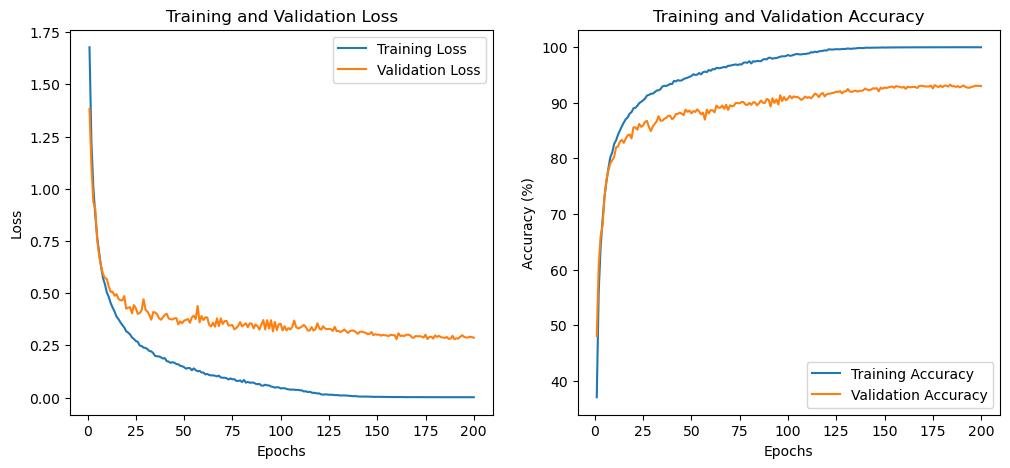

CPU times: user 1h 36s, sys: 13min 27s, total: 1h 14min 4s
Wall time: 2h 38min 46s


In [49]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = MobileNetV2()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

mobilenetv2_0_0_1_SGD_train_losses = []
mobilenetv2_0_0_1_SGD_val_losses = []
mobilenetv2_0_0_1_SGD_train_accuracies = []
mobilenetv2_0_0_1_SGD_val_accuracies = []

for epoch in range(start_epoch, 200):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    mobilenetv2_0_0_1_SGD_train_losses.append(train_loss)
    mobilenetv2_0_0_1_SGD_val_losses.append(val_loss)
    mobilenetv2_0_0_1_SGD_train_accuracies.append(train_accuracy)
    mobilenetv2_0_0_1_SGD_val_accuracies.append(val_accuracy)

state_mobilenetv2_0_0_1_SGD,  acc_mobilenetv2_0_0_1_SGD = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_mobilenetv2_0_0_1_SGD)

plot_metrics(mobilenetv2_0_0_1_SGD_train_losses, mobilenetv2_0_0_1_SGD_val_losses, 
             mobilenetv2_0_0_1_SGD_train_accuracies, mobilenetv2_0_0_1_SGD_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [50]:
file_path_mobilenetv2_0_0_1_SGD = "./result_and_model/mobilenetv2_0_0_1_SGD_results.pkl"
model_state_path_mobilenetv2_0_0_1_SGD = "./result_and_model/mobilenetv2_0_0_1_SGD_model.pth"

with open(file_path_mobilenetv2_0_0_1_SGD, "wb") as f:
    pickle.dump({
        "train_losses": mobilenetv2_0_0_1_SGD_train_losses,
        "val_losses": mobilenetv2_0_0_1_SGD_val_losses,
        "train_accuracies": mobilenetv2_0_0_1_SGD_train_accuracies,
        "val_accuracies": mobilenetv2_0_0_1_SGD_val_accuracies,
        "best_accuracy": acc_mobilenetv2_0_0_1_SGD
    }, f)


torch.save(state_mobilenetv2_0_0_1_SGD, model_state_path_mobilenetv2_0_0_1_SGD)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.1, Optimizer = Adam

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:14<00:00,  5.54it/s, Acc=10.6, Loss=2.34]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=10.1, Loss=2.28]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:14<00:00,  5.57it/s, Acc=19.8, Loss=2.16]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=21.1, Loss=2.11]



Epoch: 4


Validation Epoch 4: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=22.6, Loss=2.09]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:14<00:00,  5.57it/s, Acc=27.5, Loss=2.01]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=29.6, Loss=2.05]



Epoch: 7


Validation Epoch 7: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=40.2, Loss=0.911]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=38.7, Loss=1.52]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=46.2, Loss=1.22]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=53.1, Loss=1.12
Validation Epoch 10: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=54.7, Loss=0.957



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=59.1, Loss=1.52
Validation Epoch 11: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=58.8, Loss=0.94]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=62.5, Loss=1.08
Validation Epoch 12: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=61.2, Loss=0.707



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=65.2, Loss=1.14
Validation Epoch 13: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=65.1, Loss=0.627



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=67, Loss=0.759]
Validation Epoch 14: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=62.3, Loss=0.604



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=68.2, Loss=1.05
Validation Epoch 15: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=67.5, Loss=0.662



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=70.3, Loss=0.82
Validation Epoch 16: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=68, Loss=0.679]



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=71.5, Loss=1.17
Validation Epoch 17: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=69.2, Loss=0.629



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=73.2, Loss=0.87
Validation Epoch 18: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=72.7, Loss=0.721



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=74.1, Loss=0.81
Validation Epoch 19: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=73.8, Loss=0.394



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=75.2, Loss=0.64
Validation Epoch 20: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=74.2, Loss=0.535



Epoch: 21


Validation Epoch 21: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=74.3, Loss=1.02]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=77.4, Loss=1.03
Validation Epoch 22: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=72.7, Loss=0.41]



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=77.7, Loss=0.70
Validation Epoch 23: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=76.4, Loss=0.251



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=78.9, Loss=0.77
Validation Epoch 24: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=77.7, Loss=0.223



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=79.3, Loss=0.35
Validation Epoch 25: 100%|██| 79/79 [00:14<00:00,  5.57it/s, Acc=78, Loss=0.727]



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=79.8, Loss=0.55
Validation Epoch 26: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=75.4, Loss=0.393



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=80.4, Loss=0.53
Validation Epoch 27: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=79.7, Loss=0.355



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=81.1, Loss=0.64
Validation Epoch 28: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=79.6, Loss=0.179



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=81.3, Loss=0.58
Validation Epoch 29: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=80.8, Loss=0.278



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=82.2, Loss=0.56
Validation Epoch 30: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=79.8, Loss=0.232



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=82.3, Loss=0.47
Validation Epoch 31: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=82.3, Loss=0.344



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=83.1, Loss=0.65
Validation Epoch 32: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=79.8, Loss=0.474



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=83.3, Loss=0.47
Validation Epoch 33: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=81.3, Loss=0.279



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=84.2, Loss=0.66
Validation Epoch 34: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=80.3, Loss=0.495



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=84.1, Loss=0.49
Validation Epoch 35: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=81, Loss=0.597]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=84.6, Loss=0.61
Validation Epoch 36: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=83.2, Loss=0.323



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=84.8, Loss=0.68
Validation Epoch 37: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=82.8, Loss=0.279



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=85.7, Loss=0.36
Validation Epoch 38: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=83, Loss=0.274]



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=85.5, Loss=0.35
Validation Epoch 39: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=83.2, Loss=0.229



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=85.8, Loss=0.51
Validation Epoch 40: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=84, Loss=0.125]



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=86.2, Loss=0.53
Validation Epoch 41: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=84, Loss=0.457]



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=86.6, Loss=0.65
Validation Epoch 42: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=82.2, Loss=0.266



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=86.9, Loss=0.43
Validation Epoch 43: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=85.3, Loss=0.126



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=87, Loss=0.215]
Validation Epoch 44: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=82.7, Loss=0.214



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=87.4, Loss=0.34
Validation Epoch 45: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=83.6, Loss=0.262



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=87.5, Loss=0.51
Validation Epoch 46: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=83.6, Loss=0.358



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=87.6, Loss=0.28
Validation Epoch 47: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=85.8, Loss=0.465



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=88.4, Loss=0.46
Validation Epoch 48: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=84.2, Loss=0.347



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=88.2, Loss=0.36
Validation Epoch 49: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=84.9, Loss=0.251



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=88.8, Loss=0.43
Validation Epoch 50: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=85.1, Loss=0.256



Epoch: 51


 Training Epoch 51: 100%|██| 313/313 [00:33<00:00,  9.33it/s, Acc=89, Loss=0.13]
Validation Epoch 51: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=85.3, Loss=0.066



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=89.1, Loss=0.43
Validation Epoch 52: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=85.7, Loss=0.278



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=89.5, Loss=0.41
Validation Epoch 53: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=86.6, Loss=0.194



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=89.3, Loss=0.57
Validation Epoch 54: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=85.8, Loss=0.451



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=89.6, Loss=0.52
Validation Epoch 55: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.7, Loss=0.094



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=89.9, Loss=0.40
Validation Epoch 56: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=85.7, Loss=0.114



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=89.8, Loss=0.33
Validation Epoch 57: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=87, Loss=0.548]



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=90.2, Loss=0.36
Validation Epoch 58: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86, Loss=0.0963]



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=90.3, Loss=0.49
Validation Epoch 59: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=86.4, Loss=0.186



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=90.7, Loss=0.28
Validation Epoch 60: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.3, Loss=0.134



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=90.8, Loss=0.11
Validation Epoch 61: 100%|██| 79/79 [00:14<00:00,  5.56it/s, Acc=83, Loss=0.226]



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=91, Loss=0.294]
Validation Epoch 62: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.5, Loss=0.259



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=91.3, Loss=0.17
Validation Epoch 63: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=86.3, Loss=0.046



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=91.3, Loss=0.27
Validation Epoch 64: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.3, Loss=0.138



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=91.5, Loss=0.46
Validation Epoch 65: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.6, Loss=0.173



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=91.7, Loss=0.59
Validation Epoch 66: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.8, Loss=0.068



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=91.7, Loss=0.31
Validation Epoch 67: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=87.3, Loss=0.072



Epoch: 68


Validation Epoch 68: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=87.2, Loss=0.14]



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=92.3, Loss=0.11
Validation Epoch 69: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88, Loss=0.0995]



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=92.5, Loss=0.18
Validation Epoch 70: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.6, Loss=0.284



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=92.4, Loss=0.26
Validation Epoch 71: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=87.7, Loss=0.039



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=93, Loss=0.349]
Validation Epoch 72: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.5, Loss=0.023



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=92.8, Loss=0.18
Validation Epoch 73: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.8, Loss=0.43]



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=93.1, Loss=0.19
Validation Epoch 74: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.2, Loss=0.128



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=93, Loss=0.419]
Validation Epoch 75: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.5, Loss=0.175



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=93.4, Loss=0.14
Validation Epoch 76: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.9, Loss=0.205



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=93.4, Loss=0.51
Validation Epoch 77: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=88.3, Loss=0.056



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=93.5, Loss=0.42
Validation Epoch 78: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.4, Loss=0.243



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=93.8, Loss=0.39
Validation Epoch 79: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=87.8, Loss=0.227



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=93.8, Loss=0.11
Validation Epoch 80: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=87.7, Loss=0.135



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=94.1, Loss=0.07
Validation Epoch 81: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.5, Loss=0.305



Epoch: 82


Validation Epoch 82: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=87.9, Loss=0.22]



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=94.1, Loss=0.19
Validation Epoch 83: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=87.8, Loss=0.030



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=94.4, Loss=0.09
Validation Epoch 84: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88.6, Loss=0.279



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=94.3, Loss=0.13
Validation Epoch 85: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88.9, Loss=0.301



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=94.7, Loss=0.15
Validation Epoch 86: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.4, Loss=0.015



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=94.8, Loss=0.37
Validation Epoch 87: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=87.7, Loss=0.006



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=94.6, Loss=0.18
Validation Epoch 88: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.4, Loss=0.016



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=94.9, Loss=0.24
Validation Epoch 89: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=88.2, Loss=0.107



Epoch: 90


 Training Epoch 90: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=95.2, Loss=0.14
Validation Epoch 90: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.9, Loss=0.149



Epoch: 91


 Training Epoch 91: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=95.1, Loss=0.12
Validation Epoch 91: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.8, Loss=0.41]



Epoch: 92


 Training Epoch 92: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=95.3, Loss=0.30
Validation Epoch 92: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.8, Loss=0.663



Epoch: 93


 Training Epoch 93: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=95.3, Loss=0.15
Validation Epoch 93: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.7, Loss=0.419



Epoch: 94


 Training Epoch 94: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=95.6, Loss=0.12
Validation Epoch 94: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=88.7, Loss=0.194



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=95.6, Loss=0.01
Validation Epoch 95: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=88.2, Loss=0.039



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=95.8, Loss=0.09
Validation Epoch 96: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.7, Loss=0.398



Epoch: 97


 Training Epoch 97: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=95.7, Loss=0.10
Validation Epoch 97: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88.7, Loss=0.107



Epoch: 98


 Training Epoch 98: 100%|██| 313/313 [00:33<00:00,  9.29it/s, Acc=96, Loss=0.13]
Validation Epoch 98: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88.8, Loss=0.023



Epoch: 99


 Training Epoch 99: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=96, Loss=0.143]
Validation Epoch 99: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=88.9, Loss=0.012



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=96.1, Loss=0.1
Validation Epoch 100: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=88.7, Loss=0.16



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=96.1, Loss=0.1
Validation Epoch 101: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=89, Loss=0.0434



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=96.5, Loss=0.0
Validation Epoch 102: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=89.2, Loss=0.04



Epoch: 103


 Training Epoch 103: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=96.4, Loss=0.0
Validation Epoch 103: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89, Loss=0.0397



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=96.5, Loss=0.0
Validation Epoch 104: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.3, Loss=0.02



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=96.7, Loss=0.4
Validation Epoch 105: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.1, Loss=0.12



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=96.6, Loss=0.1
Validation Epoch 106: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.1, Loss=0.04



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=96.8, Loss=0.0
Validation Epoch 107: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.5, Loss=0.08



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=97, Loss=0.227
Validation Epoch 108: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.2, Loss=0.16



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=97.1, Loss=0.0
Validation Epoch 109: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.4, Loss=0.46



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=97.1, Loss=0.0
Validation Epoch 110: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.1, Loss=0.04



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=97.2, Loss=0.1
Validation Epoch 111: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.8, Loss=0.02



Epoch: 112


 Training Epoch 112: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=97.2, Loss=0.0
Validation Epoch 112: 100%|█| 79/79 [00:14<00:00,  5.46it/s, Acc=89, Loss=0.0314



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=97.5, Loss=0.2
Validation Epoch 113: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=88.8, Loss=0.02



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=97.2, Loss=0.0
Validation Epoch 114: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=89, Loss=0.0734



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=97.4, Loss=0.0
Validation Epoch 115: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=88.8, Loss=0.01



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=97.6, Loss=0.0
Validation Epoch 116: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=89.1, Loss=0.02



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=97.7, Loss=0.1
Validation Epoch 117: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.1, Loss=0.00



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=97.7, Loss=0.0
Validation Epoch 118: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=89, Loss=0.0185



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=97.6, Loss=0.0
Validation Epoch 119: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.5, Loss=0.33



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=97.9, Loss=0.1
Validation Epoch 120: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=89.2, Loss=0.00



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=98.1, Loss=0.0
Validation Epoch 121: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=89.4, Loss=0.31



Epoch: 122


 Training Epoch 122: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=98, Loss=0.043
Validation Epoch 122: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.6, Loss=0.40



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=98.1, Loss=0.0
Validation Epoch 123: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.3, Loss=0.00



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=98, Loss=0.112
Validation Epoch 124: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=89.9, Loss=0.00



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=98.1, Loss=0.0
Validation Epoch 125: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=89.7, Loss=0.31



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=98.2, Loss=0.0
Validation Epoch 126: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=89.5, Loss=0.00



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=98.3, Loss=0.0
Validation Epoch 127: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.2, Loss=0.14



Epoch: 128


 Training Epoch 128: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=98.3, Loss=0.0
Validation Epoch 128: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.1, Loss=0.03



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=98.2, Loss=0.0
Validation Epoch 129: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.3, Loss=0.01



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=98.5, Loss=0.0
Validation Epoch 130: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.7, Loss=0.02



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=98.4, Loss=0.0
Validation Epoch 131: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=89.1, Loss=0.04



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=98.5, Loss=0.0
Validation Epoch 132: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.6, Loss=0.47



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=98.5, Loss=0.0
Validation Epoch 133: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.6, Loss=0.19



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=98.6, Loss=0.0
Validation Epoch 134: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=89.7, Loss=0.01



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=98.7, Loss=0.0
Validation Epoch 135: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.8, Loss=0.00



Epoch: 136


 Training Epoch 136: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=98.6, Loss=0.0
Validation Epoch 136: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.8, Loss=0.01



Epoch: 137


 Training Epoch 137: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=98.8, Loss=0.0
Validation Epoch 137: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.9, Loss=0.03



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=98.9, Loss=0.0
Validation Epoch 138: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.6, Loss=0.08



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=98.8, Loss=0.0
Validation Epoch 139: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.9, Loss=0.27



Epoch: 140


 Training Epoch 140: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=98.9, Loss=0.0
Validation Epoch 140: 100%|█| 79/79 [00:14<00:00,  5.46it/s, Acc=90, Loss=0.027]



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=99, Loss=0.008
Validation Epoch 141: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=89.9, Loss=0.01



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=99, Loss=0.020
Validation Epoch 142: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.6, Loss=0.04



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99, Loss=0.057
Validation Epoch 143: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.6, Loss=0.11



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99, Loss=0.031
Validation Epoch 144: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.5, Loss=0.00



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99, Loss=0.023
Validation Epoch 145: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.8, Loss=0.16



Epoch: 146


 Training Epoch 146: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.1, Loss=0.0
Validation Epoch 146: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=90.1, Loss=0.42



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=99, Loss=0.010
Validation Epoch 147: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.1, Loss=0.01



Epoch: 148


 Training Epoch 148: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.1, Loss=0.0
Validation Epoch 148: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=89.6, Loss=0.00



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.2, Loss=0.0
Validation Epoch 149: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=90, Loss=0.175]



Epoch: 150


 Training Epoch 150: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.2, Loss=0.0
Validation Epoch 150: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.9, Loss=0.00



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.2, Loss=0.0
Validation Epoch 151: 100%|█| 79/79 [00:14<00:00,  5.48it/s, Acc=89.7, Loss=0.00



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.2, Loss=0.0
Validation Epoch 152: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90, Loss=0.0134



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.2, Loss=0.0
Validation Epoch 153: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=89.8, Loss=0.03



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.3, Loss=0.0
Validation Epoch 154: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.9, Loss=0.00



Epoch: 155


 Training Epoch 155: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.3, Loss=0.0
Validation Epoch 155: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.7, Loss=0.32



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.3, Loss=0.0
Validation Epoch 156: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.6, Loss=0.00



Epoch: 157


 Training Epoch 157: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.4, Loss=0.0
Validation Epoch 157: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.8, Loss=0.55



Epoch: 158


 Training Epoch 158: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.4, Loss=0.0
Validation Epoch 158: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=89.7, Loss=0.23



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=99.3, Loss=0.0
Validation Epoch 159: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.3, Loss=0.01



Epoch: 160


 Training Epoch 160: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.3, Loss=0.1
Validation Epoch 160: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.1, Loss=0.12



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.4, Loss=0.0
Validation Epoch 161: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90, Loss=0.0097



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.4, Loss=0.0
Validation Epoch 162: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.8, Loss=0.00



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.5, Loss=0.1
Validation Epoch 163: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.7, Loss=0.00



Epoch: 164


 Training Epoch 164: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.4, Loss=0.0
Validation Epoch 164: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.8, Loss=0.02



Epoch: 165


 Training Epoch 165: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.5, Loss=0.0
Validation Epoch 165: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.8, Loss=0.06



Epoch: 166


 Training Epoch 166: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.4, Loss=0.0
Validation Epoch 166: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=89.8, Loss=0.09



Epoch: 167


 Training Epoch 167: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.5, Loss=0.0
Validation Epoch 167: 100%|███| 79/79 [00:14<00:00,  5.59it/s, Acc=90, Loss=0.1]



Epoch: 168


 Training Epoch 168: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=99.5, Loss=0.0
Validation Epoch 168: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.1, Loss=0.13



Epoch: 169


 Training Epoch 169: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=99.5, Loss=0.0
Validation Epoch 169: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90, Loss=0.0188



Epoch: 170


 Training Epoch 170: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.5, Loss=0.0
Validation Epoch 170: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.2, Loss=0.09



Epoch: 171


 Training Epoch 171: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=99.5, Loss=0.1
Validation Epoch 171: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.9, Loss=0.10



Epoch: 172


 Training Epoch 172: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.5, Loss=0.0
Validation Epoch 172: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.9, Loss=0.19



Epoch: 173


 Training Epoch 173: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=99.5, Loss=0.0
Validation Epoch 173: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90, Loss=0.372]



Epoch: 174


 Training Epoch 174: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.5, Loss=0.0
Validation Epoch 174: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90, Loss=0.0185



Epoch: 175


 Training Epoch 175: 100%|█| 313/313 [00:33<00:00,  9.34it/s, Acc=99.5, Loss=0.0
Validation Epoch 175: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=89.9, Loss=0.46



Epoch: 176


 Training Epoch 176: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.5, Loss=0.0
Validation Epoch 176: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=90.2, Loss=0.01



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.5, Loss=0.0
Validation Epoch 177: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.8, Loss=0.50



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=99.5, Loss=0.0
Validation Epoch 178: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90, Loss=0.186]



Epoch: 179


 Training Epoch 179: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=99.4, Loss=0.0
Validation Epoch 179: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90, Loss=0.0013

Validation Accuracy:  90.28


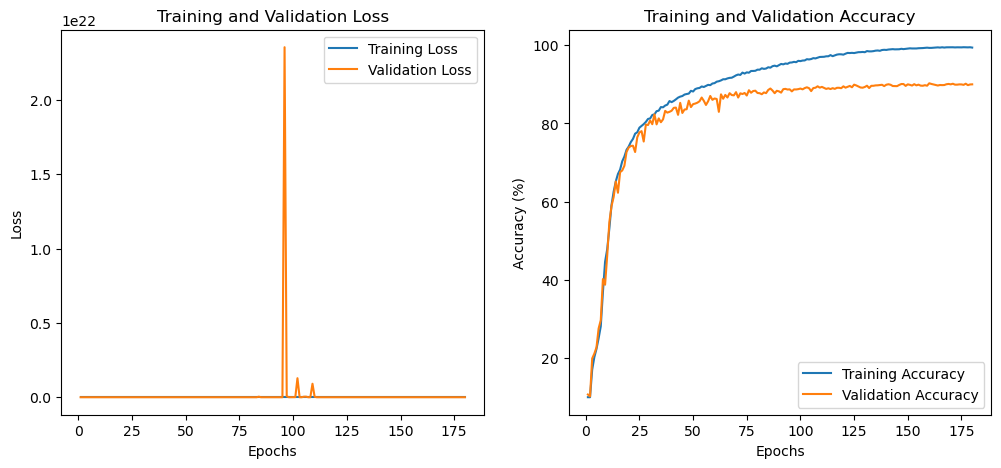

CPU times: user 1h 7min 29s, sys: 13min 2s, total: 1h 20min 31s
Wall time: 2h 23min 27s


In [51]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = MobileNetV2()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

mobilenetv2_0_1_Adam_train_losses = []
mobilenetv2_0_1_Adam_val_losses = []
mobilenetv2_0_1_Adam_train_accuracies = []
mobilenetv2_0_1_Adam_val_accuracies = []

for epoch in range(start_epoch, 180):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    mobilenetv2_0_1_Adam_train_losses.append(train_loss)
    mobilenetv2_0_1_Adam_val_losses.append(val_loss)
    mobilenetv2_0_1_Adam_train_accuracies.append(train_accuracy)
    mobilenetv2_0_1_Adam_val_accuracies.append(val_accuracy)

state_mobilenetv2_0_1_Adam,  acc_mobilenetv2_0_1_Adam = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_mobilenetv2_0_1_Adam)

plot_metrics(mobilenetv2_0_1_Adam_train_losses, mobilenetv2_0_1_Adam_val_losses, 
             mobilenetv2_0_1_Adam_train_accuracies, mobilenetv2_0_1_Adam_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [52]:
file_path_mobilenetv2_0_1_Adam = "./result_and_model/mobilenetv2_0_1_Adam_results.pkl"
model_state_path_mobilenetv2_0_1_Adam = "./result_and_model/mobilenetv2_0_1_Adam_model.pth"

with open(file_path_mobilenetv2_0_1_Adam, "wb") as f:
    pickle.dump({
        "train_losses": mobilenetv2_0_1_Adam_train_losses,
        "val_losses": mobilenetv2_0_1_Adam_val_losses,
        "train_accuracies": mobilenetv2_0_1_Adam_train_accuracies,
        "val_accuracies": mobilenetv2_0_1_Adam_val_accuracies,
        "best_accuracy": acc_mobilenetv2_0_1_Adam
    }, f)


torch.save(state_mobilenetv2_0_1_Adam, model_state_path_mobilenetv2_0_1_Adam)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = Adam

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=44.8, Loss=1.57]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=59.4, Loss=1.51]



Epoch: 2


 Training Epoch 2: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=63.8, Loss=0.938
Validation Epoch 2: 100%|███| 79/79 [00:14<00:00,  5.62it/s, Acc=66, Loss=0.537]



Epoch: 3


Validation Epoch 3: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=66.4, Loss=0.824]



Epoch: 4


 Training Epoch 4: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=73.3, Loss=0.932
Validation Epoch 4: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=73.4, Loss=0.466]



Epoch: 5


Validation Epoch 5: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=74.4, Loss=0.316]



Epoch: 6


 Training Epoch 6: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=77.8, Loss=0.773
Validation Epoch 6: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=77.8, Loss=0.537]



Epoch: 7


 Training Epoch 7: 100%|█| 313/313 [00:34<00:00,  9.17it/s, Acc=79.4, Loss=0.743
Validation Epoch 7: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=76.2, Loss=0.422]



Epoch: 8


 Training Epoch 8: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=80.6, Loss=0.572
Validation Epoch 8: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=79, Loss=0.25]



Epoch: 9


 Training Epoch 9: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=81.6, Loss=0.549
Validation Epoch 9: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=78.9, Loss=0.259]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=82.4, Loss=0.55
Validation Epoch 10: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=81.3, Loss=0.504



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=83.1, Loss=0.94
Validation Epoch 11: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=82.8, Loss=0.133



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=83.8, Loss=0.61
Validation Epoch 12: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=82.9, Loss=0.172



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=84.6, Loss=0.75
Validation Epoch 13: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=82.8, Loss=0.406



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=85, Loss=0.325]
Validation Epoch 14: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=82.4, Loss=0.266



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=85.7, Loss=0.41
Validation Epoch 15: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.1, Loss=0.302



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=86.3, Loss=0.51
Validation Epoch 16: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=84.1, Loss=0.213



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=86.7, Loss=0.49
Validation Epoch 17: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.3, Loss=0.35]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=87.1, Loss=0.23
Validation Epoch 18: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.4, Loss=0.237



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=87.3, Loss=0.55
Validation Epoch 19: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=85.1, Loss=0.297



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=88, Loss=0.489]
Validation Epoch 20: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=84.4, Loss=0.386



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=88.4, Loss=0.51
Validation Epoch 21: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.6, Loss=0.353



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=88.9, Loss=0.55
Validation Epoch 22: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.6, Loss=0.103



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=89, Loss=0.332]
Validation Epoch 23: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86.6, Loss=0.328



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=89.3, Loss=0.28
Validation Epoch 24: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.1, Loss=0.169



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=89.6, Loss=0.21
Validation Epoch 25: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.3, Loss=0.261



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=90, Loss=0.278]
Validation Epoch 26: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=85.3, Loss=0.319



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=90.2, Loss=0.33
Validation Epoch 27: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.5, Loss=0.127



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=90.4, Loss=0.29
Validation Epoch 28: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=87.5, Loss=0.29]



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=90.8, Loss=0.21
Validation Epoch 29: 100%|██| 79/79 [00:14<00:00,  5.55it/s, Acc=87, Loss=0.324]



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=91.1, Loss=0.20
Validation Epoch 30: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=86.6, Loss=0.589



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=91.2, Loss=0.22
Validation Epoch 31: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.5, Loss=0.28]



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=91.6, Loss=0.32
Validation Epoch 32: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=87.1, Loss=0.445



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=92, Loss=0.265]
Validation Epoch 33: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=87.7, Loss=0.075



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=92.3, Loss=0.32
Validation Epoch 34: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=88.1, Loss=0.24]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=92.3, Loss=0.39
Validation Epoch 35: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.7, Loss=0.341



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=92.5, Loss=0.27
Validation Epoch 36: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.6, Loss=0.224



Epoch: 37


 Training Epoch 37: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=92.9, Loss=0.24
Validation Epoch 37: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.5, Loss=0.171



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=92.6, Loss=0.16
Validation Epoch 38: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.9, Loss=0.326



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=93, Loss=0.179]
Validation Epoch 39: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=88.9, Loss=0.176



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=93.1, Loss=0.15
Validation Epoch 40: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.6, Loss=0.286



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=93.4, Loss=0.19
Validation Epoch 41: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.9, Loss=0.256



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=93.6, Loss=0.17
Validation Epoch 42: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.1, Loss=0.194



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=93.7, Loss=0.06
Validation Epoch 43: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.9, Loss=0.51]



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=93.9, Loss=0.15
Validation Epoch 44: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=88.8, Loss=0.035



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=94.1, Loss=0.25
Validation Epoch 45: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=89.7, Loss=0.288



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=94.4, Loss=0.13
Validation Epoch 46: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.1, Loss=0.189



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=94.3, Loss=0.10
Validation Epoch 47: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=89, Loss=0.355]



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=94.6, Loss=0.12
Validation Epoch 48: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=89.1, Loss=0.040



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=94.5, Loss=0.21
Validation Epoch 49: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=89.3, Loss=0.21]



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=94.8, Loss=0.17
Validation Epoch 50: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.1, Loss=0.171



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=95, Loss=0.103]
Validation Epoch 51: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=89.9, Loss=0.111



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=95.2, Loss=0.22
Validation Epoch 52: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.2, Loss=0.078



Epoch: 53


 Training Epoch 53: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=95.2, Loss=0.19
Validation Epoch 53: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=88.8, Loss=0.183



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=95.5, Loss=0.28
Validation Epoch 54: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=89.6, Loss=0.069



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:33<00:00,  9.32it/s, Acc=95.5, Loss=0.24
Validation Epoch 55: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=88.9, Loss=0.198



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=95.4, Loss=0.26
Validation Epoch 56: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=89.6, Loss=0.38]



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=95.6, Loss=0.14
Validation Epoch 57: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.8, Loss=0.128



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=95.9, Loss=0.15
Validation Epoch 58: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=88.8, Loss=0.464



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=95.9, Loss=0.24
Validation Epoch 59: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=89.9, Loss=0.467



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:33<00:00,  9.31it/s, Acc=96, Loss=0.0239
Validation Epoch 60: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=89.8, Loss=0.176



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=96.1, Loss=0.08
Validation Epoch 61: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=89.4, Loss=0.152



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=96.4, Loss=0.10
Validation Epoch 62: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.5, Loss=0.595



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=96.5, Loss=0.13
Validation Epoch 63: 100%|██| 79/79 [00:14<00:00,  5.53it/s, Acc=89, Loss=0.426]



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:34<00:00,  9.18it/s, Acc=96.5, Loss=0.14
Validation Epoch 64: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.7, Loss=0.349



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=96.6, Loss=0.17
Validation Epoch 65: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.1, Loss=0.331



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=96.7, Loss=0.26
Validation Epoch 66: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=90, Loss=0.396]



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=96.7, Loss=0.2]
Validation Epoch 67: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.1, Loss=0.489



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=96.9, Loss=0.03
Validation Epoch 68: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=90.1, Loss=0.988



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=97, Loss=0.094]
Validation Epoch 69: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.2, Loss=0.283



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=97, Loss=0.0545
Validation Epoch 70: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.2, Loss=0.562



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=97.2, Loss=0.05
Validation Epoch 71: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.7, Loss=0.427



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=97.2, Loss=0.15
Validation Epoch 72: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.1, Loss=0.542



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=97.2, Loss=0.08
Validation Epoch 73: 100%|████| 79/79 [00:14<00:00,  5.48it/s, Acc=89.7, Loss=1]



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=97.3, Loss=0.08
Validation Epoch 74: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.7, Loss=0.68]



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=97.6, Loss=0.07
Validation Epoch 75: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.2, Loss=0.608



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=97.6, Loss=0.08
Validation Epoch 76: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.7, Loss=0.654



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=97.7, Loss=0.21
Validation Epoch 77: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=89.9, Loss=0.397



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=97.7, Loss=0.08
Validation Epoch 78: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=90.5, Loss=1.47]



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=97.7, Loss=0.17
Validation Epoch 79: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=89.5, Loss=0.63]



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=97.7, Loss=0.05
Validation Epoch 80: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.9, Loss=0.904



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=98, Loss=0.0848
Validation Epoch 81: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.4, Loss=0.462



Epoch: 82


 Training Epoch 82: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=97.9, Loss=0.03
Validation Epoch 82: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.6, Loss=0.274



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=97.9, Loss=0.18
Validation Epoch 83: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.5, Loss=0.603



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=98, Loss=0.0531
Validation Epoch 84: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=90.6, Loss=0.834



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=98.2, Loss=0.09
Validation Epoch 85: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=90.8, Loss=0.289



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=98.2, Loss=0.03
Validation Epoch 86: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=90.6, Loss=0.498



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=98.2, Loss=0.19
Validation Epoch 87: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.5, Loss=0.747



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=98.3, Loss=0.05
Validation Epoch 88: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.3, Loss=0.839



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=98.3, Loss=0.10
Validation Epoch 89: 100%|██| 79/79 [00:14<00:00,  5.51it/s, Acc=90, Loss=0.927]



Epoch: 90


 Training Epoch 90: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=98.3, Loss=0.01
Validation Epoch 90: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.6, Loss=0.694



Epoch: 91


 Training Epoch 91: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=98.5, Loss=0.00
Validation Epoch 91: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=91, Loss=0.421]



Epoch: 92


 Training Epoch 92: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=98.5, Loss=0.01
Validation Epoch 92: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.5, Loss=0.917



Epoch: 93


 Training Epoch 93: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=98.5, Loss=0.03
Validation Epoch 93: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.8, Loss=0.223



Epoch: 94


 Training Epoch 94: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=98.5, Loss=0.02
Validation Epoch 94: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.7, Loss=0.784



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=98.7, Loss=0.01
Validation Epoch 95: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=91.3, Loss=1.05]



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=98.6, Loss=0.06
Validation Epoch 96: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.7, Loss=0.646



Epoch: 97


 Training Epoch 97: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=98.7, Loss=0.13
Validation Epoch 97: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.5, Loss=0.836



Epoch: 98


 Training Epoch 98: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=98.6, Loss=0.02
Validation Epoch 98: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.7, Loss=0.821



Epoch: 99


 Training Epoch 99: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=98.8, Loss=0.02
Validation Epoch 99: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=90.8, Loss=1]



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=98.8, Loss=0.0
Validation Epoch 100: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=90.8, Loss=0.08



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=98.8, Loss=0.0
Validation Epoch 101: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.7, Loss=0.61



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=99, Loss=0.003
Validation Epoch 102: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.1, Loss=0.70



Epoch: 103


 Training Epoch 103: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=99, Loss=0.013
Validation Epoch 103: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.1, Loss=0.45



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:33<00:00,  9.24it/s, Acc=99.1, Loss=0.0
Validation Epoch 104: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=91.1, Loss=0.51



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=99, Loss=0.129
Validation Epoch 105: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91, Loss=0.257]



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=99, Loss=0.088
Validation Epoch 106: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=91.2, Loss=0.53



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.1, Loss=0.0
Validation Epoch 107: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.3, Loss=0.43



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.2, Loss=0.0
Validation Epoch 108: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=90.9, Loss=1.01



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.2, Loss=0.0
Validation Epoch 109: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.2, Loss=0.55



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=99.1, Loss=0.0
Validation Epoch 110: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=90.8, Loss=0.12



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.2, Loss=0.0
Validation Epoch 111: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=91.5, Loss=0.89



Epoch: 112


 Training Epoch 112: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.2, Loss=0.0
Validation Epoch 112: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91, Loss=0.532]



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.3, Loss=0.1
Validation Epoch 113: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.1, Loss=0.66



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.2, Loss=0.0
Validation Epoch 114: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.7, Loss=0.61



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.3, Loss=0.0
Validation Epoch 115: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.87



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.5, Loss=0.0
Validation Epoch 116: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=91.2, Loss=0.37



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.5, Loss=0.0
Validation Epoch 117: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=91.2, Loss=0.55



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.3, Loss=0.0
Validation Epoch 118: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91, Loss=0.894]



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.5, Loss=0.0
Validation Epoch 119: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.2, Loss=1.12



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.5, Loss=0.0
Validation Epoch 120: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.2, Loss=0.79



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.4, Loss=0.0
Validation Epoch 121: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=91.6, Loss=0.79



Epoch: 122


 Training Epoch 122: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.5, Loss=0.0
Validation Epoch 122: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.6, Loss=0.79



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.5, Loss=0.0
Validation Epoch 123: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.4, Loss=0.70



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.5, Loss=0.0
Validation Epoch 124: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.66



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.5, Loss=0.0
Validation Epoch 125: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.6, Loss=0.19



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.5, Loss=0.0
Validation Epoch 126: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=91.6, Loss=1.04



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.7, Loss=0.0
Validation Epoch 127: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.4, Loss=0.54



Epoch: 128


 Training Epoch 128: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.7, Loss=0.0
Validation Epoch 128: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.7, Loss=0.40



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.6, Loss=0.0
Validation Epoch 129: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.9, Loss=0.20



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.7, Loss=0.0
Validation Epoch 130: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=91.6, Loss=0.39



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.6, Loss=0.0
Validation Epoch 131: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=91.7, Loss=1.22



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.6, Loss=0.0
Validation Epoch 132: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92, Loss=0.856]



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.6, Loss=0.0
Validation Epoch 133: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.8, Loss=0.65



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.7, Loss=0.0
Validation Epoch 134: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.5, Loss=0.50



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.7, Loss=0.0
Validation Epoch 135: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.6, Loss=0.67



Epoch: 136


 Training Epoch 136: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.8, Loss=0.0
Validation Epoch 136: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=91.6, Loss=0.64



Epoch: 137


 Training Epoch 137: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.8, Loss=0.0
Validation Epoch 137: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.5, Loss=0.59



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.7, Loss=0.0
Validation Epoch 138: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.7, Loss=0.93



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.7, Loss=0.0
Validation Epoch 139: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.5, Loss=0.00



Epoch: 140


 Training Epoch 140: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.8, Loss=0.0
Validation Epoch 140: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.5, Loss=0.61



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.8, Loss=0.0
Validation Epoch 141: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.9, Loss=1.01



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.8, Loss=0.0
Validation Epoch 142: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.9, Loss=0.15



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.8, Loss=0.0
Validation Epoch 143: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.7, Loss=0.09



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.8, Loss=0.0
Validation Epoch 144: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=92, Loss=0.94]



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.9, Loss=0.0
Validation Epoch 145: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.9, Loss=0.29



Epoch: 146


 Training Epoch 146: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.9, Loss=0.0
Validation Epoch 146: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=91.8, Loss=0.48



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.9, Loss=0.0
Validation Epoch 147: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.8, Loss=0.60



Epoch: 148


 Training Epoch 148: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 148: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.7, Loss=1.22



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=99.9, Loss=0.0
Validation Epoch 149: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92, Loss=0.196]



Epoch: 150


 Training Epoch 150: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.9, Loss=0.0
Validation Epoch 150: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.1, Loss=1.08



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.8, Loss=0.0
Validation Epoch 151: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=92, Loss=1.02]



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.9, Loss=6.3
Validation Epoch 152: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=92, Loss=1.02]



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 153: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.9, Loss=0.56



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:33<00:00,  9.25it/s, Acc=99.9, Loss=0.0
Validation Epoch 154: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.2, Loss=0.30



Epoch: 155


 Training Epoch 155: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=99.9, Loss=0.0
Validation Epoch 155: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=91.9, Loss=0.87



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=99.9, Loss=0.0
Validation Epoch 156: 100%|██| 79/79 [00:14<00:00,  5.47it/s, Acc=92, Loss=0.99]



Epoch: 157


 Training Epoch 157: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=99.9, Loss=0.0
Validation Epoch 157: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=92.3, Loss=0.22



Epoch: 158


 Training Epoch 158: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=99.9, Loss=0.0
Validation Epoch 158: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=92.1, Loss=0.50



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:33<00:00,  9.22it/s, Acc=99.9, Loss=0.0
Validation Epoch 159: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.2, Loss=0.75



Epoch: 160


 Training Epoch 160: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 160: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.2, Loss=0.89



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 161: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.9, Loss=1.28



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 162: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.1, Loss=0.69



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=100, Loss=0.00
Validation Epoch 163: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=92.1, Loss=0.65



Epoch: 164


 Training Epoch 164: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=99.9, Loss=0.0
Validation Epoch 164: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92.1, Loss=0.82



Epoch: 165


 Training Epoch 165: 100%|█| 313/313 [00:33<00:00,  9.30it/s, Acc=100, Loss=0.00
Validation Epoch 165: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=91.9, Loss=0.57



Epoch: 166


 Training Epoch 166: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=100, Loss=0.00
Validation Epoch 166: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=92.1, Loss=0.53



Epoch: 167


 Training Epoch 167: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.9, Loss=0.0
Validation Epoch 167: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.9, Loss=0.54



Epoch: 168


 Training Epoch 168: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.9, Loss=2.5
Validation Epoch 168: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=92.1, Loss=0.56



Epoch: 169


 Training Epoch 169: 100%|█| 313/313 [00:33<00:00,  9.27it/s, Acc=100, Loss=0.00
Validation Epoch 169: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.9, Loss=1.06



Epoch: 170


 Training Epoch 170: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=6.4
Validation Epoch 170: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92.3, Loss=0.96



Epoch: 171


 Training Epoch 171: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 171: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=91.9, Loss=0.97



Epoch: 172


 Training Epoch 172: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 172: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.9, Loss=0.77



Epoch: 173


 Training Epoch 173: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 173: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=92, Loss=0.464]



Epoch: 174


 Training Epoch 174: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=100, Loss=0.00
Validation Epoch 174: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.9, Loss=1.05



Epoch: 175


 Training Epoch 175: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.9, Loss=0.0
Validation Epoch 175: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=92.2, Loss=0.15



Epoch: 176


 Training Epoch 176: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=100, Loss=0.00
Validation Epoch 176: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=91.9, Loss=1.18



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=99.9, Loss=0.0
Validation Epoch 177: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=92, Loss=0.641]



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=100, Loss=0.00
Validation Epoch 178: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=91.9, Loss=0.19



Epoch: 179


 Training Epoch 179: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=99.9, Loss=0.0
Validation Epoch 179: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=91.8, Loss=1.16

Validation Accuracy:  92.28


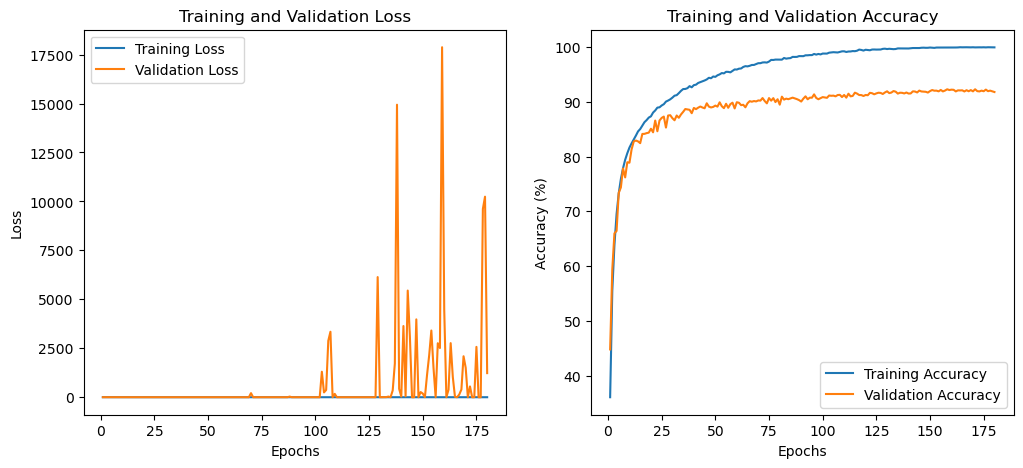

CPU times: user 1h 7min 7s, sys: 12min 29s, total: 1h 19min 37s
Wall time: 2h 23min 45s


In [53]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = MobileNetV2()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

mobilenetv2_0_0_1_Adam_train_losses = []
mobilenetv2_0_0_1_Adam_val_losses = []
mobilenetv2_0_0_1_Adam_train_accuracies = []
mobilenetv2_0_0_1_Adam_val_accuracies = []

for epoch in range(start_epoch, 180):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    mobilenetv2_0_0_1_Adam_train_losses.append(train_loss)
    mobilenetv2_0_0_1_Adam_val_losses.append(val_loss)
    mobilenetv2_0_0_1_Adam_train_accuracies.append(train_accuracy)
    mobilenetv2_0_0_1_Adam_val_accuracies.append(val_accuracy)

state_mobilenetv2_0_0_1_Adam,  acc_mobilenetv2_0_0_1_Adam = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_mobilenetv2_0_0_1_Adam)

plot_metrics(mobilenetv2_0_0_1_Adam_train_losses, mobilenetv2_0_0_1_Adam_val_losses, 
             mobilenetv2_0_0_1_Adam_train_accuracies, mobilenetv2_0_0_1_Adam_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [54]:
file_path_mobilenetv2_0_0_1_Adam = "./result_and_model/mobilenetv2_0_0_1_Adam_results.pkl"
model_state_path_mobilenetv2_0_0_1_Adam = "./result_and_model/mobilenetv2_0_0_1_Adam_model.pth"

with open(file_path_mobilenetv2_0_0_1_Adam, "wb") as f:
    pickle.dump({
        "train_losses": mobilenetv2_0_0_1_Adam_train_losses,
        "val_losses": mobilenetv2_0_0_1_Adam_val_losses,
        "train_accuracies": mobilenetv2_0_0_1_Adam_train_accuracies,
        "val_accuracies": mobilenetv2_0_0_1_Adam_val_accuracies,
        "best_accuracy": acc_mobilenetv2_0_0_1_Adam
    }, f)


torch.save(state_mobilenetv2_0_0_1_Adam, model_state_path_mobilenetv2_0_0_1_Adam)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.1, Optimizer = RMSprop

Epoch: 0


Validation Epoch 0: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=10.1, Loss=2.48]



Epoch: 1


Validation Epoch 1: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=10.2, Loss=2.47]



Epoch: 2


Validation Epoch 2: 100%|███| 79/79 [00:14<00:00,  5.58it/s, Acc=17.6, Loss=1.8]



Epoch: 3


Validation Epoch 3: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=9.73, Loss=2.52]



Epoch: 4


Validation Epoch 4: 100%|███| 79/79 [00:14<00:00,  5.58it/s, Acc=9.98, Loss=4.9]



Epoch: 5


Validation Epoch 5: 100%|███| 79/79 [00:14<00:00,  5.58it/s, Acc=12.1, Loss=229]



Epoch: 6


Validation Epoch 6: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=9.98, Loss=2.88]



Epoch: 7


Validation Epoch 7: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=11.5, Loss=5.38]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=10.2, Loss=66.8]



Epoch: 9


Validation Epoch 9: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=7.32, Loss=2.47]



Epoch: 10


Validation Epoch 10: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=9.99, Loss=511]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=16.8, Loss=1.98
Validation Epoch 11: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=12.4]



Epoch: 12


 Training Epoch 12: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=16.9, Loss=1.93
Validation Epoch 12: 100%|██| 79/79 [00:14<00:00,  5.49it/s, Acc=9.98, Loss=571]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=17.6, Loss=2.12
Validation Epoch 13: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.63, Loss=3.07]



Epoch: 14


Validation Epoch 14: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.98, Loss=14.2]



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=10.1, Loss=2.31
Validation Epoch 15: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=10.2, Loss=2.28]



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=9.94, Loss=2.33
Validation Epoch 16: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=10.1, Loss=3.86e



Epoch: 17


Validation Epoch 17: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=10.3, Loss=2.3]



Epoch: 18


Validation Epoch 18: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=10.2, Loss=2.3]



Epoch: 19


Validation Epoch 19: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.73, Loss=2.27]



Epoch: 20


 Training Epoch 20: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=10.2, Loss=2.32
Validation Epoch 20: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=10.2, Loss=2.31]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=10.1, Loss=2.33
Validation Epoch 21: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=10.2, Loss=2.36]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=9.92, Loss=2.31
Validation Epoch 22: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.67, Loss=2.29]



Epoch: 23


Validation Epoch 23: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=10.2, Loss=2.32]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=10.2, Loss=2.32
Validation Epoch 24: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.63, Loss=2.34]



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.93, Loss=2.29
Validation Epoch 25: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=2.26]



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.91, Loss=2.31
Validation Epoch 26: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.63, Loss=2.31]



Epoch: 27


Validation Epoch 27: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=2.27]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.84, Loss=2.32
Validation Epoch 28: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.1, Loss=2.34]



Epoch: 29


Validation Epoch 29: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=9.63, Loss=2.29]



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.1, Loss=2.33
Validation Epoch 30: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.2, Loss=2.36]



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.88, Loss=2.31
Validation Epoch 31: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=9.98, Loss=2.33]



Epoch: 32


Validation Epoch 32: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.63, Loss=2.34]



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.2, Loss=2.31
Validation Epoch 33: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.73, Loss=2.31]



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.2, Loss=2.32
Validation Epoch 34: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.2, Loss=2.34]



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.99, Loss=2.32
Validation Epoch 35: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=2.25]



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.2, Loss=2.31
Validation Epoch 36: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.98, Loss=2.29]



Epoch: 37


Validation Epoch 37: 100%|██| 79/79 [00:14<00:00,  5.52it/s, Acc=9.63, Loss=2.3]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.98, Loss=2.31
Validation Epoch 38: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.63, Loss=2.29]



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=10.1, Loss=2.29
Validation Epoch 39: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.98, Loss=2.34]



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.1, Loss=2.31
Validation Epoch 40: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=10.3, Loss=2.32]



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.72, Loss=2.34
Validation Epoch 41: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=10.2, Loss=2.37]



Epoch: 42


Validation Epoch 42: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=9.98, Loss=2.33]



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.95, Loss=2.29
Validation Epoch 43: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.63, Loss=2.33]



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=10.2, Loss=2.32
Validation Epoch 44: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.3, Loss=2.27]



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.87, Loss=2.31
Validation Epoch 45: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=10.3, Loss=2.29]



Epoch: 46


Validation Epoch 46: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.63, Loss=2.36]



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.98, Loss=2.31
Validation Epoch 47: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=10.1, Loss=2.28]



Epoch: 48


Validation Epoch 48: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=10.2, Loss=2.33]



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.2, Loss=2.31
Validation Epoch 49: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=2.31]



Epoch: 50


Validation Epoch 50: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.67, Loss=2.33]



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.98, Loss=2.32
Validation Epoch 51: 100%|██| 79/79 [00:14<00:00,  5.50it/s, Acc=9.67, Loss=2.3]



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.84, Loss=2.31
Validation Epoch 52: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.73, Loss=2.31]



Epoch: 53


Validation Epoch 53: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.1, Loss=2.27]



Epoch: 54


Validation Epoch 54: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=10.3, Loss=2.3]



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.96, Loss=2.29
Validation Epoch 55: 100%|██| 79/79 [00:14<00:00,  5.62it/s, Acc=10.2, Loss=2.3]



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.87, Loss=2.29
Validation Epoch 56: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=9.63, Loss=2.31]



Epoch: 57


Validation Epoch 57: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=10.2, Loss=2.36]



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.85, Loss=2.32
Validation Epoch 58: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=2.3]



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.1, Loss=2.31
Validation Epoch 59: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.63, Loss=2.27]



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.84, Loss=2.33
Validation Epoch 60: 100%|██| 79/79 [00:14<00:00,  5.51it/s, Acc=9.73, Loss=2.3]



Epoch: 61


Validation Epoch 61: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.73, Loss=2.26]



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.31
Validation Epoch 62: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.98, Loss=2.34]



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.1, Loss=2.31
Validation Epoch 63: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.99, Loss=2.29]



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.91, Loss=2.32
Validation Epoch 64: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=9.63, Loss=2.33]



Epoch: 65


 Training Epoch 65: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.1, Loss=2.32
Validation Epoch 65: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=9.63, Loss=2.33]



Epoch: 66


Validation Epoch 66: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.1, Loss=2.35]



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.97, Loss=2.31
Validation Epoch 67: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=2.3]



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=10.1, Loss=2.31
Validation Epoch 68: 100%|██| 79/79 [00:14<00:00,  5.58it/s, Acc=9.67, Loss=2.3]



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=10.1, Loss=2.32
Validation Epoch 69: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=9.63, Loss=2.32]



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.32
Validation Epoch 70: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=9.98, Loss=2.3]



Epoch: 71


Validation Epoch 71: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=9.99, Loss=2.3]



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.85, Loss=2.31
Validation Epoch 72: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.63, Loss=2.28]



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.31
Validation Epoch 73: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=9.67, Loss=2.3]



Epoch: 74


Validation Epoch 74: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.98, Loss=2.34]



Epoch: 75


Validation Epoch 75: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=10.2, Loss=2.29]



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.86, Loss=2.34
Validation Epoch 76: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.63, Loss=2.34]



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.1, Loss=2.32
Validation Epoch 77: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=10.2, Loss=2.29]



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.89, Loss=2.31
Validation Epoch 78: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=9.73, Loss=2.3]



Epoch: 79


Validation Epoch 79: 100%|██| 79/79 [00:14<00:00,  5.52it/s, Acc=9.99, Loss=2.3]



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.96, Loss=2.31
Validation Epoch 80: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=10.1, Loss=2.28]



Epoch: 81


Validation Epoch 81: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=10.2, Loss=2.31]



Epoch: 82


Validation Epoch 82: 100%|██| 79/79 [00:14<00:00,  5.46it/s, Acc=9.73, Loss=2.3]



Epoch: 83


Validation Epoch 83: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=9.67, Loss=2.32]



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.3, Loss=2.29
Validation Epoch 84: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=2.28]



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=9.66, Loss=2.31
Validation Epoch 85: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=9.63, Loss=2.26]



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.97, Loss=2.31
Validation Epoch 86: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.67, Loss=2.31]



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.2, Loss=2.28
Validation Epoch 87: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.2, Loss=2.33]



Epoch: 88


 Training Epoch 88: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.89, Loss=2.31
Validation Epoch 88: 100%|██| 79/79 [00:14<00:00,  5.48it/s, Acc=10.1, Loss=2.3]



Epoch: 89


Validation Epoch 89: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.2, Loss=2.33]



Epoch: 90


 Training Epoch 90: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.31
Validation Epoch 90: 100%|██| 79/79 [00:14<00:00,  5.49it/s, Acc=10.1, Loss=2.3]



Epoch: 91


Validation Epoch 91: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=9.67, Loss=2.3]



Epoch: 92


 Training Epoch 92: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.78, Loss=2.31
Validation Epoch 92: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.98, Loss=2.31]



Epoch: 93


 Training Epoch 93: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=10.2, Loss=2.31
Validation Epoch 93: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=9.63, Loss=2.3]



Epoch: 94


Validation Epoch 94: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.2, Loss=2.31]



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.99, Loss=2.31
Validation Epoch 95: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.1, Loss=2.27]



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.81, Loss=2.31
Validation Epoch 96: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.98, Loss=2.31]



Epoch: 97


 Training Epoch 97: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.69, Loss=2.32
Validation Epoch 97: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.98, Loss=2.35]



Epoch: 98


 Training Epoch 98: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.31
Validation Epoch 98: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=9.73, Loss=2.3]



Epoch: 99


Validation Epoch 99: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=9.73, Loss=2.31]



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.74, Loss=2.3
Validation Epoch 100: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=9.63, Loss=2.29



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.92, Loss=2.3
Validation Epoch 101: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=10.1, Loss=2.3]



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.91, Loss=2.3
Validation Epoch 102: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.99, Loss=2.28



Epoch: 103


 Training Epoch 103: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.3
Validation Epoch 103: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.2, Loss=2.31



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.92, Loss=2.3
Validation Epoch 104: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.73, Loss=2.3]



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.84, Loss=2.3
Validation Epoch 105: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.63, Loss=2.3]



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.87, Loss=2.3
Validation Epoch 106: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=10.3, Loss=2.32



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.87, Loss=2.3
Validation Epoch 107: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.63, Loss=2.28



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.1, Loss=2.3
Validation Epoch 108: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.63, Loss=2.3]



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.93, Loss=2.2
Validation Epoch 109: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.1, Loss=2.27



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.3
Validation Epoch 110: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.67, Loss=2.3]



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.3
Validation Epoch 111: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=9.73, Loss=2.3]



Epoch: 112


 Training Epoch 112: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.81, Loss=2.3
Validation Epoch 112: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.99, Loss=2.3]



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.95, Loss=2.3
Validation Epoch 113: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.67, Loss=2.31



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.81, Loss=2.3
Validation Epoch 114: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=10.1, Loss=2.31



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.84, Loss=2.3
Validation Epoch 115: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=10.1, Loss=2.31



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=10.2, Loss=2.3
Validation Epoch 116: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.98, Loss=2.31



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.98, Loss=2.3
Validation Epoch 117: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.1, Loss=2.28



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.2, Loss=2.2
Validation Epoch 118: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.67, Loss=2.32



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.98, Loss=2.2
Validation Epoch 119: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=9.98, Loss=2.3]



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.2, Loss=2.3
Validation Epoch 120: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.3, Loss=2.3]



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.71, Loss=2.3
Validation Epoch 121: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=10.1, Loss=2.3]



Epoch: 122


 Training Epoch 122: 100%|█| 313/313 [00:32<00:00,  9.54it/s, Acc=9.63, Loss=2.3
Validation Epoch 122: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=10.3, Loss=2.3]



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.3
Validation Epoch 123: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=9.98, Loss=2.32



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.91, Loss=2.3
Validation Epoch 124: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=10.2, Loss=2.3]



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.93, Loss=2.3
Validation Epoch 125: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.63, Loss=2.31



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.92, Loss=2.3
Validation Epoch 126: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.99, Loss=2.33



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.94, Loss=2.3
Validation Epoch 127: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=9.63, Loss=2.31



Epoch: 128


 Training Epoch 128: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.69, Loss=2.3
Validation Epoch 128: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=10.3, Loss=2.31



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.84, Loss=2.3
Validation Epoch 129: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=9.73, Loss=2.31



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.96, Loss=2.3
Validation Epoch 130: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=10.1, Loss=2.28



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.3
Validation Epoch 131: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=9.63, Loss=2.29



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.1, Loss=2.3
Validation Epoch 132: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=10.2, Loss=2.31



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.91, Loss=2.2
Validation Epoch 133: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=10.2, Loss=2.31



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.93, Loss=2.3
Validation Epoch 134: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=9.67, Loss=2.29



Epoch: 135


 Training Epoch 135: 100%|██| 313/313 [00:32<00:00,  9.52it/s, Acc=10, Loss=2.3]
Validation Epoch 135: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.67, Loss=2.31



Epoch: 136


 Training Epoch 136: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.96, Loss=2.3
Validation Epoch 136: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.98, Loss=2.31



Epoch: 137


Validation Epoch 137: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=9.98, Loss=2.3]



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.88, Loss=2.3
Validation Epoch 138: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=10.2, Loss=2.31



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.3
Validation Epoch 139: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=10.1, Loss=2.3]



Epoch: 140


 Training Epoch 140: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.89, Loss=2.3
Validation Epoch 140: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=10.2, Loss=2.31



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.74, Loss=2.3
Validation Epoch 141: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.3, Loss=2.29



Epoch: 142


 Training Epoch 142: 100%|██| 313/313 [00:32<00:00,  9.51it/s, Acc=10, Loss=2.3]
Validation Epoch 142: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.2, Loss=2.29



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.76, Loss=2.3
Validation Epoch 143: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.2, Loss=2.3]



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.95, Loss=2.3
Validation Epoch 144: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=10.3, Loss=2.31



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.65, Loss=2.3
Validation Epoch 145: 100%|█| 79/79 [00:14<00:00,  5.55it/s, Acc=10.1, Loss=2.31



Epoch: 146


 Training Epoch 146: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.77, Loss=2.3
Validation Epoch 146: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.67, Loss=2.3]



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.81, Loss=2.3
Validation Epoch 147: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.99, Loss=2.31



Epoch: 148


 Training Epoch 148: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.82, Loss=2.3
Validation Epoch 148: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=10.2, Loss=2.31



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.95, Loss=2.3
Validation Epoch 149: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.1, Loss=2.3]



Epoch: 150


 Training Epoch 150: 100%|█| 313/313 [00:32<00:00,  9.53it/s, Acc=9.97, Loss=2.3
Validation Epoch 150: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.67, Loss=2.3]



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.1, Loss=2.3
Validation Epoch 151: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=10.2, Loss=2.31



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.1, Loss=2.3
Validation Epoch 152: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=9.73, Loss=2.3]



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.69, Loss=2.3
Validation Epoch 153: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.67, Loss=2.3]



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.88, Loss=2.3
Validation Epoch 154: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.99, Loss=2.3]



Epoch: 155


 Training Epoch 155: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.99, Loss=2.3
Validation Epoch 155: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.67, Loss=2.3]



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.72, Loss=2.3
Validation Epoch 156: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.98, Loss=2.32



Epoch: 157


 Training Epoch 157: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.95, Loss=2.3
Validation Epoch 157: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=9.98, Loss=2.3]



Epoch: 158


 Training Epoch 158: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.87, Loss=2.3
Validation Epoch 158: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=9.98, Loss=2.31



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:32<00:00,  9.49it/s, Acc=9.74, Loss=2.3
Validation Epoch 159: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.63, Loss=2.3]



Epoch: 160


 Training Epoch 160: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.93, Loss=2.3
Validation Epoch 160: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=9.67, Loss=2.31



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.93, Loss=2.3
Validation Epoch 161: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.73, Loss=2.3]



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.66, Loss=2.3
Validation Epoch 162: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=9.99, Loss=2.3]



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.79, Loss=2.3
Validation Epoch 163: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.99, Loss=2.3]



Epoch: 164


 Training Epoch 164: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=10.1, Loss=2.3
Validation Epoch 164: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.73, Loss=2.3]



Epoch: 165


 Training Epoch 165: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.86, Loss=2.3
Validation Epoch 165: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.63, Loss=2.3]



Epoch: 166


Validation Epoch 166: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.63, Loss=2.3]



Epoch: 167


 Training Epoch 167: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.87, Loss=2.3
Validation Epoch 167: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.67, Loss=2.3]



Epoch: 168


 Training Epoch 168: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.83, Loss=2.3
Validation Epoch 168: 100%|█| 79/79 [00:14<00:00,  5.54it/s, Acc=9.99, Loss=2.3]



Epoch: 169


 Training Epoch 169: 100%|█| 313/313 [00:33<00:00,  9.48it/s, Acc=9.92, Loss=2.3
Validation Epoch 169: 100%|█| 79/79 [00:14<00:00,  5.47it/s, Acc=9.67, Loss=2.3]



Epoch: 170


 Training Epoch 170: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.99, Loss=2.3
Validation Epoch 170: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.67, Loss=2.3]



Epoch: 171


 Training Epoch 171: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.89, Loss=2.3
Validation Epoch 171: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.67, Loss=2.3]



Epoch: 172


 Training Epoch 172: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.88, Loss=2.3
Validation Epoch 172: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.63, Loss=2.3]



Epoch: 173


 Training Epoch 173: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.97, Loss=2.3
Validation Epoch 173: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=9.63, Loss=2.3]



Epoch: 174


Validation Epoch 174: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.63, Loss=2.3]



Epoch: 175


 Training Epoch 175: 100%|█| 313/313 [00:32<00:00,  9.50it/s, Acc=9.97, Loss=2.3
Validation Epoch 175: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=9.63, Loss=2.3]



Epoch: 176


 Training Epoch 176: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=9.98, Loss=2.3
Validation Epoch 176: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=9.63, Loss=2.3]



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=9.96, Loss=2.3
Validation Epoch 177: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.63, Loss=2.3]



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:32<00:00,  9.52it/s, Acc=10.1, Loss=2.3
Validation Epoch 178: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=9.63, Loss=2.3]



Epoch: 179


 Training Epoch 179: 100%|█| 313/313 [00:32<00:00,  9.51it/s, Acc=10.1, Loss=2.3
Validation Epoch 179: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=9.63, Loss=2.3]

Validation Accuracy:  17.57


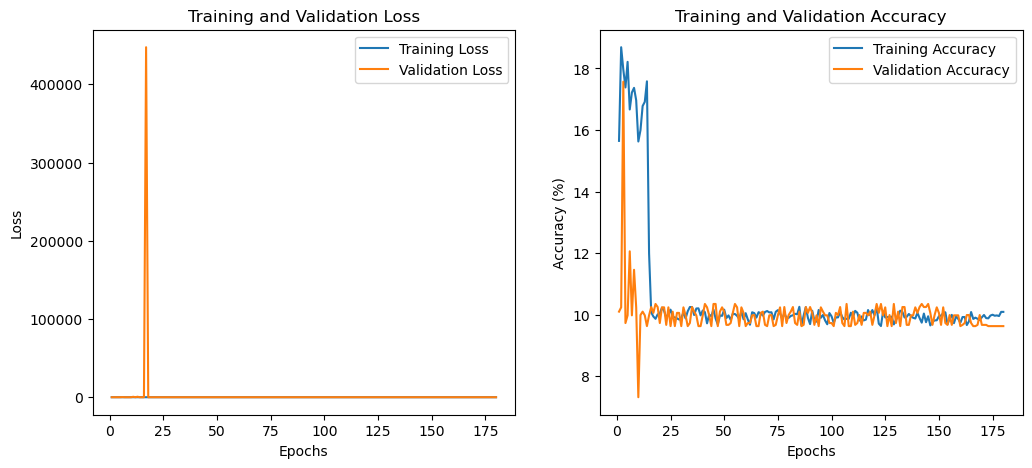

CPU times: user 1h 3min 5s, sys: 11min 54s, total: 1h 14min 59s
Wall time: 2h 21min 14s


In [55]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = MobileNetV2()
net.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.1, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)
print(f"\nTesting: Learning Rate = {0.1}, Optimizer = {type(optimizer).__name__}")

mobilenetv2_0_1_RMSprop_train_losses = []
mobilenetv2_0_1_RMSprop_val_losses = []
mobilenetv2_0_1_RMSprop_train_accuracies = []
mobilenetv2_0_1_RMSprop_val_accuracies = []

for epoch in range(start_epoch, 180):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    mobilenetv2_0_1_RMSprop_train_losses.append(train_loss)
    mobilenetv2_0_1_RMSprop_val_losses.append(val_loss)
    mobilenetv2_0_1_RMSprop_train_accuracies.append(train_accuracy)
    mobilenetv2_0_1_RMSprop_val_accuracies.append(val_accuracy)

state_mobilenetv2_0_1_RMSprop,  acc_mobilenetv2_0_1_RMSprop = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_mobilenetv2_0_1_RMSprop)

plot_metrics(mobilenetv2_0_1_RMSprop_train_losses, mobilenetv2_0_1_RMSprop_val_losses, 
             mobilenetv2_0_1_RMSprop_train_accuracies, mobilenetv2_0_1_RMSprop_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [56]:
file_path_mobilenetv2_0_1_RMSprop = "./result_and_model/mobilenetv2_0_1_RMSprop_results.pkl"
model_state_path_mobilenetv2_0_1_RMSprop = "./result_and_model/mobilenetv2_0_1_RMSprop_model.pth"

with open(file_path_mobilenetv2_0_1_RMSprop, "wb") as f:
    pickle.dump({
        "train_losses": mobilenetv2_0_1_RMSprop_train_losses,
        "val_losses": mobilenetv2_0_1_RMSprop_val_losses,
        "train_accuracies": mobilenetv2_0_1_RMSprop_train_accuracies,
        "val_accuracies": mobilenetv2_0_1_RMSprop_val_accuracies,
        "best_accuracy": acc_mobilenetv2_0_1_RMSprop
    }, f)


torch.save(state_mobilenetv2_0_1_RMSprop, model_state_path_mobilenetv2_0_1_RMSprop)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.



Testing: Learning Rate = 0.01, Optimizer = RMSprop

Epoch: 0


Validation Epoch 0: 100%|████| 79/79 [00:14<00:00,  5.52it/s, Acc=19, Loss=2.41]



Epoch: 1


Validation Epoch 1: 100%|████| 79/79 [00:14<00:00,  5.60it/s, Acc=33, Loss=2.04]



Epoch: 2


Validation Epoch 2: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=28.2, Loss=1.73]



Epoch: 3


Validation Epoch 3: 100%|███| 79/79 [00:14<00:00,  5.59it/s, Acc=50.4, Loss=1.3]



Epoch: 4


Validation Epoch 4: 100%|█| 79/79 [00:14<00:00,  5.33it/s, Acc=51.3, Loss=0.915]



Epoch: 5


Validation Epoch 5: 100%|██| 79/79 [00:14<00:00,  5.36it/s, Acc=50.4, Loss=1.47]



Epoch: 6


Validation Epoch 6: 100%|█| 79/79 [00:14<00:00,  5.45it/s, Acc=55.4, Loss=0.488]



Epoch: 7


Validation Epoch 7: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=55.3, Loss=0.837]



Epoch: 8


Validation Epoch 8: 100%|██| 79/79 [00:14<00:00,  5.55it/s, Acc=61.4, Loss=1.28]



Epoch: 9


 Training Epoch 9: 100%|█| 313/313 [00:35<00:00,  8.78it/s, Acc=68.5, Loss=0.746
Validation Epoch 9: 100%|██| 79/79 [00:14<00:00,  5.56it/s, Acc=49.4, Loss=1.06]



Epoch: 10


 Training Epoch 10: 100%|█| 313/313 [00:34<00:00,  8.98it/s, Acc=70.2, Loss=0.89
Validation Epoch 10: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=47.6, Loss=1.36]



Epoch: 11


 Training Epoch 11: 100%|█| 313/313 [00:34<00:00,  9.10it/s, Acc=71, Loss=0.798]
Validation Epoch 11: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=55.4, Loss=0.958



Epoch: 12


Validation Epoch 12: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=58.8, Loss=1.03]



Epoch: 13


 Training Epoch 13: 100%|█| 313/313 [00:33<00:00,  9.23it/s, Acc=72.7, Loss=1.08
Validation Epoch 13: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=49.2, Loss=2.6]



Epoch: 14


 Training Epoch 14: 100%|█| 313/313 [00:33<00:00,  9.28it/s, Acc=73.3, Loss=0.58
Validation Epoch 14: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=60.2, Loss=0.946



Epoch: 15


 Training Epoch 15: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=73.9, Loss=0.80
Validation Epoch 15: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=52.3, Loss=1.47]



Epoch: 16


 Training Epoch 16: 100%|█| 313/313 [00:33<00:00,  9.29it/s, Acc=74.4, Loss=0.71
Validation Epoch 16: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=63.8, Loss=0.402



Epoch: 17


 Training Epoch 17: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=74.5, Loss=0.94
Validation Epoch 17: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=58.1, Loss=1.02]



Epoch: 18


 Training Epoch 18: 100%|█| 313/313 [00:33<00:00,  9.22it/s, Acc=75.2, Loss=0.80
Validation Epoch 18: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=66.3, Loss=0.556



Epoch: 19


 Training Epoch 19: 100%|█| 313/313 [00:34<00:00,  9.15it/s, Acc=75.5, Loss=0.55
Validation Epoch 19: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=68.2, Loss=0.491



Epoch: 20


Validation Epoch 20: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=69.4, Loss=1.24]



Epoch: 21


 Training Epoch 21: 100%|█| 313/313 [00:34<00:00,  9.14it/s, Acc=75.8, Loss=0.87
Validation Epoch 21: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=61.2, Loss=1.15]



Epoch: 22


 Training Epoch 22: 100%|█| 313/313 [00:33<00:00,  9.21it/s, Acc=76.4, Loss=1.03
Validation Epoch 22: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=61.7, Loss=0.562



Epoch: 23


 Training Epoch 23: 100%|█| 313/313 [00:33<00:00,  9.26it/s, Acc=76.5, Loss=0.75
Validation Epoch 23: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=64.9, Loss=0.81]



Epoch: 24


 Training Epoch 24: 100%|█| 313/313 [00:33<00:00,  9.33it/s, Acc=76.9, Loss=0.64
Validation Epoch 24: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=58.7, Loss=0.597



Epoch: 25


 Training Epoch 25: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=77.2, Loss=0.39
Validation Epoch 25: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=63.7, Loss=0.825



Epoch: 26


 Training Epoch 26: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=77, Loss=0.699]
Validation Epoch 26: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=69.5, Loss=0.277



Epoch: 27


 Training Epoch 27: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=77.3, Loss=0.59
Validation Epoch 27: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=57.2, Loss=0.54]



Epoch: 28


 Training Epoch 28: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=77.9, Loss=0.56
Validation Epoch 28: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=68, Loss=0.425]



Epoch: 29


 Training Epoch 29: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=77.6, Loss=0.66
Validation Epoch 29: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=66.5, Loss=0.573



Epoch: 30


 Training Epoch 30: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=77.9, Loss=0.49
Validation Epoch 30: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=73.3, Loss=0.649



Epoch: 31


 Training Epoch 31: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=78, Loss=0.466]
Validation Epoch 31: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=63.5, Loss=0.691



Epoch: 32


 Training Epoch 32: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=78.2, Loss=0.62
Validation Epoch 32: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=69.5, Loss=0.608



Epoch: 33


 Training Epoch 33: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=78.6, Loss=0.61
Validation Epoch 33: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=65.4, Loss=0.7]



Epoch: 34


 Training Epoch 34: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=78.7, Loss=0.82
Validation Epoch 34: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=73.4, Loss=0.575



Epoch: 35


 Training Epoch 35: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=79, Loss=0.524]
Validation Epoch 35: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=71.7, Loss=0.319



Epoch: 36


 Training Epoch 36: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=79.2, Loss=0.63
Validation Epoch 36: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=67.2, Loss=0.554



Epoch: 37


Validation Epoch 37: 100%|██| 79/79 [00:14<00:00,  5.53it/s, Acc=64, Loss=0.213]



Epoch: 38


 Training Epoch 38: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=79.2, Loss=0.55
Validation Epoch 38: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=69.9, Loss=0.966



Epoch: 39


 Training Epoch 39: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=79.3, Loss=0.62
Validation Epoch 39: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=72.5, Loss=0.644



Epoch: 40


 Training Epoch 40: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=79.2, Loss=0.59
Validation Epoch 40: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=70.5, Loss=0.443



Epoch: 41


 Training Epoch 41: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=79.5, Loss=0.73
Validation Epoch 41: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=68.4, Loss=0.894



Epoch: 42


 Training Epoch 42: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=79.9, Loss=0.65
Validation Epoch 42: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=59.9, Loss=0.957



Epoch: 43


 Training Epoch 43: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=79.9, Loss=0.32
Validation Epoch 43: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=75.1, Loss=0.411



Epoch: 44


 Training Epoch 44: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=79.7, Loss=0.57
Validation Epoch 44: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=74.3, Loss=0.637



Epoch: 45


 Training Epoch 45: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=80.1, Loss=0.47
Validation Epoch 45: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=71.1, Loss=0.702



Epoch: 46


 Training Epoch 46: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=80.1, Loss=0.54
Validation Epoch 46: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=69.2, Loss=1.05]



Epoch: 47


 Training Epoch 47: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=80.3, Loss=0.50
Validation Epoch 47: 100%|██| 79/79 [00:14<00:00,  5.53it/s, Acc=74, Loss=0.352]



Epoch: 48


 Training Epoch 48: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=80.3, Loss=0.58
Validation Epoch 48: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=75.2, Loss=0.899



Epoch: 49


 Training Epoch 49: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=80.5, Loss=0.54
Validation Epoch 49: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=70.5, Loss=0.583



Epoch: 50


 Training Epoch 50: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=80.4, Loss=0.64
Validation Epoch 50: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=70.8, Loss=0.695



Epoch: 51


 Training Epoch 51: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=80.5, Loss=0.32
Validation Epoch 51: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=76.2, Loss=0.323



Epoch: 52


 Training Epoch 52: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=80.8, Loss=0.53
Validation Epoch 52: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=77, Loss=0.44]



Epoch: 53


 Training Epoch 53: 100%|██| 313/313 [00:33<00:00,  9.45it/s, Acc=81, Loss=0.57]
Validation Epoch 53: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=72.7, Loss=0.373



Epoch: 54


 Training Epoch 54: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=81, Loss=0.703]
Validation Epoch 54: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=61.5, Loss=0.684



Epoch: 55


 Training Epoch 55: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81, Loss=0.564]
Validation Epoch 55: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=74.9, Loss=0.281



Epoch: 56


 Training Epoch 56: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.1, Loss=0.74
Validation Epoch 56: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=66.5, Loss=1.13]



Epoch: 57


 Training Epoch 57: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.1, Loss=0.53
Validation Epoch 57: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=73.7, Loss=0.47]



Epoch: 58


 Training Epoch 58: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=81.3, Loss=0.56
Validation Epoch 58: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=76.6, Loss=0.496



Epoch: 59


 Training Epoch 59: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=81.5, Loss=0.71
Validation Epoch 59: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=70.9, Loss=0.723



Epoch: 60


 Training Epoch 60: 100%|█| 313/313 [00:33<00:00,  9.37it/s, Acc=81.5, Loss=0.38
Validation Epoch 60: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=77.8, Loss=0.959



Epoch: 61


 Training Epoch 61: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=81.4, Loss=0.64
Validation Epoch 61: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=74.9, Loss=0.205



Epoch: 62


 Training Epoch 62: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=81.8, Loss=0.47
Validation Epoch 62: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=63.1, Loss=1.1]



Epoch: 63


 Training Epoch 63: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=81.7, Loss=0.48
Validation Epoch 63: 100%|██| 79/79 [00:14<00:00,  5.59it/s, Acc=78, Loss=0.327]



Epoch: 64


 Training Epoch 64: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=81.8, Loss=0.51
Validation Epoch 64: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=71.7, Loss=0.431



Epoch: 65


Validation Epoch 65: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.6, Loss=0.38]



Epoch: 66


 Training Epoch 66: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=82, Loss=0.761]
Validation Epoch 66: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=71.9, Loss=0.723



Epoch: 67


 Training Epoch 67: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82, Loss=0.671]
Validation Epoch 67: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=72.5, Loss=0.421



Epoch: 68


 Training Epoch 68: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82, Loss=0.383]
Validation Epoch 68: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=75.8, Loss=0.455



Epoch: 69


 Training Epoch 69: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.6, Loss=0.43
Validation Epoch 69: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=68.4, Loss=1.13]



Epoch: 70


 Training Epoch 70: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.2, Loss=0.48
Validation Epoch 70: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=76.9, Loss=0.736



Epoch: 71


 Training Epoch 71: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.5, Loss=0.54
Validation Epoch 71: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.5, Loss=0.431



Epoch: 72


 Training Epoch 72: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.5, Loss=0.68
Validation Epoch 72: 100%|██| 79/79 [00:14<00:00,  5.52it/s, Acc=65, Loss=0.685]



Epoch: 73


 Training Epoch 73: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.8, Loss=0.48
Validation Epoch 73: 100%|██| 79/79 [00:14<00:00,  5.62it/s, Acc=75, Loss=0.572]



Epoch: 74


 Training Epoch 74: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=82.7, Loss=0.52
Validation Epoch 74: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=77.2, Loss=0.502



Epoch: 75


 Training Epoch 75: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.8, Loss=0.50
Validation Epoch 75: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=74.7, Loss=0.598



Epoch: 76


 Training Epoch 76: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=82.7, Loss=0.52
Validation Epoch 76: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=68.2, Loss=0.963



Epoch: 77


 Training Epoch 77: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=83.1, Loss=1.08
Validation Epoch 77: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=73.5, Loss=0.551



Epoch: 78


 Training Epoch 78: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.1, Loss=0.50
Validation Epoch 78: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=75.7, Loss=0.561



Epoch: 79


 Training Epoch 79: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.2, Loss=0.69
Validation Epoch 79: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=73.9, Loss=0.614



Epoch: 80


 Training Epoch 80: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=83.1, Loss=0.51
Validation Epoch 80: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=78.5, Loss=0.257



Epoch: 81


 Training Epoch 81: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.3, Loss=0.44
Validation Epoch 81: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=77.4, Loss=0.517



Epoch: 82


 Training Epoch 82: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.4, Loss=0.47
Validation Epoch 82: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=69.1, Loss=0.435



Epoch: 83


 Training Epoch 83: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=83.6, Loss=0.50
Validation Epoch 83: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=78.9, Loss=0.437



Epoch: 84


 Training Epoch 84: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.7, Loss=0.48
Validation Epoch 84: 100%|█| 79/79 [00:14<00:00,  5.62it/s, Acc=78.1, Loss=0.338



Epoch: 85


 Training Epoch 85: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=83.7, Loss=0.43
Validation Epoch 85: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=76.2, Loss=0.589



Epoch: 86


 Training Epoch 86: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=83.8, Loss=0.42
Validation Epoch 86: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=79.1, Loss=0.501



Epoch: 87


 Training Epoch 87: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.1, Loss=0.57
Validation Epoch 87: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=70.3, Loss=0.708



Epoch: 88


Validation Epoch 88: 100%|███| 79/79 [00:14<00:00,  5.60it/s, Acc=80, Loss=0.21]



Epoch: 89


 Training Epoch 89: 100%|█| 313/313 [00:33<00:00,  9.47it/s, Acc=84.2, Loss=0.53
Validation Epoch 89: 100%|██| 79/79 [00:14<00:00,  5.61it/s, Acc=76, Loss=0.346]



Epoch: 90


 Training Epoch 90: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84, Loss=0.432]
Validation Epoch 90: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=79.3, Loss=0.248



Epoch: 91


 Training Epoch 91: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.1, Loss=0.46
Validation Epoch 91: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=76.2, Loss=0.315



Epoch: 92


 Training Epoch 92: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.1, Loss=0.52
Validation Epoch 92: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=79.3, Loss=0.37]



Epoch: 93


 Training Epoch 93: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.3, Loss=0.65
Validation Epoch 93: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=78.2, Loss=0.444



Epoch: 94


 Training Epoch 94: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.7, Loss=0.46
Validation Epoch 94: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.3, Loss=0.461



Epoch: 95


 Training Epoch 95: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=84.4, Loss=0.27
Validation Epoch 95: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=81.5, Loss=0.173



Epoch: 96


 Training Epoch 96: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=84.6, Loss=0.42
Validation Epoch 96: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=81.3, Loss=0.49]



Epoch: 97


 Training Epoch 97: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.6, Loss=0.32
Validation Epoch 97: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=77.9, Loss=0.678



Epoch: 98


 Training Epoch 98: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=85, Loss=0.425]
Validation Epoch 98: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=80.1, Loss=0.313



Epoch: 99


 Training Epoch 99: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=84.7, Loss=0.46
Validation Epoch 99: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=80.7, Loss=0.288



Epoch: 100


 Training Epoch 100: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85, Loss=0.291
Validation Epoch 100: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=81, Loss=0.534]



Epoch: 101


 Training Epoch 101: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.1, Loss=0.2
Validation Epoch 101: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=79.8, Loss=0.19



Epoch: 102


 Training Epoch 102: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=85.4, Loss=0.3
Validation Epoch 102: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.3, Loss=0.50



Epoch: 103


 Training Epoch 103: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.2, Loss=0.3
Validation Epoch 103: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=80.7, Loss=0.21



Epoch: 104


 Training Epoch 104: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.4, Loss=0.4
Validation Epoch 104: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=80.1, Loss=0.30



Epoch: 105


 Training Epoch 105: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=85.6, Loss=0.5
Validation Epoch 105: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=79.8, Loss=0.33



Epoch: 106


 Training Epoch 106: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.4, Loss=0.5
Validation Epoch 106: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=79.3, Loss=0.39



Epoch: 107


 Training Epoch 107: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.8, Loss=0.5
Validation Epoch 107: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=81.4, Loss=0.44



Epoch: 108


 Training Epoch 108: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.7, Loss=0.4
Validation Epoch 108: 100%|█| 79/79 [00:14<00:00,  5.53it/s, Acc=82.3, Loss=0.19



Epoch: 109


 Training Epoch 109: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=85.8, Loss=0.2
Validation Epoch 109: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=81.1, Loss=0.27



Epoch: 110


 Training Epoch 110: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=85.9, Loss=0.2
Validation Epoch 110: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=83.7, Loss=0.41



Epoch: 111


 Training Epoch 111: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=86.2, Loss=0.5
Validation Epoch 111: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=82.8, Loss=0.22



Epoch: 112


 Training Epoch 112: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=86.2, Loss=0.5
Validation Epoch 112: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=79.4, Loss=0.31



Epoch: 113


 Training Epoch 113: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=86.1, Loss=0.4
Validation Epoch 113: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=82.6, Loss=0.22



Epoch: 114


 Training Epoch 114: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=86.6, Loss=0.2
Validation Epoch 114: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=83.6, Loss=0.33



Epoch: 115


 Training Epoch 115: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=86.4, Loss=0.2
Validation Epoch 115: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=82.7, Loss=0.41



Epoch: 116


 Training Epoch 116: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=86.5, Loss=0.3
Validation Epoch 116: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=83.5, Loss=0.30



Epoch: 117


 Training Epoch 117: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=86.8, Loss=0.3
Validation Epoch 117: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=82.8, Loss=0.20



Epoch: 118


 Training Epoch 118: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=86.8, Loss=0.3
Validation Epoch 118: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=83.3, Loss=0.09



Epoch: 119


 Training Epoch 119: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=86.7, Loss=0.1
Validation Epoch 119: 100%|█| 79/79 [00:14<00:00,  5.58it/s, Acc=85.5, Loss=0.17



Epoch: 120


 Training Epoch 120: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=86.8, Loss=0.5
Validation Epoch 120: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=84.3, Loss=0.20



Epoch: 121


 Training Epoch 121: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.2, Loss=0.5
Validation Epoch 121: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=82.3, Loss=0.24



Epoch: 122


 Training Epoch 122: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.3, Loss=0.4
Validation Epoch 122: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.7, Loss=0.10



Epoch: 123


 Training Epoch 123: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.2, Loss=0.2
Validation Epoch 123: 100%|█| 79/79 [00:14<00:00,  5.56it/s, Acc=84.4, Loss=0.13



Epoch: 124


 Training Epoch 124: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=87.3, Loss=0.3
Validation Epoch 124: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=84.8, Loss=0.20



Epoch: 125


 Training Epoch 125: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=87.3, Loss=0.3
Validation Epoch 125: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=83.6, Loss=0.35



Epoch: 126


 Training Epoch 126: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.4, Loss=0.3
Validation Epoch 126: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=85.1, Loss=0.17



Epoch: 127


 Training Epoch 127: 100%|█| 313/313 [00:33<00:00,  9.46it/s, Acc=87.8, Loss=0.2
Validation Epoch 127: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=84.1, Loss=0.31



Epoch: 128


 Training Epoch 128: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.7, Loss=0.5
Validation Epoch 128: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=84.2, Loss=0.33



Epoch: 129


 Training Epoch 129: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=87.8, Loss=0.2
Validation Epoch 129: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.4, Loss=0.26



Epoch: 130


 Training Epoch 130: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=88, Loss=0.32]
Validation Epoch 130: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=84.5, Loss=0.23



Epoch: 131


 Training Epoch 131: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=88.1, Loss=0.4
Validation Epoch 131: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=85, Loss=0.254]



Epoch: 132


 Training Epoch 132: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=88, Loss=0.314
Validation Epoch 132: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.3, Loss=0.30



Epoch: 133


 Training Epoch 133: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=88.1, Loss=0.3
Validation Epoch 133: 100%|█| 79/79 [00:14<00:00,  5.47it/s, Acc=85.7, Loss=0.30



Epoch: 134


 Training Epoch 134: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=88.1, Loss=0.4
Validation Epoch 134: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.2, Loss=0.23



Epoch: 135


 Training Epoch 135: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=88.4, Loss=0.4
Validation Epoch 135: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=84.6, Loss=0.08



Epoch: 136


 Training Epoch 136: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=88.3, Loss=0.3
Validation Epoch 136: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=85.5, Loss=0.28



Epoch: 137


 Training Epoch 137: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=88.3, Loss=0.3
Validation Epoch 137: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.7, Loss=0.56



Epoch: 138


 Training Epoch 138: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=88.7, Loss=0.3
Validation Epoch 138: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=85.4, Loss=0.19



Epoch: 139


 Training Epoch 139: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=88.7, Loss=0.3
Validation Epoch 139: 100%|█| 79/79 [00:14<00:00,  5.57it/s, Acc=85.9, Loss=0.41



Epoch: 140


 Training Epoch 140: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=88.8, Loss=0.3
Validation Epoch 140: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=85.8, Loss=0.12



Epoch: 141


 Training Epoch 141: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=88.9, Loss=0.3
Validation Epoch 141: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=85.6, Loss=0.22



Epoch: 142


 Training Epoch 142: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=88.9, Loss=0.2
Validation Epoch 142: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=86, Loss=0.103]



Epoch: 143


 Training Epoch 143: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=88.8, Loss=0.3
Validation Epoch 143: 100%|█| 79/79 [00:14<00:00,  5.45it/s, Acc=85.9, Loss=0.32



Epoch: 144


 Training Epoch 144: 100%|█| 313/313 [00:33<00:00,  9.36it/s, Acc=89.2, Loss=0.3
Validation Epoch 144: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.3, Loss=0.10



Epoch: 145


 Training Epoch 145: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=89, Loss=0.321
Validation Epoch 145: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.3, Loss=0.17



Epoch: 146


 Training Epoch 146: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=89.2, Loss=0.3
Validation Epoch 146: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.2, Loss=0.25



Epoch: 147


 Training Epoch 147: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=89.4, Loss=0.3
Validation Epoch 147: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.3, Loss=0.44



Epoch: 148


 Training Epoch 148: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=89.4, Loss=0.2
Validation Epoch 148: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.5, Loss=0.20



Epoch: 149


 Training Epoch 149: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=89.4, Loss=0.3
Validation Epoch 149: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87, Loss=0.0993



Epoch: 150


 Training Epoch 150: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=89.7, Loss=0.2
Validation Epoch 150: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86.6, Loss=0.15



Epoch: 151


 Training Epoch 151: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=89.6, Loss=0.4
Validation Epoch 151: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.7, Loss=0.21



Epoch: 152


 Training Epoch 152: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=89.8, Loss=0.2
Validation Epoch 152: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.5, Loss=0.13



Epoch: 153


 Training Epoch 153: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=89.8, Loss=0.2
Validation Epoch 153: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.6, Loss=0.26



Epoch: 154


 Training Epoch 154: 100%|█| 313/313 [00:33<00:00,  9.41it/s, Acc=89.9, Loss=0.2
Validation Epoch 154: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=86.3, Loss=0.21



Epoch: 155


 Training Epoch 155: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=89.9, Loss=0.5
Validation Epoch 155: 100%|█| 79/79 [00:14<00:00,  5.49it/s, Acc=86.8, Loss=0.64



Epoch: 156


 Training Epoch 156: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90.1, Loss=0.2
Validation Epoch 156: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.7, Loss=0.16



Epoch: 157


 Training Epoch 157: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=90.1, Loss=0.4
Validation Epoch 157: 100%|██| 79/79 [00:14<00:00,  5.60it/s, Acc=87, Loss=0.34]



Epoch: 158


Validation Epoch 158: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87, Loss=0.141]



Epoch: 159


 Training Epoch 159: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=90.1, Loss=0.2
Validation Epoch 159: 100%|█| 79/79 [00:14<00:00,  5.50it/s, Acc=87, Loss=0.209]



Epoch: 160


 Training Epoch 160: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=90.1, Loss=0.4
Validation Epoch 160: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=86.9, Loss=0.09



Epoch: 161


 Training Epoch 161: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90.3, Loss=0.1
Validation Epoch 161: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.6, Loss=0.14



Epoch: 162


 Training Epoch 162: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90.4, Loss=0.1
Validation Epoch 162: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.2, Loss=0.27



Epoch: 163


 Training Epoch 163: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=90.4, Loss=0.3
Validation Epoch 163: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=87.1, Loss=0.22



Epoch: 164


 Training Epoch 164: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90.3, Loss=0.2
Validation Epoch 164: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=87, Loss=0.0705



Epoch: 165


 Training Epoch 165: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90.5, Loss=0.1
Validation Epoch 165: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87, Loss=0.396]



Epoch: 166


 Training Epoch 166: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=90.4, Loss=0.2
Validation Epoch 166: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.1, Loss=0.12



Epoch: 167


 Training Epoch 167: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=90.4, Loss=0.4
Validation Epoch 167: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.4, Loss=0.22



Epoch: 168


 Training Epoch 168: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=90.5, Loss=0.2
Validation Epoch 168: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.2, Loss=0.55



Epoch: 169


 Training Epoch 169: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=90.4, Loss=0.2
Validation Epoch 169: 100%|█| 79/79 [00:14<00:00,  5.52it/s, Acc=87.1, Loss=0.20



Epoch: 170


 Training Epoch 170: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90.6, Loss=0.2
Validation Epoch 170: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.2, Loss=0.12



Epoch: 171


 Training Epoch 171: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90.5, Loss=0.2
Validation Epoch 171: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=86.7, Loss=0.27



Epoch: 172


 Training Epoch 172: 100%|█| 313/313 [00:33<00:00,  9.39it/s, Acc=90.6, Loss=0.2
Validation Epoch 172: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87, Loss=0.394]



Epoch: 173


 Training Epoch 173: 100%|█| 313/313 [00:33<00:00,  9.44it/s, Acc=90.6, Loss=0.2
Validation Epoch 173: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.8, Loss=0.17



Epoch: 174


 Training Epoch 174: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=90.6, Loss=0.2
Validation Epoch 174: 100%|█| 79/79 [00:14<00:00,  5.51it/s, Acc=87.2, Loss=0.21



Epoch: 175


 Training Epoch 175: 100%|█| 313/313 [00:33<00:00,  9.43it/s, Acc=90.7, Loss=0.2
Validation Epoch 175: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.1, Loss=0.17



Epoch: 176


 Training Epoch 176: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=90.7, Loss=0.2
Validation Epoch 176: 100%|█| 79/79 [00:14<00:00,  5.60it/s, Acc=87.1, Loss=0.29



Epoch: 177


 Training Epoch 177: 100%|█| 313/313 [00:33<00:00,  9.42it/s, Acc=90.6, Loss=0.3
Validation Epoch 177: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.1, Loss=0.35



Epoch: 178


 Training Epoch 178: 100%|█| 313/313 [00:33<00:00,  9.40it/s, Acc=90.8, Loss=0.2
Validation Epoch 178: 100%|█| 79/79 [00:14<00:00,  5.61it/s, Acc=86.7, Loss=0.18



Epoch: 179


 Training Epoch 179: 100%|█| 313/313 [00:33<00:00,  9.45it/s, Acc=90.7, Loss=0.3
Validation Epoch 179: 100%|█| 79/79 [00:14<00:00,  5.59it/s, Acc=87.1, Loss=0.30

Validation Accuracy:  87.39


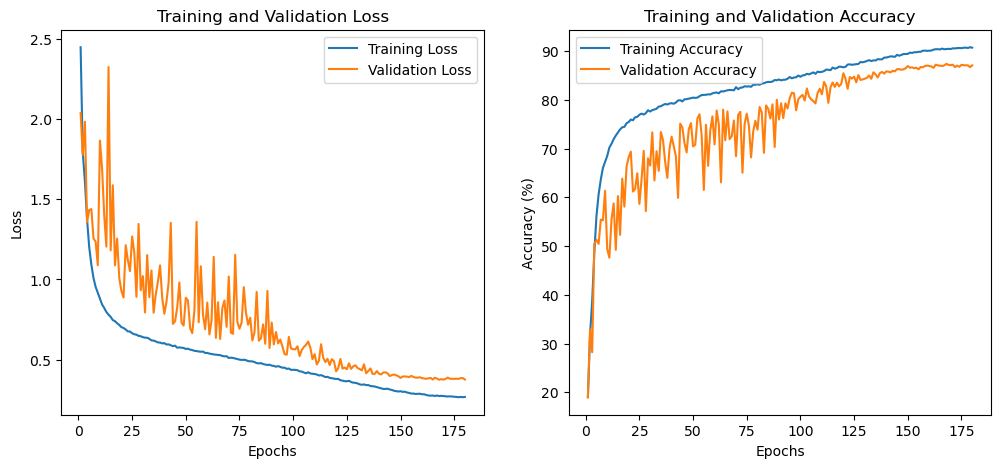

CPU times: user 1h 2min 45s, sys: 12min 9s, total: 1h 14min 55s
Wall time: 2h 22min 58s


In [57]:
%%time
SEED = 42
torch.manual_seed(SEED)
net = MobileNetV2()
net.to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180)
print(f"\nTesting: Learning Rate = {0.01}, Optimizer = {type(optimizer).__name__}")

mobilenetv2_0_0_1_RMSprop_train_losses = []
mobilenetv2_0_0_1_RMSprop_val_losses = []
mobilenetv2_0_0_1_RMSprop_train_accuracies = []
mobilenetv2_0_0_1_RMSprop_val_accuracies = []

for epoch in range(start_epoch, 180):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = val(epoch)
    scheduler.step()
    
    mobilenetv2_0_0_1_RMSprop_train_losses.append(train_loss)
    mobilenetv2_0_0_1_RMSprop_val_losses.append(val_loss)
    mobilenetv2_0_0_1_RMSprop_train_accuracies.append(train_accuracy)
    mobilenetv2_0_0_1_RMSprop_val_accuracies.append(val_accuracy)

state_mobilenetv2_0_0_1_RMSprop,  acc_mobilenetv2_0_0_1_RMSprop = net.state_dict(), best_acc
print("Validation Accuracy: ",acc_mobilenetv2_0_0_1_RMSprop)

plot_metrics(mobilenetv2_0_0_1_RMSprop_train_losses, mobilenetv2_0_0_1_RMSprop_val_losses, 
             mobilenetv2_0_0_1_RMSprop_train_accuracies, mobilenetv2_0_0_1_RMSprop_val_accuracies)

del net
del optimizer
del scheduler
best_acc = 0

In [58]:
file_path_mobilenetv2_0_0_1_RMSprop = "./result_and_model/mobilenetv2_0_0_1_RMSprop_results.pkl"
model_state_path_mobilenetv2_0_0_1_RMSprop = "./result_and_model/mobilenetv2_0_0_1_RMSprop_model.pth"

with open(file_path_mobilenetv2_0_0_1_RMSprop, "wb") as f:
    pickle.dump({
        "train_losses": mobilenetv2_0_0_1_RMSprop_train_losses,
        "val_losses": mobilenetv2_0_0_1_RMSprop_val_losses,
        "train_accuracies": mobilenetv2_0_0_1_RMSprop_train_accuracies,
        "val_accuracies": mobilenetv2_0_0_1_RMSprop_val_accuracies,
        "best_accuracy": acc_mobilenetv2_0_0_1_RMSprop
    }, f)


torch.save(state_mobilenetv2_0_0_1_RMSprop, model_state_path_mobilenetv2_0_0_1_RMSprop)

print("Training data and model state saved successfully.")

Training data and model state saved successfully.


### Load the variables

#### Search for best Baseline Candidate and get the test accuracy

In [59]:
# For Baseline
# SGD 0.1
with open("./result_and_model/baseline_0_1_SGD_results.pkl", "rb") as f:
    data = pickle.load(f)
    baseline_0_1_SGD_train_losses = data["train_losses"]
    baseline_0_1_SGD_val_losses = data["val_losses"]
    baseline_0_1_SGD_train_accuracies = data["train_accuracies"]
    baseline_0_1_SGD_val_accuracies = data["val_accuracies"]
    acc_baseline_0_1_SGD = data["best_accuracy"]

# SGD 0.01
with open("./result_and_model/baseline_0_0_1_SGD_results.pkl", "rb") as f:
    data = pickle.load(f)
    baseline_0_0_1_SGD_train_losses = data["train_losses"]
    baseline_0_0_1_SGD_val_losses = data["val_losses"]
    baseline_0_0_1_SGD_train_accuracies = data["train_accuracies"]
    baseline_0_0_1_SGD_val_accuracies = data["val_accuracies"]
    acc_baseline_0_0_1_SGD = data["best_accuracy"]

# Adam 0.1
with open("./result_and_model/baseline_0_1_Adam_results.pkl", "rb") as f:
    data = pickle.load(f)
    baseline_0_1_Adam_train_losses = data["train_losses"]
    baseline_0_1_Adam_val_losses = data["val_losses"]
    baseline_0_1_Adam_train_accuracies = data["train_accuracies"]
    baseline_0_1_Adam_val_accuracies = data["val_accuracies"]
    acc_baseline_0_1_Adam = data["best_accuracy"]

# Adam 0.01
with open("./result_and_model/baseline_0_0_1_Adam_results.pkl", "rb") as f:
    data = pickle.load(f)
    baseline_0_0_1_Adam_train_losses = data["train_losses"]
    baseline_0_0_1_Adam_val_losses = data["val_losses"]
    baseline_0_0_1_Adam_train_accuracies = data["train_accuracies"]
    baseline_0_0_1_Adam_val_accuracies = data["val_accuracies"]
    acc_baseline_0_0_1_Adam = data["best_accuracy"]

# RMSprop 0.1
with open("./result_and_model/baseline_0_1_RMSprop_results.pkl", "rb") as f:
    data = pickle.load(f)
    baseline_0_1_RMSprop_train_losses = data["train_losses"]
    baseline_0_1_RMSprop_val_losses = data["val_losses"]
    baseline_0_1_RMSprop_train_accuracies = data["train_accuracies"]
    baseline_0_1_RMSprop_val_accuracies = data["val_accuracies"]
    acc_baseline_0_1_RMSprop = data["best_accuracy"]

# RMSprop 0.01
with open("./result_and_model/baseline_0_0_1_RMSprop_results.pkl", "rb") as f:
    data = pickle.load(f)
    baseline_0_0_1_RMSprop_train_losses = data["train_losses"]
    baseline_0_0_1_RMSprop_val_losses = data["val_losses"]
    baseline_0_0_1_RMSprop_train_accuracies = data["train_accuracies"]
    baseline_0_0_1_RMSprop_val_accuracies = data["val_accuracies"]
    acc_baseline_0_0_1_RMSprop = data["best_accuracy"]

variables = {
    'acc_baseline_0_1_SGD': acc_baseline_0_1_SGD,
    'acc_baseline_0_0_1_SGD': acc_baseline_0_0_1_SGD,
    'acc_baseline_0_1_Adam': acc_baseline_0_1_Adam,
    'acc_baseline_0_0_1_Adam': acc_baseline_0_0_1_Adam,
    'acc_baseline_0_1_RMSprop': acc_baseline_0_1_RMSprop,
    'acc_baseline_0_0_1_RMSprop': acc_baseline_0_0_1_RMSprop
}

# Find the variable name and value with the maximum value
max_var = max(variables, key=variables.get)
max_value = variables[max_var]

print(f"The highest validation accuracy value is {max_value} from {max_var}")

The highest validation accuracy value is 66.82 from acc_baseline_0_0_1_SGD


In [60]:
state_baseline_0_0_1_SGD = torch.load("./result_and_model/baseline_0_0_1_SGD_model.pth", weights_only=True)
net = Baseline()
net.load_state_dict(state_baseline_0_0_1_SGD)
net.to(device)

test_loss, test_accuracy = test_model(net, testloader)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")

del net

Testing: 100%|██| 100/100 [00:12<00:00,  8.24batch/s, accuracy=69.5, loss=0.891]

Test Loss: 0.8670, Test Accuracy: 69.55%
Final Test Loss: 0.8670, Final Test Accuracy: 69.55%


#### Search for best Alexnet Candidate and get the test accuracy

In [61]:
# For alexnet
# SGD 0.1
with open("./result_and_model/alexnet_0_1_SGD_results.pkl", "rb") as f:
    data = pickle.load(f)
    alexnet_0_1_SGD_train_losses = data["train_losses"]
    alexnet_0_1_SGD_val_losses = data["val_losses"]
    alexnet_0_1_SGD_train_accuracies = data["train_accuracies"]
    alexnet_0_1_SGD_val_accuracies = data["val_accuracies"]
    acc_alexnet_0_1_SGD = data["best_accuracy"]

# SGD 0.01
with open("./result_and_model/alexnet_0_0_1_SGD_results.pkl", "rb") as f:
    data = pickle.load(f)
    alexnet_0_0_1_SGD_train_losses = data["train_losses"]
    alexnet_0_0_1_SGD_val_losses = data["val_losses"]
    alexnet_0_0_1_SGD_train_accuracies = data["train_accuracies"]
    alexnet_0_0_1_SGD_val_accuracies = data["val_accuracies"]
    acc_alexnet_0_0_1_SGD = data["best_accuracy"]

# Adam 0.1
with open("./result_and_model/alexnet_0_1_Adam_results.pkl", "rb") as f:
    data = pickle.load(f)
    alexnet_0_1_Adam_train_losses = data["train_losses"]
    alexnet_0_1_Adam_val_losses = data["val_losses"]
    alexnet_0_1_Adam_train_accuracies = data["train_accuracies"]
    alexnet_0_1_Adam_val_accuracies = data["val_accuracies"]
    acc_alexnet_0_1_Adam = data["best_accuracy"]

# Adam 0.01
with open("./result_and_model/alexnet_0_0_1_Adam_results.pkl", "rb") as f:
    data = pickle.load(f)
    alexnet_0_0_1_Adam_train_losses = data["train_losses"]
    alexnet_0_0_1_Adam_val_losses = data["val_losses"]
    alexnet_0_0_1_Adam_train_accuracies = data["train_accuracies"]
    alexnet_0_0_1_Adam_val_accuracies = data["val_accuracies"]
    acc_alexnet_0_0_1_Adam = data["best_accuracy"]

# RMSprop 0.1
with open("./result_and_model/alexnet_0_1_RMSprop_results.pkl", "rb") as f:
    data = pickle.load(f)
    alexnet_0_1_RMSprop_train_losses = data["train_losses"]
    alexnet_0_1_RMSprop_val_losses = data["val_losses"]
    alexnet_0_1_RMSprop_train_accuracies = data["train_accuracies"]
    alexnet_0_1_RMSprop_val_accuracies = data["val_accuracies"]
    acc_alexnet_0_1_RMSprop = data["best_accuracy"]

# RMSprop 0.01
with open("./result_and_model/alexnet_0_0_1_RMSprop_results.pkl", "rb") as f:
    data = pickle.load(f)
    alexnet_0_0_1_RMSprop_train_losses = data["train_losses"]
    alexnet_0_0_1_RMSprop_val_losses = data["val_losses"]
    alexnet_0_0_1_RMSprop_train_accuracies = data["train_accuracies"]
    alexnet_0_0_1_RMSprop_val_accuracies = data["val_accuracies"]
    acc_alexnet_0_0_1_RMSprop = data["best_accuracy"]

variables = {
    'acc_alexnet_0_1_SGD': acc_alexnet_0_1_SGD,
    'acc_alexnet_0_0_1_SGD': acc_alexnet_0_0_1_SGD,
    'acc_alexnet_0_1_Adam': acc_alexnet_0_1_Adam,
    'acc_alexnet_0_0_1_Adam': acc_alexnet_0_0_1_Adam,
    'acc_alexnet_0_1_RMSprop': acc_alexnet_0_1_RMSprop,
    'acc_alexnet_0_0_1_RMSprop': acc_alexnet_0_0_1_RMSprop
}

# Find the variable name and value with the maximum value
max_var = max(variables, key=variables.get)
max_value = variables[max_var]

print(f"The highest validation accuracy value is {max_value} from {max_var}")

The highest validation accuracy value is 87.14 from acc_alexnet_0_0_1_SGD


In [62]:
state_alexnet_0_0_1_SGD = torch.load("./result_and_model/alexnet_0_0_1_SGD_model.pth", weights_only=True)
net = AlexNet()
net.load_state_dict(state_alexnet_0_0_1_SGD)
net.to(device)

test_loss, test_accuracy = test_model(net, testloader)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")

del net

Testing: 100%|██| 100/100 [00:12<00:00,  7.93batch/s, accuracy=87.8, loss=0.958]

Test Loss: 0.7522, Test Accuracy: 87.79%
Final Test Loss: 0.7522, Final Test Accuracy: 87.79%


#### Search for best ResNet18 Candidate and get the test accuracy

In [63]:
# For resnet18
# SGD 0.1
with open("./result_and_model/resnet18_0_1_SGD_results.pkl", "rb") as f:
    data = pickle.load(f)
    resnet18_0_1_SGD_train_losses = data["train_losses"]
    resnet18_0_1_SGD_val_losses = data["val_losses"]
    resnet18_0_1_SGD_train_accuracies = data["train_accuracies"]
    resnet18_0_1_SGD_val_accuracies = data["val_accuracies"]
    acc_resnet18_0_1_SGD = data["best_accuracy"]

# SGD 0.01
with open("./result_and_model/resnet18_0_0_1_SGD_results.pkl", "rb") as f:
    data = pickle.load(f)
    resnet18_0_0_1_SGD_train_losses = data["train_losses"]
    resnet18_0_0_1_SGD_val_losses = data["val_losses"]
    resnet18_0_0_1_SGD_train_accuracies = data["train_accuracies"]
    resnet18_0_0_1_SGD_val_accuracies = data["val_accuracies"]
    acc_resnet18_0_0_1_SGD = data["best_accuracy"]

# Adam 0.1
with open("./result_and_model/resnet18_0_1_Adam_results.pkl", "rb") as f:
    data = pickle.load(f)
    resnet18_0_1_Adam_train_losses = data["train_losses"]
    resnet18_0_1_Adam_val_losses = data["val_losses"]
    resnet18_0_1_Adam_train_accuracies = data["train_accuracies"]
    resnet18_0_1_Adam_val_accuracies = data["val_accuracies"]
    acc_resnet18_0_1_Adam = data["best_accuracy"]

# Adam 0.01
with open("./result_and_model/resnet18_0_0_1_Adam_results.pkl", "rb") as f:
    data = pickle.load(f)
    resnet18_0_0_1_Adam_train_losses = data["train_losses"]
    resnet18_0_0_1_Adam_val_losses = data["val_losses"]
    resnet18_0_0_1_Adam_train_accuracies = data["train_accuracies"]
    resnet18_0_0_1_Adam_val_accuracies = data["val_accuracies"]
    acc_resnet18_0_0_1_Adam = data["best_accuracy"]

# RMSprop 0.1
with open("./result_and_model/resnet18_0_1_RMSprop_results.pkl", "rb") as f:
    data = pickle.load(f)
    resnet18_0_1_RMSprop_train_losses = data["train_losses"]
    resnet18_0_1_RMSprop_val_losses = data["val_losses"]
    resnet18_0_1_RMSprop_train_accuracies = data["train_accuracies"]
    resnet18_0_1_RMSprop_val_accuracies = data["val_accuracies"]
    acc_resnet18_0_1_RMSprop = data["best_accuracy"]

# RMSprop 0.01
with open("./result_and_model/resnet18_0_0_1_RMSprop_results.pkl", "rb") as f:
    data = pickle.load(f)
    resnet18_0_0_1_RMSprop_train_losses = data["train_losses"]
    resnet18_0_0_1_RMSprop_val_losses = data["val_losses"]
    resnet18_0_0_1_RMSprop_train_accuracies = data["train_accuracies"]
    resnet18_0_0_1_RMSprop_val_accuracies = data["val_accuracies"]
    acc_resnet18_0_0_1_RMSprop = data["best_accuracy"]

variables = {
    'acc_resnet18_0_1_SGD': acc_resnet18_0_1_SGD,
    'acc_resnet18_0_0_1_SGD': acc_resnet18_0_0_1_SGD,
    'acc_resnet18_0_1_Adam': acc_resnet18_0_1_Adam,
    'acc_resnet18_0_0_1_Adam': acc_resnet18_0_0_1_Adam,
    'acc_resnet18_0_1_RMSprop': acc_resnet18_0_1_RMSprop,
    'acc_resnet18_0_0_1_RMSprop': acc_resnet18_0_0_1_RMSprop
}

# Find the variable name and value with the maximum value
max_var = max(variables, key=variables.get)
max_value = variables[max_var]

print(f"The highest validation accuracy value is {max_value} from {max_var}")

The highest validation accuracy value is 95.12 from acc_resnet18_0_1_SGD


In [64]:
state_resnet18_0_1_SGD = torch.load("./result_and_model/resnet18_0_1_SGD_model.pth", weights_only=True)
net = ResNet18()
net.load_state_dict(state_resnet18_0_1_SGD)
net.to(device)

test_loss, test_accuracy = test_model(net, testloader)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")

del net

Testing: 100%|██| 100/100 [00:13<00:00,  7.57batch/s, accuracy=94.5, loss=0.143]

Test Loss: 0.2049, Test Accuracy: 94.53%
Final Test Loss: 0.2049, Final Test Accuracy: 94.53%


#### Search for best Baseline Candidate and get the test accuracy

In [65]:
# For mobilenetv2
# SGD 0.1
with open("./result_and_model/mobilenetv2_0_1_SGD_results.pkl", "rb") as f:
    data = pickle.load(f)
    mobilenetv2_0_1_SGD_train_losses = data["train_losses"]
    mobilenetv2_0_1_SGD_val_losses = data["val_losses"]
    mobilenetv2_0_1_SGD_train_accuracies = data["train_accuracies"]
    mobilenetv2_0_1_SGD_val_accuracies = data["val_accuracies"]
    acc_mobilenetv2_0_1_SGD = data["best_accuracy"]

# SGD 0.01
with open("./result_and_model/mobilenetv2_0_0_1_SGD_results.pkl", "rb") as f:
    data = pickle.load(f)
    mobilenetv2_0_0_1_SGD_train_losses = data["train_losses"]
    mobilenetv2_0_0_1_SGD_val_losses = data["val_losses"]
    mobilenetv2_0_0_1_SGD_train_accuracies = data["train_accuracies"]
    mobilenetv2_0_0_1_SGD_val_accuracies = data["val_accuracies"]
    acc_mobilenetv2_0_0_1_SGD = data["best_accuracy"]

# Adam 0.1
with open("./result_and_model/mobilenetv2_0_1_Adam_results.pkl", "rb") as f:
    data = pickle.load(f)
    mobilenetv2_0_1_Adam_train_losses = data["train_losses"]
    mobilenetv2_0_1_Adam_val_losses = data["val_losses"]
    mobilenetv2_0_1_Adam_train_accuracies = data["train_accuracies"]
    mobilenetv2_0_1_Adam_val_accuracies = data["val_accuracies"]
    acc_mobilenetv2_0_1_Adam = data["best_accuracy"]

# Adam 0.01
with open("./result_and_model/mobilenetv2_0_0_1_Adam_results.pkl", "rb") as f:
    data = pickle.load(f)
    mobilenetv2_0_0_1_Adam_train_losses = data["train_losses"]
    mobilenetv2_0_0_1_Adam_val_losses = data["val_losses"]
    mobilenetv2_0_0_1_Adam_train_accuracies = data["train_accuracies"]
    mobilenetv2_0_0_1_Adam_val_accuracies = data["val_accuracies"]
    acc_mobilenetv2_0_0_1_Adam = data["best_accuracy"]

# RMSprop 0.1
with open("./result_and_model/mobilenetv2_0_1_RMSprop_results.pkl", "rb") as f:
    data = pickle.load(f)
    mobilenetv2_0_1_RMSprop_train_losses = data["train_losses"]
    mobilenetv2_0_1_RMSprop_val_losses = data["val_losses"]
    mobilenetv2_0_1_RMSprop_train_accuracies = data["train_accuracies"]
    mobilenetv2_0_1_RMSprop_val_accuracies = data["val_accuracies"]
    acc_mobilenetv2_0_1_RMSprop = data["best_accuracy"]

# RMSprop 0.01
with open("./result_and_model/mobilenetv2_0_0_1_RMSprop_results.pkl", "rb") as f:
    data = pickle.load(f)
    mobilenetv2_0_0_1_RMSprop_train_losses = data["train_losses"]
    mobilenetv2_0_0_1_RMSprop_val_losses = data["val_losses"]
    mobilenetv2_0_0_1_RMSprop_train_accuracies = data["train_accuracies"]
    mobilenetv2_0_0_1_RMSprop_val_accuracies = data["val_accuracies"]
    acc_mobilenetv2_0_0_1_RMSprop = data["best_accuracy"]

variables = {
    'acc_mobilenetv2_0_1_SGD': acc_mobilenetv2_0_1_SGD,
    'acc_mobilenetv2_0_0_1_SGD': acc_mobilenetv2_0_0_1_SGD,
    'acc_mobilenetv2_0_1_Adam': acc_mobilenetv2_0_1_Adam,
    'acc_mobilenetv2_0_0_1_Adam': acc_mobilenetv2_0_0_1_Adam,
    'acc_mobilenetv2_0_1_RMSprop': acc_mobilenetv2_0_1_RMSprop,
    'acc_mobilenetv2_0_0_1_RMSprop': acc_mobilenetv2_0_0_1_RMSprop
}

# Find the variable name and value with the maximum value
max_var = max(variables, key=variables.get)
max_value = variables[max_var]

print(f"The highest validation accuracy value is {max_value} from {max_var}")

The highest validation accuracy value is 93.27 from acc_mobilenetv2_0_0_1_SGD


In [66]:
state_mobilenetv2_0_0_1_SGD = torch.load("./result_and_model/mobilenetv2_0_0_1_SGD_model.pth", weights_only=True)
net = MobileNetV2()
net.load_state_dict(state_mobilenetv2_0_0_1_SGD)
net.to(device)

test_loss, test_accuracy = test_model(net, testloader)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")

del net

Testing: 100%|██| 100/100 [00:13<00:00,  7.58batch/s, accuracy=92.8, loss=0.389]

Test Loss: 0.3189, Test Accuracy: 92.77%
Final Test Loss: 0.3189, Final Test Accuracy: 92.77%


### Plotter to plot the accuracies of best canditate models

In [67]:
def plot_accuracies_best(epochs, *accuracy_pairs, model_names=None):
    import numpy as np
    import matplotlib.pyplot as plt

    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(accuracy_pairs))]

    # Calculate max length inside the function using the passed accuracy pairs
    max_length = max(len(train_accuracies) for train_accuracies, _ in accuracy_pairs)

    # Adjust the `epochs` to match the max length of the accuracies
    epochs = range(1, max_length + 1)

    for i, (train_accuracies, val_accuracies) in enumerate(accuracy_pairs):
        model_name = model_names[i] if i < len(model_names) else f"Model {i+1}"

        # Padding shorter lists
        train_accuracies = np.pad(train_accuracies, (0, max_length - len(train_accuracies)), mode='constant', constant_values=np.nan)
        val_accuracies = np.pad(val_accuracies, (0, max_length - len(val_accuracies)), mode='constant', constant_values=np.nan)

        # Plot training accuracies
        axes[0].plot(epochs, train_accuracies, label=f'{model_name} Train Accuracy', linestyle='-')
        
        # Plot validation accuracies
        axes[1].plot(epochs, val_accuracies, label=f'{model_name} Val Accuracy', linestyle='--')


    axes[0].set_title('Training Accuracies for Best Models')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].legend(loc='lower right')
    axes[0].grid(True)

    axes[1].set_title('Validation Accuracies for Best Models')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

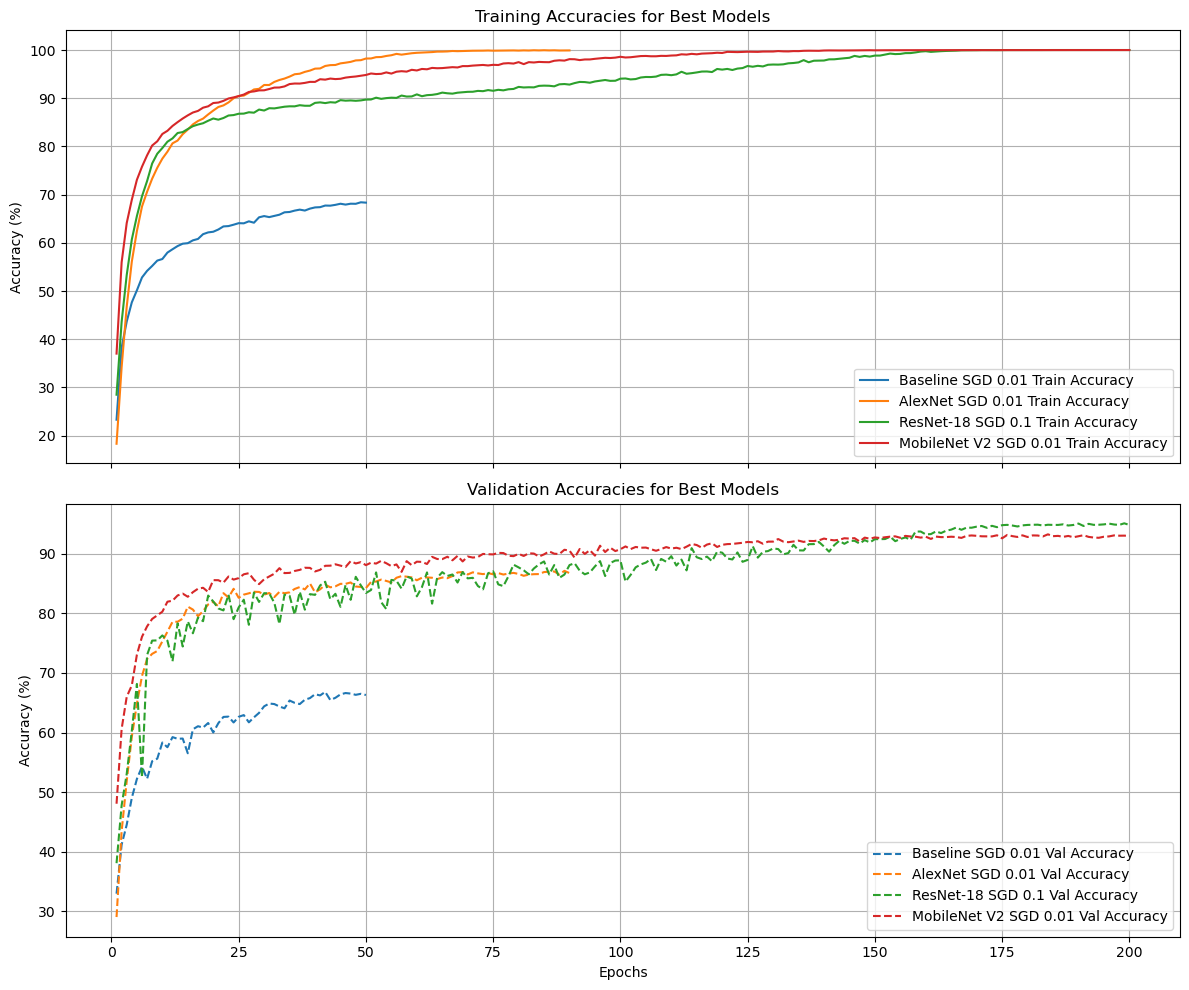

In [68]:
plot_accuracies_best(
    None,  
    (baseline_0_0_1_SGD_train_accuracies, baseline_0_0_1_SGD_val_accuracies),
    (alexnet_0_0_1_SGD_train_accuracies, alexnet_0_0_1_SGD_val_accuracies),
    (resnet18_0_1_SGD_train_accuracies, resnet18_0_1_SGD_val_accuracies),
    (mobilenetv2_0_0_1_SGD_train_accuracies, mobilenetv2_0_0_1_SGD_val_accuracies),
    model_names=["Baseline SGD 0.01", "AlexNet SGD 0.01", "ResNet-18 SGD 0.1", "MobileNet V2 SGD 0.01"]
)